In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import trimesh
import argparse
import os
import time
import numpy as np
import torch
import torch.optim as optim

import lib.toy_data as toy_data
import lib.utils as utils
from lib.utils import standard_normal_logprob
from lib.utils import count_nfe, count_total_time
from lib.utils import build_model_tabular

from lib.visualize_flow import visualize_transform
import lib.layers.odefunc as odefunc
from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
SOLVERS = ["dopri5"]
parser = argparse.ArgumentParser('SoftFlow')
parser.add_argument(
    '--data', choices=['2spirals_1d','2spirals_2d', 'swissroll_1d','swissroll_2d', 'circles_1d', 'circles_2d', '2sines_1d', 'target_1d'],
    type=str, default='2spirals_1d'
)
parser.add_argument("--layer_type", type=str, default="concatsquash", choices=["concatsquash"])
parser.add_argument('--dims', type=str, default='64-64-64')
parser.add_argument("--num_blocks", type=int, default=1, help='Number of stacked CNFs.')
parser.add_argument('--time_length', type=float, default=0.5)
parser.add_argument('--train_T', type=eval, default=True)
parser.add_argument("--divergence_fn", type=str, default="brute_force", choices=["brute_force", "approximate"])
parser.add_argument("--nonlinearity", type=str, default="tanh", choices=odefunc.NONLINEARITIES)

parser.add_argument('--solver', type=str, default='dopri5', choices=SOLVERS)
parser.add_argument('--atol', type=float, default=1e-5)
parser.add_argument('--rtol', type=float, default=1e-5)

parser.add_argument('--residual', type=eval, default=False, choices=[True, False])
parser.add_argument('--rademacher', type=eval, default=False, choices=[True, False])
parser.add_argument('--spectral_norm', type=eval, default=False, choices=[True, False])
parser.add_argument('--niters', type=int, default=36000)
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--test_batch_size', type=int, default=1000)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--weight_decay', type=float, default=1e-5)

# for the proposed method
parser.add_argument('--std_min', type=float, default=0.0)
parser.add_argument('--std_max', type=float, default=0.1)
parser.add_argument('--std_weight', type=float, default=2)

parser.add_argument('--viz_freq', type=int, default=100)
parser.add_argument('--val_freq', type=int, default=400)
parser.add_argument('--log_freq', type=int, default=10)
parser.add_argument('--gpu', type=int, default=0)
# args = parser.parse_args()
args, unknown = parser.parse_known_args()


In [3]:
# logger
save_path = './results/' + args.data + '/SoftFlow'
utils.makedirs(save_path)

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [4]:
def get_transforms(model):

    def sample_fn(z, logpz=None):
        zeors_std = torch.zeros(z.shape[0], 1).to(z)
        if logpz is not None:
            return model(z, zeors_std, logpz, reverse=True)
        else:
            return model(z, zeors_std, reverse=True)

    def density_fn(x, logpx=None):
        zeors_std = torch.zeros(x.shape[0], 1).to(x)
        if logpx is not None:
            return model(x, zeors_std, logpx, reverse=False)
        else:
            return model(x, zeors_std, reverse=False)

    return sample_fn, density_fn

DATA = trimesh.load('ANDREY_FOCTS1.ply')[:]
 
def compute_loss(args, model, batch_size=None):
    if batch_size is None: batch_size = args.batch_size

    # load data
#     x = toy_data.inf_train_gen(args.data, batch_size=batch_size)
    x = DATA[:,1:3]


    x = torch.from_numpy(x).type(torch.float32).to(device)
    zero = torch.zeros(x.shape[0], 1).to(x)

    # transform to z
    std = (args.std_max - args.std_min) * torch.rand_like(x[:,0]).view(-1,1) + args.std_min
    eps = torch.randn_like(x) * std
    std_in = std / args.std_max * args.std_weight
    z, delta_logp = model(x+eps, std_in, zero)

    # compute log q(z)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)

    logpx = logpz - delta_logp
    loss = -torch.mean(logpx)
    return loss

In [5]:
model = build_model_tabular(args, 2).to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

time_meter = utils.RunningAverageMeter(0.93)
loss_meter = utils.RunningAverageMeter(0.93)
nfef_meter = utils.RunningAverageMeter(0.93)
nfeb_meter = utils.RunningAverageMeter(0.93)
tt_meter = utils.RunningAverageMeter(0.93)

end = time.time()
best_loss = float('inf')

In [13]:
model.train()
for itr in range(1, args.niters + 1):
    optimizer.zero_grad()

    loss = compute_loss(args, model)

    loss_meter.update(loss.item())

    total_time = count_total_time(model)
    nfe_forward = count_nfe(model)

    loss.backward()
    optimizer.step()

    nfe_total = count_nfe(model)
    nfe_backward = nfe_total - nfe_forward
    nfef_meter.update(nfe_forward)
    nfeb_meter.update(nfe_backward)

    time_meter.update(time.time() - end)
    tt_meter.update(total_time)

    log_message = (
        'Iter {:04d} | Time {:.4f}({:.4f}) | Loss {:.6f}({:.6f}) | NFE Forward {:.0f}({:.1f})'
        ' | NFE Backward {:.0f}({:.1f}) | CNF Time {:.4f}({:.4f})'.format(
            itr, time_meter.val, time_meter.avg, loss_meter.val, loss_meter.avg, nfef_meter.val, nfef_meter.avg,
            nfeb_meter.val, nfeb_meter.avg, tt_meter.val, tt_meter.avg
        )
    )

    print(log_message)

    if itr % args.val_freq == 0 or itr == args.niters:
        with torch.no_grad():
            model.eval()
            test_loss = compute_loss(args, model, batch_size=args.test_batch_size)
            test_nfe = count_nfe(model)
            log_message = '[TEST] Iter {:04d} | Test Loss {:.6f} | NFE {:.0f}'.format(itr, test_loss, test_nfe)
            print(log_message)

            if test_loss.item() < best_loss:
                best_loss = test_loss.item()
                utils.makedirs(save_path)
                torch.save({
                    'args': args,
                    'state_dict': model.state_dict(),
                }, os.path.join(save_path, 'checkpt.pth'))
            model.train()

    if itr % args.viz_freq == 0:
        with torch.no_grad():
            model.eval()
#             p_samples = toy_data.inf_train_gen(args.data, batch_size=2000)
            p_samples = DATA[:,1:3]

            sample_fn, density_fn = get_transforms(model)

            plt.figure(figsize=(9, 3))
            visualize_transform(
                p_samples, torch.randn, standard_normal_logprob, transform=sample_fn, inverse_transform=density_fn,
                samples=True, npts=200, device=device
            )
            fig_filename = os.path.join(save_path, 'figs', '{:04d}.jpg'.format(itr))
            utils.makedirs(os.path.dirname(fig_filename))
            plt.savefig(fig_filename, format='png', dpi=1200)
            plt.close()
            model.train()

    end = time.time()

print('Training has finished.')

Iter 0001 | Time 71.5951(7.4720) | Loss -0.824310(-0.806342) | NFE Forward 44(42.0) | NFE Backward 56(55.5) | CNF Time 0.5000(0.5000)
Iter 0002 | Time 2.7685(7.1428) | Loss -0.837403(-0.808517) | NFE Forward 44(42.1) | NFE Backward 56(55.6) | CNF Time 0.5000(0.5000)
Iter 0003 | Time 2.7304(6.8339) | Loss -0.832354(-0.810185) | NFE Forward 44(42.2) | NFE Backward 56(55.6) | CNF Time 0.5000(0.5000)
Iter 0004 | Time 2.8328(6.5538) | Loss -0.835755(-0.811975) | NFE Forward 44(42.4) | NFE Backward 56(55.6) | CNF Time 0.5000(0.5000)
Iter 0005 | Time 2.5852(6.2760) | Loss -0.837211(-0.813742) | NFE Forward 44(42.5) | NFE Backward 56(55.7) | CNF Time 0.5000(0.5000)
Iter 0006 | Time 2.7762(6.0310) | Loss -0.837011(-0.815370) | NFE Forward 44(42.6) | NFE Backward 56(55.7) | CNF Time 0.5000(0.5000)
Iter 0007 | Time 2.7178(5.7991) | Loss -0.841830(-0.817223) | NFE Forward 44(42.7) | NFE Backward 56(55.7) | CNF Time 0.5000(0.5000)
Iter 0008 | Time 2.7794(5.5877) | Loss -0.839647(-0.818792) | NFE Fo

Iter 0063 | Time 2.6943(2.7897) | Loss -0.918263(-0.901653) | NFE Forward 50(49.5) | NFE Backward 50(53.5) | CNF Time 0.5000(0.5000)
Iter 0064 | Time 2.6730(2.7815) | Loss -0.917771(-0.902781) | NFE Forward 50(49.5) | NFE Backward 50(53.2) | CNF Time 0.5000(0.5000)
Iter 0065 | Time 2.5410(2.7647) | Loss -0.921788(-0.904112) | NFE Forward 50(49.5) | NFE Backward 50(53.0) | CNF Time 0.5000(0.5000)
Iter 0066 | Time 2.7323(2.7624) | Loss -0.917820(-0.905071) | NFE Forward 50(49.6) | NFE Backward 50(52.8) | CNF Time 0.5000(0.5000)
Iter 0067 | Time 2.5368(2.7466) | Loss -0.922239(-0.906273) | NFE Forward 50(49.6) | NFE Backward 50(52.6) | CNF Time 0.5000(0.5000)
Iter 0068 | Time 2.5346(2.7318) | Loss -0.925919(-0.907648) | NFE Forward 50(49.6) | NFE Backward 50(52.4) | CNF Time 0.5000(0.5000)
Iter 0069 | Time 2.5227(2.7172) | Loss -0.921748(-0.908635) | NFE Forward 50(49.6) | NFE Backward 50(52.2) | CNF Time 0.5000(0.5000)
Iter 0070 | Time 2.5954(2.7086) | Loss -0.920012(-0.909432) | NFE For

Iter 0125 | Time 1.3980(1.8333) | Loss -0.953541(-0.946711) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0126 | Time 1.4204(1.8044) | Loss -0.953369(-0.947178) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0127 | Time 1.3739(1.7743) | Loss -0.954038(-0.947658) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0128 | Time 1.3857(1.7471) | Loss -0.951767(-0.947945) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0129 | Time 1.3918(1.7222) | Loss -0.954038(-0.948372) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0130 | Time 1.4289(1.7017) | Loss -0.953991(-0.948765) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0131 | Time 1.3929(1.6801) | Loss -0.952162(-0.949003) | NFE Forward 50(50.0) | NFE Backward 50(50.0) | CNF Time 0.5000(0.5000)
Iter 0132 | Time 2.0988(1.7094) | Loss -0.960174(-0.949785) | NFE For

Iter 0187 | Time 2.7515(2.7059) | Loss -0.971192(-0.966160) | NFE Forward 50(50.0) | NFE Backward 56(54.5) | CNF Time 0.5000(0.5000)
Iter 0188 | Time 2.7624(2.7099) | Loss -0.968142(-0.966299) | NFE Forward 50(50.0) | NFE Backward 56(54.6) | CNF Time 0.5000(0.5000)
Iter 0189 | Time 2.8741(2.7213) | Loss -0.966310(-0.966299) | NFE Forward 50(50.0) | NFE Backward 56(54.7) | CNF Time 0.5000(0.5000)
Iter 0190 | Time 2.6783(2.7183) | Loss -0.966139(-0.966288) | NFE Forward 50(50.0) | NFE Backward 56(54.8) | CNF Time 0.5000(0.5000)
Iter 0191 | Time 2.7373(2.7197) | Loss -0.968706(-0.966457) | NFE Forward 50(50.0) | NFE Backward 56(54.9) | CNF Time 0.5000(0.5000)
Iter 0192 | Time 2.7874(2.7244) | Loss -0.969341(-0.966659) | NFE Forward 50(50.0) | NFE Backward 56(55.0) | CNF Time 0.5000(0.5000)
Iter 0193 | Time 2.8667(2.7344) | Loss -0.970634(-0.966937) | NFE Forward 50(50.0) | NFE Backward 56(55.0) | CNF Time 0.5000(0.5000)
Iter 0194 | Time 2.7397(2.7347) | Loss -0.970669(-0.967199) | NFE For

Iter 0249 | Time 2.7720(2.8043) | Loss -0.983818(-0.977787) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0250 | Time 2.9736(2.8161) | Loss -0.982552(-0.978121) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0251 | Time 2.7382(2.8107) | Loss -0.978334(-0.978136) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0252 | Time 2.7578(2.8070) | Loss -0.976470(-0.978019) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0253 | Time 2.8691(2.8113) | Loss -0.979594(-0.978129) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0254 | Time 2.8071(2.8110) | Loss -0.979688(-0.978238) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0255 | Time 2.7362(2.8058) | Loss -0.982247(-0.978519) | NFE Forward 50(50.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0256 | Time 2.9307(2.8145) | Loss -0.982483(-0.978796) | NFE For

Iter 0311 | Time 2.7268(2.7927) | Loss -0.990800(-0.984703) | NFE Forward 50(50.6) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0312 | Time 2.6787(2.7847) | Loss -0.988691(-0.984982) | NFE Forward 44(50.2) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0313 | Time 3.0385(2.8025) | Loss -0.983896(-0.984906) | NFE Forward 50(50.2) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0314 | Time 2.6946(2.7949) | Loss -0.985220(-0.984928) | NFE Forward 50(50.2) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0315 | Time 2.6948(2.7879) | Loss -0.982400(-0.984751) | NFE Forward 50(50.1) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0316 | Time 2.8410(2.7916) | Loss -0.985431(-0.984799) | NFE Forward 50(50.1) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0317 | Time 2.8955(2.7989) | Loss -0.986453(-0.984914) | NFE Forward 50(50.1) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0318 | Time 2.7707(2.7969) | Loss -0.988657(-0.985176) | NFE For

Iter 0373 | Time 2.8079(2.5405) | Loss -0.990995(-0.989501) | NFE Forward 44(44.3) | NFE Backward 56(56.8) | CNF Time 0.5000(0.5000)
Iter 0374 | Time 2.7449(2.5548) | Loss -0.989969(-0.989534) | NFE Forward 44(44.2) | NFE Backward 56(56.7) | CNF Time 0.5000(0.5000)
Iter 0375 | Time 3.0699(2.5909) | Loss -0.990905(-0.989630) | NFE Forward 44(44.2) | NFE Backward 68(57.5) | CNF Time 0.5000(0.5000)
Iter 0376 | Time 2.7319(2.6007) | Loss -0.986858(-0.989436) | NFE Forward 44(44.2) | NFE Backward 56(57.4) | CNF Time 0.5000(0.5000)
Iter 0377 | Time 2.8568(2.6187) | Loss -0.990167(-0.989487) | NFE Forward 44(44.2) | NFE Backward 56(57.3) | CNF Time 0.5000(0.5000)
Iter 0378 | Time 3.0248(2.6471) | Loss -0.986799(-0.989299) | NFE Forward 44(44.2) | NFE Backward 68(58.1) | CNF Time 0.5000(0.5000)
Iter 0379 | Time 2.7273(2.6527) | Loss -0.990807(-0.989404) | NFE Forward 44(44.2) | NFE Backward 56(57.9) | CNF Time 0.5000(0.5000)
Iter 0380 | Time 2.7791(2.6616) | Loss -0.990593(-0.989488) | NFE For

Iter 0435 | Time 2.7970(2.7365) | Loss -0.992819(-0.992975) | NFE Forward 44(44.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0436 | Time 2.7267(2.7358) | Loss -0.991374(-0.992863) | NFE Forward 44(44.0) | NFE Backward 56(56.0) | CNF Time 0.5000(0.5000)
Iter 0437 | Time 3.0125(2.7552) | Loss -0.993020(-0.992874) | NFE Forward 44(44.0) | NFE Backward 68(56.9) | CNF Time 0.5000(0.5000)
Iter 0438 | Time 2.7692(2.7561) | Loss -0.993632(-0.992927) | NFE Forward 44(44.0) | NFE Backward 56(56.8) | CNF Time 0.5000(0.5000)
Iter 0439 | Time 2.7732(2.7573) | Loss -0.993672(-0.992979) | NFE Forward 44(44.0) | NFE Backward 56(56.8) | CNF Time 0.5000(0.5000)
Iter 0440 | Time 2.8723(2.7654) | Loss -0.995778(-0.993175) | NFE Forward 44(44.0) | NFE Backward 56(56.7) | CNF Time 0.5000(0.5000)
Iter 0441 | Time 2.5748(2.7520) | Loss -0.994188(-0.993246) | NFE Forward 44(44.0) | NFE Backward 56(56.6) | CNF Time 0.5000(0.5000)
Iter 0442 | Time 2.7772(2.7538) | Loss -0.992248(-0.993176) | NFE For

Iter 0497 | Time 2.7855(2.7599) | Loss -0.999758(-0.996105) | NFE Forward 44(44.0) | NFE Backward 56(56.8) | CNF Time 0.5000(0.5000)
Iter 0498 | Time 2.7260(2.7575) | Loss -0.995464(-0.996061) | NFE Forward 44(44.0) | NFE Backward 56(56.7) | CNF Time 0.5000(0.5000)
Iter 0499 | Time 2.8018(2.7606) | Loss -0.993219(-0.995862) | NFE Forward 44(44.0) | NFE Backward 56(56.7) | CNF Time 0.5000(0.5000)
Iter 0500 | Time 2.6024(2.7496) | Loss -0.996922(-0.995936) | NFE Forward 44(44.0) | NFE Backward 56(56.6) | CNF Time 0.5000(0.5000)
Iter 0501 | Time 2.9262(2.7619) | Loss -1.001262(-0.996309) | NFE Forward 44(44.0) | NFE Backward 62(57.0) | CNF Time 0.5000(0.5000)
Iter 0502 | Time 2.6649(2.7551) | Loss -0.995854(-0.996277) | NFE Forward 44(44.0) | NFE Backward 56(56.9) | CNF Time 0.5000(0.5000)
Iter 0503 | Time 2.7239(2.7529) | Loss -0.997876(-0.996389) | NFE Forward 44(44.0) | NFE Backward 56(56.9) | CNF Time 0.5000(0.5000)
Iter 0504 | Time 2.9470(2.7665) | Loss -0.994461(-0.996254) | NFE For

Iter 0559 | Time 1.3262(2.0327) | Loss -0.998925(-0.998294) | NFE Forward 44(44.0) | NFE Backward 74(69.0) | CNF Time 0.5000(0.5000)
Iter 0560 | Time 1.3626(1.9858) | Loss -0.997876(-0.998265) | NFE Forward 44(44.0) | NFE Backward 74(69.4) | CNF Time 0.5000(0.5000)
Iter 0561 | Time 1.2791(1.9363) | Loss -0.998892(-0.998308) | NFE Forward 44(44.0) | NFE Backward 62(68.8) | CNF Time 0.5000(0.5000)
Iter 0562 | Time 1.5794(1.9113) | Loss -0.998248(-0.998304) | NFE Forward 44(44.0) | NFE Backward 74(69.2) | CNF Time 0.5000(0.5000)
Iter 0563 | Time 3.4006(2.0156) | Loss -1.000246(-0.998440) | NFE Forward 44(44.0) | NFE Backward 74(69.5) | CNF Time 0.5000(0.5000)
Iter 0564 | Time 3.5260(2.1213) | Loss -1.002677(-0.998737) | NFE Forward 44(44.0) | NFE Backward 74(69.9) | CNF Time 0.5000(0.5000)
Iter 0565 | Time 2.8512(2.1724) | Loss -0.998810(-0.998742) | NFE Forward 44(44.0) | NFE Backward 62(69.3) | CNF Time 0.5000(0.5000)
Iter 0566 | Time 3.3906(2.2577) | Loss -0.999756(-0.998813) | NFE For

Iter 0621 | Time 3.4573(3.2220) | Loss -0.996033(-1.000406) | NFE Forward 44(44.0) | NFE Backward 74(71.1) | CNF Time 0.5000(0.5000)
Iter 0622 | Time 3.3027(3.2276) | Loss -1.000409(-1.000406) | NFE Forward 44(44.0) | NFE Backward 74(71.3) | CNF Time 0.5000(0.5000)
Iter 0623 | Time 3.1674(3.2234) | Loss -1.003055(-1.000591) | NFE Forward 44(44.0) | NFE Backward 74(71.5) | CNF Time 0.5000(0.5000)
Iter 0624 | Time 2.9148(3.2018) | Loss -1.000652(-1.000596) | NFE Forward 44(44.0) | NFE Backward 62(70.8) | CNF Time 0.5000(0.5000)
Iter 0625 | Time 3.2059(3.2021) | Loss -0.999549(-1.000522) | NFE Forward 44(44.0) | NFE Backward 74(71.0) | CNF Time 0.5000(0.5000)
Iter 0626 | Time 3.0500(3.1915) | Loss -1.001401(-1.000584) | NFE Forward 44(44.0) | NFE Backward 62(70.4) | CNF Time 0.5000(0.5000)
Iter 0627 | Time 3.1778(3.1905) | Loss -1.000123(-1.000552) | NFE Forward 44(44.0) | NFE Backward 74(70.7) | CNF Time 0.5000(0.5000)
Iter 0628 | Time 3.4323(3.2074) | Loss -1.002472(-1.000686) | NFE For

Iter 0683 | Time 2.7567(3.2046) | Loss -1.002244(-1.001518) | NFE Forward 44(44.0) | NFE Backward 62(70.9) | CNF Time 0.5000(0.5000)
Iter 0684 | Time 3.5261(3.2271) | Loss -1.001380(-1.001508) | NFE Forward 44(44.0) | NFE Backward 74(71.1) | CNF Time 0.5000(0.5000)
Iter 0685 | Time 3.3690(3.2370) | Loss -1.005855(-1.001813) | NFE Forward 44(44.0) | NFE Backward 74(71.3) | CNF Time 0.5000(0.5000)
Iter 0686 | Time 3.3460(3.2446) | Loss -1.006455(-1.002138) | NFE Forward 44(44.0) | NFE Backward 74(71.5) | CNF Time 0.5000(0.5000)
Iter 0687 | Time 3.1975(3.2413) | Loss -1.003736(-1.002250) | NFE Forward 44(44.0) | NFE Backward 74(71.7) | CNF Time 0.5000(0.5000)
Iter 0688 | Time 3.4822(3.2582) | Loss -0.999785(-1.002077) | NFE Forward 44(44.0) | NFE Backward 74(71.8) | CNF Time 0.5000(0.5000)
Iter 0689 | Time 3.2981(3.2610) | Loss -1.007148(-1.002432) | NFE Forward 44(44.0) | NFE Backward 74(72.0) | CNF Time 0.5000(0.5000)
Iter 0690 | Time 3.2003(3.2567) | Loss -0.999307(-1.002213) | NFE For

Iter 0745 | Time 3.2937(2.4103) | Loss -1.004918(-1.002889) | NFE Forward 44(44.0) | NFE Backward 74(73.0) | CNF Time 0.5000(0.5000)
Iter 0746 | Time 3.3769(2.4780) | Loss -1.005742(-1.003089) | NFE Forward 44(44.0) | NFE Backward 74(73.0) | CNF Time 0.5000(0.5000)
Iter 0747 | Time 3.4245(2.5442) | Loss -1.006535(-1.003330) | NFE Forward 44(44.0) | NFE Backward 74(73.1) | CNF Time 0.5000(0.5000)
Iter 0748 | Time 3.2785(2.5956) | Loss -1.002361(-1.003263) | NFE Forward 44(44.0) | NFE Backward 74(73.2) | CNF Time 0.5000(0.5000)
Iter 0749 | Time 3.0308(2.6261) | Loss -1.001262(-1.003122) | NFE Forward 44(44.0) | NFE Backward 62(72.4) | CNF Time 0.5000(0.5000)
Iter 0750 | Time 3.4544(2.6841) | Loss -1.004633(-1.003228) | NFE Forward 44(44.0) | NFE Backward 74(72.5) | CNF Time 0.5000(0.5000)
Iter 0751 | Time 3.1739(2.7183) | Loss -1.003306(-1.003234) | NFE Forward 44(44.0) | NFE Backward 74(72.6) | CNF Time 0.5000(0.5000)
Iter 0752 | Time 3.0390(2.7408) | Loss -1.003839(-1.003276) | NFE For

Iter 0807 | Time 3.3160(3.3470) | Loss -1.004797(-1.002899) | NFE Forward 44(44.0) | NFE Backward 74(73.6) | CNF Time 0.5000(0.5000)
Iter 0808 | Time 3.3136(3.3446) | Loss -1.002578(-1.002877) | NFE Forward 44(44.0) | NFE Backward 74(73.6) | CNF Time 0.5000(0.5000)
Iter 0809 | Time 3.4871(3.3546) | Loss -1.009012(-1.003306) | NFE Forward 44(44.0) | NFE Backward 74(73.6) | CNF Time 0.5000(0.5000)
Iter 0810 | Time 3.3071(3.3513) | Loss -1.004746(-1.003407) | NFE Forward 44(44.0) | NFE Backward 74(73.7) | CNF Time 0.5000(0.5000)
Iter 0811 | Time 3.3335(3.3500) | Loss -1.007679(-1.003706) | NFE Forward 44(44.0) | NFE Backward 74(73.7) | CNF Time 0.5000(0.5000)
Iter 0812 | Time 2.9964(3.3253) | Loss -1.003875(-1.003718) | NFE Forward 44(44.0) | NFE Backward 62(72.9) | CNF Time 0.5000(0.5000)
Iter 0813 | Time 3.3416(3.3264) | Loss -1.006823(-1.003935) | NFE Forward 44(44.0) | NFE Backward 74(72.9) | CNF Time 0.5000(0.5000)
Iter 0814 | Time 3.5233(3.3402) | Loss -1.005137(-1.004019) | NFE For

Iter 0869 | Time 3.3034(3.3135) | Loss -1.008738(-1.005084) | NFE Forward 44(44.0) | NFE Backward 74(72.5) | CNF Time 0.5000(0.5000)
Iter 0870 | Time 3.1601(3.3027) | Loss -1.004105(-1.005016) | NFE Forward 44(44.0) | NFE Backward 74(72.6) | CNF Time 0.5000(0.5000)
Iter 0871 | Time 3.5176(3.3178) | Loss -1.004363(-1.004970) | NFE Forward 44(44.0) | NFE Backward 74(72.7) | CNF Time 0.5000(0.5000)
Iter 0872 | Time 3.4708(3.3285) | Loss -1.001065(-1.004697) | NFE Forward 44(44.0) | NFE Backward 74(72.8) | CNF Time 0.5000(0.5000)
Iter 0873 | Time 3.3344(3.3289) | Loss -1.005023(-1.004720) | NFE Forward 44(44.0) | NFE Backward 74(72.9) | CNF Time 0.5000(0.5000)
Iter 0874 | Time 3.1596(3.3171) | Loss -1.001944(-1.004525) | NFE Forward 44(44.0) | NFE Backward 74(73.0) | CNF Time 0.5000(0.5000)
Iter 0875 | Time 3.4680(3.3276) | Loss -1.002152(-1.004359) | NFE Forward 44(44.0) | NFE Backward 74(73.1) | CNF Time 0.5000(0.5000)
Iter 0876 | Time 3.3726(3.3308) | Loss -1.007629(-1.004588) | NFE For

Iter 0931 | Time 3.5061(2.9417) | Loss -1.005236(-1.005503) | NFE Forward 44(44.0) | NFE Backward 74(73.9) | CNF Time 0.5000(0.5000)
Iter 0932 | Time 3.4026(2.9740) | Loss -1.006262(-1.005556) | NFE Forward 44(44.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 0933 | Time 3.3886(3.0030) | Loss -1.003393(-1.005405) | NFE Forward 44(44.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 0934 | Time 3.5290(3.0398) | Loss -1.008670(-1.005633) | NFE Forward 44(44.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 0935 | Time 3.1738(3.0492) | Loss -1.009899(-1.005932) | NFE Forward 44(44.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 0936 | Time 3.4374(3.0764) | Loss -1.000271(-1.005536) | NFE Forward 44(44.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 0937 | Time 3.2992(3.0920) | Loss -1.005393(-1.005526) | NFE Forward 44(44.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 0938 | Time 3.3296(3.1086) | Loss -1.003231(-1.005365) | NFE For

Iter 0993 | Time 3.4674(3.3249) | Loss -1.008665(-1.006336) | NFE Forward 44(44.0) | NFE Backward 74(72.3) | CNF Time 0.5000(0.5000)
Iter 0994 | Time 3.3398(3.3259) | Loss -1.008072(-1.006458) | NFE Forward 44(44.0) | NFE Backward 74(72.4) | CNF Time 0.5000(0.5000)
Iter 0995 | Time 3.3263(3.3260) | Loss -1.006376(-1.006452) | NFE Forward 44(44.0) | NFE Backward 74(72.5) | CNF Time 0.5000(0.5000)
Iter 0996 | Time 3.2993(3.3241) | Loss -1.006391(-1.006448) | NFE Forward 44(44.0) | NFE Backward 74(72.6) | CNF Time 0.5000(0.5000)
Iter 0997 | Time 3.5047(3.3367) | Loss -1.009515(-1.006662) | NFE Forward 44(44.0) | NFE Backward 74(72.7) | CNF Time 0.5000(0.5000)
Iter 0998 | Time 3.2839(3.3330) | Loss -1.007361(-1.006711) | NFE Forward 44(44.0) | NFE Backward 74(72.8) | CNF Time 0.5000(0.5000)
Iter 0999 | Time 3.3487(3.3341) | Loss -1.005308(-1.006613) | NFE Forward 44(44.0) | NFE Backward 74(72.9) | CNF Time 0.5000(0.5000)
Iter 1000 | Time 3.3197(3.3331) | Loss -1.004703(-1.006479) | NFE For

Iter 1055 | Time 3.5054(3.3843) | Loss -1.004608(-1.005831) | NFE Forward 44(44.7) | NFE Backward 74(73.4) | CNF Time 0.5000(0.5000)
Iter 1056 | Time 3.5151(3.3934) | Loss -1.006574(-1.005883) | NFE Forward 50(45.1) | NFE Backward 74(73.5) | CNF Time 0.5000(0.5000)
Iter 1057 | Time 2.9563(3.3628) | Loss -1.001685(-1.005589) | NFE Forward 44(45.0) | NFE Backward 62(72.7) | CNF Time 0.5000(0.5000)
Iter 1058 | Time 3.3432(3.3615) | Loss -1.009061(-1.005832) | NFE Forward 50(45.3) | NFE Backward 74(72.8) | CNF Time 0.5000(0.5000)
Iter 1059 | Time 3.5518(3.3748) | Loss -1.009417(-1.006083) | NFE Forward 50(45.7) | NFE Backward 74(72.9) | CNF Time 0.5000(0.5000)
Iter 1060 | Time 2.7038(3.3278) | Loss -1.005957(-1.006074) | NFE Forward 44(45.6) | NFE Backward 62(72.1) | CNF Time 0.5000(0.5000)
Iter 1061 | Time 3.5008(3.3399) | Loss -1.007300(-1.006160) | NFE Forward 44(45.4) | NFE Backward 74(72.2) | CNF Time 0.5000(0.5000)
Iter 1062 | Time 3.4899(3.3504) | Loss -1.009402(-1.006387) | NFE For

Iter 1117 | Time 3.2245(3.1862) | Loss -1.007831(-1.007462) | NFE Forward 50(48.4) | NFE Backward 74(73.1) | CNF Time 0.5000(0.5000)
Iter 1118 | Time 3.5184(3.2094) | Loss -1.007642(-1.007475) | NFE Forward 44(48.1) | NFE Backward 74(73.2) | CNF Time 0.5000(0.5000)
Iter 1119 | Time 3.4074(3.2233) | Loss -1.008911(-1.007575) | NFE Forward 44(47.8) | NFE Backward 74(73.2) | CNF Time 0.5000(0.5000)
Iter 1120 | Time 3.4395(3.2384) | Loss -1.007825(-1.007593) | NFE Forward 50(48.0) | NFE Backward 74(73.3) | CNF Time 0.5000(0.5000)
Iter 1121 | Time 3.5597(3.2609) | Loss -1.005561(-1.007451) | NFE Forward 50(48.1) | NFE Backward 74(73.3) | CNF Time 0.5000(0.5000)
Iter 1122 | Time 3.3711(3.2686) | Loss -1.003963(-1.007206) | NFE Forward 50(48.2) | NFE Backward 74(73.4) | CNF Time 0.5000(0.5000)
Iter 1123 | Time 3.3836(3.2767) | Loss -1.008604(-1.007304) | NFE Forward 50(48.4) | NFE Backward 74(73.4) | CNF Time 0.5000(0.5000)
Iter 1124 | Time 3.5470(3.2956) | Loss -1.007511(-1.007319) | NFE For

Iter 1179 | Time 3.5675(3.4691) | Loss -1.005695(-1.007747) | NFE Forward 50(49.8) | NFE Backward 74(73.9) | CNF Time 0.5000(0.5000)
Iter 1180 | Time 3.0168(3.4374) | Loss -1.008042(-1.007768) | NFE Forward 50(49.8) | NFE Backward 62(73.0) | CNF Time 0.5000(0.5000)
Iter 1181 | Time 3.5128(3.4427) | Loss -1.009217(-1.007870) | NFE Forward 50(49.8) | NFE Backward 74(73.1) | CNF Time 0.5000(0.5000)
Iter 1182 | Time 3.4026(3.4399) | Loss -1.010445(-1.008050) | NFE Forward 50(49.9) | NFE Backward 74(73.2) | CNF Time 0.5000(0.5000)
Iter 1183 | Time 3.5644(3.4486) | Loss -1.002971(-1.007694) | NFE Forward 50(49.9) | NFE Backward 74(73.2) | CNF Time 0.5000(0.5000)
Iter 1184 | Time 3.3139(3.4392) | Loss -1.009663(-1.007832) | NFE Forward 50(49.9) | NFE Backward 74(73.3) | CNF Time 0.5000(0.5000)
Iter 1185 | Time 3.5273(3.4453) | Loss -1.006348(-1.007728) | NFE Forward 50(49.9) | NFE Backward 74(73.3) | CNF Time 0.5000(0.5000)
Iter 1186 | Time 3.5355(3.4516) | Loss -1.008665(-1.007794) | NFE For

Iter 1241 | Time 3.5395(3.4988) | Loss -1.006892(-1.008007) | NFE Forward 50(50.0) | NFE Backward 74(73.9) | CNF Time 0.5000(0.5000)
Iter 1242 | Time 3.4404(3.4947) | Loss -1.011523(-1.008254) | NFE Forward 50(50.0) | NFE Backward 74(73.9) | CNF Time 0.5000(0.5000)
Iter 1243 | Time 3.5551(3.4989) | Loss -1.008531(-1.008273) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1244 | Time 3.5719(3.5040) | Loss -1.008910(-1.008318) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1245 | Time 3.5790(3.5093) | Loss -1.005964(-1.008153) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1246 | Time 3.5639(3.5131) | Loss -1.010772(-1.008336) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1247 | Time 3.0888(3.4834) | Loss -1.008326(-1.008335) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1248 | Time 1.8930(3.3721) | Loss -1.005561(-1.008141) | NFE For

Iter 1303 | Time 3.4759(3.4260) | Loss -1.010211(-1.007644) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1304 | Time 3.4998(3.4311) | Loss -1.007263(-1.007617) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1305 | Time 3.6330(3.4453) | Loss -1.007841(-1.007633) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1306 | Time 3.4972(3.4489) | Loss -1.004295(-1.007399) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1307 | Time 3.5599(3.4567) | Loss -1.003996(-1.007161) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1308 | Time 3.6363(3.4692) | Loss -1.008411(-1.007249) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1309 | Time 3.5637(3.4759) | Loss -1.003835(-1.007010) | NFE Forward 50(50.0) | NFE Backward 74(74.0) | CNF Time 0.5000(0.5000)
Iter 1310 | Time 3.5648(3.4821) | Loss -1.006786(-1.006994) | NFE For

Iter 1365 | Time 3.7070(3.6451) | Loss -1.009732(-1.008028) | NFE Forward 50(50.0) | NFE Backward 80(77.9) | CNF Time 0.5000(0.5000)
Iter 1366 | Time 3.6401(3.6447) | Loss -1.009597(-1.008138) | NFE Forward 50(50.0) | NFE Backward 80(78.0) | CNF Time 0.5000(0.5000)
Iter 1367 | Time 3.6765(3.6469) | Loss -1.005894(-1.007981) | NFE Forward 50(50.0) | NFE Backward 80(78.2) | CNF Time 0.5000(0.5000)
Iter 1368 | Time 3.7302(3.6528) | Loss -1.007839(-1.007971) | NFE Forward 50(50.0) | NFE Backward 80(78.3) | CNF Time 0.5000(0.5000)
Iter 1369 | Time 3.7017(3.6562) | Loss -1.009723(-1.008094) | NFE Forward 50(50.0) | NFE Backward 80(78.4) | CNF Time 0.5000(0.5000)
Iter 1370 | Time 3.6574(3.6563) | Loss -1.007100(-1.008024) | NFE Forward 50(50.0) | NFE Backward 80(78.5) | CNF Time 0.5000(0.5000)
Iter 1371 | Time 3.5944(3.6519) | Loss -1.004895(-1.007805) | NFE Forward 50(50.0) | NFE Backward 80(78.6) | CNF Time 0.5000(0.5000)
Iter 1372 | Time 3.5088(3.6419) | Loss -1.005102(-1.007616) | NFE For

Iter 1427 | Time 3.6642(2.7816) | Loss -1.013133(-1.009205) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1428 | Time 3.6705(2.8438) | Loss -1.010995(-1.009330) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1429 | Time 3.6463(2.9000) | Loss -1.008980(-1.009306) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1430 | Time 3.6578(2.9530) | Loss -1.008496(-1.009249) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1431 | Time 3.6485(3.0017) | Loss -1.009560(-1.009271) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1432 | Time 3.6754(3.0489) | Loss -1.008697(-1.009231) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1433 | Time 3.6501(3.0910) | Loss -1.009853(-1.009274) | NFE Forward 50(50.0) | NFE Backward 80(79.9) | CNF Time 0.5000(0.5000)
Iter 1434 | Time 3.6464(3.1298) | Loss -1.006945(-1.009111) | NFE For

Iter 1489 | Time 3.6518(3.6581) | Loss -1.004757(-1.008500) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1490 | Time 3.6476(3.6573) | Loss -1.008297(-1.008486) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1491 | Time 3.6456(3.6565) | Loss -1.011860(-1.008722) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1492 | Time 3.7008(3.6596) | Loss -1.007077(-1.008607) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1493 | Time 3.6771(3.6608) | Loss -1.004925(-1.008349) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1494 | Time 3.6480(3.6599) | Loss -1.005856(-1.008175) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1495 | Time 3.6550(3.6596) | Loss -1.010689(-1.008351) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1496 | Time 3.6475(3.6587) | Loss -1.008442(-1.008357) | NFE For

Iter 1551 | Time 3.6647(3.6790) | Loss -1.007407(-1.009190) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1552 | Time 3.6483(3.6768) | Loss -1.007743(-1.009089) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1553 | Time 3.6487(3.6749) | Loss -1.009338(-1.009107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1554 | Time 3.6698(3.6745) | Loss -1.006298(-1.008910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1555 | Time 3.6554(3.6732) | Loss -1.014354(-1.009291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1556 | Time 3.6714(3.6731) | Loss -1.008363(-1.009226) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1557 | Time 3.6694(3.6728) | Loss -1.010805(-1.009337) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1558 | Time 3.6552(3.6716) | Loss -1.005468(-1.009066) | NFE For

Iter 1613 | Time 3.6843(3.5192) | Loss -1.008705(-1.009630) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1614 | Time 3.6784(3.5303) | Loss -1.008440(-1.009547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1615 | Time 3.6782(3.5407) | Loss -1.009294(-1.009529) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1616 | Time 3.6527(3.5485) | Loss -1.016485(-1.010016) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1617 | Time 3.6557(3.5560) | Loss -1.009267(-1.009963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1618 | Time 3.6685(3.5639) | Loss -1.007034(-1.009758) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1619 | Time 3.6601(3.5706) | Loss -1.007510(-1.009601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1620 | Time 3.6708(3.5777) | Loss -1.010459(-1.009661) | NFE For

Iter 1675 | Time 3.6866(3.6778) | Loss -1.008723(-1.009658) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1676 | Time 3.5914(3.6718) | Loss -1.005994(-1.009401) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1677 | Time 3.7504(3.6773) | Loss -1.006798(-1.009219) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1678 | Time 3.7201(3.6803) | Loss -1.011351(-1.009368) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1679 | Time 3.6580(3.6787) | Loss -1.014750(-1.009745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1680 | Time 3.6913(3.6796) | Loss -1.007752(-1.009605) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1681 | Time 3.6087(3.6747) | Loss -1.010750(-1.009685) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1682 | Time 3.7290(3.6785) | Loss -1.005903(-1.009421) | NFE For

Iter 1737 | Time 2.0002(3.0238) | Loss -1.012162(-1.010111) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1738 | Time 2.0319(2.9543) | Loss -1.009543(-1.010071) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1739 | Time 1.9743(2.8857) | Loss -1.009203(-1.010010) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1740 | Time 1.9906(2.8231) | Loss -1.009393(-1.009967) | NFE Forward 50(50.0) | NFE Backward 80(79.9) | CNF Time 0.5000(0.5000)
Iter 1741 | Time 1.9824(2.7642) | Loss -1.012350(-1.010134) | NFE Forward 50(50.0) | NFE Backward 80(79.9) | CNF Time 0.5000(0.5000)
Iter 1742 | Time 1.9608(2.7080) | Loss -1.007221(-1.009930) | NFE Forward 50(50.0) | NFE Backward 80(79.9) | CNF Time 0.5000(0.5000)
Iter 1743 | Time 2.0245(2.6602) | Loss -1.008556(-1.009834) | NFE Forward 50(50.0) | NFE Backward 80(79.9) | CNF Time 0.5000(0.5000)
Iter 1744 | Time 1.9684(2.6117) | Loss -1.011629(-1.009959) | NFE For

Iter 1799 | Time 3.6474(3.6613) | Loss -1.012863(-1.010208) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1800 | Time 3.7322(3.6663) | Loss -1.008424(-1.010083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1801 | Time 3.7096(3.6693) | Loss -1.010082(-1.010083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1802 | Time 3.7480(3.6748) | Loss -1.011352(-1.010172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1803 | Time 3.7641(3.6811) | Loss -1.010172(-1.010172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1804 | Time 3.6916(3.6818) | Loss -1.008992(-1.010089) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1805 | Time 3.6869(3.6822) | Loss -1.009283(-1.010033) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1806 | Time 3.6441(3.6795) | Loss -1.013553(-1.010279) | NFE For

Iter 1861 | Time 3.6505(3.5801) | Loss -1.011489(-1.010030) | NFE Forward 50(50.0) | NFE Backward 80(77.8) | CNF Time 0.5000(0.5000)
Iter 1862 | Time 3.6649(3.5860) | Loss -1.009580(-1.009999) | NFE Forward 50(50.0) | NFE Backward 80(77.9) | CNF Time 0.5000(0.5000)
Iter 1863 | Time 3.6537(3.5908) | Loss -1.009247(-1.009946) | NFE Forward 50(50.0) | NFE Backward 80(78.1) | CNF Time 0.5000(0.5000)
Iter 1864 | Time 3.6627(3.5958) | Loss -1.007062(-1.009744) | NFE Forward 50(50.0) | NFE Backward 80(78.2) | CNF Time 0.5000(0.5000)
Iter 1865 | Time 3.7020(3.6032) | Loss -1.014485(-1.010076) | NFE Forward 50(50.0) | NFE Backward 80(78.3) | CNF Time 0.5000(0.5000)
Iter 1866 | Time 3.6566(3.6070) | Loss -1.008410(-1.009959) | NFE Forward 50(50.0) | NFE Backward 80(78.5) | CNF Time 0.5000(0.5000)
Iter 1867 | Time 3.6636(3.6109) | Loss -1.016741(-1.010434) | NFE Forward 50(50.0) | NFE Backward 80(78.6) | CNF Time 0.5000(0.5000)
Iter 1868 | Time 3.6696(3.6150) | Loss -1.009520(-1.010370) | NFE For

Iter 1923 | Time 3.6992(3.2734) | Loss -1.011317(-1.010112) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1924 | Time 3.6671(3.3010) | Loss -1.009434(-1.010065) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1925 | Time 3.7021(3.3290) | Loss -1.008694(-1.009969) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1926 | Time 3.6758(3.3533) | Loss -1.007779(-1.009816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1927 | Time 3.6495(3.3740) | Loss -1.012653(-1.010014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1928 | Time 3.7189(3.3982) | Loss -1.014889(-1.010355) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1929 | Time 3.6317(3.4145) | Loss -1.012641(-1.010515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 1930 | Time 3.7214(3.4360) | Loss -1.012156(-1.010630) | NFE For

Iter 1985 | Time 3.6951(3.6488) | Loss -1.006991(-1.010649) | NFE Forward 50(50.0) | NFE Backward 80(79.6) | CNF Time 0.5000(0.5000)
Iter 1986 | Time 3.6593(3.6495) | Loss -1.006910(-1.010387) | NFE Forward 50(50.0) | NFE Backward 80(79.7) | CNF Time 0.5000(0.5000)
Iter 1987 | Time 3.6745(3.6513) | Loss -1.007711(-1.010200) | NFE Forward 50(50.0) | NFE Backward 80(79.7) | CNF Time 0.5000(0.5000)
Iter 1988 | Time 3.7248(3.6564) | Loss -1.011151(-1.010267) | NFE Forward 50(50.0) | NFE Backward 80(79.7) | CNF Time 0.5000(0.5000)
Iter 1989 | Time 3.6434(3.6555) | Loss -1.007932(-1.010103) | NFE Forward 50(50.0) | NFE Backward 80(79.7) | CNF Time 0.5000(0.5000)
Iter 1990 | Time 3.6844(3.6575) | Loss -1.010388(-1.010123) | NFE Forward 50(50.0) | NFE Backward 80(79.7) | CNF Time 0.5000(0.5000)
Iter 1991 | Time 3.7368(3.6631) | Loss -1.010768(-1.010168) | NFE Forward 50(50.0) | NFE Backward 80(79.8) | CNF Time 0.5000(0.5000)
Iter 1992 | Time 3.6804(3.6643) | Loss -1.009637(-1.010131) | NFE For

Iter 2047 | Time 3.6500(3.6648) | Loss -1.011477(-1.010877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2048 | Time 3.6738(3.6654) | Loss -1.010561(-1.010855) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2049 | Time 3.6458(3.6640) | Loss -1.011425(-1.010895) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2050 | Time 3.6537(3.6633) | Loss -1.010673(-1.010879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2051 | Time 3.6561(3.6628) | Loss -1.010514(-1.010854) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2052 | Time 3.6809(3.6641) | Loss -1.009889(-1.010786) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2053 | Time 3.6530(3.6633) | Loss -1.012724(-1.010922) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2054 | Time 3.6705(3.6638) | Loss -1.013045(-1.011071) | NFE For

Iter 2109 | Time 3.7140(3.6135) | Loss -1.012127(-1.011107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2110 | Time 3.6932(3.6190) | Loss -1.008870(-1.010951) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2111 | Time 3.6743(3.6229) | Loss -1.009689(-1.010862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2112 | Time 3.7064(3.6287) | Loss -1.013030(-1.011014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2113 | Time 3.6467(3.6300) | Loss -1.009779(-1.010928) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2114 | Time 3.6973(3.6347) | Loss -1.013076(-1.011078) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2115 | Time 3.7242(3.6410) | Loss -1.008295(-1.010883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2116 | Time 3.7064(3.6456) | Loss -1.012197(-1.010975) | NFE For

Iter 2171 | Time 3.6511(3.6704) | Loss -1.010002(-1.010673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2172 | Time 3.6464(3.6687) | Loss -1.012958(-1.010833) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2173 | Time 3.6831(3.6697) | Loss -1.007826(-1.010622) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2174 | Time 3.6575(3.6688) | Loss -1.012793(-1.010774) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2175 | Time 3.6593(3.6682) | Loss -1.011442(-1.010821) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2176 | Time 3.6517(3.6670) | Loss -1.014140(-1.011053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2177 | Time 3.6825(3.6681) | Loss -1.013513(-1.011226) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2178 | Time 3.6831(3.6691) | Loss -1.010523(-1.011176) | NFE For

Iter 2233 | Time 3.4778(2.8061) | Loss -1.010752(-1.010351) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2234 | Time 3.6474(2.8650) | Loss -1.007330(-1.010140) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2235 | Time 3.6719(2.9214) | Loss -1.011704(-1.010249) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2236 | Time 3.6871(2.9750) | Loss -1.006944(-1.010018) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2237 | Time 3.6611(3.0231) | Loss -1.011600(-1.010128) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2238 | Time 3.6531(3.0672) | Loss -1.014358(-1.010425) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2239 | Time 3.6468(3.1077) | Loss -1.012905(-1.010598) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2240 | Time 3.6475(3.1455) | Loss -1.010779(-1.010611) | NFE For

Iter 2295 | Time 3.6800(3.6689) | Loss -1.011780(-1.011828) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2296 | Time 3.6806(3.6697) | Loss -1.012473(-1.011873) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2297 | Time 3.6838(3.6707) | Loss -1.010605(-1.011785) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2298 | Time 3.6092(3.6664) | Loss -1.013592(-1.011911) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2299 | Time 3.7291(3.6708) | Loss -1.009513(-1.011743) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2300 | Time 3.6848(3.6718) | Loss -1.010357(-1.011646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2301 | Time 3.6602(3.6710) | Loss -1.008976(-1.011459) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2302 | Time 3.6497(3.6695) | Loss -1.009456(-1.011319) | NFE For

Iter 2357 | Time 3.6793(3.6807) | Loss -1.011505(-1.011757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2358 | Time 3.6835(3.6809) | Loss -1.011055(-1.011708) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2359 | Time 3.6833(3.6810) | Loss -1.009605(-1.011561) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2360 | Time 3.6936(3.6819) | Loss -1.010700(-1.011500) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2361 | Time 3.5431(3.6722) | Loss -1.010472(-1.011428) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2362 | Time 3.7262(3.6760) | Loss -1.012668(-1.011515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2363 | Time 3.6593(3.6748) | Loss -1.008187(-1.011282) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2364 | Time 3.7365(3.6791) | Loss -1.009665(-1.011169) | NFE For

Iter 2419 | Time 3.6968(3.5017) | Loss -1.009340(-1.011346) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2420 | Time 3.6984(3.5155) | Loss -1.013830(-1.011520) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2421 | Time 3.6687(3.5262) | Loss -1.008880(-1.011335) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2422 | Time 3.6638(3.5358) | Loss -1.007628(-1.011076) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2423 | Time 3.6740(3.5455) | Loss -1.018605(-1.011603) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2424 | Time 3.5902(3.5486) | Loss -1.008353(-1.011375) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2425 | Time 3.7700(3.5641) | Loss -1.010830(-1.011337) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2426 | Time 3.6496(3.5701) | Loss -1.011321(-1.011336) | NFE For

Iter 2481 | Time 3.6312(3.6806) | Loss -1.012630(-1.010995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2482 | Time 3.6944(3.6816) | Loss -1.011095(-1.011002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2483 | Time 3.6956(3.6826) | Loss -1.013187(-1.011155) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2484 | Time 3.5920(3.6762) | Loss -1.011286(-1.011164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2485 | Time 3.7687(3.6827) | Loss -1.010454(-1.011114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2486 | Time 3.6873(3.6830) | Loss -1.010312(-1.011058) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2487 | Time 3.7034(3.6844) | Loss -1.011317(-1.011076) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2488 | Time 3.6742(3.6837) | Loss -1.011195(-1.011085) | NFE For

Iter 2543 | Time 2.0440(3.1382) | Loss -1.014232(-1.011451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2544 | Time 1.9610(3.0558) | Loss -1.012629(-1.011533) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2545 | Time 2.0282(2.9839) | Loss -1.011264(-1.011514) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2546 | Time 1.9994(2.9150) | Loss -1.010603(-1.011450) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2547 | Time 1.9974(2.8507) | Loss -1.012729(-1.011540) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2548 | Time 1.9896(2.7905) | Loss -1.009017(-1.011363) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2549 | Time 1.9905(2.7345) | Loss -1.009305(-1.011219) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2550 | Time 2.0130(2.6840) | Loss -1.005322(-1.010806) | NFE For

Iter 2605 | Time 3.6773(3.6569) | Loss -1.011612(-1.011667) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2606 | Time 3.6852(3.6589) | Loss -1.006087(-1.011276) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2607 | Time 3.7017(3.6619) | Loss -1.010398(-1.011215) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2608 | Time 3.6373(3.6602) | Loss -1.011025(-1.011201) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2609 | Time 3.7089(3.6636) | Loss -1.015102(-1.011474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2610 | Time 3.7076(3.6667) | Loss -1.010984(-1.011440) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2611 | Time 3.7002(3.6690) | Loss -1.014763(-1.011673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2612 | Time 3.7020(3.6713) | Loss -1.009815(-1.011543) | NFE For

Iter 2667 | Time 3.6663(3.6696) | Loss -1.011549(-1.011285) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2668 | Time 3.6729(3.6698) | Loss -1.009036(-1.011128) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2669 | Time 3.6459(3.6682) | Loss -1.008992(-1.010978) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2670 | Time 3.6529(3.6671) | Loss -1.009980(-1.010908) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2671 | Time 3.6531(3.6661) | Loss -1.011363(-1.010940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2672 | Time 3.6687(3.6663) | Loss -1.010611(-1.010917) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2673 | Time 3.6481(3.6650) | Loss -1.009542(-1.010821) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2674 | Time 3.6609(3.6647) | Loss -1.014141(-1.011053) | NFE For

Iter 2729 | Time 3.6577(3.4645) | Loss -1.009217(-1.011615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2730 | Time 3.6507(3.4776) | Loss -1.007466(-1.011324) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2731 | Time 3.6776(3.4916) | Loss -1.015641(-1.011627) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2732 | Time 3.6486(3.5026) | Loss -1.014125(-1.011802) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2733 | Time 3.6643(3.5139) | Loss -1.012497(-1.011850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2734 | Time 3.6790(3.5254) | Loss -1.008951(-1.011647) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2735 | Time 3.6484(3.5340) | Loss -1.010020(-1.011533) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2736 | Time 3.6516(3.5423) | Loss -1.012272(-1.011585) | NFE For

Iter 2791 | Time 3.6729(3.6664) | Loss -1.014152(-1.011799) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2792 | Time 3.6691(3.6666) | Loss -1.013703(-1.011932) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2793 | Time 3.6677(3.6667) | Loss -1.014630(-1.012121) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2794 | Time 3.6650(3.6666) | Loss -1.012455(-1.012144) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2795 | Time 3.6482(3.6653) | Loss -1.006730(-1.011765) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2796 | Time 3.6482(3.6641) | Loss -1.006540(-1.011399) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2797 | Time 3.6553(3.6635) | Loss -1.009234(-1.011248) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2798 | Time 3.6465(3.6623) | Loss -1.013273(-1.011390) | NFE For

Iter 2853 | Time 3.6705(3.6688) | Loss -1.011257(-1.012582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2854 | Time 3.6623(3.6683) | Loss -1.012765(-1.012595) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2855 | Time 3.6482(3.6669) | Loss -1.012158(-1.012564) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2856 | Time 3.6751(3.6675) | Loss -1.015580(-1.012775) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2857 | Time 3.6538(3.6665) | Loss -1.010186(-1.012594) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2858 | Time 2.3902(3.5772) | Loss -1.012690(-1.012601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2859 | Time 2.0195(3.4681) | Loss -1.009355(-1.012374) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2860 | Time 2.0472(3.3687) | Loss -1.010718(-1.012258) | NFE For

Iter 2915 | Time 3.6790(3.6312) | Loss -1.007814(-1.011093) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2916 | Time 3.6813(3.6347) | Loss -1.017056(-1.011511) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2917 | Time 3.6803(3.6379) | Loss -1.009996(-1.011405) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2918 | Time 3.6918(3.6416) | Loss -1.009952(-1.011303) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2919 | Time 3.5965(3.6385) | Loss -1.012986(-1.011421) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2920 | Time 3.7257(3.6446) | Loss -1.013938(-1.011597) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2921 | Time 3.5959(3.6412) | Loss -1.013162(-1.011707) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2922 | Time 3.7286(3.6473) | Loss -1.010308(-1.011609) | NFE For

Iter 2977 | Time 3.6849(3.6814) | Loss -1.013102(-1.011592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2978 | Time 3.6819(3.6814) | Loss -1.009173(-1.011423) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2979 | Time 3.6046(3.6760) | Loss -1.010410(-1.011352) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2980 | Time 3.7338(3.6801) | Loss -1.011234(-1.011344) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2981 | Time 3.6748(3.6797) | Loss -1.009886(-1.011242) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2982 | Time 3.6942(3.6807) | Loss -1.012147(-1.011305) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2983 | Time 3.6863(3.6811) | Loss -1.011556(-1.011323) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 2984 | Time 3.6865(3.6815) | Loss -1.007502(-1.011055) | NFE For

Iter 3039 | Time 3.6973(3.0284) | Loss -1.008974(-1.012090) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3040 | Time 3.6738(3.0735) | Loss -1.013361(-1.012179) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3041 | Time 3.6852(3.1164) | Loss -1.011334(-1.012120) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3042 | Time 3.6826(3.1560) | Loss -1.012013(-1.012112) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3043 | Time 3.6899(3.1934) | Loss -1.009768(-1.011948) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3044 | Time 3.6797(3.2274) | Loss -1.011167(-1.011893) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3045 | Time 3.6876(3.2596) | Loss -1.017630(-1.012295) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3046 | Time 3.6888(3.2897) | Loss -1.012684(-1.012322) | NFE For

Iter 3101 | Time 3.6685(3.6763) | Loss -1.013808(-1.012264) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3102 | Time 3.6517(3.6746) | Loss -1.012676(-1.012293) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3103 | Time 3.6573(3.6734) | Loss -1.013637(-1.012387) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3104 | Time 3.6513(3.6718) | Loss -1.008923(-1.012145) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3105 | Time 3.6927(3.6733) | Loss -1.011051(-1.012068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3106 | Time 3.6905(3.6745) | Loss -1.014341(-1.012227) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3107 | Time 3.6685(3.6741) | Loss -1.012837(-1.012270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3108 | Time 3.7065(3.6763) | Loss -1.009700(-1.012090) | NFE For

Iter 3163 | Time 3.6808(3.6423) | Loss -1.006774(-1.011720) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3164 | Time 3.6578(3.6434) | Loss -1.015289(-1.011970) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3165 | Time 3.6587(3.6445) | Loss -1.015391(-1.012209) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3166 | Time 3.6510(3.6450) | Loss -1.010141(-1.012065) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3167 | Time 3.6711(3.6468) | Loss -1.010424(-1.011950) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3168 | Time 3.6535(3.6472) | Loss -1.009443(-1.011774) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3169 | Time 3.6658(3.6485) | Loss -1.010138(-1.011660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3170 | Time 3.6780(3.6506) | Loss -1.013393(-1.011781) | NFE For

Iter 3225 | Time 3.6921(3.5588) | Loss -1.012918(-1.012366) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3226 | Time 3.7032(3.5689) | Loss -1.012063(-1.012345) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3227 | Time 3.6631(3.5755) | Loss -1.013592(-1.012432) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3228 | Time 3.5651(3.5748) | Loss -1.008131(-1.012131) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3229 | Time 3.7268(3.5854) | Loss -1.011907(-1.012115) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3230 | Time 3.5855(3.5854) | Loss -1.008627(-1.011871) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3231 | Time 3.7259(3.5953) | Loss -1.009214(-1.011685) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3232 | Time 3.6919(3.6020) | Loss -1.012534(-1.011744) | NFE For

Iter 3287 | Time 3.7398(3.6841) | Loss -1.006626(-1.011384) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3288 | Time 3.6533(3.6820) | Loss -1.012513(-1.011463) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3289 | Time 3.7173(3.6844) | Loss -1.012622(-1.011544) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3290 | Time 3.6930(3.6850) | Loss -1.010821(-1.011493) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3291 | Time 3.6787(3.6846) | Loss -1.010719(-1.011439) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3292 | Time 3.6866(3.6847) | Loss -1.008230(-1.011215) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3293 | Time 3.6959(3.6855) | Loss -1.016421(-1.011579) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3294 | Time 3.6893(3.6858) | Loss -1.011769(-1.011592) | NFE For

Iter 3349 | Time 1.9948(2.8224) | Loss -1.009665(-1.012302) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3350 | Time 1.9784(2.7633) | Loss -1.015762(-1.012544) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3351 | Time 1.9819(2.7086) | Loss -1.013049(-1.012579) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3352 | Time 1.9104(2.6527) | Loss -1.011576(-1.012509) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3353 | Time 1.9854(2.6060) | Loss -1.015759(-1.012736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3354 | Time 1.9698(2.5615) | Loss -1.012040(-1.012688) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3355 | Time 3.6865(2.6402) | Loss -1.007794(-1.012345) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3356 | Time 3.6693(2.7123) | Loss -1.011568(-1.012291) | NFE For

Iter 3411 | Time 3.6837(3.6620) | Loss -1.009439(-1.011751) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3412 | Time 3.6743(3.6628) | Loss -1.010639(-1.011674) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3413 | Time 3.6756(3.6637) | Loss -1.012838(-1.011755) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3414 | Time 3.6806(3.6649) | Loss -1.011987(-1.011771) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3415 | Time 3.6548(3.6642) | Loss -1.009910(-1.011641) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3416 | Time 3.6790(3.6652) | Loss -1.014691(-1.011855) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3417 | Time 3.6698(3.6656) | Loss -1.010186(-1.011738) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3418 | Time 3.6783(3.6664) | Loss -1.010519(-1.011652) | NFE For

Iter 3473 | Time 3.6596(3.6721) | Loss -1.007689(-1.012035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3474 | Time 3.6750(3.6723) | Loss -1.012718(-1.012083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3475 | Time 3.6782(3.6728) | Loss -1.014015(-1.012218) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3476 | Time 3.6570(3.6716) | Loss -1.010815(-1.012120) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3477 | Time 3.6535(3.6704) | Loss -1.011815(-1.012099) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3478 | Time 3.6683(3.6702) | Loss -1.014420(-1.012261) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3479 | Time 3.6491(3.6688) | Loss -1.011842(-1.012232) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3480 | Time 3.6451(3.6671) | Loss -1.009128(-1.012015) | NFE For

Iter 3535 | Time 3.6866(3.4504) | Loss -1.015402(-1.012716) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3536 | Time 3.6831(3.4666) | Loss -1.013538(-1.012773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3537 | Time 3.6901(3.4823) | Loss -1.012433(-1.012750) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3538 | Time 3.6686(3.4953) | Loss -1.012636(-1.012742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3539 | Time 3.7066(3.5101) | Loss -1.015252(-1.012917) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3540 | Time 3.7045(3.5237) | Loss -1.012791(-1.012909) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3541 | Time 3.7047(3.5364) | Loss -1.016504(-1.013160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3542 | Time 3.6920(3.5473) | Loss -1.013583(-1.013190) | NFE For

Iter 3597 | Time 3.6493(3.6634) | Loss -1.010134(-1.012920) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3598 | Time 3.6798(3.6645) | Loss -1.010479(-1.012749) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3599 | Time 3.6552(3.6639) | Loss -1.008382(-1.012443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3600 | Time 3.6491(3.6628) | Loss -1.009942(-1.012268) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 3600 | Test Loss -1.012844 | NFE 50
Iter 3601 | Time 3.8135(3.6734) | Loss -1.010772(-1.012163) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3602 | Time 3.7271(3.6771) | Loss -1.012001(-1.012152) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3603 | Time 3.7366(3.6813) | Loss -1.014049(-1.012285) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3604 | Time 3.73

Iter 3659 | Time 3.6637(3.6605) | Loss -1.015131(-1.012809) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3660 | Time 3.6535(3.6600) | Loss -1.008621(-1.012516) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3661 | Time 3.5571(3.6528) | Loss -1.013009(-1.012550) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3662 | Time 1.9526(3.5338) | Loss -1.015231(-1.012738) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3663 | Time 2.0238(3.4281) | Loss -1.016401(-1.012995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3664 | Time 1.9605(3.3254) | Loss -1.010202(-1.012799) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3665 | Time 2.0409(3.2355) | Loss -1.011231(-1.012689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3666 | Time 2.0507(3.1525) | Loss -1.010825(-1.012559) | NFE For

Iter 3721 | Time 3.7115(3.6506) | Loss -1.012139(-1.011832) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3722 | Time 3.7204(3.6554) | Loss -1.013868(-1.011974) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3723 | Time 3.6684(3.6564) | Loss -1.013121(-1.012055) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3724 | Time 3.7083(3.6600) | Loss -1.009333(-1.011864) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3725 | Time 3.6733(3.6609) | Loss -1.008121(-1.011602) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3726 | Time 3.6932(3.6632) | Loss -1.013683(-1.011748) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3727 | Time 3.5931(3.6583) | Loss -1.016451(-1.012077) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3728 | Time 3.7496(3.6647) | Loss -1.011649(-1.012047) | NFE For

Iter 3783 | Time 3.7157(3.6786) | Loss -1.008861(-1.011845) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3784 | Time 3.6586(3.6772) | Loss -1.013146(-1.011936) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3785 | Time 3.6930(3.6783) | Loss -1.011908(-1.011934) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3786 | Time 3.6957(3.6795) | Loss -1.010719(-1.011849) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3787 | Time 3.6596(3.6781) | Loss -1.013138(-1.011940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3788 | Time 3.7042(3.6800) | Loss -1.013617(-1.012057) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3789 | Time 3.6786(3.6799) | Loss -1.009908(-1.011907) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3790 | Time 3.6806(3.6799) | Loss -1.009946(-1.011769) | NFE For

Iter 3845 | Time 3.6535(3.1745) | Loss -1.012827(-1.011986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3846 | Time 3.6574(3.2083) | Loss -1.012296(-1.012007) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3847 | Time 3.6722(3.2408) | Loss -1.011545(-1.011975) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3848 | Time 3.6870(3.2720) | Loss -1.012089(-1.011983) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3849 | Time 3.6653(3.2996) | Loss -1.010422(-1.011874) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3850 | Time 3.6665(3.3253) | Loss -1.010220(-1.011758) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3851 | Time 3.6528(3.3482) | Loss -1.013196(-1.011859) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3852 | Time 3.6464(3.3691) | Loss -1.012799(-1.011924) | NFE For

Iter 3907 | Time 3.6507(3.6612) | Loss -1.014227(-1.012362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3908 | Time 3.6821(3.6626) | Loss -1.012168(-1.012349) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3909 | Time 3.6975(3.6651) | Loss -1.012958(-1.012391) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3910 | Time 3.6689(3.6653) | Loss -1.012017(-1.012365) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3911 | Time 3.6930(3.6673) | Loss -1.016332(-1.012643) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3912 | Time 3.6771(3.6680) | Loss -1.016658(-1.012924) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3913 | Time 3.6872(3.6693) | Loss -1.010194(-1.012733) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3914 | Time 3.6613(3.6688) | Loss -1.017210(-1.013046) | NFE For

Iter 3969 | Time 3.6649(3.6669) | Loss -1.013986(-1.012955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3970 | Time 3.6799(3.6678) | Loss -1.014891(-1.013091) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3971 | Time 3.6729(3.6682) | Loss -1.015695(-1.013273) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3972 | Time 3.6556(3.6673) | Loss -1.012966(-1.013252) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3973 | Time 3.6652(3.6672) | Loss -1.010987(-1.013093) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3974 | Time 3.6651(3.6670) | Loss -1.011981(-1.013015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3975 | Time 3.6561(3.6662) | Loss -1.011267(-1.012893) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 3976 | Time 3.6656(3.6662) | Loss -1.011679(-1.012808) | NFE For

Iter 4031 | Time 3.7208(3.5812) | Loss -1.012013(-1.012192) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4032 | Time 3.7015(3.5896) | Loss -1.012769(-1.012232) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4033 | Time 3.6763(3.5957) | Loss -1.009457(-1.012038) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4034 | Time 3.6779(3.6014) | Loss -1.013488(-1.012140) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4035 | Time 3.6717(3.6063) | Loss -1.013466(-1.012233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4036 | Time 3.6551(3.6098) | Loss -1.012353(-1.012241) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4037 | Time 3.6589(3.6132) | Loss -1.010513(-1.012120) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4038 | Time 3.6699(3.6172) | Loss -1.007542(-1.011799) | NFE For

Iter 4093 | Time 3.6542(3.6662) | Loss -1.013453(-1.012427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4094 | Time 3.6666(3.6662) | Loss -1.008868(-1.012178) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4095 | Time 3.6490(3.6650) | Loss -1.013338(-1.012259) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4096 | Time 3.6835(3.6663) | Loss -1.016155(-1.012532) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4097 | Time 3.6693(3.6665) | Loss -1.012666(-1.012541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4098 | Time 3.6653(3.6664) | Loss -1.010535(-1.012401) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4099 | Time 3.6487(3.6652) | Loss -1.014436(-1.012543) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4100 | Time 3.6693(3.6655) | Loss -1.012570(-1.012545) | NFE For

Iter 4155 | Time 2.6975(2.6622) | Loss -1.012580(-1.012362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4156 | Time 3.5592(2.7250) | Loss -1.013893(-1.012469) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4157 | Time 3.5879(2.7854) | Loss -1.017719(-1.012837) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4158 | Time 3.6577(2.8465) | Loss -1.013000(-1.012848) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4159 | Time 3.6754(2.9045) | Loss -1.011622(-1.012762) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4160 | Time 3.6666(2.9578) | Loss -1.012820(-1.012766) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4161 | Time 3.6877(3.0089) | Loss -1.010389(-1.012600) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4162 | Time 3.6535(3.0540) | Loss -1.009846(-1.012407) | NFE For

Iter 4217 | Time 3.7310(3.6590) | Loss -1.013050(-1.012923) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4218 | Time 3.6251(3.6566) | Loss -1.016399(-1.013166) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4219 | Time 3.7143(3.6607) | Loss -1.014150(-1.013235) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4220 | Time 3.7199(3.6648) | Loss -1.014480(-1.013322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4221 | Time 3.6577(3.6643) | Loss -1.011153(-1.013171) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4222 | Time 3.7311(3.6690) | Loss -1.012491(-1.013123) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4223 | Time 3.7004(3.6712) | Loss -1.011883(-1.013036) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4224 | Time 3.7088(3.6738) | Loss -1.012432(-1.012994) | NFE For

Iter 4279 | Time 3.6635(3.6717) | Loss -1.011280(-1.012689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4280 | Time 3.6544(3.6705) | Loss -1.012388(-1.012668) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4281 | Time 3.6637(3.6700) | Loss -1.009778(-1.012465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4282 | Time 3.6776(3.6706) | Loss -1.014424(-1.012603) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4283 | Time 3.6765(3.6710) | Loss -1.009624(-1.012394) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4284 | Time 3.6790(3.6715) | Loss -1.012515(-1.012403) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4285 | Time 3.6889(3.6727) | Loss -1.015578(-1.012625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4286 | Time 3.6551(3.6715) | Loss -1.009207(-1.012386) | NFE For

Iter 4341 | Time 3.6977(3.5435) | Loss -1.014139(-1.013074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4342 | Time 3.6798(3.5530) | Loss -1.014670(-1.013186) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4343 | Time 3.6664(3.5609) | Loss -1.014405(-1.013271) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4344 | Time 3.7064(3.5711) | Loss -1.011412(-1.013141) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4345 | Time 3.6545(3.5770) | Loss -1.014944(-1.013267) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4346 | Time 3.6559(3.5825) | Loss -1.015393(-1.013416) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4347 | Time 3.6676(3.5884) | Loss -1.012429(-1.013347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4348 | Time 3.6519(3.5929) | Loss -1.008537(-1.013010) | NFE For

Iter 4403 | Time 3.6693(3.6647) | Loss -1.012334(-1.012893) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4404 | Time 3.6875(3.6663) | Loss -1.014846(-1.013029) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4405 | Time 3.6807(3.6673) | Loss -1.012434(-1.012988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4406 | Time 3.7054(3.6700) | Loss -1.013401(-1.013017) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4407 | Time 3.6881(3.6713) | Loss -1.012811(-1.013002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4408 | Time 3.7011(3.6734) | Loss -1.015196(-1.013156) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4409 | Time 3.6621(3.6726) | Loss -1.013715(-1.013195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4410 | Time 3.6544(3.6713) | Loss -1.009722(-1.012952) | NFE For

Iter 4465 | Time 2.0194(3.1927) | Loss -1.010033(-1.011903) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4466 | Time 1.9683(3.1070) | Loss -1.009338(-1.011723) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4467 | Time 2.0072(3.0300) | Loss -1.010696(-1.011651) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4468 | Time 2.0826(2.9637) | Loss -1.011365(-1.011631) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4469 | Time 2.0095(2.8969) | Loss -1.011313(-1.011609) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4470 | Time 1.9700(2.8320) | Loss -1.013116(-1.011715) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4471 | Time 1.9967(2.7736) | Loss -1.012319(-1.011757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4472 | Time 1.9997(2.7194) | Loss -1.012892(-1.011836) | NFE For

Iter 4527 | Time 3.6931(3.6627) | Loss -1.017196(-1.013293) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4528 | Time 3.6983(3.6652) | Loss -1.012233(-1.013219) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4529 | Time 3.6971(3.6674) | Loss -1.011761(-1.013117) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4530 | Time 3.7075(3.6702) | Loss -1.010588(-1.012940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4531 | Time 3.5981(3.6652) | Loss -1.009602(-1.012706) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4532 | Time 3.7479(3.6710) | Loss -1.013432(-1.012757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4533 | Time 3.6498(3.6695) | Loss -1.009375(-1.012520) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4534 | Time 3.7365(3.6742) | Loss -1.013177(-1.012566) | NFE For

Iter 4589 | Time 3.6500(3.6766) | Loss -1.010085(-1.013251) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4590 | Time 3.6769(3.6767) | Loss -1.014687(-1.013352) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4591 | Time 3.6682(3.6761) | Loss -1.009178(-1.013060) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4592 | Time 3.6535(3.6745) | Loss -1.016304(-1.013287) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4593 | Time 3.6755(3.6746) | Loss -1.011096(-1.013133) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4594 | Time 3.6739(3.6745) | Loss -1.015865(-1.013325) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4595 | Time 3.6534(3.6730) | Loss -1.013988(-1.013371) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4596 | Time 3.6617(3.6722) | Loss -1.011183(-1.013218) | NFE For

Iter 4651 | Time 3.6574(3.3910) | Loss -1.012078(-1.012769) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4652 | Time 3.6633(3.4100) | Loss -1.011443(-1.012676) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4653 | Time 3.6726(3.4284) | Loss -1.015473(-1.012872) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4654 | Time 3.6553(3.4443) | Loss -1.013503(-1.012916) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4655 | Time 3.6636(3.4596) | Loss -1.010510(-1.012747) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4656 | Time 3.6687(3.4743) | Loss -1.011075(-1.012630) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4657 | Time 3.6593(3.4872) | Loss -1.014122(-1.012735) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4658 | Time 3.6711(3.5001) | Loss -1.009195(-1.012487) | NFE For

Iter 4713 | Time 3.6859(3.6794) | Loss -1.012046(-1.013496) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4714 | Time 3.7086(3.6815) | Loss -1.015895(-1.013664) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4715 | Time 3.6580(3.6798) | Loss -1.014208(-1.013702) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4716 | Time 3.4031(3.6605) | Loss -1.012049(-1.013587) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4717 | Time 3.8382(3.6729) | Loss -1.013510(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4718 | Time 3.7331(3.6771) | Loss -1.015498(-1.013715) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4719 | Time 3.7243(3.6804) | Loss -1.015445(-1.013836) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4720 | Time 3.6854(3.6808) | Loss -1.010780(-1.013623) | NFE For

Iter 4775 | Time 3.7767(3.6860) | Loss -1.012307(-1.012686) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4776 | Time 3.7164(3.6881) | Loss -1.011066(-1.012573) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4777 | Time 3.7025(3.6891) | Loss -1.012852(-1.012592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4778 | Time 3.6764(3.6882) | Loss -1.012307(-1.012572) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4779 | Time 3.6725(3.6871) | Loss -1.013713(-1.012652) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4780 | Time 3.7210(3.6895) | Loss -1.013229(-1.012693) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4781 | Time 2.4024(3.5994) | Loss -1.015283(-1.012874) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4782 | Time 2.0373(3.4900) | Loss -1.011659(-1.012789) | NFE For

Iter 4837 | Time 3.6820(3.6119) | Loss -1.012218(-1.013004) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4838 | Time 3.6511(3.6146) | Loss -1.011029(-1.012866) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4839 | Time 3.6541(3.6174) | Loss -1.014775(-1.012999) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4840 | Time 3.6727(3.6213) | Loss -1.014035(-1.013072) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4841 | Time 3.6741(3.6250) | Loss -1.011814(-1.012984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4842 | Time 3.7269(3.6321) | Loss -1.011590(-1.012886) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4843 | Time 3.7066(3.6373) | Loss -1.013571(-1.012934) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4844 | Time 3.7022(3.6419) | Loss -1.013307(-1.012960) | NFE For

Iter 4899 | Time 3.6942(3.6838) | Loss -1.015593(-1.012615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4900 | Time 3.6665(3.6826) | Loss -1.011934(-1.012567) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4901 | Time 3.5839(3.6757) | Loss -1.018257(-1.012966) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4902 | Time 3.6496(3.6738) | Loss -1.010732(-1.012809) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4903 | Time 3.6696(3.6735) | Loss -1.010994(-1.012682) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4904 | Time 3.6664(3.6730) | Loss -1.015465(-1.012877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4905 | Time 3.6667(3.6726) | Loss -1.014741(-1.013008) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4906 | Time 3.6800(3.6731) | Loss -1.015001(-1.013147) | NFE For

Iter 4961 | Time 3.6815(3.0094) | Loss -1.013198(-1.013050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4962 | Time 3.6583(3.0548) | Loss -1.012732(-1.013028) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4963 | Time 3.6522(3.0966) | Loss -1.011934(-1.012951) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4964 | Time 3.7018(3.1390) | Loss -1.014141(-1.013034) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4965 | Time 3.6684(3.1761) | Loss -1.016190(-1.013255) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4966 | Time 3.6480(3.2091) | Loss -1.013970(-1.013305) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4967 | Time 3.6456(3.2396) | Loss -1.012786(-1.013269) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 4968 | Time 3.6496(3.2683) | Loss -1.015121(-1.013399) | NFE For

Iter 5023 | Time 3.6698(3.6564) | Loss -1.008619(-1.012787) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5024 | Time 3.6503(3.6560) | Loss -1.010768(-1.012645) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5025 | Time 3.6841(3.6579) | Loss -1.010049(-1.012463) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5026 | Time 3.6711(3.6589) | Loss -1.013575(-1.012541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5027 | Time 3.7759(3.6671) | Loss -1.010377(-1.012390) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5028 | Time 3.6413(3.6653) | Loss -1.014658(-1.012549) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5029 | Time 3.6925(3.6672) | Loss -1.013251(-1.012598) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5030 | Time 3.6641(3.6670) | Loss -1.013042(-1.012629) | NFE For

Iter 5085 | Time 3.6568(3.6653) | Loss -1.014299(-1.012942) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5086 | Time 3.6918(3.6672) | Loss -1.013973(-1.013014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5087 | Time 3.6839(3.6683) | Loss -1.012147(-1.012953) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5088 | Time 3.6484(3.6669) | Loss -1.011388(-1.012844) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5089 | Time 3.6485(3.6657) | Loss -1.011056(-1.012719) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5090 | Time 3.6492(3.6645) | Loss -1.014449(-1.012840) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5091 | Time 3.6641(3.6645) | Loss -1.013669(-1.012898) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5092 | Time 3.6574(3.6640) | Loss -1.013445(-1.012936) | NFE For

Iter 5147 | Time 3.7186(3.6053) | Loss -1.014540(-1.013746) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5148 | Time 3.7134(3.6129) | Loss -1.012492(-1.013658) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5149 | Time 3.6982(3.6188) | Loss -1.016394(-1.013849) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5150 | Time 3.6524(3.6212) | Loss -1.016291(-1.014020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5151 | Time 3.6635(3.6241) | Loss -1.016434(-1.014189) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5152 | Time 3.6515(3.6261) | Loss -1.011407(-1.013995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5153 | Time 3.6633(3.6287) | Loss -1.013966(-1.013992) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5154 | Time 3.6879(3.6328) | Loss -1.012941(-1.013919) | NFE For

Iter 5209 | Time 3.6930(3.6969) | Loss -1.010367(-1.013041) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5210 | Time 3.6992(3.6971) | Loss -1.012635(-1.013012) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5211 | Time 3.6886(3.6965) | Loss -1.013638(-1.013056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5212 | Time 3.6998(3.6967) | Loss -1.014780(-1.013177) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5213 | Time 3.6900(3.6962) | Loss -1.010128(-1.012963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5214 | Time 3.6552(3.6934) | Loss -1.013778(-1.013020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5215 | Time 3.5095(3.6805) | Loss -1.014965(-1.013157) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5216 | Time 3.8619(3.6932) | Loss -1.008258(-1.012814) | NFE For

Iter 5271 | Time 1.9756(2.7157) | Loss -1.014364(-1.013382) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5272 | Time 2.0297(2.6677) | Loss -1.012311(-1.013307) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5273 | Time 2.0011(2.6210) | Loss -1.010964(-1.013143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5274 | Time 2.7177(2.6278) | Loss -1.010646(-1.012969) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5275 | Time 3.4976(2.6887) | Loss -1.016086(-1.013187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5276 | Time 3.6018(2.7526) | Loss -1.012984(-1.013173) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5277 | Time 3.6601(2.8161) | Loss -1.010994(-1.013020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5278 | Time 3.6737(2.8761) | Loss -1.008663(-1.012715) | NFE For

Iter 5333 | Time 3.6513(3.6471) | Loss -1.013408(-1.012858) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5334 | Time 3.6660(3.6484) | Loss -1.015514(-1.013044) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5335 | Time 3.6709(3.6500) | Loss -1.011484(-1.012935) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5336 | Time 3.6496(3.6500) | Loss -1.015278(-1.013099) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5337 | Time 3.6570(3.6505) | Loss -1.015211(-1.013246) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5338 | Time 3.6868(3.6530) | Loss -1.010861(-1.013079) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5339 | Time 3.6755(3.6546) | Loss -1.012265(-1.013022) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5340 | Time 3.6696(3.6556) | Loss -1.012229(-1.012967) | NFE For

Iter 5395 | Time 3.6714(3.6668) | Loss -1.017709(-1.013074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5396 | Time 3.6615(3.6664) | Loss -1.014312(-1.013161) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5397 | Time 3.6571(3.6658) | Loss -1.013031(-1.013151) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5398 | Time 3.6729(3.6663) | Loss -1.013596(-1.013183) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5399 | Time 3.6528(3.6653) | Loss -1.012600(-1.013142) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5400 | Time 3.6730(3.6658) | Loss -1.011866(-1.013053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5401 | Time 3.7237(3.6699) | Loss -1.014152(-1.013130) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5402 | Time 3.7741(3.6772) | Loss -1.011800(-1.013036) | NFE For

Iter 5457 | Time 3.6534(3.5033) | Loss -1.015994(-1.013347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5458 | Time 3.6523(3.5137) | Loss -1.008171(-1.012985) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5459 | Time 3.6500(3.5233) | Loss -1.014628(-1.013100) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5460 | Time 3.6839(3.5345) | Loss -1.009937(-1.012879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5461 | Time 3.6756(3.5444) | Loss -1.011733(-1.012798) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5462 | Time 3.6953(3.5549) | Loss -1.016287(-1.013043) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5463 | Time 3.6595(3.5623) | Loss -1.007196(-1.012633) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5464 | Time 3.6544(3.5687) | Loss -1.014971(-1.012797) | NFE For

Iter 5519 | Time 3.6826(3.6809) | Loss -1.012820(-1.012746) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5520 | Time 3.6954(3.6819) | Loss -1.009684(-1.012532) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5521 | Time 3.6885(3.6824) | Loss -1.010951(-1.012421) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5522 | Time 3.6574(3.6806) | Loss -1.012197(-1.012406) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5523 | Time 3.6516(3.6786) | Loss -1.014597(-1.012559) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5524 | Time 3.6513(3.6767) | Loss -1.017541(-1.012908) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5525 | Time 3.6658(3.6759) | Loss -1.013421(-1.012944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5526 | Time 3.7140(3.6786) | Loss -1.017418(-1.013257) | NFE For

Iter 5581 | Time 1.9840(3.4658) | Loss -1.015317(-1.012876) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5582 | Time 1.9713(3.3612) | Loss -1.013845(-1.012944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5583 | Time 2.0472(3.2692) | Loss -1.011694(-1.012856) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5584 | Time 2.0055(3.1807) | Loss -1.014385(-1.012963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5585 | Time 2.0315(3.1003) | Loss -1.011948(-1.012892) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5586 | Time 2.0432(3.0263) | Loss -1.016025(-1.013111) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5587 | Time 2.0123(2.9553) | Loss -1.015756(-1.013297) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5588 | Time 2.0082(2.8890) | Loss -1.016615(-1.013529) | NFE For

Iter 5643 | Time 3.6825(3.6462) | Loss -1.012852(-1.013514) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5644 | Time 3.6965(3.6497) | Loss -1.014123(-1.013556) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5645 | Time 3.6939(3.6528) | Loss -1.013329(-1.013541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5646 | Time 3.6838(3.6549) | Loss -1.011937(-1.013428) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5647 | Time 3.6913(3.6575) | Loss -1.014794(-1.013524) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5648 | Time 3.6585(3.6576) | Loss -1.014857(-1.013617) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5649 | Time 3.6714(3.6585) | Loss -1.013829(-1.013632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5650 | Time 3.5522(3.6511) | Loss -1.014686(-1.013706) | NFE For

Iter 5705 | Time 3.5409(3.6736) | Loss -1.015111(-1.012903) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5706 | Time 3.7266(3.6773) | Loss -1.014992(-1.013049) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5707 | Time 3.7446(3.6820) | Loss -1.015404(-1.013214) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5708 | Time 3.6920(3.6827) | Loss -1.014901(-1.013332) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5709 | Time 3.6555(3.6808) | Loss -1.013971(-1.013377) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5710 | Time 3.7329(3.6845) | Loss -1.014489(-1.013455) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5711 | Time 3.6892(3.6848) | Loss -1.008852(-1.013133) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5712 | Time 3.6910(3.6852) | Loss -1.015401(-1.013291) | NFE For

Iter 5767 | Time 3.6177(3.3212) | Loss -1.012084(-1.012978) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5768 | Time 3.7319(3.3500) | Loss -1.012182(-1.012923) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5769 | Time 3.6928(3.3739) | Loss -1.016423(-1.013168) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5770 | Time 3.5988(3.3897) | Loss -1.014000(-1.013226) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5771 | Time 3.7247(3.4131) | Loss -1.009805(-1.012987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5772 | Time 3.7404(3.4361) | Loss -1.012684(-1.012965) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5773 | Time 3.7048(3.4549) | Loss -1.012889(-1.012960) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5774 | Time 3.6684(3.4698) | Loss -1.012259(-1.012911) | NFE For

Iter 5829 | Time 3.7087(3.6671) | Loss -1.012933(-1.013550) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5830 | Time 3.6974(3.6692) | Loss -1.016408(-1.013750) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5831 | Time 3.6653(3.6689) | Loss -1.012093(-1.013634) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5832 | Time 3.6864(3.6701) | Loss -1.011428(-1.013480) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5833 | Time 3.6778(3.6707) | Loss -1.013250(-1.013464) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5834 | Time 3.7156(3.6738) | Loss -1.013165(-1.013443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5835 | Time 3.7168(3.6768) | Loss -1.014363(-1.013507) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5836 | Time 3.6527(3.6751) | Loss -1.013957(-1.013539) | NFE For

Iter 5891 | Time 3.6785(3.6871) | Loss -1.015512(-1.013023) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5892 | Time 3.6843(3.6869) | Loss -1.013704(-1.013071) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5893 | Time 3.5941(3.6804) | Loss -1.013058(-1.013070) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5894 | Time 3.7267(3.6836) | Loss -1.012764(-1.013048) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5895 | Time 3.7255(3.6866) | Loss -1.014785(-1.013170) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5896 | Time 3.6582(3.6846) | Loss -1.018616(-1.013551) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5897 | Time 3.6829(3.6845) | Loss -1.012885(-1.013505) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5898 | Time 3.6867(3.6846) | Loss -1.012388(-1.013426) | NFE For

Iter 5953 | Time 3.6639(3.6520) | Loss -1.012959(-1.012672) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5954 | Time 3.6938(3.6549) | Loss -1.011144(-1.012565) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5955 | Time 3.6466(3.6543) | Loss -1.009260(-1.012333) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5956 | Time 3.6866(3.6566) | Loss -1.010901(-1.012233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5957 | Time 3.6911(3.6590) | Loss -1.014208(-1.012371) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5958 | Time 3.7490(3.6653) | Loss -1.012927(-1.012410) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5959 | Time 3.7095(3.6684) | Loss -1.014178(-1.012534) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 5960 | Time 3.6732(3.6687) | Loss -1.014428(-1.012667) | NFE For

Iter 6015 | Time 3.6847(3.6834) | Loss -1.011103(-1.012869) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6016 | Time 3.7364(3.6872) | Loss -1.013375(-1.012904) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6017 | Time 3.7004(3.6881) | Loss -1.012919(-1.012905) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6018 | Time 3.7029(3.6891) | Loss -1.011010(-1.012773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6019 | Time 3.6956(3.6896) | Loss -1.015856(-1.012988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6020 | Time 3.7022(3.6905) | Loss -1.012665(-1.012966) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6021 | Time 3.6513(3.6877) | Loss -1.013614(-1.013011) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6022 | Time 3.6542(3.6854) | Loss -1.013831(-1.013068) | NFE For

Iter 6077 | Time 3.6504(2.9762) | Loss -1.014647(-1.014640) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6078 | Time 3.6528(3.0235) | Loss -1.011941(-1.014452) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6079 | Time 3.6679(3.0686) | Loss -1.015607(-1.014532) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6080 | Time 3.6496(3.1093) | Loss -1.013060(-1.014429) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6081 | Time 3.6734(3.1488) | Loss -1.015125(-1.014478) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6082 | Time 3.6817(3.1861) | Loss -1.011520(-1.014271) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6083 | Time 3.6746(3.2203) | Loss -1.011752(-1.014095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6084 | Time 3.7019(3.2540) | Loss -1.010951(-1.013875) | NFE For

Iter 6139 | Time 3.6880(3.6726) | Loss -1.014698(-1.013229) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6140 | Time 3.7106(3.6753) | Loss -1.011530(-1.013110) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6141 | Time 3.6967(3.6768) | Loss -1.009653(-1.012868) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6142 | Time 3.7068(3.6789) | Loss -1.012408(-1.012836) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6143 | Time 3.6803(3.6790) | Loss -1.010333(-1.012661) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6144 | Time 3.7047(3.6808) | Loss -1.010630(-1.012519) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6145 | Time 3.6868(3.6812) | Loss -1.014240(-1.012639) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6146 | Time 3.6683(3.6803) | Loss -1.013776(-1.012719) | NFE For

Iter 6201 | Time 3.6701(3.6743) | Loss -1.011452(-1.013478) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6202 | Time 3.6629(3.6735) | Loss -1.015379(-1.013611) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6203 | Time 3.6602(3.6726) | Loss -1.014722(-1.013689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6204 | Time 3.6735(3.6727) | Loss -1.014089(-1.013717) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6205 | Time 3.6600(3.6718) | Loss -1.011084(-1.013533) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6206 | Time 3.6512(3.6703) | Loss -1.013192(-1.013509) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6207 | Time 3.6614(3.6697) | Loss -1.011815(-1.013390) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6208 | Time 3.6510(3.6684) | Loss -1.013041(-1.013366) | NFE For

Iter 6263 | Time 3.6680(3.5689) | Loss -1.014472(-1.013403) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6264 | Time 3.6832(3.5769) | Loss -1.013415(-1.013403) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6265 | Time 3.6928(3.5850) | Loss -1.012139(-1.013315) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6266 | Time 3.6511(3.5896) | Loss -1.012154(-1.013234) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6267 | Time 3.7168(3.5985) | Loss -1.011144(-1.013087) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6268 | Time 3.6735(3.6038) | Loss -1.011741(-1.012993) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6269 | Time 3.6722(3.6086) | Loss -1.012270(-1.012942) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6270 | Time 3.6445(3.6111) | Loss -1.018792(-1.013352) | NFE For

Iter 6325 | Time 3.6642(3.6546) | Loss -1.009362(-1.012388) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6326 | Time 3.6749(3.6560) | Loss -1.013620(-1.012475) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6327 | Time 3.6578(3.6561) | Loss -1.009226(-1.012247) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6328 | Time 3.6522(3.6559) | Loss -1.010292(-1.012110) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6329 | Time 3.6665(3.6566) | Loss -1.013865(-1.012233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6330 | Time 3.6510(3.6562) | Loss -1.015189(-1.012440) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6331 | Time 3.6527(3.6560) | Loss -1.015523(-1.012656) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6332 | Time 3.6639(3.6565) | Loss -1.016679(-1.012938) | NFE For

Iter 6387 | Time 2.0114(2.8253) | Loss -1.013757(-1.013331) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6388 | Time 1.9886(2.7668) | Loss -1.011837(-1.013227) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6389 | Time 1.9969(2.7129) | Loss -1.016875(-1.013482) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6390 | Time 1.9930(2.6625) | Loss -1.012243(-1.013395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6391 | Time 2.0163(2.6173) | Loss -1.015937(-1.013573) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6392 | Time 2.4710(2.6070) | Loss -1.012058(-1.013467) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6393 | Time 3.7310(2.6857) | Loss -1.013684(-1.013482) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6394 | Time 3.6991(2.7566) | Loss -1.012648(-1.013424) | NFE For

Iter 6449 | Time 3.6721(3.6472) | Loss -1.011283(-1.012703) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6450 | Time 3.6528(3.6476) | Loss -1.015054(-1.012867) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6451 | Time 3.6659(3.6489) | Loss -1.009133(-1.012606) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6452 | Time 3.6675(3.6502) | Loss -1.016605(-1.012886) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6453 | Time 3.6660(3.6513) | Loss -1.009734(-1.012665) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6454 | Time 3.6545(3.6515) | Loss -1.011519(-1.012585) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6455 | Time 3.6601(3.6521) | Loss -1.014435(-1.012714) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6456 | Time 3.6619(3.6528) | Loss -1.007826(-1.012372) | NFE For

Iter 6511 | Time 3.6567(3.6539) | Loss -1.015437(-1.013013) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6512 | Time 3.6495(3.6536) | Loss -1.015727(-1.013203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6513 | Time 3.6476(3.6532) | Loss -1.011608(-1.013091) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6514 | Time 3.6476(3.6528) | Loss -1.010993(-1.012944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6515 | Time 3.6794(3.6547) | Loss -1.010538(-1.012776) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6516 | Time 3.6721(3.6559) | Loss -1.011806(-1.012708) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6517 | Time 3.6658(3.6566) | Loss -1.008839(-1.012437) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6518 | Time 3.6607(3.6569) | Loss -1.013107(-1.012484) | NFE For

Iter 6573 | Time 3.6542(3.4633) | Loss -1.015862(-1.013288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6574 | Time 3.6649(3.4774) | Loss -1.013249(-1.013286) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6575 | Time 3.6668(3.4906) | Loss -1.011183(-1.013138) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6576 | Time 3.6833(3.5041) | Loss -1.012035(-1.013061) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6577 | Time 3.6600(3.5150) | Loss -1.013739(-1.013109) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6578 | Time 3.7104(3.5287) | Loss -1.008681(-1.012799) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6579 | Time 3.6484(3.5371) | Loss -1.012016(-1.012744) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6580 | Time 3.6477(3.5448) | Loss -1.014170(-1.012844) | NFE For

Iter 6635 | Time 3.6972(3.6857) | Loss -1.015876(-1.013312) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6636 | Time 3.6751(3.6849) | Loss -1.012247(-1.013237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6637 | Time 3.6986(3.6859) | Loss -1.013389(-1.013248) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6638 | Time 3.7064(3.6873) | Loss -1.009487(-1.012985) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6639 | Time 3.7051(3.6886) | Loss -1.013413(-1.013015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6640 | Time 3.6706(3.6873) | Loss -1.006915(-1.012588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6641 | Time 3.6948(3.6878) | Loss -1.011785(-1.012531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6642 | Time 3.6867(3.6878) | Loss -1.014658(-1.012680) | NFE For

Iter 6697 | Time 3.7112(3.6812) | Loss -1.012128(-1.013198) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6698 | Time 2.9726(3.6316) | Loss -1.013984(-1.013253) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6699 | Time 2.0470(3.5207) | Loss -1.013013(-1.013237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6700 | Time 1.9480(3.4106) | Loss -1.010053(-1.013014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6701 | Time 2.2630(3.3302) | Loss -1.015386(-1.013180) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6702 | Time 2.0876(3.2433) | Loss -1.015192(-1.013321) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6703 | Time 1.9495(3.1527) | Loss -1.014856(-1.013428) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6704 | Time 2.0170(3.0732) | Loss -1.015535(-1.013576) | NFE For

Iter 6759 | Time 3.6912(3.6624) | Loss -1.007615(-1.012967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6760 | Time 3.6198(3.6594) | Loss -1.016016(-1.013180) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6761 | Time 3.6564(3.6592) | Loss -1.014272(-1.013256) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6762 | Time 3.7310(3.6642) | Loss -1.013603(-1.013281) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6763 | Time 3.6840(3.6656) | Loss -1.015305(-1.013422) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6764 | Time 3.6727(3.6661) | Loss -1.015060(-1.013537) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6765 | Time 3.5215(3.6560) | Loss -1.010659(-1.013336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6766 | Time 3.7312(3.6613) | Loss -1.016854(-1.013582) | NFE For

Iter 6821 | Time 3.6931(3.6653) | Loss -1.013680(-1.013446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6822 | Time 3.6666(3.6654) | Loss -1.015130(-1.013564) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6823 | Time 3.6865(3.6669) | Loss -1.010598(-1.013357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6824 | Time 3.6226(3.6638) | Loss -1.011655(-1.013237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6825 | Time 3.7962(3.6731) | Loss -1.010873(-1.013072) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6826 | Time 3.6850(3.6739) | Loss -1.014929(-1.013202) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6827 | Time 3.6904(3.6750) | Loss -1.011020(-1.013049) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6828 | Time 3.6744(3.6750) | Loss -1.012480(-1.013009) | NFE For

Iter 6883 | Time 3.6759(3.2226) | Loss -1.013382(-1.012319) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6884 | Time 3.6823(3.2548) | Loss -1.011944(-1.012293) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6885 | Time 3.6776(3.2844) | Loss -1.013342(-1.012366) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6886 | Time 3.5981(3.3064) | Loss -1.017270(-1.012709) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6887 | Time 3.7697(3.3388) | Loss -1.016894(-1.013002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6888 | Time 3.6966(3.3639) | Loss -1.013882(-1.013064) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6889 | Time 3.6948(3.3870) | Loss -1.016303(-1.013291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6890 | Time 3.6839(3.4078) | Loss -1.009169(-1.013002) | NFE For

Iter 6945 | Time 3.6757(3.6824) | Loss -1.011876(-1.012343) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6946 | Time 3.6854(3.6826) | Loss -1.012614(-1.012362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6947 | Time 3.6897(3.6831) | Loss -1.014895(-1.012539) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6948 | Time 3.6953(3.6840) | Loss -1.013941(-1.012638) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6949 | Time 3.7086(3.6857) | Loss -1.011772(-1.012577) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6950 | Time 3.5874(3.6788) | Loss -1.012271(-1.012556) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6951 | Time 3.7683(3.6851) | Loss -1.005835(-1.012085) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 6952 | Time 3.6869(3.6852) | Loss -1.011438(-1.012040) | NFE For

Iter 7007 | Time 3.6653(3.6711) | Loss -1.014674(-1.013120) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7008 | Time 3.6553(3.6700) | Loss -1.011909(-1.013036) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7009 | Time 3.6671(3.6698) | Loss -1.014052(-1.013107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7010 | Time 3.6560(3.6688) | Loss -1.014051(-1.013173) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7011 | Time 3.6711(3.6690) | Loss -1.013604(-1.013203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7012 | Time 3.6913(3.6705) | Loss -1.013782(-1.013244) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7013 | Time 3.6639(3.6701) | Loss -1.009565(-1.012986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7014 | Time 3.6588(3.6693) | Loss -1.016486(-1.013231) | NFE For

Iter 7069 | Time 3.6551(3.6104) | Loss -1.015547(-1.012985) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7070 | Time 3.6538(3.6134) | Loss -1.015635(-1.013170) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7071 | Time 3.6561(3.6164) | Loss -1.011420(-1.013048) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7072 | Time 3.6878(3.6214) | Loss -1.015224(-1.013200) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7073 | Time 3.6928(3.6264) | Loss -1.007127(-1.012775) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7074 | Time 3.6877(3.6307) | Loss -1.013434(-1.012821) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7075 | Time 3.6814(3.6343) | Loss -1.012279(-1.012783) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7076 | Time 3.7010(3.6389) | Loss -1.012642(-1.012773) | NFE For

Iter 7131 | Time 3.6984(3.6883) | Loss -1.011865(-1.013568) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7132 | Time 3.7007(3.6891) | Loss -1.012842(-1.013517) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7133 | Time 3.6818(3.6886) | Loss -1.009699(-1.013249) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7134 | Time 3.6652(3.6870) | Loss -1.012309(-1.013184) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7135 | Time 3.6589(3.6850) | Loss -1.013741(-1.013223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7136 | Time 3.6874(3.6852) | Loss -1.007763(-1.012840) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7137 | Time 3.7038(3.6865) | Loss -1.012743(-1.012834) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7138 | Time 3.6832(3.6863) | Loss -1.014960(-1.012982) | NFE For

Iter 7193 | Time 3.7191(2.6790) | Loss -1.016493(-1.014134) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7194 | Time 3.6783(2.7490) | Loss -1.013484(-1.014089) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7195 | Time 3.6773(2.8140) | Loss -1.013366(-1.014038) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7196 | Time 3.6696(2.8739) | Loss -1.014553(-1.014074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7197 | Time 3.6532(2.9284) | Loss -1.016203(-1.014223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7198 | Time 3.6498(2.9789) | Loss -1.011660(-1.014044) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7199 | Time 3.6598(3.0266) | Loss -1.012952(-1.013967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7200 | Time 3.6501(3.0702) | Loss -1.009177(-1.013632) | NFE For

Iter 7255 | Time 3.6509(3.6669) | Loss -1.012882(-1.013859) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7256 | Time 3.6729(3.6673) | Loss -1.011313(-1.013681) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7257 | Time 3.6513(3.6662) | Loss -1.009696(-1.013402) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7258 | Time 3.6934(3.6681) | Loss -1.010492(-1.013198) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7259 | Time 3.7010(3.6704) | Loss -1.015411(-1.013353) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7260 | Time 3.6526(3.6692) | Loss -1.015892(-1.013531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7261 | Time 3.7014(3.6714) | Loss -1.011827(-1.013412) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7262 | Time 3.7363(3.6760) | Loss -1.009247(-1.013120) | NFE For

Iter 7317 | Time 3.6975(3.6881) | Loss -1.013120(-1.014066) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7318 | Time 3.6633(3.6863) | Loss -1.014103(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7319 | Time 3.6611(3.6846) | Loss -1.012465(-1.013956) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7320 | Time 3.6710(3.6836) | Loss -1.010593(-1.013721) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7321 | Time 3.6834(3.6836) | Loss -1.021298(-1.014251) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7322 | Time 3.6615(3.6820) | Loss -1.013402(-1.014192) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7323 | Time 3.6700(3.6812) | Loss -1.011671(-1.014015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7324 | Time 3.6819(3.6812) | Loss -1.016015(-1.014155) | NFE For

Iter 7379 | Time 1.4033(1.5557) | Loss -1.015107(-1.012813) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7380 | Time 1.4125(1.5457) | Loss -1.012709(-1.012806) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7381 | Time 1.4125(1.5363) | Loss -1.011744(-1.012732) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7382 | Time 1.4147(1.5278) | Loss -1.013096(-1.012757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7383 | Time 1.4115(1.5197) | Loss -1.014048(-1.012847) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7384 | Time 1.4126(1.5122) | Loss -1.013422(-1.012888) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7385 | Time 1.4054(1.5047) | Loss -1.012228(-1.012842) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7386 | Time 1.4115(1.4982) | Loss -1.016210(-1.013077) | NFE For

Iter 7441 | Time 1.4030(1.4088) | Loss -1.018750(-1.013634) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7442 | Time 1.3988(1.4081) | Loss -1.013508(-1.013625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7443 | Time 1.4186(1.4088) | Loss -1.012506(-1.013547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7444 | Time 1.4094(1.4089) | Loss -1.014662(-1.013625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7445 | Time 1.4119(1.4091) | Loss -1.013912(-1.013645) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7446 | Time 1.4108(1.4092) | Loss -1.015127(-1.013749) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7447 | Time 1.4115(1.4094) | Loss -1.014210(-1.013781) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7448 | Time 1.4113(1.4095) | Loss -1.015410(-1.013895) | NFE For

Iter 7503 | Time 1.4330(1.4116) | Loss -1.010233(-1.013596) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7504 | Time 1.4090(1.4114) | Loss -1.015815(-1.013752) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7505 | Time 1.4098(1.4113) | Loss -1.010797(-1.013545) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7506 | Time 1.4099(1.4112) | Loss -1.016601(-1.013759) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7507 | Time 1.4109(1.4112) | Loss -1.014278(-1.013795) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7508 | Time 1.4010(1.4105) | Loss -1.015848(-1.013939) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7509 | Time 1.3996(1.4097) | Loss -1.011030(-1.013735) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7510 | Time 1.4065(1.4095) | Loss -1.015281(-1.013843) | NFE For

Iter 7565 | Time 1.4121(1.4114) | Loss -1.011259(-1.013384) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7566 | Time 1.4118(1.4114) | Loss -1.013632(-1.013402) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7567 | Time 1.4129(1.4116) | Loss -1.011338(-1.013257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7568 | Time 1.4115(1.4115) | Loss -1.015479(-1.013413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7569 | Time 1.4129(1.4116) | Loss -1.012271(-1.013333) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7570 | Time 1.4120(1.4117) | Loss -1.011741(-1.013221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7571 | Time 1.4126(1.4117) | Loss -1.016272(-1.013435) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7572 | Time 1.4153(1.4120) | Loss -1.012331(-1.013358) | NFE For

Iter 7627 | Time 1.4073(1.4079) | Loss -1.014822(-1.013720) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7628 | Time 1.4133(1.4083) | Loss -1.010130(-1.013469) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7629 | Time 1.4021(1.4078) | Loss -1.019379(-1.013882) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7630 | Time 1.4022(1.4075) | Loss -1.015584(-1.014002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7631 | Time 1.4094(1.4076) | Loss -1.010474(-1.013755) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7632 | Time 1.4109(1.4078) | Loss -1.016717(-1.013962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7633 | Time 1.4101(1.4080) | Loss -1.012664(-1.013871) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7634 | Time 1.4039(1.4077) | Loss -1.013121(-1.013819) | NFE For

Iter 7689 | Time 1.4129(1.4091) | Loss -1.014124(-1.013020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7690 | Time 1.4144(1.4095) | Loss -1.015306(-1.013180) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7691 | Time 1.4119(1.4096) | Loss -1.012777(-1.013152) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7692 | Time 1.4017(1.4091) | Loss -1.013409(-1.013170) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7693 | Time 1.4129(1.4093) | Loss -1.014370(-1.013254) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7694 | Time 1.4037(1.4089) | Loss -1.009579(-1.012997) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7695 | Time 1.4033(1.4086) | Loss -1.010763(-1.012840) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7696 | Time 1.3995(1.4079) | Loss -1.012637(-1.012826) | NFE For

Iter 7751 | Time 1.4162(1.4091) | Loss -1.014248(-1.014339) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7752 | Time 1.4056(1.4089) | Loss -1.014860(-1.014376) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7753 | Time 1.4111(1.4090) | Loss -1.011153(-1.014150) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7754 | Time 1.4039(1.4087) | Loss -1.012511(-1.014035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7755 | Time 1.4100(1.4088) | Loss -1.012661(-1.013939) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7756 | Time 1.4114(1.4090) | Loss -1.012214(-1.013818) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7757 | Time 1.4007(1.4084) | Loss -1.017978(-1.014110) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7758 | Time 1.4044(1.4081) | Loss -1.014063(-1.014106) | NFE For

Iter 7813 | Time 1.4082(1.4072) | Loss -1.011211(-1.012899) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7814 | Time 1.4083(1.4073) | Loss -1.013511(-1.012942) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7815 | Time 1.4075(1.4073) | Loss -1.013503(-1.012981) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7816 | Time 1.4069(1.4073) | Loss -1.016095(-1.013199) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7817 | Time 1.4064(1.4072) | Loss -1.013222(-1.013201) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7818 | Time 1.4080(1.4073) | Loss -1.013817(-1.013244) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7819 | Time 1.3972(1.4066) | Loss -1.013915(-1.013291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7820 | Time 1.3970(1.4059) | Loss -1.014228(-1.013356) | NFE For

Iter 7875 | Time 1.4037(1.4075) | Loss -1.013606(-1.013486) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7876 | Time 1.4151(1.4080) | Loss -1.012917(-1.013446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7877 | Time 1.4022(1.4076) | Loss -1.015855(-1.013615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7878 | Time 1.4047(1.4074) | Loss -1.016986(-1.013851) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7879 | Time 1.4045(1.4072) | Loss -1.010073(-1.013587) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7880 | Time 1.3972(1.4065) | Loss -1.013250(-1.013563) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7881 | Time 1.4041(1.4063) | Loss -1.012242(-1.013471) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7882 | Time 1.4113(1.4067) | Loss -1.013907(-1.013501) | NFE For

Iter 7937 | Time 1.4159(1.4116) | Loss -1.014771(-1.014207) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7938 | Time 1.4109(1.4115) | Loss -1.016957(-1.014399) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7939 | Time 1.4103(1.4114) | Loss -1.012354(-1.014256) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7940 | Time 1.4103(1.4113) | Loss -1.013346(-1.014192) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7941 | Time 1.4106(1.4113) | Loss -1.016357(-1.014344) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7942 | Time 1.3996(1.4105) | Loss -1.015713(-1.014440) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7943 | Time 1.4013(1.4098) | Loss -1.012154(-1.014280) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 7944 | Time 1.4000(1.4091) | Loss -1.010653(-1.014026) | NFE For

Iter 7999 | Time 1.4005(1.4053) | Loss -1.018618(-1.013477) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8000 | Time 1.4102(1.4057) | Loss -1.009352(-1.013189) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 8000 | Test Loss -1.011701 | NFE 50
Iter 8001 | Time 1.4032(1.4055) | Loss -1.009435(-1.012926) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8002 | Time 1.4010(1.4052) | Loss -1.011305(-1.012812) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8003 | Time 1.4204(1.4063) | Loss -1.014016(-1.012897) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8004 | Time 1.4148(1.4069) | Loss -1.013446(-1.012935) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8005 | Time 1.4112(1.4072) | Loss -1.010445(-1.012761) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8006 | Time 1.41

Iter 8061 | Time 1.4051(1.4087) | Loss -1.016211(-1.013270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8062 | Time 1.4112(1.4088) | Loss -1.014503(-1.013356) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8063 | Time 1.4106(1.4090) | Loss -1.013727(-1.013382) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8064 | Time 1.4016(1.4084) | Loss -1.011772(-1.013269) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8065 | Time 1.4043(1.4082) | Loss -1.018325(-1.013623) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8066 | Time 1.4114(1.4084) | Loss -1.013256(-1.013597) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8067 | Time 1.4104(1.4085) | Loss -1.013785(-1.013611) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8068 | Time 1.4052(1.4083) | Loss -1.013226(-1.013584) | NFE For

Iter 8123 | Time 1.4038(1.4080) | Loss -1.015638(-1.013309) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8124 | Time 1.4046(1.4077) | Loss -1.012806(-1.013274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8125 | Time 1.4081(1.4078) | Loss -1.012817(-1.013242) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8126 | Time 1.4044(1.4075) | Loss -1.013148(-1.013236) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8127 | Time 1.4023(1.4072) | Loss -1.012420(-1.013179) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8128 | Time 1.4150(1.4077) | Loss -1.014093(-1.013243) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8129 | Time 1.4062(1.4076) | Loss -1.015743(-1.013418) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8130 | Time 1.4173(1.4083) | Loss -1.010505(-1.013214) | NFE For

Iter 8185 | Time 1.4121(1.4116) | Loss -1.011726(-1.013538) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8186 | Time 1.4188(1.4121) | Loss -1.015291(-1.013661) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8187 | Time 1.4079(1.4118) | Loss -1.007310(-1.013217) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8188 | Time 1.4093(1.4116) | Loss -1.009317(-1.012944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8189 | Time 1.4083(1.4114) | Loss -1.017438(-1.013258) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8190 | Time 1.3995(1.4106) | Loss -1.015147(-1.013390) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8191 | Time 1.4016(1.4099) | Loss -1.013335(-1.013386) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8192 | Time 1.4013(1.4093) | Loss -1.015950(-1.013566) | NFE For

Iter 8247 | Time 1.4124(1.4110) | Loss -1.016025(-1.013840) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8248 | Time 1.4117(1.4110) | Loss -1.015412(-1.013950) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8249 | Time 1.4118(1.4111) | Loss -1.015249(-1.014041) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8250 | Time 1.4117(1.4111) | Loss -1.010755(-1.013811) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8251 | Time 1.4120(1.4112) | Loss -1.012968(-1.013752) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8252 | Time 1.4151(1.4115) | Loss -1.012051(-1.013633) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8253 | Time 1.4044(1.4110) | Loss -1.013535(-1.013626) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8254 | Time 1.4117(1.4110) | Loss -1.015078(-1.013728) | NFE For

Iter 8309 | Time 1.4027(1.4088) | Loss -1.013185(-1.014096) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8310 | Time 1.4042(1.4085) | Loss -1.012606(-1.013991) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8311 | Time 1.4109(1.4087) | Loss -1.017154(-1.014213) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8312 | Time 1.4113(1.4088) | Loss -1.015082(-1.014273) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8313 | Time 1.4033(1.4084) | Loss -1.013310(-1.014206) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8314 | Time 1.4015(1.4080) | Loss -1.010784(-1.013966) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8315 | Time 1.4036(1.4077) | Loss -1.016913(-1.014173) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8316 | Time 1.4113(1.4079) | Loss -1.012000(-1.014021) | NFE For

Iter 8371 | Time 1.4124(1.4064) | Loss -1.012977(-1.012911) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8372 | Time 1.4123(1.4069) | Loss -1.013927(-1.012982) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8373 | Time 1.4036(1.4066) | Loss -1.012279(-1.012933) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8374 | Time 1.4027(1.4064) | Loss -1.011418(-1.012827) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8375 | Time 1.3988(1.4058) | Loss -1.017895(-1.013182) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8376 | Time 1.4050(1.4058) | Loss -1.010353(-1.012984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8377 | Time 1.4076(1.4059) | Loss -1.017510(-1.013301) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8378 | Time 1.4040(1.4058) | Loss -1.012068(-1.013214) | NFE For

Iter 8433 | Time 1.3999(1.4065) | Loss -1.013577(-1.013414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8434 | Time 1.4072(1.4066) | Loss -1.012655(-1.013361) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8435 | Time 1.4077(1.4067) | Loss -1.013015(-1.013337) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8436 | Time 1.4085(1.4068) | Loss -1.012946(-1.013309) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8437 | Time 1.4090(1.4069) | Loss -1.015697(-1.013476) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8438 | Time 1.4084(1.4070) | Loss -1.013514(-1.013479) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8439 | Time 1.4095(1.4072) | Loss -1.014097(-1.013522) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8440 | Time 1.4081(1.4073) | Loss -1.014421(-1.013585) | NFE For

Iter 8495 | Time 1.3977(1.4041) | Loss -1.013905(-1.013978) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8496 | Time 1.3952(1.4034) | Loss -1.015335(-1.014073) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8497 | Time 1.4053(1.4036) | Loss -1.013827(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8498 | Time 1.4075(1.4039) | Loss -1.012013(-1.013913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8499 | Time 1.3979(1.4034) | Loss -1.009843(-1.013628) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8500 | Time 1.3999(1.4032) | Loss -1.016754(-1.013847) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8501 | Time 1.4133(1.4039) | Loss -1.014081(-1.013863) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8502 | Time 1.4157(1.4047) | Loss -1.014896(-1.013935) | NFE For

Iter 8557 | Time 1.4030(1.4112) | Loss -1.009959(-1.013350) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8558 | Time 1.4119(1.4113) | Loss -1.014302(-1.013416) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8559 | Time 1.4071(1.4110) | Loss -1.012333(-1.013341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8560 | Time 1.4127(1.4111) | Loss -1.012777(-1.013301) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8561 | Time 1.4150(1.4114) | Loss -1.019116(-1.013708) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8562 | Time 1.4031(1.4108) | Loss -1.009233(-1.013395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8563 | Time 1.4102(1.4107) | Loss -1.017866(-1.013708) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8564 | Time 1.4128(1.4109) | Loss -1.016258(-1.013886) | NFE For

Iter 8619 | Time 1.4036(1.4093) | Loss -1.014229(-1.013248) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8620 | Time 1.4031(1.4089) | Loss -1.014127(-1.013310) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8621 | Time 1.3980(1.4081) | Loss -1.013010(-1.013289) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8622 | Time 1.4124(1.4084) | Loss -1.009948(-1.013055) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8623 | Time 1.4028(1.4080) | Loss -1.012921(-1.013046) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8624 | Time 1.4024(1.4076) | Loss -1.010857(-1.012892) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8625 | Time 1.4079(1.4076) | Loss -1.019321(-1.013342) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8626 | Time 1.4189(1.4084) | Loss -1.010648(-1.013154) | NFE For

Iter 8681 | Time 1.4042(1.4056) | Loss -1.014945(-1.013305) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8682 | Time 1.4129(1.4061) | Loss -1.015394(-1.013451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8683 | Time 1.4121(1.4065) | Loss -1.014209(-1.013504) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8684 | Time 1.4109(1.4069) | Loss -1.014840(-1.013597) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8685 | Time 1.4117(1.4072) | Loss -1.012586(-1.013527) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8686 | Time 1.4115(1.4075) | Loss -1.011676(-1.013397) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8687 | Time 1.4119(1.4078) | Loss -1.010989(-1.013228) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8688 | Time 1.4037(1.4075) | Loss -1.010170(-1.013014) | NFE For

Iter 8743 | Time 1.4095(1.4130) | Loss -1.013680(-1.012742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8744 | Time 1.4125(1.4130) | Loss -1.013607(-1.012803) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8745 | Time 1.4123(1.4130) | Loss -1.015569(-1.012997) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8746 | Time 1.4042(1.4123) | Loss -1.009532(-1.012754) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8747 | Time 1.4022(1.4116) | Loss -1.014217(-1.012856) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8748 | Time 1.4053(1.4112) | Loss -1.009670(-1.012633) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8749 | Time 1.4070(1.4109) | Loss -1.014812(-1.012786) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8750 | Time 1.4098(1.4108) | Loss -1.012249(-1.012748) | NFE For

Iter 8805 | Time 1.4024(1.4102) | Loss -1.011459(-1.013546) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8806 | Time 1.4103(1.4102) | Loss -1.009535(-1.013265) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8807 | Time 1.4113(1.4102) | Loss -1.015111(-1.013395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8808 | Time 1.4104(1.4103) | Loss -1.012528(-1.013334) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8809 | Time 1.3990(1.4095) | Loss -1.015301(-1.013472) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8810 | Time 1.4095(1.4095) | Loss -1.012343(-1.013393) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8811 | Time 1.4092(1.4095) | Loss -1.015725(-1.013556) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8812 | Time 1.4102(1.4095) | Loss -1.011857(-1.013437) | NFE For

Iter 8867 | Time 1.4068(1.4058) | Loss -1.020783(-1.014476) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8868 | Time 1.4084(1.4060) | Loss -1.012161(-1.014314) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8869 | Time 1.4009(1.4056) | Loss -1.017028(-1.014504) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8870 | Time 1.4084(1.4058) | Loss -1.010594(-1.014231) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8871 | Time 1.4070(1.4059) | Loss -1.012210(-1.014089) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8872 | Time 1.4016(1.4056) | Loss -1.009757(-1.013786) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8873 | Time 1.3975(1.4050) | Loss -1.013274(-1.013750) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8874 | Time 1.4088(1.4053) | Loss -1.011702(-1.013607) | NFE For

Iter 8929 | Time 1.4089(1.4092) | Loss -1.013838(-1.014446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8930 | Time 1.4105(1.4093) | Loss -1.018582(-1.014736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8931 | Time 1.4091(1.4093) | Loss -1.015433(-1.014784) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8932 | Time 1.4093(1.4093) | Loss -1.015725(-1.014850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8933 | Time 1.4117(1.4095) | Loss -1.010670(-1.014558) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8934 | Time 1.4107(1.4096) | Loss -1.011371(-1.014334) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8935 | Time 1.4114(1.4097) | Loss -1.017280(-1.014541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8936 | Time 1.4115(1.4098) | Loss -1.012346(-1.014387) | NFE For

Iter 8991 | Time 1.4098(1.4089) | Loss -1.013510(-1.013441) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8992 | Time 1.4117(1.4091) | Loss -1.013111(-1.013417) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8993 | Time 1.4101(1.4092) | Loss -1.010128(-1.013187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8994 | Time 1.4125(1.4094) | Loss -1.011863(-1.013094) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8995 | Time 1.4162(1.4099) | Loss -1.014173(-1.013170) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8996 | Time 1.4103(1.4099) | Loss -1.012648(-1.013133) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8997 | Time 1.4035(1.4094) | Loss -1.009000(-1.012844) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 8998 | Time 1.4042(1.4091) | Loss -1.010322(-1.012667) | NFE For

Iter 9053 | Time 1.4081(1.4074) | Loss -1.017746(-1.013638) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9054 | Time 1.4079(1.4075) | Loss -1.014800(-1.013719) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9055 | Time 1.4098(1.4076) | Loss -1.012982(-1.013668) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9056 | Time 1.3985(1.4070) | Loss -1.013742(-1.013673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9057 | Time 1.4090(1.4071) | Loss -1.015545(-1.013804) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9058 | Time 1.3986(1.4065) | Loss -1.015867(-1.013949) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9059 | Time 1.3972(1.4059) | Loss -1.012642(-1.013857) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9060 | Time 1.3959(1.4052) | Loss -1.016863(-1.014067) | NFE For

Iter 9115 | Time 1.4109(1.4102) | Loss -1.012928(-1.014504) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9116 | Time 1.4124(1.4103) | Loss -1.011028(-1.014261) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9117 | Time 1.4094(1.4103) | Loss -1.012762(-1.014156) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9118 | Time 1.4025(1.4097) | Loss -1.011713(-1.013985) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9119 | Time 1.4066(1.4095) | Loss -1.013971(-1.013984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9120 | Time 1.4120(1.4097) | Loss -1.015247(-1.014072) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9121 | Time 1.4113(1.4098) | Loss -1.016198(-1.014221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9122 | Time 1.4298(1.4112) | Loss -1.013516(-1.014172) | NFE For

Iter 9177 | Time 1.3988(1.4089) | Loss -1.014589(-1.013445) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9178 | Time 1.4029(1.4085) | Loss -1.010048(-1.013207) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9179 | Time 1.4120(1.4088) | Loss -1.013580(-1.013233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9180 | Time 1.4032(1.4084) | Loss -1.013576(-1.013257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9181 | Time 1.4129(1.4087) | Loss -1.014927(-1.013374) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9182 | Time 1.4117(1.4089) | Loss -1.013488(-1.013382) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9183 | Time 1.4018(1.4084) | Loss -1.016947(-1.013631) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9184 | Time 1.4118(1.4086) | Loss -1.016216(-1.013812) | NFE For

Iter 9239 | Time 1.4029(1.4085) | Loss -1.012942(-1.014111) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9240 | Time 1.4165(1.4091) | Loss -1.015372(-1.014200) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9241 | Time 1.4123(1.4093) | Loss -1.015935(-1.014321) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9242 | Time 1.4037(1.4089) | Loss -1.016277(-1.014458) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9243 | Time 1.4034(1.4085) | Loss -1.013837(-1.014414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9244 | Time 1.4113(1.4087) | Loss -1.015474(-1.014489) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9245 | Time 1.4097(1.4088) | Loss -1.013127(-1.014393) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9246 | Time 1.4106(1.4089) | Loss -1.010172(-1.014098) | NFE For

Iter 9301 | Time 1.4050(1.4099) | Loss -1.011632(-1.013239) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9302 | Time 1.4174(1.4105) | Loss -1.014719(-1.013342) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9303 | Time 1.4103(1.4104) | Loss -1.012311(-1.013270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9304 | Time 1.4108(1.4105) | Loss -1.012406(-1.013210) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9305 | Time 1.4123(1.4106) | Loss -1.012911(-1.013189) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9306 | Time 1.4030(1.4101) | Loss -1.016613(-1.013428) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9307 | Time 1.4037(1.4096) | Loss -1.013472(-1.013431) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9308 | Time 1.4081(1.4095) | Loss -1.018807(-1.013808) | NFE For

Iter 9363 | Time 1.4087(1.4104) | Loss -1.015952(-1.014045) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9364 | Time 1.4106(1.4104) | Loss -1.010348(-1.013786) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9365 | Time 1.4104(1.4104) | Loss -1.014585(-1.013842) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9366 | Time 1.4086(1.4103) | Loss -1.012520(-1.013749) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9367 | Time 1.4103(1.4103) | Loss -1.010345(-1.013511) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9368 | Time 1.4083(1.4102) | Loss -1.012450(-1.013437) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9369 | Time 1.4085(1.4101) | Loss -1.012342(-1.013360) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9370 | Time 1.4094(1.4100) | Loss -1.012804(-1.013321) | NFE For

Iter 9425 | Time 1.3975(1.4066) | Loss -1.012624(-1.014108) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9426 | Time 1.4091(1.4067) | Loss -1.008838(-1.013739) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9427 | Time 1.4116(1.4071) | Loss -1.011147(-1.013558) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9428 | Time 1.4105(1.4073) | Loss -1.011695(-1.013427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9429 | Time 1.4037(1.4071) | Loss -1.018081(-1.013753) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9430 | Time 1.4084(1.4072) | Loss -1.015051(-1.013844) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9431 | Time 1.4045(1.4070) | Loss -1.012587(-1.013756) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9432 | Time 1.4115(1.4073) | Loss -1.013041(-1.013706) | NFE For

Iter 9487 | Time 1.4109(1.4089) | Loss -1.016427(-1.013492) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9488 | Time 1.4140(1.4093) | Loss -1.014899(-1.013591) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9489 | Time 1.4110(1.4094) | Loss -1.011837(-1.013468) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9490 | Time 1.4052(1.4091) | Loss -1.013192(-1.013449) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9491 | Time 1.4012(1.4086) | Loss -1.017684(-1.013745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9492 | Time 1.4048(1.4083) | Loss -1.012479(-1.013656) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9493 | Time 1.4035(1.4080) | Loss -1.014441(-1.013711) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9494 | Time 1.4026(1.4076) | Loss -1.019197(-1.014095) | NFE For

Iter 9549 | Time 1.4108(1.4090) | Loss -1.013242(-1.013927) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9550 | Time 1.4102(1.4091) | Loss -1.010943(-1.013719) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9551 | Time 1.4121(1.4093) | Loss -1.011304(-1.013549) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9552 | Time 1.4109(1.4094) | Loss -1.014044(-1.013584) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9553 | Time 1.4120(1.4096) | Loss -1.015446(-1.013714) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9554 | Time 1.4042(1.4092) | Loss -1.014750(-1.013787) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9555 | Time 1.4117(1.4094) | Loss -1.012454(-1.013694) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9556 | Time 1.4126(1.4096) | Loss -1.014208(-1.013730) | NFE For

Iter 9611 | Time 1.4046(1.4118) | Loss -1.011847(-1.013017) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9612 | Time 1.4054(1.4113) | Loss -1.013301(-1.013037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9613 | Time 1.4053(1.4109) | Loss -1.013242(-1.013051) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9614 | Time 1.4114(1.4109) | Loss -1.012448(-1.013009) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9615 | Time 1.4132(1.4111) | Loss -1.011051(-1.012872) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9616 | Time 1.4124(1.4112) | Loss -1.012823(-1.012868) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9617 | Time 1.4130(1.4113) | Loss -1.018046(-1.013231) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9618 | Time 1.4306(1.4127) | Loss -1.016758(-1.013478) | NFE For

Iter 9673 | Time 1.4114(1.4104) | Loss -1.014976(-1.013679) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9674 | Time 1.4114(1.4105) | Loss -1.012945(-1.013628) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9675 | Time 1.4119(1.4106) | Loss -1.014680(-1.013701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9676 | Time 1.4126(1.4107) | Loss -1.015940(-1.013858) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9677 | Time 1.4040(1.4102) | Loss -1.011325(-1.013681) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9678 | Time 1.4091(1.4102) | Loss -1.012040(-1.013566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9679 | Time 1.4051(1.4098) | Loss -1.014317(-1.013619) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9680 | Time 1.4141(1.4101) | Loss -1.017559(-1.013894) | NFE For

Iter 9735 | Time 1.4125(1.4107) | Loss -1.013915(-1.013107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9736 | Time 1.4129(1.4108) | Loss -1.016676(-1.013357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9737 | Time 1.4153(1.4111) | Loss -1.013102(-1.013339) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9738 | Time 1.4109(1.4111) | Loss -1.012105(-1.013252) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9739 | Time 1.4126(1.4112) | Loss -1.013321(-1.013257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9740 | Time 1.4115(1.4112) | Loss -1.012433(-1.013199) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9741 | Time 1.4117(1.4113) | Loss -1.008048(-1.012839) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9742 | Time 1.4120(1.4113) | Loss -1.012427(-1.012810) | NFE For

Iter 9797 | Time 1.3994(1.4083) | Loss -1.011614(-1.013389) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9798 | Time 1.4035(1.4079) | Loss -1.008033(-1.013014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9799 | Time 1.4090(1.4080) | Loss -1.013057(-1.013017) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9800 | Time 1.4016(1.4075) | Loss -1.014618(-1.013129) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9801 | Time 1.4137(1.4080) | Loss -1.010739(-1.012962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9802 | Time 1.4221(1.4090) | Loss -1.014668(-1.013081) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9803 | Time 1.4118(1.4092) | Loss -1.015831(-1.013274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9804 | Time 1.4025(1.4087) | Loss -1.016960(-1.013532) | NFE For

Iter 9859 | Time 1.3963(1.4084) | Loss -1.015381(-1.013697) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9860 | Time 1.4013(1.4079) | Loss -1.016542(-1.013896) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9861 | Time 1.4028(1.4076) | Loss -1.016176(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9862 | Time 1.4092(1.4077) | Loss -1.017224(-1.014278) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9863 | Time 1.4091(1.4078) | Loss -1.012246(-1.014135) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9864 | Time 1.4093(1.4079) | Loss -1.016485(-1.014300) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9865 | Time 1.4088(1.4080) | Loss -1.013028(-1.014211) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9866 | Time 1.4002(1.4074) | Loss -1.014815(-1.014253) | NFE For

Iter 9921 | Time 1.4044(1.4071) | Loss -1.013511(-1.013954) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9922 | Time 1.4124(1.4075) | Loss -1.013090(-1.013894) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9923 | Time 1.4113(1.4078) | Loss -1.012539(-1.013799) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9924 | Time 1.4136(1.4082) | Loss -1.014563(-1.013852) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9925 | Time 1.4070(1.4081) | Loss -1.015648(-1.013978) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9926 | Time 1.4088(1.4081) | Loss -1.016380(-1.014146) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9927 | Time 1.4074(1.4081) | Loss -1.011582(-1.013967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9928 | Time 1.3994(1.4075) | Loss -1.011837(-1.013818) | NFE For

Iter 9983 | Time 1.4110(1.4088) | Loss -1.012428(-1.012990) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9984 | Time 1.4141(1.4092) | Loss -1.019121(-1.013419) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9985 | Time 1.4154(1.4096) | Loss -1.017693(-1.013718) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9986 | Time 1.4276(1.4109) | Loss -1.012802(-1.013654) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9987 | Time 1.4050(1.4105) | Loss -1.010982(-1.013467) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9988 | Time 1.4118(1.4106) | Loss -1.010344(-1.013248) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9989 | Time 1.3996(1.4098) | Loss -1.012278(-1.013180) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 9990 | Time 1.4020(1.4093) | Loss -1.014621(-1.013281) | NFE For

Iter 10044 | Time 1.4123(1.4088) | Loss -1.015074(-1.013952) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10045 | Time 1.4102(1.4089) | Loss -1.014458(-1.013987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10046 | Time 1.4111(1.4091) | Loss -1.015453(-1.014090) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10047 | Time 1.4116(1.4093) | Loss -1.013332(-1.014037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10048 | Time 1.4108(1.4094) | Loss -1.015739(-1.014156) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10049 | Time 1.4120(1.4096) | Loss -1.014112(-1.014153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10050 | Time 1.4062(1.4093) | Loss -1.008972(-1.013790) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10051 | Time 1.4046(1.4090) | Loss -1.013728(-1.013786) |

Iter 10106 | Time 1.4121(1.4103) | Loss -1.012792(-1.013153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10107 | Time 1.4032(1.4098) | Loss -1.007262(-1.012741) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10108 | Time 1.4092(1.4097) | Loss -1.016937(-1.013034) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10109 | Time 1.4108(1.4098) | Loss -1.009640(-1.012797) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10110 | Time 1.4082(1.4097) | Loss -1.009931(-1.012596) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10111 | Time 1.4102(1.4097) | Loss -1.013697(-1.012673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10112 | Time 1.4118(1.4099) | Loss -1.011137(-1.012566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10113 | Time 1.4118(1.4100) | Loss -1.014706(-1.012715) |

Iter 10168 | Time 1.4107(1.4101) | Loss -1.011788(-1.013391) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10169 | Time 1.4123(1.4103) | Loss -1.013755(-1.013417) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10170 | Time 1.4123(1.4104) | Loss -1.016490(-1.013632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10171 | Time 1.4122(1.4105) | Loss -1.011586(-1.013488) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10172 | Time 1.4059(1.4102) | Loss -1.011741(-1.013366) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10173 | Time 1.3999(1.4095) | Loss -1.015687(-1.013529) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10174 | Time 1.4141(1.4098) | Loss -1.013623(-1.013535) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10175 | Time 1.4116(1.4099) | Loss -1.015739(-1.013689) |

Iter 10230 | Time 1.4062(1.4072) | Loss -1.015935(-1.013747) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10231 | Time 1.4035(1.4069) | Loss -1.017734(-1.014026) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10232 | Time 1.4036(1.4067) | Loss -1.013303(-1.013975) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10233 | Time 1.3999(1.4062) | Loss -1.016477(-1.014150) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10234 | Time 1.4093(1.4064) | Loss -1.012004(-1.014000) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10235 | Time 1.4116(1.4068) | Loss -1.015042(-1.014073) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10236 | Time 1.4114(1.4071) | Loss -1.012462(-1.013960) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10237 | Time 1.4118(1.4075) | Loss -1.013416(-1.013922) |

Iter 10292 | Time 1.4140(1.4101) | Loss -1.014084(-1.013101) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10293 | Time 1.4043(1.4097) | Loss -1.009732(-1.012865) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10294 | Time 1.4050(1.4094) | Loss -1.015526(-1.013051) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10295 | Time 1.4046(1.4091) | Loss -1.015078(-1.013193) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10296 | Time 1.4108(1.4092) | Loss -1.013674(-1.013227) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10297 | Time 1.4124(1.4094) | Loss -1.017571(-1.013531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10298 | Time 1.4049(1.4091) | Loss -1.012274(-1.013443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10299 | Time 1.4130(1.4094) | Loss -1.013114(-1.013420) |

Iter 10354 | Time 1.4078(1.4090) | Loss -1.015842(-1.013973) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10355 | Time 1.4125(1.4093) | Loss -1.014681(-1.014022) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10356 | Time 1.4094(1.4093) | Loss -1.014166(-1.014032) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10357 | Time 1.4103(1.4094) | Loss -1.012503(-1.013925) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10358 | Time 1.4112(1.4095) | Loss -1.011747(-1.013773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10359 | Time 1.4103(1.4095) | Loss -1.014892(-1.013851) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10360 | Time 1.4119(1.4097) | Loss -1.009410(-1.013540) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10361 | Time 1.4091(1.4097) | Loss -1.010372(-1.013318) |

Iter 10415 | Time 1.4109(1.4109) | Loss -1.014983(-1.013772) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10416 | Time 1.4093(1.4108) | Loss -1.016732(-1.013979) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10417 | Time 1.4114(1.4108) | Loss -1.012992(-1.013910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10418 | Time 1.4107(1.4108) | Loss -1.010868(-1.013697) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10419 | Time 1.4034(1.4103) | Loss -1.006923(-1.013223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10420 | Time 1.4123(1.4104) | Loss -1.012126(-1.013146) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10421 | Time 1.4106(1.4105) | Loss -1.016297(-1.013367) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10422 | Time 1.4118(1.4105) | Loss -1.011355(-1.013226) |

Iter 10477 | Time 1.4003(1.4055) | Loss -1.013916(-1.013625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10478 | Time 1.4106(1.4059) | Loss -1.016207(-1.013805) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10479 | Time 1.4092(1.4061) | Loss -1.011613(-1.013652) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10480 | Time 1.4102(1.4064) | Loss -1.014090(-1.013683) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10481 | Time 1.4113(1.4067) | Loss -1.013329(-1.013658) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10482 | Time 1.4115(1.4071) | Loss -1.012672(-1.013589) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10483 | Time 1.4107(1.4073) | Loss -1.015847(-1.013747) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10484 | Time 1.4102(1.4075) | Loss -1.012779(-1.013679) |

Iter 10539 | Time 1.4057(1.4090) | Loss -1.015196(-1.013914) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10540 | Time 1.4014(1.4084) | Loss -1.012092(-1.013787) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10541 | Time 1.4043(1.4081) | Loss -1.017302(-1.014033) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10542 | Time 1.4114(1.4084) | Loss -1.015364(-1.014126) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10543 | Time 1.4121(1.4086) | Loss -1.015446(-1.014219) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10544 | Time 1.4115(1.4088) | Loss -1.014557(-1.014242) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10545 | Time 1.4126(1.4091) | Loss -1.011797(-1.014071) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10546 | Time 1.4054(1.4088) | Loss -1.012166(-1.013938) |

Iter 10601 | Time 1.4115(1.4097) | Loss -1.012735(-1.014835) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10602 | Time 1.4097(1.4097) | Loss -1.016457(-1.014948) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10603 | Time 1.4171(1.4102) | Loss -1.012332(-1.014765) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10604 | Time 1.4030(1.4097) | Loss -1.012529(-1.014609) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10605 | Time 1.4084(1.4096) | Loss -1.012840(-1.014485) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10606 | Time 1.4024(1.4091) | Loss -1.016408(-1.014619) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10607 | Time 1.4039(1.4088) | Loss -1.014521(-1.014613) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10608 | Time 1.3985(1.4080) | Loss -1.013718(-1.014550) |

Iter 10663 | Time 1.4120(1.4101) | Loss -1.015574(-1.014446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10664 | Time 1.4105(1.4101) | Loss -1.010803(-1.014191) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10665 | Time 1.4120(1.4103) | Loss -1.008905(-1.013821) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10666 | Time 1.4027(1.4097) | Loss -1.012902(-1.013756) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10667 | Time 1.4051(1.4094) | Loss -1.014062(-1.013778) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10668 | Time 1.4144(1.4098) | Loss -1.011652(-1.013629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10669 | Time 1.4125(1.4099) | Loss -1.012938(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10670 | Time 1.4034(1.4095) | Loss -1.013251(-1.013558) |

Iter 10725 | Time 1.4094(1.4098) | Loss -1.014900(-1.012995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10726 | Time 1.4106(1.4098) | Loss -1.016252(-1.013223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10727 | Time 1.4046(1.4095) | Loss -1.011410(-1.013096) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10728 | Time 1.4094(1.4095) | Loss -1.012347(-1.013043) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10729 | Time 1.4106(1.4096) | Loss -1.016008(-1.013251) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10730 | Time 1.4096(1.4096) | Loss -1.013808(-1.013290) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10731 | Time 1.4108(1.4096) | Loss -1.015139(-1.013419) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10732 | Time 1.4033(1.4092) | Loss -1.014185(-1.013473) |

Iter 10787 | Time 1.4098(1.4058) | Loss -1.012984(-1.012925) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10788 | Time 1.4099(1.4061) | Loss -1.018233(-1.013296) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10789 | Time 1.4081(1.4062) | Loss -1.015331(-1.013439) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10790 | Time 1.4077(1.4063) | Loss -1.013032(-1.013410) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10791 | Time 1.3993(1.4058) | Loss -1.015851(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10792 | Time 1.4068(1.4059) | Loss -1.010022(-1.013332) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10793 | Time 1.4053(1.4059) | Loss -1.013985(-1.013378) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10794 | Time 1.4006(1.4055) | Loss -1.015729(-1.013542) |

Iter 10848 | Time 1.4144(1.4096) | Loss -1.016696(-1.013306) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10849 | Time 1.4115(1.4097) | Loss -1.013274(-1.013304) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10850 | Time 1.4115(1.4098) | Loss -1.012942(-1.013279) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10851 | Time 1.4123(1.4100) | Loss -1.010928(-1.013114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10852 | Time 1.4101(1.4100) | Loss -1.012487(-1.013070) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10853 | Time 1.4122(1.4102) | Loss -1.016669(-1.013322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10854 | Time 1.4120(1.4103) | Loss -1.015264(-1.013458) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10855 | Time 1.4117(1.4104) | Loss -1.013213(-1.013441) |

Iter 10910 | Time 1.4125(1.4092) | Loss -1.010378(-1.013267) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10911 | Time 1.4098(1.4092) | Loss -1.012610(-1.013221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10912 | Time 1.4116(1.4094) | Loss -1.005014(-1.012647) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10913 | Time 1.4034(1.4090) | Loss -1.011888(-1.012594) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10914 | Time 1.4038(1.4086) | Loss -1.016417(-1.012861) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10915 | Time 1.4027(1.4082) | Loss -1.010744(-1.012713) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10916 | Time 1.4101(1.4083) | Loss -1.013171(-1.012745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10917 | Time 1.4099(1.4085) | Loss -1.012981(-1.012762) |

Iter 10972 | Time 1.4121(1.4087) | Loss -1.015177(-1.013908) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10973 | Time 1.4117(1.4089) | Loss -1.015283(-1.014004) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10974 | Time 1.4125(1.4091) | Loss -1.015588(-1.014115) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10975 | Time 1.4043(1.4088) | Loss -1.016203(-1.014261) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10976 | Time 1.4082(1.4087) | Loss -1.015325(-1.014335) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10977 | Time 1.4014(1.4082) | Loss -1.015465(-1.014415) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10978 | Time 1.4013(1.4077) | Loss -1.013046(-1.014319) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 10979 | Time 1.3982(1.4071) | Loss -1.014410(-1.014325) |

Iter 11034 | Time 1.4122(1.4099) | Loss -1.016519(-1.013941) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11035 | Time 1.4020(1.4094) | Loss -1.015097(-1.014022) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11036 | Time 1.4132(1.4096) | Loss -1.015533(-1.014127) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11037 | Time 1.4129(1.4099) | Loss -1.014345(-1.014143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11038 | Time 1.4027(1.4094) | Loss -1.008394(-1.013740) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11039 | Time 1.4026(1.4089) | Loss -1.012137(-1.013628) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11040 | Time 1.4108(1.4090) | Loss -1.016231(-1.013810) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11041 | Time 1.4100(1.4091) | Loss -1.017122(-1.014042) |

Iter 11096 | Time 1.4123(1.4079) | Loss -1.014936(-1.013130) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11097 | Time 1.4029(1.4076) | Loss -1.015945(-1.013327) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11098 | Time 1.4086(1.4077) | Loss -1.013218(-1.013319) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11099 | Time 1.4121(1.4080) | Loss -1.012033(-1.013229) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11100 | Time 1.4008(1.4075) | Loss -1.013662(-1.013260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11101 | Time 1.4029(1.4072) | Loss -1.014200(-1.013326) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11102 | Time 1.4242(1.4084) | Loss -1.012733(-1.013284) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11103 | Time 1.4222(1.4093) | Loss -1.012069(-1.013199) |

Iter 11158 | Time 1.4124(1.4100) | Loss -1.016442(-1.014070) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11159 | Time 1.4123(1.4101) | Loss -1.017694(-1.014323) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11160 | Time 1.4126(1.4103) | Loss -1.016038(-1.014443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11161 | Time 1.4123(1.4105) | Loss -1.012493(-1.014307) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11162 | Time 1.4117(1.4105) | Loss -1.010846(-1.014065) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11163 | Time 1.4044(1.4101) | Loss -1.018836(-1.014399) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11164 | Time 1.4109(1.4102) | Loss -1.013232(-1.014317) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11165 | Time 1.4040(1.4097) | Loss -1.016287(-1.014455) |

Iter 11219 | Time 1.4116(1.4109) | Loss -1.014490(-1.013966) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11220 | Time 1.4121(1.4110) | Loss -1.010995(-1.013758) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11221 | Time 1.4103(1.4110) | Loss -1.010498(-1.013530) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11222 | Time 1.4132(1.4111) | Loss -1.013850(-1.013552) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11223 | Time 1.4123(1.4112) | Loss -1.011678(-1.013421) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11224 | Time 1.4125(1.4113) | Loss -1.014592(-1.013503) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11225 | Time 1.4119(1.4113) | Loss -1.011649(-1.013373) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11226 | Time 1.4121(1.4114) | Loss -1.011311(-1.013229) |

Iter 11281 | Time 1.4065(1.4089) | Loss -1.016251(-1.012860) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11282 | Time 1.4134(1.4092) | Loss -1.015609(-1.013053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11283 | Time 1.4118(1.4094) | Loss -1.012183(-1.012992) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11284 | Time 1.4046(1.4091) | Loss -1.013087(-1.012999) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11285 | Time 1.4056(1.4088) | Loss -1.016074(-1.013214) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11286 | Time 1.4014(1.4083) | Loss -1.015284(-1.013359) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11287 | Time 1.3988(1.4076) | Loss -1.010513(-1.013160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11288 | Time 1.4123(1.4080) | Loss -1.015430(-1.013318) |

Iter 11343 | Time 1.4133(1.4093) | Loss -1.012598(-1.013638) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11344 | Time 1.4183(1.4100) | Loss -1.011908(-1.013516) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11345 | Time 1.4132(1.4102) | Loss -1.009216(-1.013215) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11346 | Time 1.4062(1.4099) | Loss -1.014545(-1.013309) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11347 | Time 1.4025(1.4094) | Loss -1.012624(-1.013261) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11348 | Time 1.4043(1.4090) | Loss -1.011888(-1.013164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11349 | Time 1.4117(1.4092) | Loss -1.009151(-1.012884) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11350 | Time 1.4032(1.4088) | Loss -1.011812(-1.012809) |

Iter 11405 | Time 1.4114(1.4101) | Loss -1.015736(-1.013540) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11406 | Time 1.4079(1.4099) | Loss -1.014173(-1.013584) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11407 | Time 1.4029(1.4095) | Loss -1.010002(-1.013334) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11408 | Time 1.4018(1.4089) | Loss -1.011872(-1.013231) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11409 | Time 1.4123(1.4092) | Loss -1.015825(-1.013413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11410 | Time 1.4119(1.4093) | Loss -1.014117(-1.013462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11411 | Time 1.4042(1.4090) | Loss -1.015005(-1.013570) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11412 | Time 1.4144(1.4094) | Loss -1.015909(-1.013734) |

Iter 11467 | Time 1.4125(1.4112) | Loss -1.011031(-1.013220) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11468 | Time 1.4119(1.4112) | Loss -1.012364(-1.013160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11469 | Time 1.4131(1.4114) | Loss -1.013466(-1.013181) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11470 | Time 1.4120(1.4114) | Loss -1.011087(-1.013035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11471 | Time 1.4117(1.4114) | Loss -1.018312(-1.013404) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11472 | Time 1.4035(1.4109) | Loss -1.017298(-1.013677) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11473 | Time 1.4127(1.4110) | Loss -1.013041(-1.013632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11474 | Time 1.4124(1.4111) | Loss -1.014712(-1.013708) |

Iter 11529 | Time 1.4002(1.4093) | Loss -1.019632(-1.014637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11530 | Time 1.4010(1.4087) | Loss -1.013699(-1.014572) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11531 | Time 1.3982(1.4080) | Loss -1.009670(-1.014228) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11532 | Time 1.4090(1.4081) | Loss -1.010190(-1.013946) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11533 | Time 1.3978(1.4074) | Loss -1.017227(-1.014176) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11534 | Time 1.4081(1.4074) | Loss -1.013939(-1.014159) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11535 | Time 1.4087(1.4075) | Loss -1.013958(-1.014145) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11536 | Time 1.4097(1.4077) | Loss -1.012566(-1.014034) |

Iter 11591 | Time 1.4046(1.4089) | Loss -1.011401(-1.014071) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11592 | Time 1.4038(1.4085) | Loss -1.015965(-1.014203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11593 | Time 1.4031(1.4081) | Loss -1.013845(-1.014178) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11594 | Time 1.4080(1.4081) | Loss -1.013749(-1.014148) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11595 | Time 1.4118(1.4084) | Loss -1.015508(-1.014243) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11596 | Time 1.4109(1.4086) | Loss -1.016211(-1.014381) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11597 | Time 1.4118(1.4088) | Loss -1.014627(-1.014398) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11598 | Time 1.4026(1.4083) | Loss -1.011905(-1.014224) |

Iter 11652 | Time 1.4111(1.4089) | Loss -1.014084(-1.012488) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11653 | Time 1.4130(1.4092) | Loss -1.011986(-1.012453) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11654 | Time 1.4125(1.4094) | Loss -1.010673(-1.012328) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11655 | Time 1.4249(1.4105) | Loss -1.015081(-1.012521) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11656 | Time 1.4035(1.4100) | Loss -1.016720(-1.012815) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11657 | Time 1.4133(1.4102) | Loss -1.012953(-1.012825) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11658 | Time 1.4018(1.4096) | Loss -1.017155(-1.013128) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11659 | Time 1.4129(1.4099) | Loss -1.013721(-1.013169) |

Iter 11714 | Time 1.4113(1.4091) | Loss -1.012924(-1.013341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11715 | Time 1.4117(1.4092) | Loss -1.010604(-1.013149) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11716 | Time 1.4112(1.4094) | Loss -1.015515(-1.013315) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11717 | Time 1.4121(1.4096) | Loss -1.015567(-1.013473) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11718 | Time 1.4114(1.4097) | Loss -1.016447(-1.013681) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11719 | Time 1.4021(1.4092) | Loss -1.010222(-1.013439) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11720 | Time 1.4093(1.4092) | Loss -1.012818(-1.013395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11721 | Time 1.4112(1.4093) | Loss -1.014234(-1.013454) |

Iter 11776 | Time 1.4011(1.4047) | Loss -1.012556(-1.012940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11777 | Time 1.3963(1.4041) | Loss -1.014387(-1.013042) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11778 | Time 1.4101(1.4045) | Loss -1.009520(-1.012795) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11779 | Time 1.4091(1.4049) | Loss -1.015659(-1.012996) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11780 | Time 1.4081(1.4051) | Loss -1.010677(-1.012833) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11781 | Time 1.4096(1.4054) | Loss -1.016846(-1.013114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11782 | Time 1.4087(1.4056) | Loss -1.012828(-1.013094) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11783 | Time 1.4092(1.4059) | Loss -1.013110(-1.013095) |

Iter 11838 | Time 1.4106(1.4115) | Loss -1.012223(-1.012982) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11839 | Time 1.4114(1.4115) | Loss -1.014984(-1.013123) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11840 | Time 1.4155(1.4118) | Loss -1.011799(-1.013030) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11841 | Time 1.4109(1.4117) | Loss -1.015469(-1.013201) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11842 | Time 1.4121(1.4118) | Loss -1.015038(-1.013329) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11843 | Time 1.4006(1.4110) | Loss -1.015036(-1.013449) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11844 | Time 1.4097(1.4109) | Loss -1.016434(-1.013658) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11845 | Time 1.4096(1.4108) | Loss -1.013201(-1.013626) |

Iter 11900 | Time 1.4088(1.4075) | Loss -1.010484(-1.013660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11901 | Time 1.4133(1.4079) | Loss -1.012539(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11902 | Time 1.4175(1.4086) | Loss -1.012315(-1.013493) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11903 | Time 1.4151(1.4090) | Loss -1.016437(-1.013699) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11904 | Time 1.4108(1.4091) | Loss -1.017279(-1.013949) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11905 | Time 1.4053(1.4089) | Loss -1.014284(-1.013973) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11906 | Time 1.4052(1.4086) | Loss -1.011851(-1.013824) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11907 | Time 1.4179(1.4093) | Loss -1.011411(-1.013655) |

Iter 11962 | Time 1.4094(1.4084) | Loss -1.012571(-1.014050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11963 | Time 1.4079(1.4084) | Loss -1.015672(-1.014164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11964 | Time 1.3986(1.4077) | Loss -1.015984(-1.014291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11965 | Time 1.4018(1.4073) | Loss -1.012679(-1.014178) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11966 | Time 1.4057(1.4072) | Loss -1.014410(-1.014195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11967 | Time 1.4090(1.4073) | Loss -1.017777(-1.014445) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11968 | Time 1.4072(1.4073) | Loss -1.011470(-1.014237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 11969 | Time 1.4090(1.4074) | Loss -1.015770(-1.014344) |

Iter 12023 | Time 1.4058(1.4102) | Loss -1.014786(-1.013185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12024 | Time 1.4123(1.4104) | Loss -1.011897(-1.013095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12025 | Time 1.4105(1.4104) | Loss -1.017618(-1.013412) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12026 | Time 1.4108(1.4104) | Loss -1.011971(-1.013311) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12027 | Time 1.4117(1.4105) | Loss -1.017659(-1.013615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12028 | Time 1.4026(1.4099) | Loss -1.013001(-1.013572) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12029 | Time 1.4141(1.4102) | Loss -1.013632(-1.013577) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12030 | Time 1.4128(1.4104) | Loss -1.012690(-1.013514) |

Iter 12085 | Time 1.4117(1.4092) | Loss -1.015100(-1.013693) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12086 | Time 1.4118(1.4093) | Loss -1.015450(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12087 | Time 1.4135(1.4096) | Loss -1.012967(-1.013757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12088 | Time 1.4131(1.4099) | Loss -1.015955(-1.013911) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12089 | Time 1.4046(1.4095) | Loss -1.011467(-1.013740) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12090 | Time 1.4116(1.4097) | Loss -1.014524(-1.013794) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12091 | Time 1.4008(1.4090) | Loss -1.010095(-1.013536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12092 | Time 1.4126(1.4093) | Loss -1.014756(-1.013621) |

Iter 12147 | Time 1.4069(1.4049) | Loss -1.016208(-1.013997) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12148 | Time 1.3993(1.4045) | Loss -1.013181(-1.013939) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12149 | Time 1.4003(1.4042) | Loss -1.018752(-1.014276) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12150 | Time 1.4081(1.4045) | Loss -1.012819(-1.014174) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12151 | Time 1.4086(1.4048) | Loss -1.015015(-1.014233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12152 | Time 1.3998(1.4044) | Loss -1.009050(-1.013870) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12153 | Time 1.4100(1.4048) | Loss -1.011449(-1.013701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12154 | Time 1.4003(1.4045) | Loss -1.012639(-1.013627) |

Iter 12209 | Time 1.4025(1.4081) | Loss -1.011266(-1.014008) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12210 | Time 1.4032(1.4077) | Loss -1.016185(-1.014160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12211 | Time 1.4096(1.4079) | Loss -1.010671(-1.013916) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12212 | Time 1.4109(1.4081) | Loss -1.010112(-1.013650) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12213 | Time 1.4111(1.4083) | Loss -1.012813(-1.013591) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12214 | Time 1.4105(1.4084) | Loss -1.020881(-1.014101) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12215 | Time 1.4142(1.4088) | Loss -1.014996(-1.014164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12216 | Time 1.4112(1.4090) | Loss -1.009788(-1.013858) |

Iter 12271 | Time 1.4119(1.4089) | Loss -1.013941(-1.013588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12272 | Time 1.4117(1.4091) | Loss -1.011113(-1.013415) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12273 | Time 1.4213(1.4099) | Loss -1.010982(-1.013244) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12274 | Time 1.4035(1.4095) | Loss -1.014174(-1.013309) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12275 | Time 1.4048(1.4092) | Loss -1.012455(-1.013250) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12276 | Time 1.4090(1.4091) | Loss -1.011218(-1.013107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12277 | Time 1.4106(1.4092) | Loss -1.014363(-1.013195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12278 | Time 1.4116(1.4094) | Loss -1.013103(-1.013189) |

Iter 12333 | Time 1.4040(1.4096) | Loss -1.014393(-1.014296) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12334 | Time 1.4111(1.4097) | Loss -1.012780(-1.014190) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12335 | Time 1.4051(1.4094) | Loss -1.011287(-1.013987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12336 | Time 1.4153(1.4098) | Loss -1.014076(-1.013993) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12337 | Time 1.4112(1.4099) | Loss -1.013972(-1.013991) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12338 | Time 1.4055(1.4096) | Loss -1.019651(-1.014388) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12339 | Time 1.4119(1.4097) | Loss -1.011104(-1.014158) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12340 | Time 1.4121(1.4099) | Loss -1.013960(-1.014144) |

Iter 12395 | Time 1.4113(1.4085) | Loss -1.013869(-1.014038) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12396 | Time 1.4125(1.4088) | Loss -1.012977(-1.013963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12397 | Time 1.4117(1.4090) | Loss -1.015558(-1.014075) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12398 | Time 1.4119(1.4092) | Loss -1.012811(-1.013987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12399 | Time 1.4125(1.4094) | Loss -1.013471(-1.013950) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12400 | Time 1.4113(1.4096) | Loss -1.016706(-1.014143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 12400 | Test Loss -1.018157 | NFE 50
Iter 12401 | Time 1.4105(1.4096) | Loss -1.016894(-1.014336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12402 | 

Iter 12456 | Time 1.4156(1.4098) | Loss -1.014414(-1.013984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12457 | Time 1.4127(1.4100) | Loss -1.014489(-1.014019) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12458 | Time 1.4241(1.4109) | Loss -1.015316(-1.014110) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12459 | Time 1.4169(1.4114) | Loss -1.015749(-1.014225) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12460 | Time 1.4123(1.4114) | Loss -1.015048(-1.014283) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12461 | Time 1.4123(1.4115) | Loss -1.016621(-1.014446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12462 | Time 1.4117(1.4115) | Loss -1.015555(-1.014524) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12463 | Time 1.4118(1.4115) | Loss -1.011034(-1.014280) |

Iter 12518 | Time 1.4043(1.4101) | Loss -1.013842(-1.014075) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12519 | Time 1.4076(1.4099) | Loss -1.011032(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12520 | Time 1.4119(1.4100) | Loss -1.016867(-1.014073) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12521 | Time 1.4111(1.4101) | Loss -1.010358(-1.013813) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12522 | Time 1.4020(1.4095) | Loss -1.013034(-1.013758) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12523 | Time 1.4068(1.4094) | Loss -1.014430(-1.013805) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12524 | Time 1.4155(1.4098) | Loss -1.013481(-1.013782) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12525 | Time 1.4060(1.4095) | Loss -1.011514(-1.013624) |

Iter 12580 | Time 1.4038(1.4092) | Loss -1.011610(-1.013633) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12581 | Time 1.4041(1.4088) | Loss -1.011251(-1.013466) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12582 | Time 1.4047(1.4086) | Loss -1.015160(-1.013585) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12583 | Time 1.4078(1.4085) | Loss -1.010642(-1.013379) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12584 | Time 1.4116(1.4087) | Loss -1.011739(-1.013264) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12585 | Time 1.4131(1.4090) | Loss -1.015941(-1.013451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12586 | Time 1.4045(1.4087) | Loss -1.010450(-1.013241) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12587 | Time 1.4117(1.4089) | Loss -1.016747(-1.013487) |

Iter 12642 | Time 1.4043(1.4087) | Loss -1.014258(-1.013943) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12643 | Time 1.4113(1.4089) | Loss -1.017664(-1.014203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12644 | Time 1.4122(1.4091) | Loss -1.013329(-1.014142) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12645 | Time 1.4113(1.4092) | Loss -1.009373(-1.013808) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12646 | Time 1.4109(1.4094) | Loss -1.009805(-1.013528) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12647 | Time 1.4112(1.4095) | Loss -1.017645(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12648 | Time 1.4168(1.4100) | Loss -1.014739(-1.013881) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12649 | Time 1.4116(1.4101) | Loss -1.012374(-1.013775) |

Iter 12704 | Time 1.4101(1.4104) | Loss -1.012547(-1.013462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12705 | Time 1.4105(1.4104) | Loss -1.009332(-1.013173) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12706 | Time 1.4062(1.4101) | Loss -1.009221(-1.012896) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12707 | Time 1.3984(1.4093) | Loss -1.012702(-1.012883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12708 | Time 1.4083(1.4093) | Loss -1.013858(-1.012951) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12709 | Time 1.3990(1.4085) | Loss -1.014718(-1.013075) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12710 | Time 1.4098(1.4086) | Loss -1.012949(-1.013066) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12711 | Time 1.4108(1.4088) | Loss -1.011765(-1.012975) |

Iter 12766 | Time 1.4102(1.4107) | Loss -1.011251(-1.013491) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12767 | Time 1.4111(1.4107) | Loss -1.012607(-1.013429) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12768 | Time 1.4105(1.4107) | Loss -1.012433(-1.013359) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12769 | Time 1.4110(1.4107) | Loss -1.017998(-1.013684) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12770 | Time 1.4031(1.4102) | Loss -1.011272(-1.013515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12771 | Time 1.4132(1.4104) | Loss -1.013391(-1.013506) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12772 | Time 1.4118(1.4105) | Loss -1.012334(-1.013424) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12773 | Time 1.4199(1.4112) | Loss -1.010796(-1.013240) |

Iter 12827 | Time 1.4116(1.4091) | Loss -1.010702(-1.013347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12828 | Time 1.4091(1.4091) | Loss -1.016940(-1.013599) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12829 | Time 1.4109(1.4092) | Loss -1.012785(-1.013542) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12830 | Time 1.3998(1.4086) | Loss -1.015755(-1.013697) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12831 | Time 1.4119(1.4088) | Loss -1.011365(-1.013533) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12832 | Time 1.4112(1.4090) | Loss -1.014702(-1.013615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12833 | Time 1.4091(1.4090) | Loss -1.010276(-1.013381) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12834 | Time 1.4089(1.4090) | Loss -1.011877(-1.013276) |

Iter 12889 | Time 1.4120(1.4089) | Loss -1.016279(-1.014003) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12890 | Time 1.4190(1.4096) | Loss -1.018558(-1.014322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12891 | Time 1.4110(1.4097) | Loss -1.010696(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12892 | Time 1.4105(1.4098) | Loss -1.016045(-1.014207) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12893 | Time 1.4104(1.4098) | Loss -1.010879(-1.013974) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12894 | Time 1.4096(1.4098) | Loss -1.013532(-1.013943) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12895 | Time 1.4041(1.4094) | Loss -1.014814(-1.014004) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12896 | Time 1.4126(1.4096) | Loss -1.012532(-1.013901) |

Iter 12951 | Time 1.4130(1.4105) | Loss -1.014246(-1.014102) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12952 | Time 1.4122(1.4106) | Loss -1.012035(-1.013958) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12953 | Time 1.4041(1.4101) | Loss -1.011082(-1.013756) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12954 | Time 1.4006(1.4095) | Loss -1.015147(-1.013854) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12955 | Time 1.4033(1.4090) | Loss -1.012206(-1.013738) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12956 | Time 1.4128(1.4093) | Loss -1.014480(-1.013790) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12957 | Time 1.4045(1.4090) | Loss -1.016147(-1.013955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 12958 | Time 1.4115(1.4091) | Loss -1.008367(-1.013564) |

Iter 13013 | Time 1.4120(1.4114) | Loss -1.014286(-1.014876) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13014 | Time 1.4043(1.4109) | Loss -1.015924(-1.014950) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13015 | Time 1.4129(1.4111) | Loss -1.012041(-1.014746) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13016 | Time 1.4144(1.4113) | Loss -1.013168(-1.014636) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13017 | Time 1.4079(1.4111) | Loss -1.012715(-1.014501) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13018 | Time 1.4086(1.4109) | Loss -1.014101(-1.014473) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13019 | Time 1.4048(1.4105) | Loss -1.013138(-1.014380) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13020 | Time 1.4057(1.4101) | Loss -1.014082(-1.014359) |

Iter 13075 | Time 1.4139(1.4118) | Loss -1.011490(-1.013568) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13076 | Time 1.4058(1.4114) | Loss -1.015419(-1.013698) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13077 | Time 1.4126(1.4115) | Loss -1.012710(-1.013629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13078 | Time 1.4137(1.4117) | Loss -1.011290(-1.013465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13079 | Time 1.4128(1.4117) | Loss -1.010008(-1.013223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13080 | Time 1.4143(1.4119) | Loss -1.013615(-1.013250) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13081 | Time 1.4156(1.4122) | Loss -1.016108(-1.013451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13082 | Time 1.4081(1.4119) | Loss -1.012466(-1.013382) |

Iter 13137 | Time 1.4046(1.4114) | Loss -1.012782(-1.012926) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13138 | Time 1.4045(1.4110) | Loss -1.012738(-1.012913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13139 | Time 1.4045(1.4105) | Loss -1.012040(-1.012852) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13140 | Time 1.4133(1.4107) | Loss -1.016169(-1.013084) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13141 | Time 1.4134(1.4109) | Loss -1.012713(-1.013058) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13142 | Time 1.4276(1.4121) | Loss -1.008451(-1.012736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13143 | Time 1.4126(1.4121) | Loss -1.011578(-1.012655) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13144 | Time 1.4138(1.4122) | Loss -1.014066(-1.012754) |

Iter 13199 | Time 1.4135(1.4097) | Loss -1.011014(-1.013540) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13200 | Time 1.4123(1.4099) | Loss -1.018033(-1.013854) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 13200 | Test Loss -1.015893 | NFE 50
Iter 13201 | Time 1.4152(1.4103) | Loss -1.014397(-1.013892) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13202 | Time 1.4220(1.4111) | Loss -1.009898(-1.013613) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13203 | Time 1.4057(1.4107) | Loss -1.015579(-1.013750) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13204 | Time 1.4114(1.4108) | Loss -1.014228(-1.013784) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13205 | Time 1.4117(1.4108) | Loss -1.016756(-1.013992) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13206 | 

Iter 13260 | Time 1.4120(1.4120) | Loss -1.008504(-1.013098) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13261 | Time 1.4118(1.4119) | Loss -1.014687(-1.013209) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13262 | Time 1.4121(1.4120) | Loss -1.011609(-1.013097) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13263 | Time 1.4130(1.4120) | Loss -1.015092(-1.013237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13264 | Time 1.4133(1.4121) | Loss -1.012306(-1.013172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13265 | Time 1.4126(1.4122) | Loss -1.012299(-1.013111) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13266 | Time 1.4241(1.4130) | Loss -1.018826(-1.013511) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13267 | Time 1.4134(1.4130) | Loss -1.015956(-1.013682) |

Iter 13322 | Time 1.4022(1.4093) | Loss -1.013232(-1.013960) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13323 | Time 1.4041(1.4089) | Loss -1.015155(-1.014043) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13324 | Time 1.4041(1.4086) | Loss -1.011305(-1.013852) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13325 | Time 1.4127(1.4089) | Loss -1.013083(-1.013798) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13326 | Time 1.4125(1.4091) | Loss -1.015084(-1.013888) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13327 | Time 1.4141(1.4095) | Loss -1.010844(-1.013675) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13328 | Time 1.4124(1.4097) | Loss -1.010955(-1.013484) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13329 | Time 1.4107(1.4098) | Loss -1.013161(-1.013462) |

Iter 13384 | Time 1.4117(1.4090) | Loss -1.010995(-1.014123) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13385 | Time 1.4048(1.4087) | Loss -1.015447(-1.014216) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13386 | Time 1.4102(1.4088) | Loss -1.016662(-1.014387) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13387 | Time 1.4122(1.4091) | Loss -1.015808(-1.014486) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13388 | Time 1.4141(1.4094) | Loss -1.017234(-1.014679) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13389 | Time 1.4114(1.4096) | Loss -1.015653(-1.014747) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13390 | Time 1.4153(1.4100) | Loss -1.015561(-1.014804) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13391 | Time 1.4038(1.4095) | Loss -1.014672(-1.014795) |

Iter 13446 | Time 1.4115(1.4084) | Loss -1.013107(-1.013625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13447 | Time 1.4035(1.4080) | Loss -1.014429(-1.013682) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13448 | Time 1.4119(1.4083) | Loss -1.013370(-1.013660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13449 | Time 1.4096(1.4084) | Loss -1.017990(-1.013963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13450 | Time 1.4137(1.4088) | Loss -1.015510(-1.014071) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13451 | Time 1.4059(1.4086) | Loss -1.010371(-1.013812) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13452 | Time 1.4116(1.4088) | Loss -1.012087(-1.013691) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13453 | Time 1.4041(1.4085) | Loss -1.013460(-1.013675) |

Iter 13508 | Time 1.4013(1.4089) | Loss -1.013346(-1.014087) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13509 | Time 1.4035(1.4085) | Loss -1.012781(-1.013996) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13510 | Time 1.4152(1.4090) | Loss -1.014946(-1.014062) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13511 | Time 1.4042(1.4086) | Loss -1.011024(-1.013850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13512 | Time 1.4036(1.4083) | Loss -1.010228(-1.013596) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13513 | Time 1.4057(1.4081) | Loss -1.013212(-1.013569) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13514 | Time 1.4020(1.4077) | Loss -1.010575(-1.013360) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13515 | Time 1.4127(1.4080) | Loss -1.013966(-1.013402) |

Iter 13570 | Time 1.4101(1.4055) | Loss -1.014917(-1.013777) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13571 | Time 1.4079(1.4057) | Loss -1.014396(-1.013820) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13572 | Time 1.4015(1.4054) | Loss -1.012499(-1.013728) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13573 | Time 1.4076(1.4055) | Loss -1.017135(-1.013966) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13574 | Time 1.4067(1.4056) | Loss -1.011809(-1.013815) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13575 | Time 1.3988(1.4051) | Loss -1.017020(-1.014039) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13576 | Time 1.4091(1.4054) | Loss -1.011542(-1.013865) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13577 | Time 1.4107(1.4058) | Loss -1.010148(-1.013604) |

Iter 13631 | Time 1.4030(1.4078) | Loss -1.013409(-1.013814) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13632 | Time 1.4102(1.4079) | Loss -1.012451(-1.013719) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13633 | Time 1.3999(1.4074) | Loss -1.013614(-1.013711) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13634 | Time 1.4044(1.4072) | Loss -1.014485(-1.013766) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13635 | Time 1.4206(1.4081) | Loss -1.013712(-1.013762) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13636 | Time 1.4121(1.4084) | Loss -1.009646(-1.013474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13637 | Time 1.4061(1.4082) | Loss -1.016685(-1.013699) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13638 | Time 1.4030(1.4079) | Loss -1.018405(-1.014028) |

Iter 13693 | Time 1.4111(1.4120) | Loss -1.014442(-1.014252) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13694 | Time 1.4032(1.4113) | Loss -1.014152(-1.014245) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13695 | Time 1.4116(1.4114) | Loss -1.013661(-1.014204) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13696 | Time 1.4023(1.4107) | Loss -1.016768(-1.014383) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13697 | Time 1.4033(1.4102) | Loss -1.013141(-1.014296) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13698 | Time 1.4111(1.4103) | Loss -1.012910(-1.014199) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13699 | Time 1.4146(1.4106) | Loss -1.012134(-1.014055) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13700 | Time 1.4056(1.4102) | Loss -1.014468(-1.014084) |

Iter 13755 | Time 1.4050(1.4081) | Loss -1.012532(-1.013776) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13756 | Time 1.4030(1.4078) | Loss -1.014803(-1.013848) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13757 | Time 1.4026(1.4074) | Loss -1.015414(-1.013958) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13758 | Time 1.4051(1.4073) | Loss -1.012846(-1.013880) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13759 | Time 1.4146(1.4078) | Loss -1.014135(-1.013898) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13760 | Time 1.4117(1.4081) | Loss -1.015167(-1.013987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13761 | Time 1.4109(1.4083) | Loss -1.012797(-1.013903) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13762 | Time 1.4114(1.4085) | Loss -1.013076(-1.013846) |

Iter 13817 | Time 1.3992(1.4061) | Loss -1.014193(-1.014033) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13818 | Time 1.4079(1.4063) | Loss -1.014194(-1.014044) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13819 | Time 1.4087(1.4064) | Loss -1.012060(-1.013905) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13820 | Time 1.4096(1.4066) | Loss -1.015459(-1.014014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13821 | Time 1.4084(1.4068) | Loss -1.014355(-1.014038) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13822 | Time 1.4093(1.4070) | Loss -1.012129(-1.013904) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13823 | Time 1.4103(1.4072) | Loss -1.016817(-1.014108) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13824 | Time 1.4085(1.4073) | Loss -1.014871(-1.014162) |

Iter 13879 | Time 1.4011(1.4061) | Loss -1.017429(-1.014149) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13880 | Time 1.4124(1.4065) | Loss -1.012871(-1.014059) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13881 | Time 1.4078(1.4066) | Loss -1.017825(-1.014323) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13882 | Time 1.3999(1.4062) | Loss -1.014265(-1.014319) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13883 | Time 1.3998(1.4057) | Loss -1.010453(-1.014048) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13884 | Time 1.4297(1.4074) | Loss -1.008774(-1.013679) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13885 | Time 1.4125(1.4078) | Loss -1.014796(-1.013757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13886 | Time 1.4114(1.4080) | Loss -1.013312(-1.013726) |

Iter 13941 | Time 1.4109(1.4088) | Loss -1.016711(-1.013416) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13942 | Time 1.4106(1.4089) | Loss -1.010652(-1.013222) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13943 | Time 1.4118(1.4091) | Loss -1.012009(-1.013137) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13944 | Time 1.4118(1.4093) | Loss -1.010705(-1.012967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13945 | Time 1.4045(1.4090) | Loss -1.013852(-1.013029) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13946 | Time 1.4077(1.4089) | Loss -1.016749(-1.013289) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13947 | Time 1.4112(1.4090) | Loss -1.013808(-1.013326) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 13948 | Time 1.4110(1.4092) | Loss -1.009485(-1.013057) |

Iter 14002 | Time 1.4061(1.4112) | Loss -1.016669(-1.014103) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14003 | Time 1.4051(1.4108) | Loss -1.012602(-1.013998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14004 | Time 1.4019(1.4101) | Loss -1.010784(-1.013773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14005 | Time 1.4190(1.4107) | Loss -1.010915(-1.013573) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14006 | Time 1.4127(1.4109) | Loss -1.011280(-1.013413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14007 | Time 1.4131(1.4110) | Loss -1.010537(-1.013211) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14008 | Time 1.4017(1.4104) | Loss -1.013902(-1.013260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14009 | Time 1.4115(1.4105) | Loss -1.016598(-1.013493) |

Iter 14064 | Time 1.4079(1.4060) | Loss -1.016770(-1.013805) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14065 | Time 1.4087(1.4062) | Loss -1.012308(-1.013701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14066 | Time 1.4081(1.4063) | Loss -1.011909(-1.013575) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14067 | Time 1.4100(1.4065) | Loss -1.014470(-1.013638) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14068 | Time 1.4085(1.4067) | Loss -1.013018(-1.013594) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14069 | Time 1.4002(1.4062) | Loss -1.008432(-1.013233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14070 | Time 1.4092(1.4064) | Loss -1.013889(-1.013279) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14071 | Time 1.4089(1.4066) | Loss -1.012922(-1.013254) |

Iter 14126 | Time 1.4032(1.4075) | Loss -1.011870(-1.013333) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14127 | Time 1.4135(1.4079) | Loss -1.014185(-1.013393) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14128 | Time 1.4031(1.4076) | Loss -1.015341(-1.013529) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14129 | Time 1.4090(1.4077) | Loss -1.015660(-1.013678) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14130 | Time 1.4117(1.4079) | Loss -1.010932(-1.013486) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14131 | Time 1.4106(1.4081) | Loss -1.010308(-1.013264) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14132 | Time 1.4112(1.4083) | Loss -1.012075(-1.013180) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14133 | Time 1.4099(1.4085) | Loss -1.018096(-1.013525) |

Iter 14188 | Time 1.4033(1.4082) | Loss -1.009178(-1.012731) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14189 | Time 1.4093(1.4082) | Loss -1.015216(-1.012905) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14190 | Time 1.4055(1.4080) | Loss -1.017264(-1.013210) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14191 | Time 1.4026(1.4077) | Loss -1.012941(-1.013191) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14192 | Time 1.4038(1.4074) | Loss -1.010079(-1.012973) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14193 | Time 1.4045(1.4072) | Loss -1.014463(-1.013077) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14194 | Time 1.4056(1.4071) | Loss -1.012148(-1.013012) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14195 | Time 1.4129(1.4075) | Loss -1.014420(-1.013111) |

Iter 14250 | Time 1.4105(1.4065) | Loss -1.012298(-1.014082) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14251 | Time 1.4085(1.4066) | Loss -1.013457(-1.014039) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14252 | Time 1.4105(1.4069) | Loss -1.014446(-1.014067) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14253 | Time 1.4034(1.4066) | Loss -1.011335(-1.013876) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14254 | Time 1.4129(1.4071) | Loss -1.010075(-1.013610) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14255 | Time 1.4107(1.4073) | Loss -1.016269(-1.013796) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14256 | Time 1.4122(1.4077) | Loss -1.014966(-1.013878) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14257 | Time 1.4084(1.4077) | Loss -1.018657(-1.014212) |

Iter 14312 | Time 1.4050(1.4068) | Loss -1.012213(-1.013395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14313 | Time 1.4018(1.4064) | Loss -1.014487(-1.013471) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14314 | Time 1.4070(1.4065) | Loss -1.012436(-1.013399) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14315 | Time 1.4040(1.4063) | Loss -1.010436(-1.013191) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14316 | Time 1.4058(1.4062) | Loss -1.010312(-1.012990) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14317 | Time 1.4103(1.4065) | Loss -1.010571(-1.012820) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14318 | Time 1.4048(1.4064) | Loss -1.014782(-1.012958) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14319 | Time 1.4047(1.4063) | Loss -1.011627(-1.012865) |

Iter 14374 | Time 1.4084(1.4086) | Loss -1.010472(-1.014295) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14375 | Time 1.4099(1.4087) | Loss -1.017502(-1.014520) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14376 | Time 1.4122(1.4089) | Loss -1.013610(-1.014456) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14377 | Time 1.4159(1.4094) | Loss -1.011658(-1.014260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14378 | Time 1.4204(1.4102) | Loss -1.018392(-1.014549) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14379 | Time 1.4131(1.4104) | Loss -1.013051(-1.014444) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14380 | Time 1.4044(1.4100) | Loss -1.013096(-1.014350) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14381 | Time 1.4093(1.4099) | Loss -1.007593(-1.013877) |

Iter 14435 | Time 1.4119(1.4099) | Loss -1.014938(-1.013460) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14436 | Time 1.4124(1.4101) | Loss -1.016876(-1.013700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14437 | Time 1.4048(1.4097) | Loss -1.015529(-1.013828) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14438 | Time 1.4038(1.4093) | Loss -1.013381(-1.013796) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14439 | Time 1.4049(1.4090) | Loss -1.010318(-1.013553) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14440 | Time 1.4041(1.4086) | Loss -1.013272(-1.013533) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14441 | Time 1.4115(1.4088) | Loss -1.012475(-1.013459) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14442 | Time 1.4028(1.4084) | Loss -1.011535(-1.013324) |

Iter 14497 | Time 1.4125(1.4105) | Loss -1.010061(-1.013639) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14498 | Time 1.4033(1.4100) | Loss -1.014374(-1.013690) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14499 | Time 1.4302(1.4114) | Loss -1.015174(-1.013794) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14500 | Time 1.4142(1.4116) | Loss -1.010407(-1.013557) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14501 | Time 1.4161(1.4120) | Loss -1.014497(-1.013623) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14502 | Time 1.4104(1.4118) | Loss -1.012327(-1.013532) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14503 | Time 1.4231(1.4126) | Loss -1.012935(-1.013490) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14504 | Time 1.4052(1.4121) | Loss -1.011252(-1.013334) |

Iter 14559 | Time 1.4134(1.4093) | Loss -1.010537(-1.013452) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14560 | Time 1.4123(1.4095) | Loss -1.013012(-1.013421) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14561 | Time 1.4033(1.4091) | Loss -1.013788(-1.013447) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14562 | Time 1.4051(1.4088) | Loss -1.013787(-1.013471) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14563 | Time 1.4118(1.4090) | Loss -1.012674(-1.013415) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14564 | Time 1.4050(1.4088) | Loss -1.013262(-1.013404) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14565 | Time 1.4000(1.4081) | Loss -1.009013(-1.013097) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14566 | Time 1.4033(1.4078) | Loss -1.014231(-1.013176) |

Iter 14621 | Time 1.4120(1.4126) | Loss -1.015474(-1.013627) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14622 | Time 1.4153(1.4127) | Loss -1.012253(-1.013531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14623 | Time 1.4029(1.4121) | Loss -1.013723(-1.013545) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14624 | Time 1.4127(1.4121) | Loss -1.014688(-1.013625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14625 | Time 1.4115(1.4121) | Loss -1.013310(-1.013603) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14626 | Time 1.4106(1.4120) | Loss -1.016789(-1.013826) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14627 | Time 1.4117(1.4119) | Loss -1.015224(-1.013924) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14628 | Time 1.4121(1.4120) | Loss -1.015034(-1.014001) |

Iter 14683 | Time 1.4031(1.4075) | Loss -1.017006(-1.013899) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14684 | Time 1.4078(1.4075) | Loss -1.010145(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14685 | Time 1.4140(1.4080) | Loss -1.015524(-1.013769) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14686 | Time 1.4125(1.4083) | Loss -1.014470(-1.013818) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14687 | Time 1.4116(1.4085) | Loss -1.013975(-1.013829) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14688 | Time 1.4022(1.4081) | Loss -1.012156(-1.013712) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14689 | Time 1.4039(1.4078) | Loss -1.011882(-1.013584) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14690 | Time 1.3982(1.4071) | Loss -1.012659(-1.013519) |

Iter 14745 | Time 1.4158(1.4081) | Loss -1.009945(-1.013265) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14746 | Time 1.4073(1.4081) | Loss -1.014629(-1.013361) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14747 | Time 1.4101(1.4082) | Loss -1.016189(-1.013559) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14748 | Time 1.4024(1.4078) | Loss -1.013811(-1.013576) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14749 | Time 1.4093(1.4079) | Loss -1.016675(-1.013793) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14750 | Time 1.4079(1.4079) | Loss -1.014178(-1.013820) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14751 | Time 1.4076(1.4079) | Loss -1.012923(-1.013758) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14752 | Time 1.4084(1.4079) | Loss -1.015175(-1.013857) |

Iter 14806 | Time 1.4113(1.4082) | Loss -1.013865(-1.014230) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14807 | Time 1.4116(1.4084) | Loss -1.013459(-1.014176) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14808 | Time 1.4101(1.4085) | Loss -1.013183(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14809 | Time 1.4038(1.4082) | Loss -1.012519(-1.013995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14810 | Time 1.4032(1.4079) | Loss -1.015587(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14811 | Time 1.4024(1.4075) | Loss -1.013308(-1.014051) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14812 | Time 1.4098(1.4076) | Loss -1.011660(-1.013883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14813 | Time 1.4124(1.4080) | Loss -1.013991(-1.013891) |

Iter 14868 | Time 1.4099(1.4095) | Loss -1.014841(-1.013582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14869 | Time 1.4110(1.4096) | Loss -1.013349(-1.013566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14870 | Time 1.4123(1.4098) | Loss -1.017097(-1.013813) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14871 | Time 1.4151(1.4102) | Loss -1.016533(-1.014003) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14872 | Time 1.4115(1.4103) | Loss -1.013644(-1.013978) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14873 | Time 1.4108(1.4103) | Loss -1.014814(-1.014037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14874 | Time 1.4109(1.4104) | Loss -1.013937(-1.014030) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14875 | Time 1.4116(1.4104) | Loss -1.015044(-1.014101) |

Iter 14930 | Time 1.4198(1.4083) | Loss -1.015218(-1.013560) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14931 | Time 1.4104(1.4084) | Loss -1.011642(-1.013426) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14932 | Time 1.4278(1.4098) | Loss -1.014996(-1.013536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14933 | Time 1.4192(1.4104) | Loss -1.013472(-1.013531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14934 | Time 1.4034(1.4099) | Loss -1.017067(-1.013779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14935 | Time 1.4093(1.4099) | Loss -1.017411(-1.014033) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14936 | Time 1.4053(1.4096) | Loss -1.015314(-1.014123) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14937 | Time 1.4098(1.4096) | Loss -1.014071(-1.014119) |

Iter 14992 | Time 1.4095(1.4119) | Loss -1.013556(-1.012995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14993 | Time 1.4122(1.4120) | Loss -1.012367(-1.012951) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14994 | Time 1.4127(1.4120) | Loss -1.012928(-1.012949) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14995 | Time 1.4343(1.4136) | Loss -1.011888(-1.012875) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14996 | Time 1.4033(1.4129) | Loss -1.008774(-1.012588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14997 | Time 1.4047(1.4123) | Loss -1.014045(-1.012690) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14998 | Time 1.4019(1.4116) | Loss -1.012444(-1.012673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 14999 | Time 1.4097(1.4114) | Loss -1.011848(-1.012615) |

Iter 15054 | Time 1.4117(1.4102) | Loss -1.014254(-1.014141) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15055 | Time 1.4041(1.4098) | Loss -1.013216(-1.014076) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15056 | Time 1.4136(1.4101) | Loss -1.014649(-1.014116) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15057 | Time 1.4110(1.4101) | Loss -1.012056(-1.013972) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15058 | Time 1.4119(1.4103) | Loss -1.009988(-1.013693) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15059 | Time 1.4110(1.4103) | Loss -1.010503(-1.013470) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15060 | Time 1.4124(1.4105) | Loss -1.013166(-1.013448) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15061 | Time 1.4112(1.4105) | Loss -1.014312(-1.013509) |

Iter 15116 | Time 1.4093(1.4091) | Loss -1.014055(-1.013854) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15117 | Time 1.4110(1.4093) | Loss -1.014033(-1.013867) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15118 | Time 1.4124(1.4095) | Loss -1.012633(-1.013780) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15119 | Time 1.4023(1.4090) | Loss -1.013278(-1.013745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15120 | Time 1.4029(1.4086) | Loss -1.015666(-1.013880) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15121 | Time 1.4030(1.4082) | Loss -1.016090(-1.014034) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15122 | Time 1.4149(1.4086) | Loss -1.015157(-1.014113) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15123 | Time 1.4093(1.4087) | Loss -1.013555(-1.014074) |

Iter 15178 | Time 1.4052(1.4198) | Loss -1.014964(-1.013828) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15179 | Time 1.4146(1.4195) | Loss -1.016445(-1.014011) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15180 | Time 1.4145(1.4191) | Loss -1.014359(-1.014035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15181 | Time 1.4122(1.4186) | Loss -1.013656(-1.014009) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15182 | Time 1.4130(1.4182) | Loss -1.014418(-1.014038) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15183 | Time 1.4047(1.4173) | Loss -1.016113(-1.014183) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15184 | Time 1.4124(1.4169) | Loss -1.014879(-1.014232) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15185 | Time 1.4030(1.4160) | Loss -1.013956(-1.014212) |

Iter 15239 | Time 1.4121(1.4085) | Loss -1.009137(-1.014225) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15240 | Time 1.4193(1.4092) | Loss -1.012307(-1.014091) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15241 | Time 1.4065(1.4090) | Loss -1.015933(-1.014220) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15242 | Time 1.4042(1.4087) | Loss -1.014139(-1.014214) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15243 | Time 1.3991(1.4080) | Loss -1.011387(-1.014016) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15244 | Time 1.4049(1.4078) | Loss -1.010737(-1.013787) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15245 | Time 1.3992(1.4072) | Loss -1.012657(-1.013708) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15246 | Time 1.4151(1.4078) | Loss -1.013829(-1.013716) |

Iter 15301 | Time 1.4107(1.4111) | Loss -1.013306(-1.012614) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15302 | Time 1.4127(1.4112) | Loss -1.013838(-1.012700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15303 | Time 1.4159(1.4115) | Loss -1.017351(-1.013026) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15304 | Time 1.4114(1.4115) | Loss -1.011520(-1.012920) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15305 | Time 1.4111(1.4115) | Loss -1.009604(-1.012688) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15306 | Time 1.4119(1.4115) | Loss -1.014776(-1.012834) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15307 | Time 1.4051(1.4111) | Loss -1.013346(-1.012870) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15308 | Time 1.4026(1.4105) | Loss -1.013274(-1.012898) |

Iter 15363 | Time 1.4122(1.4131) | Loss -1.014472(-1.013818) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15364 | Time 1.4166(1.4134) | Loss -1.012216(-1.013706) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15365 | Time 1.4132(1.4134) | Loss -1.015600(-1.013839) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15366 | Time 1.4138(1.4134) | Loss -1.010192(-1.013583) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15367 | Time 1.4122(1.4133) | Loss -1.011064(-1.013407) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15368 | Time 1.4041(1.4127) | Loss -1.015942(-1.013585) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15369 | Time 1.4120(1.4126) | Loss -1.018478(-1.013927) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15370 | Time 1.4129(1.4126) | Loss -1.013679(-1.013910) |

Iter 15425 | Time 1.4040(1.4085) | Loss -1.010541(-1.013615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15426 | Time 1.4120(1.4088) | Loss -1.011644(-1.013477) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15427 | Time 1.4046(1.4085) | Loss -1.011647(-1.013349) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15428 | Time 1.4057(1.4083) | Loss -1.011347(-1.013209) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15429 | Time 1.4024(1.4079) | Loss -1.013755(-1.013247) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15430 | Time 1.4004(1.4074) | Loss -1.014380(-1.013326) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15431 | Time 1.4057(1.4072) | Loss -1.012586(-1.013274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15432 | Time 1.4041(1.4070) | Loss -1.014263(-1.013344) |

Iter 15487 | Time 1.4148(1.4073) | Loss -1.013569(-1.013207) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15488 | Time 1.4172(1.4080) | Loss -1.014125(-1.013271) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15489 | Time 1.4132(1.4084) | Loss -1.015139(-1.013402) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15490 | Time 1.4136(1.4087) | Loss -1.012960(-1.013371) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15491 | Time 1.4055(1.4085) | Loss -1.014444(-1.013446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15492 | Time 1.4138(1.4089) | Loss -1.012095(-1.013351) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15493 | Time 1.4061(1.4087) | Loss -1.013374(-1.013353) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15494 | Time 1.4002(1.4081) | Loss -1.014451(-1.013430) |

Iter 15549 | Time 1.4162(1.4101) | Loss -1.016710(-1.013260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15550 | Time 1.4120(1.4102) | Loss -1.014335(-1.013335) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15551 | Time 1.4115(1.4103) | Loss -1.013889(-1.013374) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15552 | Time 1.4005(1.4096) | Loss -1.012376(-1.013304) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15553 | Time 1.4058(1.4094) | Loss -1.011958(-1.013210) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15554 | Time 1.4118(1.4095) | Loss -1.010028(-1.012987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15555 | Time 1.4113(1.4097) | Loss -1.013491(-1.013023) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15556 | Time 1.4104(1.4097) | Loss -1.017613(-1.013344) |

Iter 15610 | Time 1.4047(1.4092) | Loss -1.010890(-1.013496) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15611 | Time 1.4039(1.4089) | Loss -1.013801(-1.013517) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15612 | Time 1.4040(1.4085) | Loss -1.013507(-1.013516) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15613 | Time 1.4129(1.4088) | Loss -1.013865(-1.013541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15614 | Time 1.4182(1.4095) | Loss -1.014255(-1.013591) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15615 | Time 1.4151(1.4099) | Loss -1.015148(-1.013700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15616 | Time 1.4126(1.4101) | Loss -1.015366(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15617 | Time 1.4127(1.4103) | Loss -1.014650(-1.013875) |

Iter 15672 | Time 1.4123(1.4108) | Loss -1.015993(-1.013563) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15673 | Time 1.4116(1.4109) | Loss -1.013208(-1.013538) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15674 | Time 1.4056(1.4105) | Loss -1.010847(-1.013350) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15675 | Time 1.4132(1.4107) | Loss -1.014681(-1.013443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15676 | Time 1.4047(1.4103) | Loss -1.012373(-1.013368) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15677 | Time 1.4128(1.4104) | Loss -1.013275(-1.013361) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15678 | Time 1.4108(1.4105) | Loss -1.017424(-1.013646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15679 | Time 1.4118(1.4106) | Loss -1.015024(-1.013742) |

Iter 15734 | Time 1.4125(1.4099) | Loss -1.008548(-1.013172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15735 | Time 1.4125(1.4101) | Loss -1.017488(-1.013474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15736 | Time 1.4214(1.4109) | Loss -1.016701(-1.013700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15737 | Time 1.4112(1.4109) | Loss -1.014023(-1.013722) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15738 | Time 1.4128(1.4111) | Loss -1.011220(-1.013547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15739 | Time 1.4151(1.4113) | Loss -1.014898(-1.013642) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15740 | Time 1.4121(1.4114) | Loss -1.010398(-1.013415) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15741 | Time 1.4123(1.4115) | Loss -1.012763(-1.013369) |

Iter 15796 | Time 1.4124(1.4098) | Loss -1.015985(-1.014087) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15797 | Time 1.4125(1.4100) | Loss -1.014947(-1.014147) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15798 | Time 1.4111(1.4101) | Loss -1.010316(-1.013879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15799 | Time 1.4120(1.4102) | Loss -1.014643(-1.013933) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15800 | Time 1.4037(1.4098) | Loss -1.016411(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15801 | Time 1.4150(1.4101) | Loss -1.015351(-1.014193) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15802 | Time 1.4098(1.4101) | Loss -1.013253(-1.014127) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15803 | Time 1.4205(1.4108) | Loss -1.013790(-1.014104) |

Iter 15858 | Time 1.4011(1.4090) | Loss -1.019259(-1.014092) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15859 | Time 1.4139(1.4094) | Loss -1.012843(-1.014005) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15860 | Time 1.4102(1.4094) | Loss -1.015950(-1.014141) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15861 | Time 1.4017(1.4089) | Loss -1.013310(-1.014083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15862 | Time 1.4034(1.4085) | Loss -1.017902(-1.014350) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15863 | Time 1.4045(1.4082) | Loss -1.013945(-1.014322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15864 | Time 1.4080(1.4082) | Loss -1.014464(-1.014332) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15865 | Time 1.4090(1.4083) | Loss -1.011513(-1.014134) |

Iter 15920 | Time 1.4108(1.4088) | Loss -1.015488(-1.013752) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15921 | Time 1.4105(1.4090) | Loss -1.014471(-1.013802) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15922 | Time 1.3993(1.4083) | Loss -1.012685(-1.013724) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15923 | Time 1.4123(1.4086) | Loss -1.012771(-1.013657) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15924 | Time 1.4089(1.4086) | Loss -1.012571(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15925 | Time 1.4108(1.4087) | Loss -1.017318(-1.013843) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15926 | Time 1.4131(1.4091) | Loss -1.011456(-1.013676) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15927 | Time 1.4006(1.4085) | Loss -1.013237(-1.013645) |

Iter 15982 | Time 1.4126(1.4112) | Loss -1.015800(-1.014570) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15983 | Time 1.4109(1.4111) | Loss -1.009481(-1.014213) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15984 | Time 1.4112(1.4111) | Loss -1.014244(-1.014215) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15985 | Time 1.4107(1.4111) | Loss -1.014030(-1.014203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15986 | Time 1.4116(1.4111) | Loss -1.011014(-1.013979) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15987 | Time 1.4135(1.4113) | Loss -1.010725(-1.013752) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15988 | Time 1.4138(1.4115) | Loss -1.013786(-1.013754) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 15989 | Time 1.4111(1.4115) | Loss -1.013594(-1.013743) |

Iter 16043 | Time 1.4069(1.4063) | Loss -1.017068(-1.014498) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16044 | Time 1.4130(1.4068) | Loss -1.017447(-1.014705) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16045 | Time 1.4125(1.4072) | Loss -1.015820(-1.014783) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16046 | Time 1.4133(1.4076) | Loss -1.013161(-1.014669) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16047 | Time 1.4123(1.4079) | Loss -1.013561(-1.014592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16048 | Time 1.4049(1.4077) | Loss -1.013417(-1.014509) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16049 | Time 1.4119(1.4080) | Loss -1.013137(-1.014413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16050 | Time 1.4047(1.4078) | Loss -1.011582(-1.014215) |

Iter 16105 | Time 1.4026(1.4089) | Loss -1.011633(-1.013991) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16106 | Time 1.4035(1.4086) | Loss -1.016670(-1.014179) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16107 | Time 1.4030(1.4082) | Loss -1.012832(-1.014084) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16108 | Time 1.4025(1.4078) | Loss -1.011625(-1.013912) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16109 | Time 1.4123(1.4081) | Loss -1.013187(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16110 | Time 1.4038(1.4078) | Loss -1.013385(-1.013828) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16111 | Time 1.4047(1.4076) | Loss -1.012753(-1.013753) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16112 | Time 1.4035(1.4073) | Loss -1.015724(-1.013891) |

Iter 16167 | Time 1.4123(1.4110) | Loss -1.014941(-1.013440) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16168 | Time 1.4117(1.4111) | Loss -1.014180(-1.013492) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16169 | Time 1.4110(1.4111) | Loss -1.012287(-1.013408) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16170 | Time 1.4113(1.4111) | Loss -1.012149(-1.013320) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16171 | Time 1.4017(1.4104) | Loss -1.012517(-1.013263) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16172 | Time 1.4101(1.4104) | Loss -1.014297(-1.013336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16173 | Time 1.4110(1.4105) | Loss -1.016308(-1.013544) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16174 | Time 1.4114(1.4105) | Loss -1.014688(-1.013624) |

Iter 16229 | Time 1.4115(1.4099) | Loss -1.015585(-1.013621) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16230 | Time 1.4123(1.4100) | Loss -1.015158(-1.013728) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16231 | Time 1.4109(1.4101) | Loss -1.015852(-1.013877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16232 | Time 1.4127(1.4103) | Loss -1.019199(-1.014249) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16233 | Time 1.4110(1.4103) | Loss -1.010943(-1.014018) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16234 | Time 1.4035(1.4098) | Loss -1.015129(-1.014096) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16235 | Time 1.4112(1.4099) | Loss -1.017005(-1.014299) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16236 | Time 1.4109(1.4100) | Loss -1.015966(-1.014416) |

Iter 16291 | Time 1.4122(1.4078) | Loss -1.019022(-1.014691) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16292 | Time 1.4106(1.4080) | Loss -1.014835(-1.014701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16293 | Time 1.4122(1.4083) | Loss -1.013882(-1.014644) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16294 | Time 1.4120(1.4085) | Loss -1.009564(-1.014288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16295 | Time 1.4051(1.4083) | Loss -1.016471(-1.014441) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16296 | Time 1.4031(1.4079) | Loss -1.016450(-1.014582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16297 | Time 1.4107(1.4081) | Loss -1.013698(-1.014520) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16298 | Time 1.4034(1.4078) | Loss -1.010624(-1.014247) |

Iter 16353 | Time 1.4040(1.4082) | Loss -1.013174(-1.013117) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16354 | Time 1.4034(1.4079) | Loss -1.014356(-1.013203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16355 | Time 1.4039(1.4076) | Loss -1.014611(-1.013302) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16356 | Time 1.4046(1.4074) | Loss -1.015900(-1.013484) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16357 | Time 1.4095(1.4076) | Loss -1.016080(-1.013665) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16358 | Time 1.4107(1.4078) | Loss -1.015040(-1.013762) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16359 | Time 1.4122(1.4081) | Loss -1.013006(-1.013709) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16360 | Time 1.3995(1.4075) | Loss -1.011174(-1.013531) |

Iter 16414 | Time 1.4015(1.4094) | Loss -1.013346(-1.013947) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16415 | Time 1.4111(1.4095) | Loss -1.011548(-1.013779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16416 | Time 1.4110(1.4096) | Loss -1.020287(-1.014235) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16417 | Time 1.4117(1.4098) | Loss -1.014809(-1.014275) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16418 | Time 1.4111(1.4099) | Loss -1.012118(-1.014124) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16419 | Time 1.4127(1.4101) | Loss -1.011843(-1.013964) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16420 | Time 1.4132(1.4103) | Loss -1.013962(-1.013964) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16421 | Time 1.4061(1.4100) | Loss -1.015587(-1.014078) |

Iter 16476 | Time 1.4005(1.4078) | Loss -1.013316(-1.013725) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16477 | Time 1.4089(1.4079) | Loss -1.013651(-1.013720) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16478 | Time 1.4075(1.4078) | Loss -1.017500(-1.013984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16479 | Time 1.4091(1.4079) | Loss -1.015249(-1.014073) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16480 | Time 1.4072(1.4079) | Loss -1.013778(-1.014052) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16481 | Time 1.4120(1.4082) | Loss -1.012032(-1.013911) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16482 | Time 1.3995(1.4076) | Loss -1.014699(-1.013966) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16483 | Time 1.4115(1.4078) | Loss -1.016099(-1.014115) |

Iter 16538 | Time 1.4127(1.4095) | Loss -1.013116(-1.013789) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16539 | Time 1.4020(1.4090) | Loss -1.011630(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16540 | Time 1.4045(1.4087) | Loss -1.012841(-1.013582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16541 | Time 1.4124(1.4089) | Loss -1.012047(-1.013474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16542 | Time 1.4119(1.4092) | Loss -1.009186(-1.013174) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16543 | Time 1.4121(1.4094) | Loss -1.016919(-1.013436) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16544 | Time 1.4126(1.4096) | Loss -1.013801(-1.013462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16545 | Time 1.4127(1.4098) | Loss -1.012529(-1.013396) |

Iter 16600 | Time 1.4036(1.4101) | Loss -1.011537(-1.013350) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16601 | Time 1.4023(1.4096) | Loss -1.012291(-1.013276) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16602 | Time 1.4093(1.4096) | Loss -1.014035(-1.013329) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16603 | Time 1.4156(1.4100) | Loss -1.012029(-1.013238) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16604 | Time 1.4090(1.4099) | Loss -1.017582(-1.013542) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16605 | Time 1.4122(1.4101) | Loss -1.014975(-1.013642) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16606 | Time 1.4116(1.4102) | Loss -1.016550(-1.013846) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16607 | Time 1.4135(1.4104) | Loss -1.015433(-1.013957) |

Iter 16662 | Time 1.4105(1.4101) | Loss -1.009839(-1.014032) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16663 | Time 1.4114(1.4102) | Loss -1.015365(-1.014125) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16664 | Time 1.4111(1.4103) | Loss -1.014814(-1.014173) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16665 | Time 1.4047(1.4099) | Loss -1.010898(-1.013944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16666 | Time 1.4120(1.4100) | Loss -1.013100(-1.013885) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16667 | Time 1.4120(1.4102) | Loss -1.015195(-1.013977) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16668 | Time 1.4114(1.4102) | Loss -1.011682(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16669 | Time 1.4123(1.4104) | Loss -1.012339(-1.013713) |

Iter 16724 | Time 1.4107(1.4100) | Loss -1.011568(-1.013436) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16725 | Time 1.4110(1.4101) | Loss -1.016183(-1.013629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16726 | Time 1.4143(1.4104) | Loss -1.014790(-1.013710) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16727 | Time 1.4206(1.4111) | Loss -1.010301(-1.013471) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16728 | Time 1.4125(1.4112) | Loss -1.013809(-1.013495) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16729 | Time 1.4122(1.4113) | Loss -1.010036(-1.013253) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16730 | Time 1.4130(1.4114) | Loss -1.012100(-1.013172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16731 | Time 1.4123(1.4114) | Loss -1.016263(-1.013389) |

Iter 16786 | Time 1.4092(1.4092) | Loss -1.015217(-1.013165) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16787 | Time 1.4123(1.4095) | Loss -1.011853(-1.013073) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16788 | Time 1.4290(1.4108) | Loss -1.015120(-1.013216) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16789 | Time 1.4112(1.4108) | Loss -1.012551(-1.013170) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16790 | Time 1.4210(1.4116) | Loss -1.009772(-1.012932) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16791 | Time 1.4126(1.4116) | Loss -1.015711(-1.013126) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16792 | Time 1.4048(1.4112) | Loss -1.013177(-1.013130) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16793 | Time 1.4110(1.4111) | Loss -1.017516(-1.013437) |

Iter 16847 | Time 1.4100(1.4089) | Loss -1.012477(-1.014054) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16848 | Time 1.4103(1.4090) | Loss -1.012771(-1.013964) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16849 | Time 1.3992(1.4083) | Loss -1.016891(-1.014169) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16850 | Time 1.4091(1.4084) | Loss -1.012870(-1.014078) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16851 | Time 1.4078(1.4083) | Loss -1.016283(-1.014232) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16852 | Time 1.4088(1.4084) | Loss -1.010259(-1.013954) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16853 | Time 1.4018(1.4079) | Loss -1.015188(-1.014041) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16854 | Time 1.4087(1.4080) | Loss -1.013369(-1.013993) |

Iter 16909 | Time 1.4110(1.4096) | Loss -1.017153(-1.014039) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16910 | Time 1.4117(1.4098) | Loss -1.014147(-1.014047) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16911 | Time 1.4100(1.4098) | Loss -1.013858(-1.014033) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16912 | Time 1.4040(1.4094) | Loss -1.012559(-1.013930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16913 | Time 1.4048(1.4091) | Loss -1.010633(-1.013699) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16914 | Time 1.3995(1.4084) | Loss -1.017843(-1.013990) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16915 | Time 1.4109(1.4086) | Loss -1.018602(-1.014312) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16916 | Time 1.4109(1.4087) | Loss -1.015927(-1.014425) |

Iter 16971 | Time 1.4097(1.4096) | Loss -1.014971(-1.014609) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16972 | Time 1.4184(1.4102) | Loss -1.010176(-1.014299) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16973 | Time 1.4158(1.4106) | Loss -1.014891(-1.014340) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16974 | Time 1.4228(1.4114) | Loss -1.015976(-1.014455) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16975 | Time 1.4085(1.4112) | Loss -1.015076(-1.014498) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16976 | Time 1.4123(1.4113) | Loss -1.011436(-1.014284) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16977 | Time 1.4298(1.4126) | Loss -1.015032(-1.014336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 16978 | Time 1.4122(1.4126) | Loss -1.017819(-1.014580) |

Iter 17033 | Time 1.4118(1.4099) | Loss -1.016211(-1.014025) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17034 | Time 1.4102(1.4099) | Loss -1.011473(-1.013847) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17035 | Time 1.4116(1.4101) | Loss -1.013722(-1.013838) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17036 | Time 1.4102(1.4101) | Loss -1.012940(-1.013775) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17037 | Time 1.4117(1.4102) | Loss -1.014830(-1.013849) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17038 | Time 1.4109(1.4102) | Loss -1.016496(-1.014034) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17039 | Time 1.4115(1.4103) | Loss -1.011790(-1.013877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17040 | Time 1.4082(1.4102) | Loss -1.010790(-1.013661) |

Iter 17095 | Time 1.4039(1.4074) | Loss -1.014986(-1.013566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17096 | Time 1.4119(1.4077) | Loss -1.018108(-1.013884) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17097 | Time 1.4111(1.4080) | Loss -1.017102(-1.014109) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17098 | Time 1.4111(1.4082) | Loss -1.016955(-1.014308) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17099 | Time 1.4116(1.4084) | Loss -1.013235(-1.014233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17100 | Time 1.4100(1.4085) | Loss -1.014071(-1.014222) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17101 | Time 1.4017(1.4081) | Loss -1.014560(-1.014245) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17102 | Time 1.4045(1.4078) | Loss -1.010146(-1.013958) |

Iter 17157 | Time 1.4120(1.4092) | Loss -1.010236(-1.014196) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17158 | Time 1.4045(1.4088) | Loss -1.016611(-1.014365) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17159 | Time 1.4101(1.4089) | Loss -1.014411(-1.014368) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17160 | Time 1.4037(1.4086) | Loss -1.013208(-1.014287) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17161 | Time 1.4061(1.4084) | Loss -1.015473(-1.014370) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17162 | Time 1.4122(1.4086) | Loss -1.015826(-1.014472) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17163 | Time 1.4053(1.4084) | Loss -1.018860(-1.014779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17164 | Time 1.4112(1.4086) | Loss -1.013188(-1.014668) |

Iter 17218 | Time 1.4027(1.4097) | Loss -1.012870(-1.013431) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17219 | Time 1.4134(1.4099) | Loss -1.013883(-1.013463) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17220 | Time 1.4107(1.4100) | Loss -1.015150(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17221 | Time 1.4121(1.4101) | Loss -1.015806(-1.013737) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17222 | Time 1.4120(1.4103) | Loss -1.015996(-1.013895) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17223 | Time 1.4269(1.4114) | Loss -1.014864(-1.013963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17224 | Time 1.4039(1.4109) | Loss -1.013699(-1.013944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17225 | Time 1.4036(1.4104) | Loss -1.014101(-1.013955) |

Iter 17280 | Time 1.4107(1.4084) | Loss -1.010059(-1.013105) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17281 | Time 1.4120(1.4086) | Loss -1.013683(-1.013145) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17282 | Time 1.4088(1.4087) | Loss -1.018610(-1.013528) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17283 | Time 1.4112(1.4088) | Loss -1.016888(-1.013763) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17284 | Time 1.4177(1.4094) | Loss -1.013519(-1.013746) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17285 | Time 1.4114(1.4096) | Loss -1.013723(-1.013744) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17286 | Time 1.4118(1.4097) | Loss -1.011324(-1.013575) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17287 | Time 1.4121(1.4099) | Loss -1.014643(-1.013650) |

Iter 17342 | Time 1.3982(1.4056) | Loss -1.016010(-1.014468) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17343 | Time 1.4009(1.4053) | Loss -1.016684(-1.014623) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17344 | Time 1.4020(1.4051) | Loss -1.013362(-1.014535) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17345 | Time 1.4083(1.4053) | Loss -1.015933(-1.014633) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17346 | Time 1.4101(1.4056) | Loss -1.013166(-1.014530) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17347 | Time 1.3998(1.4052) | Loss -1.016328(-1.014656) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17348 | Time 1.4095(1.4055) | Loss -1.013692(-1.014588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17349 | Time 1.4081(1.4057) | Loss -1.010692(-1.014316) |

Iter 17404 | Time 1.4031(1.4104) | Loss -1.011517(-1.013670) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17405 | Time 1.4099(1.4103) | Loss -1.013372(-1.013649) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17406 | Time 1.4106(1.4104) | Loss -1.014161(-1.013685) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17407 | Time 1.4112(1.4104) | Loss -1.014948(-1.013774) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17408 | Time 1.4116(1.4105) | Loss -1.014987(-1.013859) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17409 | Time 1.4108(1.4105) | Loss -1.010465(-1.013621) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17410 | Time 1.4121(1.4106) | Loss -1.013073(-1.013583) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17411 | Time 1.4112(1.4107) | Loss -1.015606(-1.013724) |

Iter 17466 | Time 1.4120(1.4089) | Loss -1.013431(-1.013778) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17467 | Time 1.4107(1.4091) | Loss -1.009781(-1.013498) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17468 | Time 1.4146(1.4094) | Loss -1.015210(-1.013618) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17469 | Time 1.4109(1.4095) | Loss -1.017861(-1.013915) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17470 | Time 1.4115(1.4097) | Loss -1.013197(-1.013865) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17471 | Time 1.4111(1.4098) | Loss -1.012040(-1.013737) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17472 | Time 1.4032(1.4093) | Loss -1.015347(-1.013850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17473 | Time 1.4041(1.4089) | Loss -1.015237(-1.013947) |

Iter 17528 | Time 1.4124(1.4078) | Loss -1.012788(-1.014163) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17529 | Time 1.4031(1.4075) | Loss -1.010800(-1.013928) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17530 | Time 1.4120(1.4078) | Loss -1.016599(-1.014115) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17531 | Time 1.4032(1.4075) | Loss -1.011497(-1.013932) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17532 | Time 1.4131(1.4079) | Loss -1.015637(-1.014051) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17533 | Time 1.4121(1.4082) | Loss -1.015399(-1.014145) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17534 | Time 1.3999(1.4076) | Loss -1.015611(-1.014248) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17535 | Time 1.4119(1.4079) | Loss -1.013448(-1.014192) |

Iter 17590 | Time 1.4142(1.4218) | Loss -1.013340(-1.013692) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17591 | Time 1.4133(1.4212) | Loss -1.017077(-1.013929) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17592 | Time 1.4149(1.4208) | Loss -1.009766(-1.013638) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17593 | Time 1.4140(1.4203) | Loss -1.010558(-1.013422) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17594 | Time 1.4137(1.4198) | Loss -1.013422(-1.013422) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17595 | Time 1.4084(1.4190) | Loss -1.014722(-1.013513) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17596 | Time 1.4138(1.4187) | Loss -1.016175(-1.013700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17597 | Time 1.4138(1.4183) | Loss -1.013868(-1.013711) |

Iter 17651 | Time 1.4040(1.4086) | Loss -1.013924(-1.013972) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17652 | Time 1.4058(1.4084) | Loss -1.014287(-1.013994) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17653 | Time 1.4059(1.4083) | Loss -1.016757(-1.014187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17654 | Time 1.4108(1.4084) | Loss -1.013951(-1.014171) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17655 | Time 1.4134(1.4088) | Loss -1.010306(-1.013900) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17656 | Time 1.4050(1.4085) | Loss -1.014557(-1.013946) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17657 | Time 1.4142(1.4089) | Loss -1.016073(-1.014095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17658 | Time 1.4118(1.4091) | Loss -1.013574(-1.014059) |

Iter 17713 | Time 1.4068(1.4119) | Loss -1.013536(-1.013867) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17714 | Time 1.4133(1.4120) | Loss -1.013168(-1.013818) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17715 | Time 1.4144(1.4122) | Loss -1.014874(-1.013892) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17716 | Time 1.4138(1.4123) | Loss -1.010740(-1.013671) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17717 | Time 1.4133(1.4124) | Loss -1.014162(-1.013705) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17718 | Time 1.4095(1.4122) | Loss -1.014597(-1.013768) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17719 | Time 1.4131(1.4122) | Loss -1.017060(-1.013998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17720 | Time 1.4044(1.4117) | Loss -1.008927(-1.013643) |

Iter 17775 | Time 1.4118(1.4107) | Loss -1.016766(-1.014832) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17776 | Time 1.4122(1.4108) | Loss -1.014930(-1.014838) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17777 | Time 1.4021(1.4102) | Loss -1.016600(-1.014962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17778 | Time 1.4139(1.4105) | Loss -1.013391(-1.014852) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17779 | Time 1.4127(1.4106) | Loss -1.013377(-1.014749) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17780 | Time 1.4138(1.4109) | Loss -1.013365(-1.014652) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17781 | Time 1.4136(1.4110) | Loss -1.012207(-1.014481) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17782 | Time 1.4061(1.4107) | Loss -1.014468(-1.014480) |

Iter 17837 | Time 1.4106(1.4103) | Loss -1.013930(-1.014076) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17838 | Time 1.4121(1.4104) | Loss -1.013412(-1.014029) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17839 | Time 1.4131(1.4106) | Loss -1.015955(-1.014164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17840 | Time 1.4129(1.4108) | Loss -1.015708(-1.014272) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17841 | Time 1.4039(1.4103) | Loss -1.013408(-1.014212) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17842 | Time 1.4063(1.4100) | Loss -1.021281(-1.014707) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17843 | Time 1.4110(1.4101) | Loss -1.012442(-1.014548) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17844 | Time 1.4130(1.4103) | Loss -1.011306(-1.014321) |

Iter 17899 | Time 1.4102(1.4085) | Loss -1.013938(-1.014097) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17900 | Time 1.4089(1.4086) | Loss -1.014207(-1.014104) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17901 | Time 1.4122(1.4088) | Loss -1.016267(-1.014256) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17902 | Time 1.4115(1.4090) | Loss -1.013161(-1.014179) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17903 | Time 1.4182(1.4097) | Loss -1.016713(-1.014357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17904 | Time 1.4096(1.4097) | Loss -1.013382(-1.014288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17905 | Time 1.4120(1.4098) | Loss -1.015545(-1.014376) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17906 | Time 1.4129(1.4100) | Loss -1.015010(-1.014421) |

Iter 17961 | Time 1.4140(1.4099) | Loss -1.013599(-1.014673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17962 | Time 1.4115(1.4100) | Loss -1.014109(-1.014633) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17963 | Time 1.4119(1.4101) | Loss -1.011836(-1.014437) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17964 | Time 1.4134(1.4103) | Loss -1.017811(-1.014674) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17965 | Time 1.4121(1.4105) | Loss -1.012395(-1.014514) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17966 | Time 1.4130(1.4106) | Loss -1.016668(-1.014665) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17967 | Time 1.4130(1.4108) | Loss -1.014439(-1.014649) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 17968 | Time 1.4349(1.4125) | Loss -1.015032(-1.014676) |

Iter 18022 | Time 1.4106(1.4100) | Loss -1.013317(-1.013470) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18023 | Time 1.4047(1.4096) | Loss -1.013664(-1.013483) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18024 | Time 1.4127(1.4098) | Loss -1.011412(-1.013338) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18025 | Time 1.4143(1.4102) | Loss -1.012361(-1.013270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18026 | Time 1.4121(1.4103) | Loss -1.009872(-1.013032) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18027 | Time 1.4127(1.4105) | Loss -1.009994(-1.012819) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18028 | Time 1.4108(1.4105) | Loss -1.014932(-1.012967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18029 | Time 1.4040(1.4100) | Loss -1.014653(-1.013085) |

Iter 18084 | Time 1.4058(1.4094) | Loss -1.020104(-1.013999) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18085 | Time 1.4150(1.4098) | Loss -1.015815(-1.014126) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18086 | Time 1.4114(1.4099) | Loss -1.013173(-1.014059) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18087 | Time 1.4134(1.4101) | Loss -1.013574(-1.014025) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18088 | Time 1.4134(1.4104) | Loss -1.014192(-1.014037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18089 | Time 1.4039(1.4099) | Loss -1.010170(-1.013766) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18090 | Time 1.4038(1.4095) | Loss -1.013548(-1.013751) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18091 | Time 1.4048(1.4091) | Loss -1.011814(-1.013616) |

Iter 18146 | Time 1.4128(1.4107) | Loss -1.016272(-1.014024) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18147 | Time 1.4144(1.4109) | Loss -1.013393(-1.013980) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18148 | Time 1.4130(1.4111) | Loss -1.014265(-1.014000) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18149 | Time 1.4131(1.4112) | Loss -1.016141(-1.014150) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18150 | Time 1.4048(1.4108) | Loss -1.011909(-1.013993) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18151 | Time 1.4116(1.4108) | Loss -1.012802(-1.013910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18152 | Time 1.4137(1.4110) | Loss -1.010688(-1.013684) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18153 | Time 1.4046(1.4106) | Loss -1.012066(-1.013571) |

Iter 18208 | Time 1.4118(1.4104) | Loss -1.012854(-1.014505) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18209 | Time 1.4122(1.4106) | Loss -1.011885(-1.014322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18210 | Time 1.4114(1.4106) | Loss -1.015022(-1.014371) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18211 | Time 1.4127(1.4108) | Loss -1.013611(-1.014317) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18212 | Time 1.4132(1.4109) | Loss -1.014227(-1.014311) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18213 | Time 1.4113(1.4110) | Loss -1.015197(-1.014373) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18214 | Time 1.4100(1.4109) | Loss -1.012978(-1.014276) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18215 | Time 1.4121(1.4110) | Loss -1.016588(-1.014437) |

Iter 18270 | Time 1.4009(1.4092) | Loss -1.013553(-1.013882) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18271 | Time 1.4051(1.4089) | Loss -1.012135(-1.013760) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18272 | Time 1.4045(1.4086) | Loss -1.010742(-1.013549) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18273 | Time 1.4034(1.4083) | Loss -1.011626(-1.013414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18274 | Time 1.4035(1.4079) | Loss -1.017108(-1.013673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18275 | Time 1.4132(1.4083) | Loss -1.010953(-1.013482) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18276 | Time 1.4134(1.4086) | Loss -1.013953(-1.013515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18277 | Time 1.4126(1.4089) | Loss -1.010982(-1.013338) |

Iter 18332 | Time 1.4127(1.4098) | Loss -1.013419(-1.013741) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18333 | Time 1.4044(1.4094) | Loss -1.011608(-1.013592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18334 | Time 1.4039(1.4090) | Loss -1.012019(-1.013482) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18335 | Time 1.4050(1.4087) | Loss -1.012195(-1.013392) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18336 | Time 1.4042(1.4084) | Loss -1.015875(-1.013566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18337 | Time 1.4036(1.4081) | Loss -1.014626(-1.013640) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18338 | Time 1.4113(1.4083) | Loss -1.016987(-1.013874) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18339 | Time 1.4125(1.4086) | Loss -1.012384(-1.013770) |

Iter 18394 | Time 1.4083(1.4064) | Loss -1.013647(-1.013875) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18395 | Time 1.4113(1.4067) | Loss -1.014451(-1.013915) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18396 | Time 1.4083(1.4068) | Loss -1.013360(-1.013877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18397 | Time 1.4016(1.4064) | Loss -1.010906(-1.013669) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18398 | Time 1.3985(1.4059) | Loss -1.011718(-1.013532) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18399 | Time 1.4135(1.4064) | Loss -1.016327(-1.013728) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18400 | Time 1.4081(1.4065) | Loss -1.014827(-1.013805) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 18400 | Test Loss -1.013046 | NFE 50
Iter 18401 | 

Iter 18455 | Time 1.4012(1.4091) | Loss -1.010769(-1.013167) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18456 | Time 1.4090(1.4091) | Loss -1.010403(-1.012974) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18457 | Time 1.4123(1.4093) | Loss -1.011089(-1.012842) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18458 | Time 1.4125(1.4095) | Loss -1.017063(-1.013137) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18459 | Time 1.4031(1.4091) | Loss -1.010594(-1.012959) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18460 | Time 1.4032(1.4087) | Loss -1.011097(-1.012829) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18461 | Time 1.4051(1.4084) | Loss -1.010256(-1.012649) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18462 | Time 1.4118(1.4086) | Loss -1.014711(-1.012793) |

Iter 18517 | Time 1.4122(1.4090) | Loss -1.015182(-1.013740) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18518 | Time 1.4099(1.4091) | Loss -1.014429(-1.013788) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18519 | Time 1.3983(1.4083) | Loss -1.010429(-1.013553) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18520 | Time 1.4190(1.4091) | Loss -1.014829(-1.013642) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18521 | Time 1.4100(1.4091) | Loss -1.018064(-1.013952) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18522 | Time 1.4016(1.4086) | Loss -1.012443(-1.013846) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18523 | Time 1.4073(1.4085) | Loss -1.011643(-1.013692) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18524 | Time 1.4086(1.4085) | Loss -1.012862(-1.013634) |

Iter 18579 | Time 1.3975(1.4067) | Loss -1.016650(-1.013515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18580 | Time 1.4114(1.4070) | Loss -1.013106(-1.013487) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18581 | Time 1.4111(1.4073) | Loss -1.014443(-1.013554) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18582 | Time 1.4011(1.4069) | Loss -1.013945(-1.013581) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18583 | Time 1.4117(1.4072) | Loss -1.015759(-1.013734) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18584 | Time 1.4135(1.4077) | Loss -1.011900(-1.013605) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18585 | Time 1.4091(1.4078) | Loss -1.014928(-1.013698) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18586 | Time 1.4002(1.4072) | Loss -1.016253(-1.013877) |

Iter 18641 | Time 1.4110(1.4111) | Loss -1.012217(-1.013465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18642 | Time 1.4118(1.4112) | Loss -1.015333(-1.013596) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18643 | Time 1.4125(1.4113) | Loss -1.012903(-1.013548) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18644 | Time 1.3989(1.4104) | Loss -1.016019(-1.013721) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18645 | Time 1.4006(1.4097) | Loss -1.015597(-1.013852) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18646 | Time 1.4103(1.4098) | Loss -1.012910(-1.013786) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18647 | Time 1.4079(1.4096) | Loss -1.023267(-1.014450) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18648 | Time 1.4087(1.4096) | Loss -1.015466(-1.014521) |

Iter 18703 | Time 1.4195(1.4080) | Loss -1.015944(-1.014300) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18704 | Time 1.4026(1.4076) | Loss -1.009819(-1.013986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18705 | Time 1.4036(1.4073) | Loss -1.016064(-1.014131) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18706 | Time 1.4037(1.4071) | Loss -1.013460(-1.014084) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18707 | Time 1.4046(1.4069) | Loss -1.017327(-1.014311) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18708 | Time 1.4021(1.4065) | Loss -1.014905(-1.014353) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18709 | Time 1.4124(1.4070) | Loss -1.013139(-1.014268) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18710 | Time 1.4103(1.4072) | Loss -1.014352(-1.014274) |

Iter 18765 | Time 1.4140(1.4102) | Loss -1.013289(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18766 | Time 1.4062(1.4099) | Loss -1.016332(-1.014035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18767 | Time 1.4054(1.4096) | Loss -1.015735(-1.014154) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18768 | Time 1.4038(1.4092) | Loss -1.009553(-1.013832) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18769 | Time 1.4134(1.4095) | Loss -1.011312(-1.013656) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18770 | Time 1.4117(1.4096) | Loss -1.013830(-1.013668) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18771 | Time 1.4109(1.4097) | Loss -1.014641(-1.013736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18772 | Time 1.4101(1.4097) | Loss -1.014696(-1.013803) |

Iter 18826 | Time 1.4109(1.4100) | Loss -1.009571(-1.013182) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18827 | Time 1.4131(1.4102) | Loss -1.014402(-1.013267) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18828 | Time 1.4046(1.4098) | Loss -1.011273(-1.013127) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18829 | Time 1.4069(1.4096) | Loss -1.013349(-1.013143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18830 | Time 1.4051(1.4093) | Loss -1.011937(-1.013059) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18831 | Time 1.4058(1.4090) | Loss -1.012627(-1.013028) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18832 | Time 1.4050(1.4088) | Loss -1.014766(-1.013150) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18833 | Time 1.4054(1.4085) | Loss -1.012998(-1.013139) |

Iter 18888 | Time 1.4131(1.4088) | Loss -1.010675(-1.013731) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18889 | Time 1.4130(1.4091) | Loss -1.016491(-1.013924) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18890 | Time 1.4046(1.4088) | Loss -1.016416(-1.014099) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18891 | Time 1.4113(1.4090) | Loss -1.017966(-1.014369) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18892 | Time 1.4124(1.4092) | Loss -1.012202(-1.014218) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18893 | Time 1.4134(1.4095) | Loss -1.015114(-1.014280) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18894 | Time 1.4115(1.4096) | Loss -1.014145(-1.014271) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18895 | Time 1.4156(1.4101) | Loss -1.014150(-1.014262) |

Iter 18950 | Time 1.4095(1.4105) | Loss -1.012038(-1.013768) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18951 | Time 1.4127(1.4107) | Loss -1.015411(-1.013883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18952 | Time 1.4133(1.4109) | Loss -1.013680(-1.013869) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18953 | Time 1.4040(1.4104) | Loss -1.013214(-1.013823) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18954 | Time 1.4121(1.4105) | Loss -1.014909(-1.013899) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18955 | Time 1.4094(1.4104) | Loss -1.014806(-1.013962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18956 | Time 1.4090(1.4103) | Loss -1.010006(-1.013685) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 18957 | Time 1.4114(1.4104) | Loss -1.013953(-1.013704) |

Iter 19012 | Time 1.4117(1.4105) | Loss -1.012276(-1.013988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19013 | Time 1.4104(1.4105) | Loss -1.012460(-1.013881) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19014 | Time 1.4204(1.4112) | Loss -1.015152(-1.013970) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19015 | Time 1.4132(1.4113) | Loss -1.012631(-1.013877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19016 | Time 1.4114(1.4113) | Loss -1.014354(-1.013910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19017 | Time 1.4109(1.4113) | Loss -1.013862(-1.013907) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19018 | Time 1.4117(1.4113) | Loss -1.014585(-1.013954) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19019 | Time 1.4110(1.4113) | Loss -1.011214(-1.013762) |

Iter 19074 | Time 1.4122(1.4097) | Loss -1.011212(-1.013979) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19075 | Time 1.4128(1.4099) | Loss -1.015807(-1.014107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19076 | Time 1.4124(1.4101) | Loss -1.013165(-1.014041) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19077 | Time 1.4045(1.4097) | Loss -1.014456(-1.014070) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19078 | Time 1.4110(1.4098) | Loss -1.013869(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19079 | Time 1.4049(1.4094) | Loss -1.016229(-1.014208) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19080 | Time 1.4120(1.4096) | Loss -1.013405(-1.014152) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19081 | Time 1.4118(1.4098) | Loss -1.015393(-1.014239) |

Iter 19136 | Time 1.4132(1.4105) | Loss -1.016959(-1.014002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19137 | Time 1.4118(1.4106) | Loss -1.011476(-1.013825) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19138 | Time 1.4138(1.4108) | Loss -1.015802(-1.013963) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19139 | Time 1.4137(1.4110) | Loss -1.015110(-1.014044) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19140 | Time 1.4122(1.4111) | Loss -1.012181(-1.013913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19141 | Time 1.4105(1.4111) | Loss -1.015108(-1.013997) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19142 | Time 1.4127(1.4112) | Loss -1.016408(-1.014166) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19143 | Time 1.4123(1.4113) | Loss -1.016163(-1.014305) |

Iter 19198 | Time 1.4058(1.4107) | Loss -1.012201(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19199 | Time 1.4033(1.4102) | Loss -1.011177(-1.013674) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19200 | Time 1.4051(1.4098) | Loss -1.015817(-1.013824) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 19200 | Test Loss -1.014996 | NFE 50
Iter 19201 | Time 1.4139(1.4101) | Loss -1.011041(-1.013629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19202 | Time 1.4060(1.4098) | Loss -1.011546(-1.013483) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19203 | Time 1.4246(1.4109) | Loss -1.013574(-1.013490) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19204 | Time 1.4130(1.4110) | Loss -1.016212(-1.013680) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19205 | 

Iter 19259 | Time 1.4114(1.4116) | Loss -1.017077(-1.013884) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19260 | Time 1.4134(1.4117) | Loss -1.016513(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19261 | Time 1.4109(1.4117) | Loss -1.014661(-1.014110) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19262 | Time 1.4114(1.4117) | Loss -1.012332(-1.013985) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19263 | Time 1.4095(1.4115) | Loss -1.013342(-1.013940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19264 | Time 1.4023(1.4109) | Loss -1.016075(-1.014090) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19265 | Time 1.4108(1.4109) | Loss -1.015749(-1.014206) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19266 | Time 1.4118(1.4109) | Loss -1.013360(-1.014147) |

Iter 19321 | Time 1.4006(1.4094) | Loss -1.010700(-1.013882) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19322 | Time 1.4137(1.4097) | Loss -1.017730(-1.014151) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19323 | Time 1.4111(1.4098) | Loss -1.013751(-1.014123) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19324 | Time 1.4018(1.4093) | Loss -1.014553(-1.014153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19325 | Time 1.4124(1.4095) | Loss -1.011658(-1.013979) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19326 | Time 1.4142(1.4098) | Loss -1.013127(-1.013919) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19327 | Time 1.4129(1.4100) | Loss -1.013354(-1.013879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19328 | Time 1.4126(1.4102) | Loss -1.012426(-1.013778) |

Iter 19383 | Time 1.4039(1.4099) | Loss -1.013945(-1.014302) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19384 | Time 1.4122(1.4101) | Loss -1.017094(-1.014497) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19385 | Time 1.4124(1.4102) | Loss -1.011183(-1.014265) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19386 | Time 1.4136(1.4105) | Loss -1.013507(-1.014212) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19387 | Time 1.4123(1.4106) | Loss -1.016097(-1.014344) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19388 | Time 1.3994(1.4098) | Loss -1.010783(-1.014095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19389 | Time 1.4086(1.4097) | Loss -1.016933(-1.014293) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19390 | Time 1.4129(1.4100) | Loss -1.016208(-1.014427) |

Iter 19445 | Time 1.4048(1.4096) | Loss -1.011434(-1.013970) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19446 | Time 1.4032(1.4091) | Loss -1.013754(-1.013955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19447 | Time 1.4045(1.4088) | Loss -1.013363(-1.013913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19448 | Time 1.4032(1.4084) | Loss -1.016141(-1.014069) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19449 | Time 1.4112(1.4086) | Loss -1.016797(-1.014260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19450 | Time 1.4036(1.4082) | Loss -1.014348(-1.014266) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19451 | Time 1.4155(1.4088) | Loss -1.010649(-1.014013) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19452 | Time 1.4128(1.4090) | Loss -1.015819(-1.014139) |

Iter 19507 | Time 1.4054(1.4110) | Loss -1.014573(-1.013824) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19508 | Time 1.4134(1.4112) | Loss -1.014595(-1.013878) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19509 | Time 1.4139(1.4114) | Loss -1.017315(-1.014119) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19510 | Time 1.4128(1.4115) | Loss -1.012706(-1.014020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19511 | Time 1.4136(1.4116) | Loss -1.013632(-1.013993) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19512 | Time 1.4044(1.4111) | Loss -1.009799(-1.013699) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19513 | Time 1.4039(1.4106) | Loss -1.013737(-1.013702) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19514 | Time 1.4047(1.4102) | Loss -1.017478(-1.013966) |

Iter 19569 | Time 1.4132(1.4112) | Loss -1.013165(-1.014324) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19570 | Time 1.4049(1.4108) | Loss -1.014865(-1.014362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19571 | Time 1.4055(1.4104) | Loss -1.012329(-1.014220) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19572 | Time 1.4058(1.4101) | Loss -1.011786(-1.014050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19573 | Time 1.4058(1.4098) | Loss -1.014124(-1.014055) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19574 | Time 1.4082(1.4097) | Loss -1.011972(-1.013909) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19575 | Time 1.4126(1.4099) | Loss -1.016260(-1.014074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19576 | Time 1.4052(1.4096) | Loss -1.015188(-1.014152) |

Iter 19630 | Time 1.4111(1.4089) | Loss -1.016539(-1.014234) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19631 | Time 1.4127(1.4091) | Loss -1.014162(-1.014229) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19632 | Time 1.4063(1.4089) | Loss -1.011940(-1.014069) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19633 | Time 1.4117(1.4091) | Loss -1.013879(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19634 | Time 1.4119(1.4093) | Loss -1.015716(-1.014172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19635 | Time 1.4136(1.4096) | Loss -1.012391(-1.014047) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19636 | Time 1.4126(1.4098) | Loss -1.013529(-1.014011) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19637 | Time 1.4035(1.4094) | Loss -1.015940(-1.014146) |

Iter 19692 | Time 1.4136(1.4098) | Loss -1.017582(-1.013946) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19693 | Time 1.4122(1.4099) | Loss -1.010915(-1.013734) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19694 | Time 1.4121(1.4101) | Loss -1.014323(-1.013775) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19695 | Time 1.4049(1.4097) | Loss -1.010581(-1.013551) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19696 | Time 1.4081(1.4096) | Loss -1.017039(-1.013795) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19697 | Time 1.4014(1.4090) | Loss -1.014181(-1.013822) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19698 | Time 1.4022(1.4086) | Loss -1.016429(-1.014005) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19699 | Time 1.4068(1.4084) | Loss -1.015695(-1.014123) |

Iter 19754 | Time 1.4080(1.4090) | Loss -1.011465(-1.013948) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19755 | Time 1.4223(1.4099) | Loss -1.016809(-1.014148) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19756 | Time 1.3994(1.4092) | Loss -1.012323(-1.014020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19757 | Time 1.4197(1.4099) | Loss -1.017912(-1.014293) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19758 | Time 1.4078(1.4098) | Loss -1.016549(-1.014451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19759 | Time 1.4000(1.4091) | Loss -1.015245(-1.014506) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19760 | Time 1.4001(1.4084) | Loss -1.015605(-1.014583) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19761 | Time 1.4020(1.4080) | Loss -1.015664(-1.014659) |

Iter 19816 | Time 1.4112(1.4097) | Loss -1.015333(-1.013095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19817 | Time 1.4045(1.4093) | Loss -1.014606(-1.013201) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19818 | Time 1.4100(1.4094) | Loss -1.011708(-1.013096) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19819 | Time 1.4092(1.4094) | Loss -1.011919(-1.013014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19820 | Time 1.4108(1.4095) | Loss -1.014211(-1.013098) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19821 | Time 1.4108(1.4096) | Loss -1.014533(-1.013198) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19822 | Time 1.4117(1.4097) | Loss -1.013537(-1.013222) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19823 | Time 1.4142(1.4100) | Loss -1.014784(-1.013331) |

Iter 19878 | Time 1.4120(1.4118) | Loss -1.009806(-1.013139) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19879 | Time 1.4111(1.4117) | Loss -1.013112(-1.013137) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19880 | Time 1.4114(1.4117) | Loss -1.013972(-1.013195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19881 | Time 1.4120(1.4117) | Loss -1.015362(-1.013347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19882 | Time 1.4045(1.4112) | Loss -1.013875(-1.013384) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19883 | Time 1.4044(1.4107) | Loss -1.012496(-1.013322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19884 | Time 1.4026(1.4102) | Loss -1.013147(-1.013310) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19885 | Time 1.4032(1.4097) | Loss -1.013699(-1.013337) |

Iter 19940 | Time 1.4116(1.4089) | Loss -1.013203(-1.013983) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19941 | Time 1.4107(1.4090) | Loss -1.014014(-1.013985) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19942 | Time 1.4117(1.4092) | Loss -1.013307(-1.013937) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19943 | Time 1.4109(1.4093) | Loss -1.020226(-1.014378) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19944 | Time 1.4118(1.4095) | Loss -1.015478(-1.014455) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19945 | Time 1.4115(1.4096) | Loss -1.013093(-1.014359) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19946 | Time 1.4114(1.4097) | Loss -1.017918(-1.014608) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 19947 | Time 1.4108(1.4098) | Loss -1.017163(-1.014787) |

Iter 20001 | Time 1.4138(1.4075) | Loss -1.013685(-1.014074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20002 | Time 1.4175(1.4082) | Loss -1.012569(-1.013968) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20003 | Time 1.4159(1.4088) | Loss -1.010904(-1.013754) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20004 | Time 1.4027(1.4083) | Loss -1.010347(-1.013515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20005 | Time 1.4025(1.4079) | Loss -1.013863(-1.013540) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20006 | Time 1.4045(1.4077) | Loss -1.017380(-1.013809) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20007 | Time 1.4060(1.4076) | Loss -1.011093(-1.013618) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20008 | Time 1.4092(1.4077) | Loss -1.015725(-1.013766) |

Iter 20063 | Time 1.4139(1.4118) | Loss -1.015407(-1.013850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20064 | Time 1.4111(1.4117) | Loss -1.014365(-1.013886) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20065 | Time 1.4137(1.4118) | Loss -1.017181(-1.014117) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20066 | Time 1.4143(1.4120) | Loss -1.015030(-1.014181) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20067 | Time 1.4119(1.4120) | Loss -1.018743(-1.014500) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20068 | Time 1.4123(1.4120) | Loss -1.012514(-1.014361) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20069 | Time 1.4132(1.4121) | Loss -1.015646(-1.014451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20070 | Time 1.4051(1.4116) | Loss -1.015768(-1.014543) |

Iter 20125 | Time 1.4071(1.4100) | Loss -1.011509(-1.013867) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20126 | Time 1.4131(1.4102) | Loss -1.008603(-1.013498) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20127 | Time 1.4036(1.4097) | Loss -1.012282(-1.013413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20128 | Time 1.3993(1.4090) | Loss -1.014514(-1.013490) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20129 | Time 1.3997(1.4083) | Loss -1.012123(-1.013395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20130 | Time 1.4120(1.4086) | Loss -1.015103(-1.013514) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20131 | Time 1.4129(1.4089) | Loss -1.013921(-1.013543) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20132 | Time 1.4153(1.4093) | Loss -1.011477(-1.013398) |

Iter 20187 | Time 1.4098(1.4070) | Loss -1.010212(-1.013848) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20188 | Time 1.4125(1.4074) | Loss -1.011082(-1.013654) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20189 | Time 1.4093(1.4075) | Loss -1.019291(-1.014049) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20190 | Time 1.4104(1.4077) | Loss -1.012352(-1.013930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20191 | Time 1.3998(1.4072) | Loss -1.011949(-1.013791) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20192 | Time 1.3998(1.4066) | Loss -1.015201(-1.013890) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20193 | Time 1.4062(1.4066) | Loss -1.016214(-1.014053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20194 | Time 1.4087(1.4068) | Loss -1.011191(-1.013852) |

Iter 20249 | Time 1.4129(1.4107) | Loss -1.004875(-1.013288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20250 | Time 1.4057(1.4103) | Loss -1.010211(-1.013073) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20251 | Time 1.4047(1.4099) | Loss -1.013946(-1.013134) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20252 | Time 1.4035(1.4095) | Loss -1.013201(-1.013139) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20253 | Time 1.4050(1.4092) | Loss -1.014424(-1.013229) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20254 | Time 1.4100(1.4092) | Loss -1.013544(-1.013251) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20255 | Time 1.4128(1.4095) | Loss -1.013182(-1.013246) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20256 | Time 1.4113(1.4096) | Loss -1.013256(-1.013247) |

Iter 20311 | Time 1.4032(1.4116) | Loss -1.015179(-1.013844) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20312 | Time 1.4049(1.4111) | Loss -1.013119(-1.013793) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20313 | Time 1.4058(1.4107) | Loss -1.011778(-1.013652) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20314 | Time 1.4052(1.4104) | Loss -1.012023(-1.013538) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20315 | Time 1.4137(1.4106) | Loss -1.010002(-1.013291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20316 | Time 1.4130(1.4108) | Loss -1.014337(-1.013364) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20317 | Time 1.4141(1.4110) | Loss -1.012770(-1.013322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20318 | Time 1.4135(1.4112) | Loss -1.015988(-1.013509) |

Iter 20373 | Time 1.4095(1.4109) | Loss -1.011959(-1.013735) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20374 | Time 1.4129(1.4110) | Loss -1.016301(-1.013914) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20375 | Time 1.4136(1.4112) | Loss -1.012718(-1.013831) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20376 | Time 1.4071(1.4109) | Loss -1.014676(-1.013890) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20377 | Time 1.4101(1.4109) | Loss -1.016256(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20378 | Time 1.4124(1.4110) | Loss -1.017426(-1.014291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20379 | Time 1.4127(1.4111) | Loss -1.012034(-1.014133) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20380 | Time 1.4144(1.4113) | Loss -1.015234(-1.014210) |

Iter 20434 | Time 1.4197(1.4114) | Loss -1.011983(-1.013645) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20435 | Time 1.4145(1.4116) | Loss -1.015717(-1.013790) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20436 | Time 1.4132(1.4117) | Loss -1.014990(-1.013874) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20437 | Time 1.4042(1.4112) | Loss -1.013757(-1.013866) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20438 | Time 1.4127(1.4113) | Loss -1.012918(-1.013799) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20439 | Time 1.4176(1.4117) | Loss -1.017996(-1.014093) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20440 | Time 1.4140(1.4119) | Loss -1.017190(-1.014310) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20441 | Time 1.4053(1.4114) | Loss -1.015381(-1.014385) |

Iter 20496 | Time 1.4131(1.4108) | Loss -1.013309(-1.013899) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20497 | Time 1.4019(1.4102) | Loss -1.013915(-1.013900) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20498 | Time 1.4181(1.4107) | Loss -1.011021(-1.013698) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20499 | Time 1.4127(1.4109) | Loss -1.010525(-1.013476) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20500 | Time 1.4148(1.4111) | Loss -1.012400(-1.013401) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20501 | Time 1.4151(1.4114) | Loss -1.013994(-1.013442) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20502 | Time 1.4146(1.4116) | Loss -1.010573(-1.013242) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20503 | Time 1.4249(1.4126) | Loss -1.011165(-1.013096) |

Iter 20558 | Time 1.4105(1.4094) | Loss -1.015051(-1.014442) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20559 | Time 1.4097(1.4094) | Loss -1.017620(-1.014664) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20560 | Time 1.4091(1.4094) | Loss -1.013571(-1.014588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20561 | Time 1.3999(1.4087) | Loss -1.015049(-1.014620) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20562 | Time 1.4121(1.4090) | Loss -1.014706(-1.014626) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20563 | Time 1.4125(1.4092) | Loss -1.009711(-1.014282) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20564 | Time 1.4138(1.4095) | Loss -1.017215(-1.014487) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20565 | Time 1.4142(1.4099) | Loss -1.015777(-1.014578) |

Iter 20620 | Time 1.4011(1.4071) | Loss -1.010970(-1.014088) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20621 | Time 1.4091(1.4073) | Loss -1.018133(-1.014371) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20622 | Time 1.4078(1.4073) | Loss -1.009380(-1.014022) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20623 | Time 1.4084(1.4074) | Loss -1.014691(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20624 | Time 1.4097(1.4076) | Loss -1.011316(-1.013876) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20625 | Time 1.4185(1.4083) | Loss -1.018327(-1.014187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20626 | Time 1.4164(1.4089) | Loss -1.010160(-1.013905) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20627 | Time 1.4077(1.4088) | Loss -1.013085(-1.013848) |

Iter 20682 | Time 1.4030(1.4099) | Loss -1.013627(-1.014404) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20683 | Time 1.4138(1.4102) | Loss -1.013309(-1.014328) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20684 | Time 1.4201(1.4109) | Loss -1.014737(-1.014356) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20685 | Time 1.4118(1.4110) | Loss -1.012652(-1.014237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20686 | Time 1.4050(1.4106) | Loss -1.018296(-1.014521) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20687 | Time 1.4031(1.4100) | Loss -1.011892(-1.014337) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20688 | Time 1.4134(1.4103) | Loss -1.016480(-1.014487) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20689 | Time 1.4025(1.4097) | Loss -1.012063(-1.014317) |

Iter 20744 | Time 1.4114(1.4106) | Loss -1.013001(-1.014160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20745 | Time 1.4126(1.4107) | Loss -1.015007(-1.014219) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20746 | Time 1.4102(1.4107) | Loss -1.012689(-1.014112) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20747 | Time 1.4106(1.4107) | Loss -1.013904(-1.014098) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20748 | Time 1.4143(1.4109) | Loss -1.012496(-1.013986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20749 | Time 1.4150(1.4112) | Loss -1.013678(-1.013964) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20750 | Time 1.4124(1.4113) | Loss -1.007250(-1.013494) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20751 | Time 1.4119(1.4114) | Loss -1.011870(-1.013380) |

Iter 20805 | Time 1.4048(1.4119) | Loss -1.016647(-1.013921) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20806 | Time 1.4103(1.4118) | Loss -1.015012(-1.013998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20807 | Time 1.4107(1.4118) | Loss -1.012015(-1.013859) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20808 | Time 1.4132(1.4119) | Loss -1.014194(-1.013882) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20809 | Time 1.4107(1.4118) | Loss -1.012432(-1.013781) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20810 | Time 1.4104(1.4117) | Loss -1.015529(-1.013903) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20811 | Time 1.4025(1.4110) | Loss -1.013049(-1.013843) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20812 | Time 1.4120(1.4111) | Loss -1.011250(-1.013662) |

Iter 20867 | Time 1.4138(1.4121) | Loss -1.014490(-1.014185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20868 | Time 1.4132(1.4122) | Loss -1.013556(-1.014141) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20869 | Time 1.4136(1.4123) | Loss -1.015820(-1.014258) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20870 | Time 1.4138(1.4124) | Loss -1.018462(-1.014552) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20871 | Time 1.4149(1.4126) | Loss -1.012223(-1.014389) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20872 | Time 1.4146(1.4127) | Loss -1.014747(-1.014414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20873 | Time 1.4217(1.4134) | Loss -1.013454(-1.014347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20874 | Time 1.4138(1.4134) | Loss -1.014197(-1.014337) |

Iter 20929 | Time 1.4061(1.4105) | Loss -1.016196(-1.013351) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20930 | Time 1.4153(1.4108) | Loss -1.013445(-1.013358) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20931 | Time 1.4118(1.4109) | Loss -1.014000(-1.013403) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20932 | Time 1.4127(1.4110) | Loss -1.014328(-1.013467) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20933 | Time 1.4150(1.4113) | Loss -1.014378(-1.013531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20934 | Time 1.4120(1.4113) | Loss -1.014612(-1.013607) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20935 | Time 1.4115(1.4113) | Loss -1.012947(-1.013561) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20936 | Time 1.4139(1.4115) | Loss -1.012795(-1.013507) |

Iter 20991 | Time 1.4037(1.4087) | Loss -1.014532(-1.013884) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20992 | Time 1.4033(1.4083) | Loss -1.015921(-1.014027) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20993 | Time 1.4042(1.4080) | Loss -1.012464(-1.013917) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20994 | Time 1.4138(1.4084) | Loss -1.014750(-1.013976) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20995 | Time 1.4142(1.4088) | Loss -1.012349(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20996 | Time 1.4063(1.4087) | Loss -1.014842(-1.013930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20997 | Time 1.4158(1.4092) | Loss -1.020160(-1.014367) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 20998 | Time 1.4173(1.4097) | Loss -1.014477(-1.014374) |

Iter 21053 | Time 1.4121(1.4092) | Loss -1.017423(-1.013127) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21054 | Time 1.4067(1.4091) | Loss -1.011275(-1.012997) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21055 | Time 1.3998(1.4084) | Loss -1.012212(-1.012942) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21056 | Time 1.4102(1.4085) | Loss -1.014241(-1.013033) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21057 | Time 1.4317(1.4102) | Loss -1.013766(-1.013085) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21058 | Time 1.4098(1.4101) | Loss -1.014105(-1.013156) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21059 | Time 1.4115(1.4102) | Loss -1.015653(-1.013331) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21060 | Time 1.4103(1.4102) | Loss -1.014432(-1.013408) |

Iter 21115 | Time 1.4122(1.4120) | Loss -1.016320(-1.014445) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21116 | Time 1.4123(1.4120) | Loss -1.013567(-1.014383) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21117 | Time 1.4136(1.4121) | Loss -1.017587(-1.014607) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21118 | Time 1.4166(1.4124) | Loss -1.010275(-1.014304) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21119 | Time 1.4238(1.4132) | Loss -1.010898(-1.014066) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21120 | Time 1.4130(1.4132) | Loss -1.014686(-1.014109) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21121 | Time 1.4127(1.4132) | Loss -1.014997(-1.014171) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21122 | Time 1.4113(1.4131) | Loss -1.014088(-1.014165) |

Iter 21177 | Time 1.4006(1.4059) | Loss -1.012215(-1.013474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21178 | Time 1.4012(1.4056) | Loss -1.016296(-1.013672) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21179 | Time 1.4060(1.4056) | Loss -1.018406(-1.014003) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21180 | Time 1.4175(1.4064) | Loss -1.012405(-1.013891) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21181 | Time 1.4135(1.4069) | Loss -1.011942(-1.013755) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21182 | Time 1.4128(1.4073) | Loss -1.008947(-1.013418) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21183 | Time 1.4122(1.4077) | Loss -1.014842(-1.013518) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21184 | Time 1.4114(1.4079) | Loss -1.013506(-1.013517) |

Iter 21238 | Time 1.4122(1.4101) | Loss -1.011828(-1.013678) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21239 | Time 1.4127(1.4103) | Loss -1.013689(-1.013679) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21240 | Time 1.4146(1.4106) | Loss -1.013387(-1.013659) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21241 | Time 1.4123(1.4107) | Loss -1.013316(-1.013635) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21242 | Time 1.4173(1.4112) | Loss -1.016634(-1.013845) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21243 | Time 1.4216(1.4119) | Loss -1.013893(-1.013848) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21244 | Time 1.4137(1.4120) | Loss -1.014149(-1.013869) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21245 | Time 1.4117(1.4120) | Loss -1.012370(-1.013764) |

Iter 21300 | Time 1.4052(1.4077) | Loss -1.015319(-1.013923) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21301 | Time 1.4194(1.4085) | Loss -1.010813(-1.013705) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21302 | Time 1.4188(1.4092) | Loss -1.012028(-1.013588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21303 | Time 1.4128(1.4095) | Loss -1.010742(-1.013389) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21304 | Time 1.4004(1.4089) | Loss -1.011463(-1.013254) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21305 | Time 1.4134(1.4092) | Loss -1.013389(-1.013263) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21306 | Time 1.4193(1.4099) | Loss -1.009774(-1.013019) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21307 | Time 1.4191(1.4105) | Loss -1.014608(-1.013130) |

Iter 21362 | Time 1.4124(1.4100) | Loss -1.013259(-1.013745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21363 | Time 1.4119(1.4101) | Loss -1.016418(-1.013932) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21364 | Time 1.4124(1.4103) | Loss -1.016492(-1.014111) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21365 | Time 1.4123(1.4104) | Loss -1.014369(-1.014129) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21366 | Time 1.4131(1.4106) | Loss -1.010851(-1.013900) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21367 | Time 1.4115(1.4107) | Loss -1.013995(-1.013907) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21368 | Time 1.4117(1.4107) | Loss -1.013273(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21369 | Time 1.4135(1.4109) | Loss -1.015783(-1.013997) |

Iter 21424 | Time 1.4089(1.4073) | Loss -1.014313(-1.013697) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21425 | Time 1.4033(1.4070) | Loss -1.011048(-1.013512) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21426 | Time 1.4057(1.4069) | Loss -1.012254(-1.013424) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21427 | Time 1.4063(1.4069) | Loss -1.014664(-1.013510) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21428 | Time 1.4086(1.4070) | Loss -1.015845(-1.013674) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21429 | Time 1.4094(1.4072) | Loss -1.014506(-1.013732) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21430 | Time 1.4079(1.4072) | Loss -1.011865(-1.013601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21431 | Time 1.4072(1.4072) | Loss -1.016755(-1.013822) |

Iter 21486 | Time 1.4096(1.4079) | Loss -1.014638(-1.014481) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21487 | Time 1.4085(1.4080) | Loss -1.014999(-1.014517) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21488 | Time 1.4091(1.4080) | Loss -1.014927(-1.014546) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21489 | Time 1.4117(1.4083) | Loss -1.016168(-1.014659) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21490 | Time 1.4099(1.4084) | Loss -1.016340(-1.014777) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21491 | Time 1.4122(1.4087) | Loss -1.014002(-1.014723) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21492 | Time 1.4121(1.4089) | Loss -1.018463(-1.014984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21493 | Time 1.4135(1.4092) | Loss -1.016264(-1.015074) |

Iter 21548 | Time 1.4108(1.4100) | Loss -1.014318(-1.014168) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21549 | Time 1.4117(1.4101) | Loss -1.010423(-1.013906) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21550 | Time 1.4042(1.4097) | Loss -1.020010(-1.014333) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21551 | Time 1.4136(1.4100) | Loss -1.014675(-1.014357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21552 | Time 1.4048(1.4096) | Loss -1.016843(-1.014531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21553 | Time 1.4031(1.4091) | Loss -1.014982(-1.014562) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21554 | Time 1.4131(1.4094) | Loss -1.012166(-1.014395) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21555 | Time 1.4128(1.4097) | Loss -1.016219(-1.014522) |

Iter 21609 | Time 1.4132(1.4103) | Loss -1.013030(-1.014304) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21610 | Time 1.4052(1.4099) | Loss -1.016253(-1.014441) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21611 | Time 1.4158(1.4103) | Loss -1.015834(-1.014538) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21612 | Time 1.4134(1.4105) | Loss -1.015359(-1.014596) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21613 | Time 1.4127(1.4107) | Loss -1.014830(-1.014612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21614 | Time 1.4131(1.4109) | Loss -1.015732(-1.014690) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21615 | Time 1.4129(1.4110) | Loss -1.014443(-1.014673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21616 | Time 1.4138(1.4112) | Loss -1.014689(-1.014674) |

Iter 21671 | Time 1.4062(1.4099) | Loss -1.018361(-1.014622) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21672 | Time 1.4125(1.4101) | Loss -1.013903(-1.014572) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21673 | Time 1.4122(1.4103) | Loss -1.013913(-1.014526) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21674 | Time 1.4187(1.4109) | Loss -1.016873(-1.014690) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21675 | Time 1.4178(1.4113) | Loss -1.014488(-1.014676) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21676 | Time 1.4130(1.4115) | Loss -1.015591(-1.014740) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21677 | Time 1.4141(1.4116) | Loss -1.008990(-1.014337) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21678 | Time 1.4140(1.4118) | Loss -1.014395(-1.014341) |

Iter 21733 | Time 1.4052(1.4103) | Loss -1.018035(-1.014085) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21734 | Time 1.4002(1.4096) | Loss -1.011667(-1.013916) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21735 | Time 1.4127(1.4098) | Loss -1.015905(-1.014055) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21736 | Time 1.4113(1.4099) | Loss -1.013087(-1.013987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21737 | Time 1.4024(1.4094) | Loss -1.013558(-1.013957) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21738 | Time 1.4092(1.4093) | Loss -1.014845(-1.014019) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21739 | Time 1.4101(1.4094) | Loss -1.018286(-1.014318) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21740 | Time 1.4118(1.4096) | Loss -1.011047(-1.014089) |

Iter 21795 | Time 1.4121(1.4097) | Loss -1.013798(-1.013969) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21796 | Time 1.4113(1.4098) | Loss -1.015660(-1.014087) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21797 | Time 1.4126(1.4100) | Loss -1.012882(-1.014003) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21798 | Time 1.4127(1.4102) | Loss -1.012703(-1.013912) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21799 | Time 1.4128(1.4103) | Loss -1.012214(-1.013793) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21800 | Time 1.4137(1.4106) | Loss -1.012262(-1.013686) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21801 | Time 1.4180(1.4111) | Loss -1.012740(-1.013620) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21802 | Time 1.4190(1.4117) | Loss -1.011385(-1.013463) |

Iter 21857 | Time 1.4132(1.4097) | Loss -1.013087(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21858 | Time 1.4121(1.4098) | Loss -1.010355(-1.013574) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21859 | Time 1.4119(1.4100) | Loss -1.012452(-1.013495) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21860 | Time 1.4132(1.4102) | Loss -1.009575(-1.013221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21861 | Time 1.4125(1.4104) | Loss -1.012872(-1.013196) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21862 | Time 1.4128(1.4105) | Loss -1.013549(-1.013221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21863 | Time 1.4126(1.4107) | Loss -1.012744(-1.013188) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21864 | Time 1.4121(1.4108) | Loss -1.010452(-1.012996) |

Iter 21919 | Time 1.4105(1.4108) | Loss -1.011444(-1.013544) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21920 | Time 1.4036(1.4103) | Loss -1.018016(-1.013857) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21921 | Time 1.4096(1.4102) | Loss -1.012427(-1.013757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21922 | Time 1.4161(1.4106) | Loss -1.014197(-1.013788) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21923 | Time 1.4113(1.4107) | Loss -1.016858(-1.014003) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21924 | Time 1.4113(1.4107) | Loss -1.013465(-1.013965) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21925 | Time 1.4108(1.4107) | Loss -1.011817(-1.013815) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21926 | Time 1.4111(1.4108) | Loss -1.020295(-1.014268) |

Iter 21981 | Time 1.3991(1.4078) | Loss -1.023347(-1.014330) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21982 | Time 1.4123(1.4082) | Loss -1.015867(-1.014437) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21983 | Time 1.4130(1.4085) | Loss -1.010968(-1.014195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21984 | Time 1.4085(1.4085) | Loss -1.019449(-1.014562) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21985 | Time 1.4118(1.4087) | Loss -1.014512(-1.014559) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21986 | Time 1.4132(1.4090) | Loss -1.013081(-1.014455) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21987 | Time 1.4046(1.4087) | Loss -1.015002(-1.014494) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 21988 | Time 1.4033(1.4083) | Loss -1.015961(-1.014596) |

Iter 22042 | Time 1.4123(1.4093) | Loss -1.010308(-1.013541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22043 | Time 1.4049(1.4090) | Loss -1.013050(-1.013506) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22044 | Time 1.4137(1.4093) | Loss -1.011682(-1.013379) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22045 | Time 1.4134(1.4096) | Loss -1.016155(-1.013573) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22046 | Time 1.4137(1.4099) | Loss -1.011877(-1.013454) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22047 | Time 1.4041(1.4095) | Loss -1.010678(-1.013260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22048 | Time 1.4112(1.4096) | Loss -1.013094(-1.013248) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22049 | Time 1.4057(1.4093) | Loss -1.012370(-1.013187) |

Iter 22104 | Time 1.4189(1.4120) | Loss -1.010953(-1.013153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22105 | Time 1.4131(1.4121) | Loss -1.015357(-1.013307) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22106 | Time 1.4036(1.4115) | Loss -1.014591(-1.013397) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22107 | Time 1.4122(1.4115) | Loss -1.015027(-1.013511) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22108 | Time 1.4120(1.4116) | Loss -1.017883(-1.013817) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22109 | Time 1.4128(1.4116) | Loss -1.015083(-1.013906) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22110 | Time 1.4110(1.4116) | Loss -1.015047(-1.013986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22111 | Time 1.4154(1.4119) | Loss -1.013509(-1.013952) |

Iter 22166 | Time 1.3970(1.4069) | Loss -1.017835(-1.013663) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22167 | Time 1.4002(1.4064) | Loss -1.010784(-1.013462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22168 | Time 1.4015(1.4061) | Loss -1.011897(-1.013352) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22169 | Time 1.4096(1.4063) | Loss -1.013257(-1.013346) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22170 | Time 1.4108(1.4066) | Loss -1.011284(-1.013201) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22171 | Time 1.4158(1.4073) | Loss -1.015165(-1.013339) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22172 | Time 1.4101(1.4075) | Loss -1.011038(-1.013178) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22173 | Time 1.4114(1.4078) | Loss -1.015091(-1.013312) |

Iter 22228 | Time 1.4138(1.4106) | Loss -1.012786(-1.014318) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22229 | Time 1.4085(1.4105) | Loss -1.012525(-1.014193) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22230 | Time 1.4038(1.4100) | Loss -1.013440(-1.014140) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22231 | Time 1.4044(1.4096) | Loss -1.011755(-1.013973) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22232 | Time 1.4039(1.4092) | Loss -1.014552(-1.014014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22233 | Time 1.4121(1.4094) | Loss -1.013323(-1.013965) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22234 | Time 1.4042(1.4090) | Loss -1.014589(-1.014009) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22235 | Time 1.4046(1.4087) | Loss -1.013968(-1.014006) |

Iter 22290 | Time 1.4111(1.4101) | Loss -1.018380(-1.015228) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22291 | Time 1.4124(1.4102) | Loss -1.012080(-1.015008) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22292 | Time 1.4165(1.4107) | Loss -1.014066(-1.014942) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22293 | Time 1.4138(1.4109) | Loss -1.015745(-1.014998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22294 | Time 1.4135(1.4111) | Loss -1.018046(-1.015212) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22295 | Time 1.4067(1.4108) | Loss -1.012949(-1.015053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22296 | Time 1.4043(1.4103) | Loss -1.011686(-1.014817) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22297 | Time 1.4129(1.4105) | Loss -1.015401(-1.014858) |

Iter 22352 | Time 1.4051(1.4091) | Loss -1.013958(-1.014041) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22353 | Time 1.4167(1.4097) | Loss -1.013473(-1.014001) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22354 | Time 1.4047(1.4093) | Loss -1.012969(-1.013929) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22355 | Time 1.4041(1.4089) | Loss -1.010262(-1.013672) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22356 | Time 1.4141(1.4093) | Loss -1.013585(-1.013666) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22357 | Time 1.4136(1.4096) | Loss -1.014605(-1.013732) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22358 | Time 1.4035(1.4092) | Loss -1.017028(-1.013962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22359 | Time 1.4106(1.4093) | Loss -1.012444(-1.013856) |

Iter 22413 | Time 1.4042(1.4081) | Loss -1.013883(-1.013598) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22414 | Time 1.4119(1.4084) | Loss -1.015548(-1.013735) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22415 | Time 1.4122(1.4087) | Loss -1.011337(-1.013567) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22416 | Time 1.4038(1.4083) | Loss -1.014143(-1.013607) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22417 | Time 1.4065(1.4082) | Loss -1.012347(-1.013519) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22418 | Time 1.4281(1.4096) | Loss -1.014516(-1.013589) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22419 | Time 1.4096(1.4096) | Loss -1.015720(-1.013738) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22420 | Time 1.4122(1.4098) | Loss -1.014114(-1.013764) |

Iter 22475 | Time 1.4112(1.4107) | Loss -1.013504(-1.013699) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22476 | Time 1.4147(1.4110) | Loss -1.012297(-1.013601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22477 | Time 1.4176(1.4114) | Loss -1.010496(-1.013384) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22478 | Time 1.4038(1.4109) | Loss -1.010573(-1.013187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22479 | Time 1.4109(1.4109) | Loss -1.014628(-1.013288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22480 | Time 1.4034(1.4104) | Loss -1.012882(-1.013259) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22481 | Time 1.4015(1.4098) | Loss -1.014310(-1.013333) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22482 | Time 1.4050(1.4094) | Loss -1.013489(-1.013344) |

Iter 22537 | Time 1.4131(1.4104) | Loss -1.015162(-1.014025) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22538 | Time 1.4084(1.4102) | Loss -1.015598(-1.014135) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22539 | Time 1.4042(1.4098) | Loss -1.012370(-1.014012) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22540 | Time 1.4049(1.4095) | Loss -1.016635(-1.014195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22541 | Time 1.4001(1.4088) | Loss -1.011139(-1.013981) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22542 | Time 1.4125(1.4091) | Loss -1.016624(-1.014166) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22543 | Time 1.4136(1.4094) | Loss -1.015178(-1.014237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22544 | Time 1.4136(1.4097) | Loss -1.015232(-1.014307) |

Iter 22599 | Time 1.4016(1.4097) | Loss -1.017770(-1.014700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22600 | Time 1.4059(1.4094) | Loss -1.011711(-1.014491) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22601 | Time 1.4130(1.4096) | Loss -1.010717(-1.014226) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22602 | Time 1.4126(1.4098) | Loss -1.013967(-1.014208) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22603 | Time 1.4266(1.4110) | Loss -1.013359(-1.014149) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22604 | Time 1.4016(1.4104) | Loss -1.011265(-1.013947) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22605 | Time 1.4132(1.4106) | Loss -1.015999(-1.014091) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22606 | Time 1.4130(1.4107) | Loss -1.014061(-1.014089) |

Iter 22661 | Time 1.4127(1.4090) | Loss -1.009612(-1.013775) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22662 | Time 1.4047(1.4087) | Loss -1.010831(-1.013569) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22663 | Time 1.4049(1.4085) | Loss -1.013094(-1.013535) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22664 | Time 1.4051(1.4082) | Loss -1.014638(-1.013612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22665 | Time 1.4107(1.4084) | Loss -1.014276(-1.013659) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22666 | Time 1.4290(1.4098) | Loss -1.015367(-1.013779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22667 | Time 1.4134(1.4101) | Loss -1.013767(-1.013778) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22668 | Time 1.4020(1.4095) | Loss -1.011069(-1.013588) |

Iter 22723 | Time 1.4142(1.4109) | Loss -1.014776(-1.014053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22724 | Time 1.4125(1.4110) | Loss -1.014806(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22725 | Time 1.4040(1.4105) | Loss -1.013124(-1.014037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22726 | Time 1.4122(1.4106) | Loss -1.011841(-1.013883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22727 | Time 1.4110(1.4106) | Loss -1.015379(-1.013988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22728 | Time 1.4144(1.4109) | Loss -1.014860(-1.014049) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22729 | Time 1.4129(1.4110) | Loss -1.015047(-1.014119) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22730 | Time 1.4111(1.4110) | Loss -1.013107(-1.014048) |

Iter 22785 | Time 1.4007(1.4063) | Loss -1.014529(-1.013391) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22786 | Time 1.4091(1.4065) | Loss -1.010707(-1.013203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22787 | Time 1.4077(1.4066) | Loss -1.009391(-1.012936) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22788 | Time 1.4087(1.4067) | Loss -1.014357(-1.013035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22789 | Time 1.4072(1.4068) | Loss -1.015828(-1.013231) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22790 | Time 1.4086(1.4069) | Loss -1.015345(-1.013379) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22791 | Time 1.3986(1.4063) | Loss -1.012217(-1.013298) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22792 | Time 1.4007(1.4059) | Loss -1.010750(-1.013119) |

Iter 22846 | Time 1.4189(1.4076) | Loss -1.015062(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22847 | Time 1.4049(1.4074) | Loss -1.014246(-1.014069) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22848 | Time 1.4060(1.4073) | Loss -1.015411(-1.014163) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22849 | Time 1.4113(1.4076) | Loss -1.017937(-1.014427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22850 | Time 1.4112(1.4079) | Loss -1.016382(-1.014564) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22851 | Time 1.4110(1.4081) | Loss -1.013993(-1.014524) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22852 | Time 1.4030(1.4077) | Loss -1.020307(-1.014929) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22853 | Time 1.4146(1.4082) | Loss -1.010315(-1.014606) |

Iter 22908 | Time 1.4044(1.4073) | Loss -1.014501(-1.014176) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22909 | Time 1.4034(1.4070) | Loss -1.016484(-1.014338) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22910 | Time 1.4118(1.4074) | Loss -1.013554(-1.014283) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22911 | Time 1.4023(1.4070) | Loss -1.019235(-1.014629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22912 | Time 1.4134(1.4075) | Loss -1.017248(-1.014813) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22913 | Time 1.4180(1.4082) | Loss -1.014779(-1.014810) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22914 | Time 1.4114(1.4084) | Loss -1.015946(-1.014890) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22915 | Time 1.4120(1.4087) | Loss -1.013345(-1.014782) |

Iter 22970 | Time 1.4129(1.4090) | Loss -1.014061(-1.014427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22971 | Time 1.4148(1.4094) | Loss -1.017352(-1.014632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22972 | Time 1.4114(1.4096) | Loss -1.016643(-1.014773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22973 | Time 1.4119(1.4097) | Loss -1.015014(-1.014790) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22974 | Time 1.4041(1.4093) | Loss -1.011774(-1.014579) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22975 | Time 1.4042(1.4090) | Loss -1.014714(-1.014588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22976 | Time 1.4054(1.4087) | Loss -1.014442(-1.014578) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 22977 | Time 1.4132(1.4091) | Loss -1.015587(-1.014648) |

Iter 23032 | Time 1.4038(1.4087) | Loss -1.016329(-1.014064) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23033 | Time 1.4032(1.4084) | Loss -1.013778(-1.014044) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23034 | Time 1.3990(1.4077) | Loss -1.013392(-1.013998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23035 | Time 1.4103(1.4079) | Loss -1.012816(-1.013915) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23036 | Time 1.4115(1.4081) | Loss -1.011861(-1.013771) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23037 | Time 1.4115(1.4084) | Loss -1.015016(-1.013859) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23038 | Time 1.4044(1.4081) | Loss -1.014209(-1.013883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23039 | Time 1.4107(1.4083) | Loss -1.017082(-1.014107) |

Iter 23094 | Time 1.4108(1.4093) | Loss -1.014882(-1.014462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23095 | Time 1.4076(1.4091) | Loss -1.016814(-1.014626) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23096 | Time 1.4136(1.4095) | Loss -1.012359(-1.014468) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23097 | Time 1.4036(1.4091) | Loss -1.015556(-1.014544) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23098 | Time 1.4026(1.4086) | Loss -1.013085(-1.014442) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23099 | Time 1.4114(1.4088) | Loss -1.012163(-1.014282) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23100 | Time 1.4113(1.4090) | Loss -1.011586(-1.014094) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23101 | Time 1.4138(1.4093) | Loss -1.015467(-1.014190) |

Iter 23156 | Time 1.4140(1.4126) | Loss -1.015844(-1.014241) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23157 | Time 1.4117(1.4126) | Loss -1.011377(-1.014040) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23158 | Time 1.4126(1.4126) | Loss -1.010187(-1.013770) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23159 | Time 1.4121(1.4125) | Loss -1.014461(-1.013819) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23160 | Time 1.4110(1.4124) | Loss -1.011690(-1.013670) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23161 | Time 1.4119(1.4124) | Loss -1.014344(-1.013717) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23162 | Time 1.4073(1.4120) | Loss -1.016411(-1.013906) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23163 | Time 1.4076(1.4117) | Loss -1.013609(-1.013885) |

Iter 23217 | Time 1.4112(1.4096) | Loss -1.013687(-1.015182) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23218 | Time 1.4118(1.4098) | Loss -1.012791(-1.015015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23219 | Time 1.4123(1.4100) | Loss -1.016589(-1.015125) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23220 | Time 1.4041(1.4095) | Loss -1.012923(-1.014971) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23221 | Time 1.4125(1.4098) | Loss -1.012466(-1.014795) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23222 | Time 1.4069(1.4096) | Loss -1.012175(-1.014612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23223 | Time 1.4034(1.4091) | Loss -1.014423(-1.014599) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23224 | Time 1.3988(1.4084) | Loss -1.017714(-1.014817) |

Iter 23279 | Time 1.4125(1.4097) | Loss -1.012901(-1.013745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23280 | Time 1.4144(1.4100) | Loss -1.012550(-1.013662) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23281 | Time 1.4122(1.4102) | Loss -1.012924(-1.013610) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23282 | Time 1.4128(1.4104) | Loss -1.016239(-1.013794) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23283 | Time 1.4102(1.4103) | Loss -1.011436(-1.013629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23284 | Time 1.4128(1.4105) | Loss -1.015434(-1.013755) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23285 | Time 1.4126(1.4107) | Loss -1.019392(-1.014150) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23286 | Time 1.4115(1.4107) | Loss -1.014546(-1.014178) |

Iter 23341 | Time 1.4017(1.4107) | Loss -1.017387(-1.013646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23342 | Time 1.4134(1.4109) | Loss -1.016393(-1.013839) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23343 | Time 1.4127(1.4110) | Loss -1.013621(-1.013823) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23344 | Time 1.4128(1.4111) | Loss -1.014955(-1.013903) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23345 | Time 1.4126(1.4112) | Loss -1.013884(-1.013901) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23346 | Time 1.4153(1.4115) | Loss -1.015163(-1.013990) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23347 | Time 1.4027(1.4109) | Loss -1.011645(-1.013825) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23348 | Time 1.4053(1.4105) | Loss -1.012206(-1.013712) |

Iter 23403 | Time 1.4111(1.4111) | Loss -1.011489(-1.013802) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23404 | Time 1.4134(1.4112) | Loss -1.014462(-1.013848) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23405 | Time 1.4117(1.4113) | Loss -1.015849(-1.013988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23406 | Time 1.4130(1.4114) | Loss -1.010819(-1.013766) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23407 | Time 1.4053(1.4110) | Loss -1.015451(-1.013884) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23408 | Time 1.4180(1.4115) | Loss -1.009793(-1.013598) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23409 | Time 1.4135(1.4116) | Loss -1.014505(-1.013661) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23410 | Time 1.4138(1.4117) | Loss -1.012219(-1.013561) |

Iter 23465 | Time 1.4000(1.4105) | Loss -1.013828(-1.014274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23466 | Time 1.4020(1.4099) | Loss -1.015721(-1.014375) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23467 | Time 1.4098(1.4099) | Loss -1.012607(-1.014251) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23468 | Time 1.4107(1.4099) | Loss -1.014748(-1.014286) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23469 | Time 1.4018(1.4094) | Loss -1.013852(-1.014256) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23470 | Time 1.4119(1.4096) | Loss -1.017851(-1.014507) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23471 | Time 1.4103(1.4096) | Loss -1.017340(-1.014706) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23472 | Time 1.4109(1.4097) | Loss -1.012605(-1.014559) |

Iter 23527 | Time 1.4098(1.4099) | Loss -1.013022(-1.013570) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23528 | Time 1.4098(1.4099) | Loss -1.011762(-1.013443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23529 | Time 1.4009(1.4092) | Loss -1.013954(-1.013479) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23530 | Time 1.4073(1.4091) | Loss -1.011589(-1.013347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23531 | Time 1.4094(1.4091) | Loss -1.014002(-1.013392) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23532 | Time 1.4089(1.4091) | Loss -1.015592(-1.013546) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23533 | Time 1.4011(1.4085) | Loss -1.017399(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23534 | Time 1.4096(1.4086) | Loss -1.014956(-1.013896) |

Iter 23589 | Time 1.4142(1.4116) | Loss -1.014517(-1.013742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23590 | Time 1.4125(1.4117) | Loss -1.012950(-1.013687) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23591 | Time 1.4047(1.4112) | Loss -1.015435(-1.013809) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23592 | Time 1.4058(1.4108) | Loss -1.015524(-1.013929) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23593 | Time 1.4135(1.4110) | Loss -1.013376(-1.013890) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23594 | Time 1.4133(1.4112) | Loss -1.014179(-1.013911) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23595 | Time 1.4171(1.4116) | Loss -1.014837(-1.013975) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23596 | Time 1.4131(1.4117) | Loss -1.012020(-1.013839) |

Iter 23650 | Time 1.3968(1.4103) | Loss -1.013585(-1.013468) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23651 | Time 1.4076(1.4101) | Loss -1.017348(-1.013740) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23652 | Time 1.4129(1.4103) | Loss -1.009894(-1.013471) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23653 | Time 1.4120(1.4104) | Loss -1.015350(-1.013602) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23654 | Time 1.4115(1.4105) | Loss -1.018287(-1.013930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23655 | Time 1.3987(1.4097) | Loss -1.013012(-1.013866) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23656 | Time 1.4008(1.4090) | Loss -1.012825(-1.013793) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23657 | Time 1.4151(1.4095) | Loss -1.015042(-1.013880) |

Iter 23712 | Time 1.4046(1.4078) | Loss -1.013866(-1.013664) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23713 | Time 1.4051(1.4076) | Loss -1.015394(-1.013785) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23714 | Time 1.4007(1.4071) | Loss -1.014141(-1.013810) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23715 | Time 1.4056(1.4070) | Loss -1.017202(-1.014048) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23716 | Time 1.4128(1.4074) | Loss -1.014309(-1.014066) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23717 | Time 1.4118(1.4077) | Loss -1.016127(-1.014210) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23718 | Time 1.4115(1.4080) | Loss -1.011431(-1.014016) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23719 | Time 1.4110(1.4082) | Loss -1.012721(-1.013925) |

Iter 23774 | Time 1.4115(1.4114) | Loss -1.013093(-1.013451) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23775 | Time 1.4128(1.4115) | Loss -1.014119(-1.013498) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23776 | Time 1.4129(1.4116) | Loss -1.012795(-1.013449) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23777 | Time 1.4123(1.4117) | Loss -1.014431(-1.013517) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23778 | Time 1.4049(1.4112) | Loss -1.013767(-1.013535) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23779 | Time 1.4040(1.4107) | Loss -1.011152(-1.013368) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23780 | Time 1.4101(1.4106) | Loss -1.013211(-1.013357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23781 | Time 1.4141(1.4109) | Loss -1.016091(-1.013548) |

Iter 23836 | Time 1.4130(1.4100) | Loss -1.012975(-1.014406) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23837 | Time 1.4120(1.4102) | Loss -1.015768(-1.014501) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23838 | Time 1.4120(1.4103) | Loss -1.015734(-1.014587) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23839 | Time 1.4157(1.4107) | Loss -1.013291(-1.014497) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23840 | Time 1.4124(1.4108) | Loss -1.012396(-1.014350) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23841 | Time 1.4130(1.4109) | Loss -1.014091(-1.014331) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23842 | Time 1.4131(1.4111) | Loss -1.016250(-1.014466) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23843 | Time 1.4132(1.4112) | Loss -1.015169(-1.014515) |

Iter 23898 | Time 1.4136(1.4115) | Loss -1.010505(-1.013394) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23899 | Time 1.4123(1.4115) | Loss -1.012848(-1.013355) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23900 | Time 1.4014(1.4108) | Loss -1.011281(-1.013210) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23901 | Time 1.4123(1.4109) | Loss -1.013442(-1.013226) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23902 | Time 1.4130(1.4111) | Loss -1.010857(-1.013061) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23903 | Time 1.4270(1.4122) | Loss -1.012069(-1.012991) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23904 | Time 1.4114(1.4121) | Loss -1.012919(-1.012986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23905 | Time 1.4102(1.4120) | Loss -1.015431(-1.013157) |

Iter 23960 | Time 1.4117(1.4111) | Loss -1.014403(-1.013465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23961 | Time 1.4228(1.4119) | Loss -1.013651(-1.013478) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23962 | Time 1.4175(1.4123) | Loss -1.016354(-1.013680) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23963 | Time 1.4299(1.4135) | Loss -1.012909(-1.013626) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23964 | Time 1.4107(1.4133) | Loss -1.014845(-1.013711) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23965 | Time 1.3984(1.4123) | Loss -1.015701(-1.013850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23966 | Time 1.4037(1.4117) | Loss -1.015203(-1.013945) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 23967 | Time 1.4143(1.4119) | Loss -1.012955(-1.013876) |

Iter 24021 | Time 1.3993(1.4101) | Loss -1.016095(-1.014039) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24022 | Time 1.4116(1.4102) | Loss -1.015933(-1.014172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24023 | Time 1.4108(1.4103) | Loss -1.015721(-1.014280) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24024 | Time 1.4115(1.4104) | Loss -1.017402(-1.014499) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24025 | Time 1.4131(1.4105) | Loss -1.014368(-1.014489) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24026 | Time 1.4122(1.4107) | Loss -1.015170(-1.014537) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24027 | Time 1.3970(1.4097) | Loss -1.013449(-1.014461) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24028 | Time 1.4088(1.4096) | Loss -1.015945(-1.014565) |

Iter 24083 | Time 1.4021(1.4058) | Loss -1.014138(-1.013234) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24084 | Time 1.4123(1.4063) | Loss -1.013319(-1.013240) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24085 | Time 1.3969(1.4056) | Loss -1.016456(-1.013465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24086 | Time 1.4088(1.4059) | Loss -1.011801(-1.013349) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24087 | Time 1.4116(1.4063) | Loss -1.015037(-1.013467) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24088 | Time 1.4099(1.4065) | Loss -1.013559(-1.013473) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24089 | Time 1.3978(1.4059) | Loss -1.015582(-1.013621) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24090 | Time 1.4008(1.4055) | Loss -1.016752(-1.013840) |

Iter 24145 | Time 1.4016(1.4073) | Loss -1.014100(-1.014113) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24146 | Time 1.4074(1.4073) | Loss -1.013191(-1.014049) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24147 | Time 1.4078(1.4073) | Loss -1.016779(-1.014240) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24148 | Time 1.4096(1.4075) | Loss -1.016477(-1.014397) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24149 | Time 1.4101(1.4077) | Loss -1.013061(-1.014303) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24150 | Time 1.4099(1.4078) | Loss -1.014087(-1.014288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24151 | Time 1.4106(1.4080) | Loss -1.018921(-1.014612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24152 | Time 1.4016(1.4076) | Loss -1.014302(-1.014591) |

Iter 24207 | Time 1.4134(1.4139) | Loss -1.014453(-1.014343) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24208 | Time 1.4153(1.4140) | Loss -1.012827(-1.014237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24209 | Time 1.4115(1.4138) | Loss -1.015293(-1.014311) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24210 | Time 1.4045(1.4132) | Loss -1.010540(-1.014047) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24211 | Time 1.4115(1.4131) | Loss -1.017288(-1.014274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24212 | Time 1.4105(1.4129) | Loss -1.012264(-1.014133) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24213 | Time 1.4034(1.4122) | Loss -1.017844(-1.014393) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24214 | Time 1.4050(1.4117) | Loss -1.011454(-1.014187) |

Iter 24269 | Time 1.4101(1.4083) | Loss -1.010489(-1.014299) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24270 | Time 1.4082(1.4082) | Loss -1.014456(-1.014310) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24271 | Time 1.4018(1.4078) | Loss -1.016467(-1.014461) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24272 | Time 1.4077(1.4078) | Loss -1.011127(-1.014228) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24273 | Time 1.4002(1.4073) | Loss -1.016511(-1.014387) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24274 | Time 1.4094(1.4074) | Loss -1.018608(-1.014683) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24275 | Time 1.3999(1.4069) | Loss -1.015746(-1.014757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24276 | Time 1.4007(1.4064) | Loss -1.018009(-1.014985) |

Iter 24331 | Time 1.4017(1.4098) | Loss -1.016075(-1.014641) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24332 | Time 1.4052(1.4095) | Loss -1.012331(-1.014479) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24333 | Time 1.4128(1.4097) | Loss -1.013677(-1.014423) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24334 | Time 1.4120(1.4099) | Loss -1.017610(-1.014646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24335 | Time 1.4018(1.4093) | Loss -1.013830(-1.014589) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24336 | Time 1.4169(1.4098) | Loss -1.014871(-1.014609) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24337 | Time 1.4113(1.4100) | Loss -1.011417(-1.014385) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24338 | Time 1.4118(1.4101) | Loss -1.017548(-1.014607) |

Iter 24393 | Time 1.4088(1.4124) | Loss -1.015349(-1.014429) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24394 | Time 1.4135(1.4124) | Loss -1.012050(-1.014263) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24395 | Time 1.4121(1.4124) | Loss -1.012379(-1.014131) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24396 | Time 1.4122(1.4124) | Loss -1.015062(-1.014196) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24397 | Time 1.4039(1.4118) | Loss -1.012662(-1.014089) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24398 | Time 1.4049(1.4113) | Loss -1.016767(-1.014276) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24399 | Time 1.4102(1.4112) | Loss -1.014045(-1.014260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24400 | Time 1.4135(1.4114) | Loss -1.013216(-1.014187) |

Iter 24454 | Time 1.3966(1.4044) | Loss -1.011658(-1.014398) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24455 | Time 1.4006(1.4041) | Loss -1.016546(-1.014548) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24456 | Time 1.4001(1.4039) | Loss -1.013673(-1.014487) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24457 | Time 1.4141(1.4046) | Loss -1.013822(-1.014441) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24458 | Time 1.4115(1.4051) | Loss -1.010371(-1.014156) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24459 | Time 1.4108(1.4055) | Loss -1.009450(-1.013826) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24460 | Time 1.4125(1.4060) | Loss -1.011756(-1.013681) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24461 | Time 1.4138(1.4065) | Loss -1.013740(-1.013685) |

Iter 24516 | Time 1.4023(1.4083) | Loss -1.017890(-1.014477) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24517 | Time 1.4136(1.4087) | Loss -1.015173(-1.014525) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24518 | Time 1.4119(1.4089) | Loss -1.015753(-1.014611) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24519 | Time 1.4115(1.4091) | Loss -1.015876(-1.014700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24520 | Time 1.4032(1.4087) | Loss -1.013281(-1.014601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24521 | Time 1.4045(1.4084) | Loss -1.010886(-1.014341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24522 | Time 1.4144(1.4088) | Loss -1.013989(-1.014316) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24523 | Time 1.4129(1.4091) | Loss -1.013135(-1.014233) |

Iter 24578 | Time 1.4145(1.4102) | Loss -1.012793(-1.013206) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24579 | Time 1.4136(1.4104) | Loss -1.015207(-1.013346) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24580 | Time 1.4134(1.4106) | Loss -1.017405(-1.013630) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24581 | Time 1.4086(1.4105) | Loss -1.014896(-1.013719) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24582 | Time 1.4125(1.4106) | Loss -1.015699(-1.013857) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24583 | Time 1.4141(1.4109) | Loss -1.012650(-1.013773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24584 | Time 1.4130(1.4110) | Loss -1.013746(-1.013771) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24585 | Time 1.4127(1.4111) | Loss -1.014023(-1.013788) |

Iter 24640 | Time 1.3998(1.4073) | Loss -1.010191(-1.012614) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24641 | Time 1.3975(1.4066) | Loss -1.009356(-1.012386) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24642 | Time 1.3991(1.4061) | Loss -1.018562(-1.012818) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24643 | Time 1.4086(1.4063) | Loss -1.013088(-1.012837) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24644 | Time 1.4007(1.4059) | Loss -1.016350(-1.013083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24645 | Time 1.4083(1.4061) | Loss -1.016678(-1.013335) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24646 | Time 1.3985(1.4055) | Loss -1.017207(-1.013606) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24647 | Time 1.4094(1.4058) | Loss -1.013599(-1.013605) |

Iter 24702 | Time 1.4144(1.4081) | Loss -1.017269(-1.013615) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24703 | Time 1.4234(1.4092) | Loss -1.013053(-1.013575) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24704 | Time 1.4054(1.4089) | Loss -1.010222(-1.013341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24705 | Time 1.4105(1.4091) | Loss -1.014564(-1.013426) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24706 | Time 1.4125(1.4093) | Loss -1.014481(-1.013500) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24707 | Time 1.4044(1.4089) | Loss -1.010737(-1.013307) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24708 | Time 1.4125(1.4092) | Loss -1.007782(-1.012920) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24709 | Time 1.4112(1.4093) | Loss -1.015814(-1.013123) |

Iter 24764 | Time 1.4117(1.4085) | Loss -1.012513(-1.014378) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24765 | Time 1.4140(1.4089) | Loss -1.017329(-1.014585) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24766 | Time 1.4037(1.4085) | Loss -1.017925(-1.014819) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24767 | Time 1.4045(1.4083) | Loss -1.010774(-1.014536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24768 | Time 1.4169(1.4089) | Loss -1.012269(-1.014377) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24769 | Time 1.4389(1.4110) | Loss -1.016987(-1.014560) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24770 | Time 1.4331(1.4125) | Loss -1.014006(-1.014521) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24771 | Time 1.4406(1.4145) | Loss -1.013167(-1.014426) |

Iter 24825 | Time 1.4121(1.4121) | Loss -1.013680(-1.013869) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24826 | Time 1.4130(1.4121) | Loss -1.016631(-1.014062) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24827 | Time 1.4119(1.4121) | Loss -1.008726(-1.013689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24828 | Time 1.4034(1.4115) | Loss -1.011741(-1.013552) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24829 | Time 1.4127(1.4116) | Loss -1.014498(-1.013619) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24830 | Time 1.4118(1.4116) | Loss -1.013775(-1.013630) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24831 | Time 1.4106(1.4115) | Loss -1.015818(-1.013783) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24832 | Time 1.4104(1.4115) | Loss -1.014833(-1.013856) |

Iter 24887 | Time 1.4133(1.4111) | Loss -1.019308(-1.013658) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24888 | Time 1.4094(1.4110) | Loss -1.013782(-1.013667) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24889 | Time 1.4044(1.4105) | Loss -1.012881(-1.013612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24890 | Time 1.4038(1.4101) | Loss -1.017988(-1.013918) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24891 | Time 1.4157(1.4105) | Loss -1.014034(-1.013926) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24892 | Time 1.4139(1.4107) | Loss -1.015886(-1.014063) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24893 | Time 1.4147(1.4110) | Loss -1.015176(-1.014141) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24894 | Time 1.4154(1.4113) | Loss -1.018782(-1.014466) |

Iter 24949 | Time 1.4040(1.4094) | Loss -1.013289(-1.013082) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24950 | Time 1.4101(1.4094) | Loss -1.010893(-1.012929) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24951 | Time 1.4124(1.4097) | Loss -1.011798(-1.012850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24952 | Time 1.4128(1.4099) | Loss -1.012216(-1.012805) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24953 | Time 1.4041(1.4095) | Loss -1.017644(-1.013144) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24954 | Time 1.4123(1.4097) | Loss -1.014071(-1.013209) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24955 | Time 1.4039(1.4093) | Loss -1.013199(-1.013208) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 24956 | Time 1.4121(1.4095) | Loss -1.016953(-1.013470) |

Iter 25011 | Time 1.4037(1.4106) | Loss -1.017422(-1.013216) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25012 | Time 1.4112(1.4107) | Loss -1.017437(-1.013512) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25013 | Time 1.4118(1.4107) | Loss -1.011305(-1.013357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25014 | Time 1.4123(1.4109) | Loss -1.011149(-1.013203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25015 | Time 1.4040(1.4104) | Loss -1.012811(-1.013175) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25016 | Time 1.4110(1.4104) | Loss -1.010025(-1.012955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25017 | Time 1.4040(1.4100) | Loss -1.015993(-1.013167) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25018 | Time 1.4033(1.4095) | Loss -1.013632(-1.013200) |

Iter 25073 | Time 1.4129(1.4110) | Loss -1.016151(-1.014173) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25074 | Time 1.4155(1.4113) | Loss -1.018633(-1.014485) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25075 | Time 1.4121(1.4113) | Loss -1.013380(-1.014408) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25076 | Time 1.4125(1.4114) | Loss -1.014862(-1.014440) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25077 | Time 1.4055(1.4110) | Loss -1.014763(-1.014462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25078 | Time 1.4121(1.4111) | Loss -1.017105(-1.014647) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25079 | Time 1.4110(1.4111) | Loss -1.017210(-1.014827) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25080 | Time 1.4135(1.4112) | Loss -1.017938(-1.015045) |

Iter 25135 | Time 1.4133(1.4102) | Loss -1.019108(-1.014378) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25136 | Time 1.4048(1.4098) | Loss -1.014080(-1.014357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25137 | Time 1.4042(1.4094) | Loss -1.013019(-1.014264) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25138 | Time 1.4056(1.4092) | Loss -1.015710(-1.014365) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25139 | Time 1.4044(1.4088) | Loss -1.010789(-1.014114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25140 | Time 1.4154(1.4093) | Loss -1.014192(-1.014120) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25141 | Time 1.4145(1.4097) | Loss -1.014320(-1.014134) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25142 | Time 1.4127(1.4099) | Loss -1.018086(-1.014411) |

Iter 25197 | Time 1.4130(1.4102) | Loss -1.012486(-1.013734) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25198 | Time 1.4049(1.4098) | Loss -1.010738(-1.013524) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25199 | Time 1.4133(1.4101) | Loss -1.013581(-1.013528) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25200 | Time 1.4119(1.4102) | Loss -1.017936(-1.013837) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 25200 | Test Loss -1.013924 | NFE 50
Iter 25201 | Time 1.4087(1.4101) | Loss -1.016352(-1.014013) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25202 | Time 1.4085(1.4100) | Loss -1.013504(-1.013977) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25203 | Time 1.4272(1.4112) | Loss -1.010607(-1.013741) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25204 | 

Iter 25258 | Time 1.4132(1.4110) | Loss -1.015493(-1.014684) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25259 | Time 1.4119(1.4110) | Loss -1.011933(-1.014491) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25260 | Time 1.4005(1.4103) | Loss -1.014514(-1.014493) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25261 | Time 1.4128(1.4105) | Loss -1.011023(-1.014250) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25262 | Time 1.4118(1.4106) | Loss -1.015816(-1.014360) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25263 | Time 1.4110(1.4106) | Loss -1.016877(-1.014536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25264 | Time 1.4115(1.4107) | Loss -1.017464(-1.014741) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25265 | Time 1.4103(1.4106) | Loss -1.011827(-1.014537) |

Iter 25320 | Time 1.4108(1.4076) | Loss -1.010756(-1.013529) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25321 | Time 1.4094(1.4077) | Loss -1.016692(-1.013751) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25322 | Time 1.4136(1.4081) | Loss -1.014687(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25323 | Time 1.4089(1.4082) | Loss -1.014844(-1.013888) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25324 | Time 1.4099(1.4083) | Loss -1.015418(-1.013995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25325 | Time 1.4019(1.4079) | Loss -1.014806(-1.014052) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25326 | Time 1.4091(1.4079) | Loss -1.013186(-1.013991) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25327 | Time 1.4079(1.4079) | Loss -1.016621(-1.014175) |

Iter 25382 | Time 1.4012(1.4054) | Loss -1.013672(-1.014064) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25383 | Time 1.4087(1.4056) | Loss -1.016068(-1.014204) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25384 | Time 1.4015(1.4053) | Loss -1.014013(-1.014191) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25385 | Time 1.4089(1.4056) | Loss -1.016777(-1.014372) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25386 | Time 1.4011(1.4053) | Loss -1.010255(-1.014083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25387 | Time 1.4081(1.4055) | Loss -1.015345(-1.014172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25388 | Time 1.4089(1.4057) | Loss -1.014202(-1.014174) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25389 | Time 1.4101(1.4060) | Loss -1.008667(-1.013788) |

Iter 25444 | Time 1.4116(1.4128) | Loss -1.018135(-1.014787) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25445 | Time 1.4062(1.4123) | Loss -1.012980(-1.014660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25446 | Time 1.4056(1.4119) | Loss -1.018227(-1.014910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25447 | Time 1.4046(1.4113) | Loss -1.011661(-1.014682) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25448 | Time 1.4000(1.4106) | Loss -1.016998(-1.014844) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25449 | Time 1.4012(1.4099) | Loss -1.019726(-1.015186) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25450 | Time 1.4043(1.4095) | Loss -1.009299(-1.014774) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25451 | Time 1.4122(1.4097) | Loss -1.016526(-1.014897) |

Iter 25506 | Time 1.4043(1.4112) | Loss -1.013777(-1.013958) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25507 | Time 1.4083(1.4110) | Loss -1.014584(-1.014002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25508 | Time 1.4120(1.4111) | Loss -1.016727(-1.014193) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25509 | Time 1.4129(1.4112) | Loss -1.018035(-1.014462) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25510 | Time 1.4129(1.4113) | Loss -1.016527(-1.014606) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25511 | Time 1.4123(1.4114) | Loss -1.016399(-1.014732) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25512 | Time 1.4039(1.4109) | Loss -1.010869(-1.014461) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25513 | Time 1.4112(1.4109) | Loss -1.013066(-1.014364) |

Iter 25568 | Time 1.4059(1.4110) | Loss -1.014535(-1.014447) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25569 | Time 1.4122(1.4111) | Loss -1.013877(-1.014407) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25570 | Time 1.4145(1.4113) | Loss -1.015967(-1.014516) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25571 | Time 1.4112(1.4113) | Loss -1.013378(-1.014436) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25572 | Time 1.4116(1.4114) | Loss -1.014395(-1.014433) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25573 | Time 1.4144(1.4116) | Loss -1.015800(-1.014529) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25574 | Time 1.4108(1.4115) | Loss -1.014141(-1.014502) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25575 | Time 1.4136(1.4117) | Loss -1.013903(-1.014460) |

Iter 25629 | Time 1.4118(1.4102) | Loss -1.011395(-1.013896) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25630 | Time 1.4132(1.4104) | Loss -1.016549(-1.014082) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25631 | Time 1.4056(1.4101) | Loss -1.012183(-1.013949) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25632 | Time 1.4090(1.4100) | Loss -1.015771(-1.014076) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25633 | Time 1.4124(1.4102) | Loss -1.014722(-1.014122) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25634 | Time 1.4063(1.4099) | Loss -1.013529(-1.014080) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25635 | Time 1.4051(1.4096) | Loss -1.016818(-1.014272) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25636 | Time 1.4058(1.4093) | Loss -1.013445(-1.014214) |

Iter 25691 | Time 1.4119(1.4115) | Loss -1.013865(-1.013777) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25692 | Time 1.4109(1.4115) | Loss -1.010712(-1.013563) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25693 | Time 1.4119(1.4115) | Loss -1.011887(-1.013445) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25694 | Time 1.4154(1.4118) | Loss -1.014780(-1.013539) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25695 | Time 1.4121(1.4118) | Loss -1.014576(-1.013611) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25696 | Time 1.4060(1.4114) | Loss -1.014526(-1.013675) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25697 | Time 1.4042(1.4109) | Loss -1.013823(-1.013686) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25698 | Time 1.4046(1.4105) | Loss -1.012914(-1.013632) |

Iter 25753 | Time 1.3995(1.4067) | Loss -1.012668(-1.014160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25754 | Time 1.4110(1.4070) | Loss -1.014659(-1.014195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25755 | Time 1.4112(1.4073) | Loss -1.011663(-1.014017) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25756 | Time 1.4086(1.4074) | Loss -1.014089(-1.014022) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25757 | Time 1.4090(1.4075) | Loss -1.011536(-1.013848) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25758 | Time 1.4078(1.4075) | Loss -1.016783(-1.014054) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25759 | Time 1.4091(1.4076) | Loss -1.014695(-1.014099) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25760 | Time 1.4083(1.4077) | Loss -1.014191(-1.014105) |

Iter 25815 | Time 1.4151(1.4099) | Loss -1.011238(-1.013650) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25816 | Time 1.4139(1.4102) | Loss -1.013885(-1.013667) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25817 | Time 1.4138(1.4104) | Loss -1.014890(-1.013752) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25818 | Time 1.4050(1.4100) | Loss -1.016985(-1.013979) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25819 | Time 1.4050(1.4097) | Loss -1.013766(-1.013964) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25820 | Time 1.4115(1.4098) | Loss -1.016747(-1.014159) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25821 | Time 1.4200(1.4105) | Loss -1.013453(-1.014109) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25822 | Time 1.4292(1.4118) | Loss -1.014480(-1.014135) |

Iter 25877 | Time 1.4144(1.4108) | Loss -1.016829(-1.014221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25878 | Time 1.4147(1.4111) | Loss -1.013237(-1.014152) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25879 | Time 1.4137(1.4113) | Loss -1.012465(-1.014034) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25880 | Time 1.4140(1.4115) | Loss -1.012242(-1.013908) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25881 | Time 1.4134(1.4116) | Loss -1.011419(-1.013734) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25882 | Time 1.4146(1.4118) | Loss -1.015664(-1.013869) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25883 | Time 1.4064(1.4114) | Loss -1.016453(-1.014050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25884 | Time 1.4028(1.4108) | Loss -1.014701(-1.014095) |

Iter 25939 | Time 1.4116(1.4102) | Loss -1.008716(-1.013114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25940 | Time 1.4132(1.4104) | Loss -1.012835(-1.013094) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25941 | Time 1.4120(1.4105) | Loss -1.012347(-1.013042) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25942 | Time 1.4113(1.4106) | Loss -1.017537(-1.013357) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25943 | Time 1.4119(1.4107) | Loss -1.012296(-1.013282) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25944 | Time 1.4124(1.4108) | Loss -1.011895(-1.013185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25945 | Time 1.4120(1.4109) | Loss -1.012477(-1.013136) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 25946 | Time 1.4134(1.4111) | Loss -1.015046(-1.013269) |

[TEST] Iter 26000 | Test Loss -1.013421 | NFE 50
Iter 26001 | Time 1.4159(1.4111) | Loss -1.014063(-1.013461) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26002 | Time 1.4062(1.4108) | Loss -1.015940(-1.013634) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26003 | Time 1.4276(1.4120) | Loss -1.013098(-1.013597) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26004 | Time 1.4204(1.4126) | Loss -1.016584(-1.013806) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26005 | Time 1.4108(1.4124) | Loss -1.016967(-1.014027) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26006 | Time 1.4154(1.4127) | Loss -1.018168(-1.014317) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26007 | Time 1.4032(1.4120) | Loss -1.013847(-1.014284) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26008 | 

Iter 26062 | Time 1.4131(1.4116) | Loss -1.015565(-1.013521) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26063 | Time 1.4066(1.4112) | Loss -1.015417(-1.013654) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26064 | Time 1.4036(1.4107) | Loss -1.019136(-1.014037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26065 | Time 1.4141(1.4109) | Loss -1.011538(-1.013862) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26066 | Time 1.4139(1.4111) | Loss -1.013500(-1.013837) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26067 | Time 1.4118(1.4112) | Loss -1.016382(-1.014015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26068 | Time 1.4150(1.4115) | Loss -1.010922(-1.013799) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26069 | Time 1.4036(1.4109) | Loss -1.014128(-1.013822) |

Iter 26124 | Time 1.4126(1.4091) | Loss -1.016721(-1.014508) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26125 | Time 1.4119(1.4093) | Loss -1.013069(-1.014407) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26126 | Time 1.4134(1.4096) | Loss -1.012879(-1.014300) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26127 | Time 1.4115(1.4097) | Loss -1.019247(-1.014646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26128 | Time 1.4132(1.4100) | Loss -1.015751(-1.014724) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26129 | Time 1.4061(1.4097) | Loss -1.019049(-1.015027) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26130 | Time 1.4113(1.4098) | Loss -1.008862(-1.014595) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26131 | Time 1.4126(1.4100) | Loss -1.014014(-1.014554) |

Iter 26186 | Time 1.4130(1.4105) | Loss -1.013971(-1.013477) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26187 | Time 1.4119(1.4106) | Loss -1.012308(-1.013396) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26188 | Time 1.4172(1.4111) | Loss -1.008634(-1.013062) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26189 | Time 1.4138(1.4113) | Loss -1.013484(-1.013092) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26190 | Time 1.4131(1.4114) | Loss -1.014581(-1.013196) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26191 | Time 1.4124(1.4115) | Loss -1.015099(-1.013329) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26192 | Time 1.4047(1.4110) | Loss -1.010953(-1.013163) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26193 | Time 1.4118(1.4111) | Loss -1.013548(-1.013190) |

Iter 26248 | Time 1.4116(1.4096) | Loss -1.012146(-1.013898) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26249 | Time 1.4117(1.4098) | Loss -1.012209(-1.013779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26250 | Time 1.4104(1.4098) | Loss -1.015607(-1.013907) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26251 | Time 1.4125(1.4100) | Loss -1.009485(-1.013598) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26252 | Time 1.4063(1.4098) | Loss -1.014995(-1.013696) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26253 | Time 1.4047(1.4094) | Loss -1.014460(-1.013749) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26254 | Time 1.4053(1.4091) | Loss -1.014860(-1.013827) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26255 | Time 1.4056(1.4089) | Loss -1.014975(-1.013907) |

Iter 26310 | Time 1.4132(1.4103) | Loss -1.016896(-1.013195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26311 | Time 1.4053(1.4099) | Loss -1.016754(-1.013444) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26312 | Time 1.4113(1.4100) | Loss -1.013862(-1.013474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26313 | Time 1.4045(1.4096) | Loss -1.009344(-1.013185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26314 | Time 1.3986(1.4089) | Loss -1.017284(-1.013472) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26315 | Time 1.4054(1.4086) | Loss -1.013157(-1.013450) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26316 | Time 1.4113(1.4088) | Loss -1.014253(-1.013506) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26317 | Time 1.4035(1.4084) | Loss -1.014695(-1.013589) |

Iter 26372 | Time 1.4135(1.4104) | Loss -1.015448(-1.014228) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26373 | Time 1.4051(1.4100) | Loss -1.012174(-1.014085) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26374 | Time 1.4064(1.4098) | Loss -1.013337(-1.014032) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26375 | Time 1.4141(1.4101) | Loss -1.011292(-1.013840) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26376 | Time 1.4065(1.4098) | Loss -1.012704(-1.013761) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26377 | Time 1.4093(1.4098) | Loss -1.014706(-1.013827) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26378 | Time 1.4097(1.4098) | Loss -1.014563(-1.013879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26379 | Time 1.4117(1.4099) | Loss -1.016099(-1.014034) |

Iter 26433 | Time 1.4115(1.4113) | Loss -1.017626(-1.014552) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26434 | Time 1.4215(1.4120) | Loss -1.014181(-1.014526) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26435 | Time 1.4110(1.4120) | Loss -1.017624(-1.014743) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26436 | Time 1.4217(1.4126) | Loss -1.015050(-1.014764) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26437 | Time 1.4150(1.4128) | Loss -1.015828(-1.014839) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26438 | Time 1.4113(1.4127) | Loss -1.011318(-1.014592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26439 | Time 1.4123(1.4127) | Loss -1.011113(-1.014349) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26440 | Time 1.4043(1.4121) | Loss -1.012599(-1.014226) |

Iter 26495 | Time 1.4122(1.4093) | Loss -1.011624(-1.014077) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26496 | Time 1.4035(1.4089) | Loss -1.012289(-1.013952) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26497 | Time 1.4050(1.4086) | Loss -1.017882(-1.014227) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26498 | Time 1.4051(1.4084) | Loss -1.016892(-1.014413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26499 | Time 1.4134(1.4087) | Loss -1.014006(-1.014385) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26500 | Time 1.4128(1.4090) | Loss -1.013357(-1.014313) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26501 | Time 1.4048(1.4087) | Loss -1.014813(-1.014348) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26502 | Time 1.4126(1.4090) | Loss -1.013136(-1.014263) |

Iter 26557 | Time 1.4141(1.4102) | Loss -1.012957(-1.014393) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26558 | Time 1.4112(1.4102) | Loss -1.017104(-1.014583) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26559 | Time 1.4051(1.4099) | Loss -1.012706(-1.014452) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26560 | Time 1.4038(1.4094) | Loss -1.011999(-1.014280) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26561 | Time 1.4139(1.4098) | Loss -1.014698(-1.014309) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26562 | Time 1.4040(1.4094) | Loss -1.018021(-1.014569) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26563 | Time 1.4121(1.4095) | Loss -1.013543(-1.014497) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26564 | Time 1.4119(1.4097) | Loss -1.011033(-1.014255) |

Iter 26619 | Time 1.4139(1.4114) | Loss -1.013007(-1.014118) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26620 | Time 1.4139(1.4116) | Loss -1.010175(-1.013842) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26621 | Time 1.4167(1.4119) | Loss -1.014978(-1.013921) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26622 | Time 1.4028(1.4113) | Loss -1.015328(-1.014020) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26623 | Time 1.4111(1.4113) | Loss -1.014652(-1.014064) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26624 | Time 1.4116(1.4113) | Loss -1.015188(-1.014143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26625 | Time 1.4113(1.4113) | Loss -1.011814(-1.013980) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26626 | Time 1.4103(1.4112) | Loss -1.012310(-1.013863) |

Iter 26681 | Time 1.4123(1.4094) | Loss -1.016948(-1.013449) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26682 | Time 1.4118(1.4096) | Loss -1.016722(-1.013678) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26683 | Time 1.4121(1.4097) | Loss -1.011475(-1.013524) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26684 | Time 1.4124(1.4099) | Loss -1.018173(-1.013849) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26685 | Time 1.4040(1.4095) | Loss -1.010797(-1.013635) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26686 | Time 1.4089(1.4095) | Loss -1.012874(-1.013582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26687 | Time 1.4114(1.4096) | Loss -1.015854(-1.013741) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26688 | Time 1.4119(1.4098) | Loss -1.015679(-1.013877) |

Iter 26743 | Time 1.4056(1.4096) | Loss -1.016435(-1.014855) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26744 | Time 1.4141(1.4099) | Loss -1.015401(-1.014894) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26745 | Time 1.4064(1.4096) | Loss -1.014984(-1.014900) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26746 | Time 1.4031(1.4092) | Loss -1.014114(-1.014845) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26747 | Time 1.4044(1.4088) | Loss -1.013993(-1.014785) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26748 | Time 1.4117(1.4090) | Loss -1.013403(-1.014689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26749 | Time 1.4113(1.4092) | Loss -1.013885(-1.014632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26750 | Time 1.4112(1.4093) | Loss -1.012442(-1.014479) |

Iter 26804 | Time 1.4119(1.4112) | Loss -1.019579(-1.014146) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26805 | Time 1.4105(1.4111) | Loss -1.011780(-1.013981) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26806 | Time 1.4107(1.4111) | Loss -1.009607(-1.013674) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26807 | Time 1.4119(1.4111) | Loss -1.014106(-1.013705) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26808 | Time 1.4043(1.4107) | Loss -1.017253(-1.013953) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26809 | Time 1.4102(1.4106) | Loss -1.013557(-1.013925) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26810 | Time 1.4024(1.4100) | Loss -1.013053(-1.013864) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26811 | Time 1.4059(1.4098) | Loss -1.013478(-1.013837) |

Iter 26866 | Time 1.4112(1.4103) | Loss -1.015001(-1.014202) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26867 | Time 1.4044(1.4099) | Loss -1.013592(-1.014159) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26868 | Time 1.4036(1.4094) | Loss -1.013527(-1.014115) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26869 | Time 1.4053(1.4091) | Loss -1.013638(-1.014082) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26870 | Time 1.4047(1.4088) | Loss -1.014036(-1.014079) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26871 | Time 1.4041(1.4085) | Loss -1.014766(-1.014127) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26872 | Time 1.4141(1.4089) | Loss -1.011886(-1.013970) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26873 | Time 1.4128(1.4092) | Loss -1.011706(-1.013811) |

Iter 26928 | Time 1.4106(1.4110) | Loss -1.015877(-1.014037) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26929 | Time 1.4036(1.4105) | Loss -1.013585(-1.014005) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26930 | Time 1.4020(1.4099) | Loss -1.016034(-1.014147) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26931 | Time 1.4061(1.4096) | Loss -1.012259(-1.014015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26932 | Time 1.4070(1.4094) | Loss -1.015005(-1.014085) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26933 | Time 1.4040(1.4090) | Loss -1.016326(-1.014241) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26934 | Time 1.4013(1.4085) | Loss -1.014469(-1.014257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26935 | Time 1.4146(1.4089) | Loss -1.012246(-1.014117) |

Iter 26990 | Time 1.4140(1.4127) | Loss -1.011341(-1.014114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26991 | Time 1.4136(1.4128) | Loss -1.014013(-1.014107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26992 | Time 1.4140(1.4129) | Loss -1.012122(-1.013968) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26993 | Time 1.4075(1.4125) | Loss -1.015411(-1.014069) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26994 | Time 1.4128(1.4125) | Loss -1.011908(-1.013918) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26995 | Time 1.4131(1.4126) | Loss -1.018047(-1.014207) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26996 | Time 1.4126(1.4126) | Loss -1.015805(-1.014319) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 26997 | Time 1.4140(1.4127) | Loss -1.016913(-1.014500) |

Iter 27052 | Time 1.4114(1.4129) | Loss -1.015410(-1.013785) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27053 | Time 1.4154(1.4131) | Loss -1.015137(-1.013880) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27054 | Time 1.4145(1.4132) | Loss -1.014955(-1.013955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27055 | Time 1.4138(1.4132) | Loss -1.013177(-1.013900) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27056 | Time 1.4049(1.4126) | Loss -1.014033(-1.013910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27057 | Time 1.4059(1.4122) | Loss -1.012813(-1.013833) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27058 | Time 1.4063(1.4117) | Loss -1.011794(-1.013690) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27059 | Time 1.4214(1.4124) | Loss -1.020389(-1.014159) |

Iter 27114 | Time 1.4040(1.4098) | Loss -1.016073(-1.013871) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27115 | Time 1.4026(1.4093) | Loss -1.008962(-1.013528) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27116 | Time 1.4126(1.4096) | Loss -1.016458(-1.013733) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27117 | Time 1.4137(1.4099) | Loss -1.015143(-1.013831) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27118 | Time 1.4141(1.4101) | Loss -1.013018(-1.013774) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27119 | Time 1.4034(1.4097) | Loss -1.013178(-1.013733) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27120 | Time 1.4174(1.4102) | Loss -1.015100(-1.013828) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27121 | Time 1.4129(1.4104) | Loss -1.011180(-1.013643) |

Iter 27176 | Time 1.4130(1.4111) | Loss -1.010232(-1.013673) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27177 | Time 1.4129(1.4112) | Loss -1.010055(-1.013419) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27178 | Time 1.4133(1.4114) | Loss -1.014367(-1.013486) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27179 | Time 1.4058(1.4110) | Loss -1.016753(-1.013714) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27180 | Time 1.4067(1.4107) | Loss -1.014105(-1.013742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27181 | Time 1.4054(1.4103) | Loss -1.015321(-1.013852) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27182 | Time 1.4058(1.4100) | Loss -1.012160(-1.013734) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27183 | Time 1.4130(1.4102) | Loss -1.013258(-1.013700) |

Iter 27237 | Time 1.4107(1.4083) | Loss -1.012171(-1.013808) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27238 | Time 1.4099(1.4084) | Loss -1.015324(-1.013914) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27239 | Time 1.4098(1.4085) | Loss -1.012740(-1.013832) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27240 | Time 1.4084(1.4085) | Loss -1.008613(-1.013466) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27241 | Time 1.4088(1.4085) | Loss -1.014610(-1.013547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27242 | Time 1.4085(1.4085) | Loss -1.015002(-1.013648) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27243 | Time 1.4111(1.4087) | Loss -1.013136(-1.013613) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27244 | Time 1.4187(1.4094) | Loss -1.019520(-1.014026) |

Iter 27299 | Time 1.4129(1.4107) | Loss -1.013530(-1.014021) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27300 | Time 1.4101(1.4106) | Loss -1.016339(-1.014183) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27301 | Time 1.4128(1.4108) | Loss -1.014118(-1.014179) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27302 | Time 1.4179(1.4113) | Loss -1.013802(-1.014152) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27303 | Time 1.4265(1.4123) | Loss -1.015639(-1.014256) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27304 | Time 1.4115(1.4123) | Loss -1.016145(-1.014388) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27305 | Time 1.4141(1.4124) | Loss -1.013243(-1.014308) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27306 | Time 1.4132(1.4125) | Loss -1.014483(-1.014321) |

Iter 27361 | Time 1.4141(1.4091) | Loss -1.011785(-1.013547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27362 | Time 1.4114(1.4093) | Loss -1.014679(-1.013626) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27363 | Time 1.4116(1.4094) | Loss -1.014057(-1.013657) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27364 | Time 1.4054(1.4092) | Loss -1.008556(-1.013300) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27365 | Time 1.4102(1.4092) | Loss -1.014975(-1.013417) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27366 | Time 1.4111(1.4094) | Loss -1.016523(-1.013634) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27367 | Time 1.4136(1.4097) | Loss -1.017029(-1.013872) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27368 | Time 1.4160(1.4101) | Loss -1.010441(-1.013632) |

Iter 27423 | Time 1.4116(1.4096) | Loss -1.014453(-1.014800) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27424 | Time 1.4121(1.4098) | Loss -1.014983(-1.014813) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27425 | Time 1.4113(1.4099) | Loss -1.013499(-1.014721) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27426 | Time 1.4122(1.4100) | Loss -1.017868(-1.014941) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27427 | Time 1.4048(1.4097) | Loss -1.013751(-1.014858) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27428 | Time 1.4198(1.4104) | Loss -1.011338(-1.014612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27429 | Time 1.4053(1.4100) | Loss -1.014904(-1.014632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27430 | Time 1.4044(1.4096) | Loss -1.013582(-1.014559) |

Iter 27485 | Time 1.4120(1.4116) | Loss -1.014765(-1.013709) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27486 | Time 1.4117(1.4116) | Loss -1.013627(-1.013703) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27487 | Time 1.4141(1.4118) | Loss -1.014825(-1.013782) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27488 | Time 1.4140(1.4119) | Loss -1.015120(-1.013875) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27489 | Time 1.4133(1.4120) | Loss -1.019246(-1.014251) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27490 | Time 1.4148(1.4122) | Loss -1.011980(-1.014092) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27491 | Time 1.4159(1.4125) | Loss -1.015282(-1.014175) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27492 | Time 1.4174(1.4128) | Loss -1.015931(-1.014298) |

Iter 27547 | Time 1.4041(1.4097) | Loss -1.013592(-1.013893) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27548 | Time 1.4118(1.4099) | Loss -1.012221(-1.013776) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27549 | Time 1.4118(1.4100) | Loss -1.016892(-1.013994) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27550 | Time 1.4124(1.4102) | Loss -1.015055(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27551 | Time 1.4117(1.4103) | Loss -1.014723(-1.014114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27552 | Time 1.4127(1.4105) | Loss -1.011658(-1.013942) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27553 | Time 1.4128(1.4106) | Loss -1.011143(-1.013746) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27554 | Time 1.4128(1.4108) | Loss -1.013602(-1.013736) |

Iter 27608 | Time 1.4105(1.4113) | Loss -1.016338(-1.014450) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27609 | Time 1.3989(1.4104) | Loss -1.015070(-1.014493) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27610 | Time 1.4051(1.4101) | Loss -1.014098(-1.014466) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27611 | Time 1.4049(1.4097) | Loss -1.013819(-1.014420) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27612 | Time 1.4143(1.4100) | Loss -1.011107(-1.014189) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27613 | Time 1.4175(1.4105) | Loss -1.012039(-1.014038) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27614 | Time 1.4036(1.4101) | Loss -1.008433(-1.013646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27615 | Time 1.4036(1.4096) | Loss -1.013231(-1.013617) |

Iter 27670 | Time 1.4131(1.4092) | Loss -1.016424(-1.014281) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27671 | Time 1.4123(1.4094) | Loss -1.012357(-1.014147) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27672 | Time 1.4129(1.4097) | Loss -1.013880(-1.014128) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27673 | Time 1.4241(1.4107) | Loss -1.013821(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27674 | Time 1.4129(1.4108) | Loss -1.013303(-1.014050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27675 | Time 1.4300(1.4122) | Loss -1.019228(-1.014413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27676 | Time 1.4157(1.4124) | Loss -1.012187(-1.014257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27677 | Time 1.4173(1.4128) | Loss -1.013171(-1.014181) |

Iter 27732 | Time 1.4016(1.4110) | Loss -1.013183(-1.013724) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27733 | Time 1.4061(1.4106) | Loss -1.015642(-1.013858) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27734 | Time 1.4048(1.4102) | Loss -1.013623(-1.013842) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27735 | Time 1.4065(1.4100) | Loss -1.012227(-1.013729) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27736 | Time 1.4059(1.4097) | Loss -1.011511(-1.013573) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27737 | Time 1.4175(1.4102) | Loss -1.014487(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27738 | Time 1.4039(1.4098) | Loss -1.013638(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27739 | Time 1.4111(1.4099) | Loss -1.011468(-1.013486) |

Iter 27794 | Time 1.4127(1.4111) | Loss -1.014765(-1.014330) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27795 | Time 1.4036(1.4106) | Loss -1.008762(-1.013940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27796 | Time 1.4046(1.4102) | Loss -1.015199(-1.014028) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27797 | Time 1.4059(1.4099) | Loss -1.013076(-1.013962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27798 | Time 1.4040(1.4095) | Loss -1.013511(-1.013930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27799 | Time 1.4040(1.4091) | Loss -1.015511(-1.014041) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27800 | Time 1.4048(1.4088) | Loss -1.015640(-1.014153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27801 | Time 1.4062(1.4086) | Loss -1.013613(-1.014115) |

Iter 27856 | Time 1.4037(1.4056) | Loss -1.012960(-1.014242) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27857 | Time 1.4128(1.4061) | Loss -1.015323(-1.014318) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27858 | Time 1.4123(1.4066) | Loss -1.011871(-1.014147) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27859 | Time 1.4053(1.4065) | Loss -1.014194(-1.014150) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27860 | Time 1.4067(1.4065) | Loss -1.013521(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27861 | Time 1.4153(1.4071) | Loss -1.009869(-1.013809) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27862 | Time 1.4109(1.4074) | Loss -1.016672(-1.014010) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27863 | Time 1.4173(1.4081) | Loss -1.016875(-1.014210) |

Iter 27918 | Time 1.4067(1.4079) | Loss -1.016282(-1.013411) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27919 | Time 1.4134(1.4083) | Loss -1.012265(-1.013330) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27920 | Time 1.4144(1.4087) | Loss -1.013040(-1.013310) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27921 | Time 1.4148(1.4091) | Loss -1.018122(-1.013647) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27922 | Time 1.4138(1.4095) | Loss -1.013039(-1.013604) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27923 | Time 1.4059(1.4092) | Loss -1.012455(-1.013524) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27924 | Time 1.4096(1.4092) | Loss -1.014499(-1.013592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27925 | Time 1.4105(1.4093) | Loss -1.013136(-1.013560) |

Iter 27980 | Time 1.4085(1.4095) | Loss -1.014006(-1.014376) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27981 | Time 1.4002(1.4089) | Loss -1.012614(-1.014252) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27982 | Time 1.4092(1.4089) | Loss -1.012187(-1.014108) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27983 | Time 1.4095(1.4089) | Loss -1.015897(-1.014233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27984 | Time 1.4027(1.4085) | Loss -1.015935(-1.014352) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27985 | Time 1.4088(1.4085) | Loss -1.015235(-1.014414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27986 | Time 1.4072(1.4084) | Loss -1.015204(-1.014469) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 27987 | Time 1.4003(1.4078) | Loss -1.013191(-1.014380) |

Iter 28041 | Time 1.4118(1.4122) | Loss -1.015167(-1.014145) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28042 | Time 1.4054(1.4117) | Loss -1.014824(-1.014193) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28043 | Time 1.4125(1.4117) | Loss -1.016229(-1.014335) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28044 | Time 1.4137(1.4119) | Loss -1.011846(-1.014161) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28045 | Time 1.4303(1.4132) | Loss -1.017646(-1.014405) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28046 | Time 1.4132(1.4132) | Loss -1.011611(-1.014209) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28047 | Time 1.4121(1.4131) | Loss -1.019198(-1.014558) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28048 | Time 1.4144(1.4132) | Loss -1.015331(-1.014613) |

Iter 28103 | Time 1.4123(1.4119) | Loss -1.014799(-1.014779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28104 | Time 1.4047(1.4114) | Loss -1.016490(-1.014899) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28105 | Time 1.4137(1.4116) | Loss -1.013064(-1.014770) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28106 | Time 1.4077(1.4113) | Loss -1.014087(-1.014722) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28107 | Time 1.4047(1.4108) | Loss -1.013833(-1.014660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28108 | Time 1.4058(1.4105) | Loss -1.015878(-1.014745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28109 | Time 1.4046(1.4101) | Loss -1.014996(-1.014763) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28110 | Time 1.4047(1.4097) | Loss -1.012035(-1.014572) |

Iter 28165 | Time 1.4131(1.4109) | Loss -1.012643(-1.013427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28166 | Time 1.4038(1.4104) | Loss -1.012913(-1.013391) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28167 | Time 1.4031(1.4099) | Loss -1.014681(-1.013481) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28168 | Time 1.4133(1.4101) | Loss -1.018078(-1.013803) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28169 | Time 1.4137(1.4104) | Loss -1.012851(-1.013736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28170 | Time 1.4141(1.4106) | Loss -1.015748(-1.013877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28171 | Time 1.4060(1.4103) | Loss -1.015855(-1.014015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28172 | Time 1.4059(1.4100) | Loss -1.015807(-1.014141) |

Iter 28227 | Time 1.4106(1.4104) | Loss -1.014174(-1.014583) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28228 | Time 1.4052(1.4100) | Loss -1.013072(-1.014477) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28229 | Time 1.4060(1.4097) | Loss -1.013967(-1.014442) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28230 | Time 1.4163(1.4102) | Loss -1.013385(-1.014368) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28231 | Time 1.4150(1.4105) | Loss -1.016131(-1.014491) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28232 | Time 1.4132(1.4107) | Loss -1.012269(-1.014336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28233 | Time 1.4147(1.4110) | Loss -1.011825(-1.014160) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28234 | Time 1.4045(1.4105) | Loss -1.011366(-1.013964) |

Iter 28289 | Time 1.4132(1.4117) | Loss -1.014138(-1.014233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28290 | Time 1.4023(1.4110) | Loss -1.014233(-1.014233) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28291 | Time 1.4056(1.4106) | Loss -1.011563(-1.014046) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28292 | Time 1.4183(1.4112) | Loss -1.013763(-1.014026) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28293 | Time 1.4177(1.4116) | Loss -1.013468(-1.013987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28294 | Time 1.4296(1.4129) | Loss -1.013253(-1.013936) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28295 | Time 1.4217(1.4135) | Loss -1.013092(-1.013877) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28296 | Time 1.4017(1.4127) | Loss -1.009824(-1.013593) |

Iter 28351 | Time 1.4140(1.4120) | Loss -1.017105(-1.014238) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28352 | Time 1.4136(1.4121) | Loss -1.009798(-1.013927) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28353 | Time 1.4147(1.4123) | Loss -1.018928(-1.014277) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28354 | Time 1.4174(1.4127) | Loss -1.007492(-1.013802) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28355 | Time 1.4138(1.4127) | Loss -1.013031(-1.013748) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28356 | Time 1.4146(1.4129) | Loss -1.010657(-1.013532) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28357 | Time 1.4049(1.4123) | Loss -1.011820(-1.013412) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28358 | Time 1.4086(1.4121) | Loss -1.013076(-1.013388) |

Iter 28412 | Time 1.4045(1.4105) | Loss -1.015370(-1.014347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28413 | Time 1.4053(1.4102) | Loss -1.016845(-1.014522) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28414 | Time 1.4121(1.4103) | Loss -1.014917(-1.014550) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28415 | Time 1.4120(1.4104) | Loss -1.012971(-1.014439) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28416 | Time 1.4129(1.4106) | Loss -1.011354(-1.014223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28417 | Time 1.4113(1.4106) | Loss -1.010682(-1.013975) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28418 | Time 1.4108(1.4106) | Loss -1.008409(-1.013586) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28419 | Time 1.4118(1.4107) | Loss -1.016464(-1.013787) |

Iter 28474 | Time 1.4146(1.4120) | Loss -1.012974(-1.013516) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28475 | Time 1.4049(1.4115) | Loss -1.013464(-1.013512) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28476 | Time 1.4063(1.4112) | Loss -1.012550(-1.013445) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28477 | Time 1.4063(1.4108) | Loss -1.015674(-1.013601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28478 | Time 1.4128(1.4110) | Loss -1.016827(-1.013827) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28479 | Time 1.4036(1.4104) | Loss -1.011493(-1.013663) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28480 | Time 1.4005(1.4097) | Loss -1.015447(-1.013788) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28481 | Time 1.4131(1.4100) | Loss -1.015536(-1.013911) |

Iter 28536 | Time 1.3993(1.4094) | Loss -1.010968(-1.013373) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28537 | Time 1.4091(1.4093) | Loss -1.016018(-1.013558) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28538 | Time 1.4115(1.4095) | Loss -1.014570(-1.013629) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28539 | Time 1.4119(1.4097) | Loss -1.011993(-1.013514) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28540 | Time 1.4113(1.4098) | Loss -1.013837(-1.013537) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28541 | Time 1.4061(1.4095) | Loss -1.016655(-1.013755) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28542 | Time 1.4026(1.4090) | Loss -1.015333(-1.013866) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28543 | Time 1.4140(1.4094) | Loss -1.012443(-1.013766) |

Iter 28598 | Time 1.3992(1.4086) | Loss -1.014823(-1.014446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28599 | Time 1.4086(1.4086) | Loss -1.014110(-1.014422) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28600 | Time 1.4014(1.4081) | Loss -1.014272(-1.014412) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28601 | Time 1.4049(1.4079) | Loss -1.011505(-1.014209) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28602 | Time 1.4186(1.4087) | Loss -1.014933(-1.014259) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28603 | Time 1.4131(1.4090) | Loss -1.013195(-1.014185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28604 | Time 1.4049(1.4087) | Loss -1.015504(-1.014277) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28605 | Time 1.4065(1.4085) | Loss -1.016533(-1.014435) |

Iter 28660 | Time 1.4121(1.4095) | Loss -1.013237(-1.013610) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28661 | Time 1.4125(1.4098) | Loss -1.017605(-1.013889) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28662 | Time 1.4167(1.4102) | Loss -1.018469(-1.014210) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28663 | Time 1.4020(1.4097) | Loss -1.010913(-1.013979) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28664 | Time 1.4052(1.4093) | Loss -1.015305(-1.014072) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28665 | Time 1.4063(1.4091) | Loss -1.016165(-1.014218) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28666 | Time 1.4049(1.4088) | Loss -1.009356(-1.013878) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28667 | Time 1.4124(1.4091) | Loss -1.014772(-1.013941) |

Iter 28722 | Time 1.4066(1.4119) | Loss -1.016951(-1.014701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28723 | Time 1.4156(1.4121) | Loss -1.013607(-1.014624) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28724 | Time 1.4122(1.4121) | Loss -1.013754(-1.014563) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28725 | Time 1.4126(1.4122) | Loss -1.012766(-1.014438) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28726 | Time 1.4121(1.4122) | Loss -1.013781(-1.014392) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28727 | Time 1.4112(1.4121) | Loss -1.018055(-1.014648) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28728 | Time 1.4115(1.4120) | Loss -1.016922(-1.014807) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28729 | Time 1.4127(1.4121) | Loss -1.010449(-1.014502) |

Iter 28784 | Time 1.4092(1.4100) | Loss -1.016791(-1.014104) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28785 | Time 1.4127(1.4102) | Loss -1.013592(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28786 | Time 1.4056(1.4099) | Loss -1.015875(-1.014195) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28787 | Time 1.4121(1.4100) | Loss -1.012021(-1.014042) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28788 | Time 1.4117(1.4101) | Loss -1.014511(-1.014075) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28789 | Time 1.4127(1.4103) | Loss -1.014216(-1.014085) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28790 | Time 1.4091(1.4102) | Loss -1.013330(-1.014032) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28791 | Time 1.4124(1.4104) | Loss -1.012137(-1.013900) |

Iter 28845 | Time 1.4022(1.4064) | Loss -1.014606(-1.014714) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28846 | Time 1.4014(1.4060) | Loss -1.011812(-1.014511) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28847 | Time 1.4079(1.4061) | Loss -1.017496(-1.014720) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28848 | Time 1.4103(1.4064) | Loss -1.015959(-1.014807) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28849 | Time 1.4097(1.4067) | Loss -1.016324(-1.014913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28850 | Time 1.3994(1.4062) | Loss -1.010643(-1.014614) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28851 | Time 1.4092(1.4064) | Loss -1.014232(-1.014587) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28852 | Time 1.3998(1.4059) | Loss -1.013308(-1.014498) |

Iter 28907 | Time 1.4144(1.4113) | Loss -1.015708(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28908 | Time 1.4225(1.4121) | Loss -1.009965(-1.013816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28909 | Time 1.4046(1.4116) | Loss -1.014548(-1.013867) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28910 | Time 1.4108(1.4115) | Loss -1.012078(-1.013742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28911 | Time 1.4024(1.4109) | Loss -1.014576(-1.013800) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28912 | Time 1.4058(1.4105) | Loss -1.016313(-1.013976) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28913 | Time 1.4087(1.4104) | Loss -1.013816(-1.013965) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28914 | Time 1.4120(1.4105) | Loss -1.014813(-1.014024) |

Iter 28969 | Time 1.4136(1.4103) | Loss -1.011920(-1.014235) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28970 | Time 1.4129(1.4105) | Loss -1.013337(-1.014172) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28971 | Time 1.4095(1.4104) | Loss -1.012712(-1.014070) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28972 | Time 1.4159(1.4108) | Loss -1.012266(-1.013943) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28973 | Time 1.4120(1.4109) | Loss -1.014971(-1.014015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28974 | Time 1.4138(1.4111) | Loss -1.014295(-1.014035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28975 | Time 1.4115(1.4111) | Loss -1.012291(-1.013913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 28976 | Time 1.4033(1.4106) | Loss -1.012709(-1.013829) |

Iter 29031 | Time 1.4031(1.4107) | Loss -1.015989(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29032 | Time 1.4133(1.4108) | Loss -1.015216(-1.013747) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29033 | Time 1.4039(1.4104) | Loss -1.012915(-1.013689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29034 | Time 1.4063(1.4101) | Loss -1.014186(-1.013724) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29035 | Time 1.4105(1.4101) | Loss -1.013396(-1.013701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29036 | Time 1.4035(1.4096) | Loss -1.011603(-1.013554) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29037 | Time 1.4126(1.4098) | Loss -1.017995(-1.013865) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29038 | Time 1.4052(1.4095) | Loss -1.012311(-1.013756) |

Iter 29093 | Time 1.4027(1.4092) | Loss -1.012476(-1.014147) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29094 | Time 1.4046(1.4088) | Loss -1.013050(-1.014071) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29095 | Time 1.4047(1.4085) | Loss -1.013562(-1.014035) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29096 | Time 1.4211(1.4094) | Loss -1.009373(-1.013709) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29097 | Time 1.4065(1.4092) | Loss -1.011974(-1.013587) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29098 | Time 1.4050(1.4089) | Loss -1.013692(-1.013595) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29099 | Time 1.4042(1.4086) | Loss -1.011388(-1.013440) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29100 | Time 1.4142(1.4090) | Loss -1.013860(-1.013470) |

Iter 29155 | Time 1.4058(1.4107) | Loss -1.015858(-1.014937) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29156 | Time 1.4143(1.4110) | Loss -1.016522(-1.015048) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29157 | Time 1.4125(1.4111) | Loss -1.012225(-1.014850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29158 | Time 1.4143(1.4113) | Loss -1.011566(-1.014620) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29159 | Time 1.4032(1.4107) | Loss -1.015295(-1.014668) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29160 | Time 1.4119(1.4108) | Loss -1.012879(-1.014542) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29161 | Time 1.4132(1.4110) | Loss -1.017137(-1.014724) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29162 | Time 1.4139(1.4112) | Loss -1.020141(-1.015103) |

Iter 29216 | Time 1.4140(1.4093) | Loss -1.012741(-1.013616) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29217 | Time 1.4049(1.4090) | Loss -1.013699(-1.013622) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29218 | Time 1.4053(1.4087) | Loss -1.013978(-1.013647) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29219 | Time 1.4069(1.4086) | Loss -1.013577(-1.013642) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29220 | Time 1.4100(1.4087) | Loss -1.015203(-1.013751) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29221 | Time 1.4130(1.4090) | Loss -1.011414(-1.013588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29222 | Time 1.4123(1.4092) | Loss -1.014412(-1.013645) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29223 | Time 1.4146(1.4096) | Loss -1.014495(-1.013705) |

Iter 29278 | Time 1.4139(1.4101) | Loss -1.014406(-1.014381) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29279 | Time 1.4066(1.4099) | Loss -1.014318(-1.014377) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29280 | Time 1.4067(1.4097) | Loss -1.013230(-1.014296) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29281 | Time 1.4063(1.4094) | Loss -1.012300(-1.014157) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29282 | Time 1.4134(1.4097) | Loss -1.015002(-1.014216) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29283 | Time 1.4223(1.4106) | Loss -1.010729(-1.013972) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29284 | Time 1.4059(1.4103) | Loss -1.014221(-1.013989) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29285 | Time 1.4026(1.4097) | Loss -1.012257(-1.013868) |

Iter 29340 | Time 1.4160(1.4116) | Loss -1.014743(-1.014138) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29341 | Time 1.4125(1.4117) | Loss -1.018184(-1.014421) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29342 | Time 1.4123(1.4117) | Loss -1.016379(-1.014558) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29343 | Time 1.4140(1.4119) | Loss -1.016783(-1.014714) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29344 | Time 1.4107(1.4118) | Loss -1.011390(-1.014481) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29345 | Time 1.4114(1.4118) | Loss -1.013817(-1.014435) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29346 | Time 1.4123(1.4118) | Loss -1.013734(-1.014386) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29347 | Time 1.4132(1.4119) | Loss -1.009994(-1.014078) |

Iter 29402 | Time 1.4224(1.4093) | Loss -1.015513(-1.014341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29403 | Time 1.4194(1.4100) | Loss -1.014325(-1.014340) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29404 | Time 1.4026(1.4095) | Loss -1.015595(-1.014428) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29405 | Time 1.4054(1.4092) | Loss -1.015022(-1.014469) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29406 | Time 1.4130(1.4095) | Loss -1.015223(-1.014522) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29407 | Time 1.4017(1.4089) | Loss -1.013828(-1.014474) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29408 | Time 1.4035(1.4085) | Loss -1.013963(-1.014438) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29409 | Time 1.4105(1.4087) | Loss -1.013227(-1.014353) |

Iter 29464 | Time 1.4019(1.4061) | Loss -1.013780(-1.013879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29465 | Time 1.4171(1.4069) | Loss -1.014013(-1.013889) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29466 | Time 1.4088(1.4070) | Loss -1.010286(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29467 | Time 1.4026(1.4067) | Loss -1.016648(-1.013847) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29468 | Time 1.4010(1.4063) | Loss -1.015769(-1.013982) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29469 | Time 1.4005(1.4059) | Loss -1.013778(-1.013968) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29470 | Time 1.4095(1.4062) | Loss -1.014514(-1.014006) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29471 | Time 1.4097(1.4064) | Loss -1.013904(-1.013999) |

Iter 29526 | Time 1.4125(1.4098) | Loss -1.009847(-1.013314) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29527 | Time 1.4140(1.4101) | Loss -1.014002(-1.013362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29528 | Time 1.4134(1.4103) | Loss -1.012051(-1.013270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29529 | Time 1.4136(1.4105) | Loss -1.014264(-1.013340) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29530 | Time 1.4126(1.4107) | Loss -1.015372(-1.013482) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29531 | Time 1.4185(1.4112) | Loss -1.011327(-1.013331) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29532 | Time 1.4153(1.4115) | Loss -1.016459(-1.013550) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29533 | Time 1.4236(1.4123) | Loss -1.016580(-1.013762) |

Iter 29588 | Time 1.4057(1.4095) | Loss -1.014639(-1.014153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29589 | Time 1.4119(1.4097) | Loss -1.015392(-1.014239) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29590 | Time 1.4042(1.4093) | Loss -1.015316(-1.014315) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29591 | Time 1.4051(1.4090) | Loss -1.016357(-1.014458) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29592 | Time 1.4122(1.4092) | Loss -1.015930(-1.014561) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29593 | Time 1.4128(1.4095) | Loss -1.015097(-1.014598) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29594 | Time 1.4126(1.4097) | Loss -1.014324(-1.014579) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29595 | Time 1.4127(1.4099) | Loss -1.011245(-1.014346) |

Iter 29649 | Time 1.4126(1.4104) | Loss -1.013640(-1.013565) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29650 | Time 1.4115(1.4105) | Loss -1.013943(-1.013592) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29651 | Time 1.4132(1.4107) | Loss -1.017098(-1.013837) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29652 | Time 1.4130(1.4108) | Loss -1.012998(-1.013779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29653 | Time 1.4040(1.4103) | Loss -1.014894(-1.013857) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29654 | Time 1.4115(1.4104) | Loss -1.013056(-1.013801) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29655 | Time 1.4114(1.4105) | Loss -1.014577(-1.013855) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29656 | Time 1.4120(1.4106) | Loss -1.013893(-1.013858) |

Iter 29711 | Time 1.4141(1.4127) | Loss -1.013477(-1.013336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29712 | Time 1.4117(1.4126) | Loss -1.013600(-1.013355) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29713 | Time 1.4120(1.4126) | Loss -1.014209(-1.013414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29714 | Time 1.4131(1.4126) | Loss -1.013087(-1.013391) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29715 | Time 1.4113(1.4125) | Loss -1.013715(-1.013414) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29716 | Time 1.4064(1.4121) | Loss -1.014470(-1.013488) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29717 | Time 1.4022(1.4114) | Loss -1.016739(-1.013715) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29718 | Time 1.4028(1.4108) | Loss -1.013697(-1.013714) |

Iter 29773 | Time 1.4165(1.4087) | Loss -1.013214(-1.013727) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29774 | Time 1.4130(1.4090) | Loss -1.014478(-1.013779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29775 | Time 1.4124(1.4092) | Loss -1.011976(-1.013653) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29776 | Time 1.4130(1.4095) | Loss -1.016893(-1.013880) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29777 | Time 1.4118(1.4096) | Loss -1.013274(-1.013837) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29778 | Time 1.4117(1.4098) | Loss -1.011414(-1.013668) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29779 | Time 1.4039(1.4094) | Loss -1.013134(-1.013630) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29780 | Time 1.4082(1.4093) | Loss -1.015757(-1.013779) |

Iter 29835 | Time 1.4119(1.4098) | Loss -1.015493(-1.013597) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29836 | Time 1.4129(1.4100) | Loss -1.014517(-1.013661) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29837 | Time 1.4133(1.4102) | Loss -1.013355(-1.013640) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29838 | Time 1.4052(1.4099) | Loss -1.012517(-1.013561) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29839 | Time 1.4120(1.4100) | Loss -1.010519(-1.013348) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29840 | Time 1.4121(1.4102) | Loss -1.012634(-1.013298) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29841 | Time 1.4128(1.4103) | Loss -1.012643(-1.013252) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29842 | Time 1.4004(1.4096) | Loss -1.012667(-1.013211) |

Iter 29897 | Time 1.4170(1.4098) | Loss -1.014650(-1.014777) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29898 | Time 1.4121(1.4100) | Loss -1.012919(-1.014647) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29899 | Time 1.4055(1.4096) | Loss -1.015402(-1.014700) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29900 | Time 1.4134(1.4099) | Loss -1.015250(-1.014738) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29901 | Time 1.4039(1.4095) | Loss -1.014433(-1.014717) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29902 | Time 1.4202(1.4102) | Loss -1.013387(-1.014624) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29903 | Time 1.4251(1.4113) | Loss -1.014138(-1.014590) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29904 | Time 1.4141(1.4115) | Loss -1.014397(-1.014576) |

Iter 29959 | Time 1.4168(1.4120) | Loss -1.014459(-1.014716) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29960 | Time 1.4131(1.4121) | Loss -1.012472(-1.014559) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29961 | Time 1.4052(1.4116) | Loss -1.013362(-1.014475) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29962 | Time 1.4121(1.4117) | Loss -1.019438(-1.014823) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29963 | Time 1.4113(1.4116) | Loss -1.015770(-1.014889) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29964 | Time 1.4125(1.4117) | Loss -1.008824(-1.014464) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29965 | Time 1.4152(1.4119) | Loss -1.012241(-1.014309) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 29966 | Time 1.4084(1.4117) | Loss -1.013800(-1.014273) |

Iter 30020 | Time 1.4120(1.4102) | Loss -1.014826(-1.015375) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30021 | Time 1.4121(1.4104) | Loss -1.014173(-1.015291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30022 | Time 1.4039(1.4099) | Loss -1.014553(-1.015240) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30023 | Time 1.4028(1.4094) | Loss -1.016994(-1.015362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30024 | Time 1.4125(1.4096) | Loss -1.018579(-1.015588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30025 | Time 1.4129(1.4099) | Loss -1.009466(-1.015159) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30026 | Time 1.4022(1.4093) | Loss -1.016241(-1.015235) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30027 | Time 1.4043(1.4090) | Loss -1.014944(-1.015215) |

Iter 30082 | Time 1.4167(1.4106) | Loss -1.015569(-1.013883) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30083 | Time 1.4118(1.4107) | Loss -1.014138(-1.013900) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30084 | Time 1.4108(1.4107) | Loss -1.017664(-1.014164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30085 | Time 1.4053(1.4103) | Loss -1.014495(-1.014187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30086 | Time 1.4134(1.4106) | Loss -1.018235(-1.014470) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30087 | Time 1.4126(1.4107) | Loss -1.013585(-1.014408) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30088 | Time 1.4137(1.4109) | Loss -1.013452(-1.014341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30089 | Time 1.4151(1.4112) | Loss -1.015359(-1.014413) |

Iter 30144 | Time 1.4107(1.4115) | Loss -1.011046(-1.013625) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30145 | Time 1.4124(1.4116) | Loss -1.016285(-1.013812) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30146 | Time 1.4108(1.4115) | Loss -1.017757(-1.014088) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30147 | Time 1.4112(1.4115) | Loss -1.014186(-1.014095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30148 | Time 1.4119(1.4115) | Loss -1.014902(-1.014151) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30149 | Time 1.4125(1.4116) | Loss -1.015663(-1.014257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30150 | Time 1.4022(1.4109) | Loss -1.010118(-1.013967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30151 | Time 1.4098(1.4109) | Loss -1.013885(-1.013961) |

Iter 30206 | Time 1.4106(1.4109) | Loss -1.014512(-1.013819) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30207 | Time 1.4108(1.4109) | Loss -1.011260(-1.013640) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30208 | Time 1.4114(1.4109) | Loss -1.013805(-1.013652) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30209 | Time 1.4118(1.4110) | Loss -1.013179(-1.013618) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30210 | Time 1.4042(1.4105) | Loss -1.014611(-1.013688) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30211 | Time 1.4126(1.4107) | Loss -1.014552(-1.013748) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30212 | Time 1.4120(1.4108) | Loss -1.010592(-1.013527) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30213 | Time 1.4045(1.4103) | Loss -1.013888(-1.013553) |

Iter 30268 | Time 1.4360(1.4119) | Loss -1.017271(-1.013386) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30269 | Time 1.4049(1.4114) | Loss -1.010213(-1.013164) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30270 | Time 1.4024(1.4108) | Loss -1.016585(-1.013403) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30271 | Time 1.4086(1.4106) | Loss -1.017342(-1.013679) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30272 | Time 1.4110(1.4107) | Loss -1.011520(-1.013528) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30273 | Time 1.4121(1.4108) | Loss -1.010671(-1.013328) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30274 | Time 1.4122(1.4109) | Loss -1.017136(-1.013594) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30275 | Time 1.4130(1.4110) | Loss -1.013993(-1.013622) |

Iter 30330 | Time 1.4027(1.4094) | Loss -1.013053(-1.014431) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30331 | Time 1.4019(1.4089) | Loss -1.016458(-1.014573) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30332 | Time 1.4129(1.4092) | Loss -1.016235(-1.014689) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30333 | Time 1.4137(1.4095) | Loss -1.015470(-1.014744) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30334 | Time 1.4205(1.4103) | Loss -1.014865(-1.014752) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30335 | Time 1.4143(1.4105) | Loss -1.014403(-1.014728) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30336 | Time 1.4040(1.4101) | Loss -1.017649(-1.014932) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30337 | Time 1.4052(1.4097) | Loss -1.016588(-1.015048) |

Iter 30392 | Time 1.4046(1.4096) | Loss -1.014935(-1.014553) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30393 | Time 1.4090(1.4095) | Loss -1.010679(-1.014281) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30394 | Time 1.4109(1.4096) | Loss -1.009223(-1.013927) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30395 | Time 1.4114(1.4098) | Loss -1.017216(-1.014157) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30396 | Time 1.4015(1.4092) | Loss -1.010604(-1.013909) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30397 | Time 1.4045(1.4088) | Loss -1.012102(-1.013782) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30398 | Time 1.4116(1.4090) | Loss -1.014126(-1.013806) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30399 | Time 1.4008(1.4085) | Loss -1.011472(-1.013643) |

Iter 30453 | Time 1.4150(1.4098) | Loss -1.018113(-1.014330) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30454 | Time 1.4139(1.4101) | Loss -1.011708(-1.014146) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30455 | Time 1.4139(1.4104) | Loss -1.014252(-1.014154) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30456 | Time 1.4130(1.4106) | Loss -1.014531(-1.014180) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30457 | Time 1.4131(1.4107) | Loss -1.012608(-1.014070) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30458 | Time 1.4151(1.4111) | Loss -1.015233(-1.014151) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30459 | Time 1.4213(1.4118) | Loss -1.015408(-1.014239) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30460 | Time 1.4137(1.4119) | Loss -1.011068(-1.014017) |

Iter 30515 | Time 1.4104(1.4108) | Loss -1.018475(-1.014344) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30516 | Time 1.4114(1.4109) | Loss -1.013137(-1.014260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30517 | Time 1.4107(1.4108) | Loss -1.011508(-1.014067) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30518 | Time 1.4129(1.4110) | Loss -1.014793(-1.014118) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30519 | Time 1.4037(1.4105) | Loss -1.011805(-1.013956) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30520 | Time 1.4034(1.4100) | Loss -1.013540(-1.013927) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30521 | Time 1.4033(1.4095) | Loss -1.011285(-1.013742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30522 | Time 1.4132(1.4098) | Loss -1.012179(-1.013633) |

Iter 30577 | Time 1.4051(1.4109) | Loss -1.014866(-1.014398) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30578 | Time 1.4136(1.4111) | Loss -1.014450(-1.014402) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30579 | Time 1.4127(1.4112) | Loss -1.011891(-1.014226) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30580 | Time 1.4060(1.4109) | Loss -1.014904(-1.014273) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30581 | Time 1.4047(1.4104) | Loss -1.012306(-1.014136) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30582 | Time 1.4150(1.4107) | Loss -1.016109(-1.014274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30583 | Time 1.4111(1.4108) | Loss -1.014167(-1.014266) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30584 | Time 1.4124(1.4109) | Loss -1.013198(-1.014192) |

Iter 30639 | Time 1.4107(1.4086) | Loss -1.013826(-1.013702) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30640 | Time 1.4103(1.4087) | Loss -1.016436(-1.013894) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30641 | Time 1.4119(1.4089) | Loss -1.015920(-1.014036) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30642 | Time 1.4044(1.4086) | Loss -1.012883(-1.013955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30643 | Time 1.4122(1.4089) | Loss -1.015404(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30644 | Time 1.4113(1.4090) | Loss -1.012278(-1.013932) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30645 | Time 1.4057(1.4088) | Loss -1.017542(-1.014185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30646 | Time 1.4108(1.4089) | Loss -1.014770(-1.014226) |

Iter 30701 | Time 1.4138(1.4107) | Loss -1.013837(-1.014114) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30702 | Time 1.4124(1.4108) | Loss -1.011396(-1.013924) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30703 | Time 1.4291(1.4121) | Loss -1.013920(-1.013923) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30704 | Time 1.4012(1.4113) | Loss -1.015673(-1.014046) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30705 | Time 1.4110(1.4113) | Loss -1.016327(-1.014206) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30706 | Time 1.4115(1.4113) | Loss -1.013301(-1.014142) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30707 | Time 1.4118(1.4113) | Loss -1.016776(-1.014327) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30708 | Time 1.4038(1.4108) | Loss -1.018035(-1.014586) |

Iter 30763 | Time 1.4158(1.4119) | Loss -1.012280(-1.014361) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30764 | Time 1.4197(1.4125) | Loss -1.014225(-1.014352) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30765 | Time 1.4028(1.4118) | Loss -1.007631(-1.013882) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30766 | Time 1.4048(1.4113) | Loss -1.013312(-1.013842) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30767 | Time 1.4047(1.4108) | Loss -1.016087(-1.013999) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30768 | Time 1.4136(1.4110) | Loss -1.012972(-1.013927) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30769 | Time 1.4047(1.4106) | Loss -1.017006(-1.014143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30770 | Time 1.4140(1.4108) | Loss -1.016421(-1.014302) |

Iter 30824 | Time 1.4119(1.4116) | Loss -1.014663(-1.014213) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30825 | Time 1.4123(1.4117) | Loss -1.011004(-1.013988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30826 | Time 1.4128(1.4117) | Loss -1.015652(-1.014105) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30827 | Time 1.4153(1.4120) | Loss -1.014499(-1.014132) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30828 | Time 1.4127(1.4120) | Loss -1.016097(-1.014270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30829 | Time 1.4121(1.4120) | Loss -1.017196(-1.014475) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30830 | Time 1.4057(1.4116) | Loss -1.012866(-1.014362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30831 | Time 1.4056(1.4112) | Loss -1.009654(-1.014032) |

Iter 30886 | Time 1.4058(1.4683) | Loss -1.010107(-1.014053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30887 | Time 1.4110(1.4643) | Loss -1.017248(-1.014277) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30888 | Time 1.4144(1.4608) | Loss -1.013749(-1.014240) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30889 | Time 1.4121(1.4574) | Loss -1.018278(-1.014523) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30890 | Time 1.4138(1.4544) | Loss -1.018910(-1.014830) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30891 | Time 1.4124(1.4514) | Loss -1.013705(-1.014751) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30892 | Time 1.4055(1.4482) | Loss -1.009196(-1.014362) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30893 | Time 1.4126(1.4457) | Loss -1.012479(-1.014230) |

Iter 30948 | Time 1.4145(1.4124) | Loss -1.011374(-1.013667) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30949 | Time 1.4050(1.4119) | Loss -1.017985(-1.013969) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30950 | Time 1.4077(1.4116) | Loss -1.013982(-1.013970) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30951 | Time 1.4068(1.4113) | Loss -1.011275(-1.013782) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30952 | Time 1.4053(1.4109) | Loss -1.014246(-1.013814) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30953 | Time 1.4153(1.4112) | Loss -1.014490(-1.013861) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30954 | Time 1.4122(1.4113) | Loss -1.008660(-1.013497) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 30955 | Time 1.4296(1.4125) | Loss -1.013316(-1.013485) |

Iter 31010 | Time 1.4024(1.4124) | Loss -1.013359(-1.014223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31011 | Time 1.4017(1.4117) | Loss -1.014094(-1.014214) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31012 | Time 1.4092(1.4115) | Loss -1.017257(-1.014427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31013 | Time 1.4118(1.4115) | Loss -1.014238(-1.014413) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31014 | Time 1.4107(1.4115) | Loss -1.014833(-1.014443) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31015 | Time 1.4111(1.4114) | Loss -1.013008(-1.014342) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31016 | Time 1.4105(1.4114) | Loss -1.013567(-1.014288) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31017 | Time 1.4112(1.4114) | Loss -1.016838(-1.014466) |

Iter 31072 | Time 1.4111(1.4094) | Loss -1.017582(-1.014128) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31073 | Time 1.4119(1.4095) | Loss -1.015021(-1.014190) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31074 | Time 1.4113(1.4097) | Loss -1.015283(-1.014267) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31075 | Time 1.4021(1.4091) | Loss -1.014760(-1.014301) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31076 | Time 1.4106(1.4092) | Loss -1.011298(-1.014091) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31077 | Time 1.4106(1.4093) | Loss -1.011790(-1.013930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31078 | Time 1.4121(1.4095) | Loss -1.011040(-1.013728) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31079 | Time 1.4102(1.4096) | Loss -1.012344(-1.013631) |

Iter 31134 | Time 1.4027(1.4095) | Loss -1.013153(-1.013887) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31135 | Time 1.4131(1.4098) | Loss -1.010405(-1.013643) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31136 | Time 1.4136(1.4100) | Loss -1.012293(-1.013548) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31137 | Time 1.4035(1.4096) | Loss -1.010178(-1.013313) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31138 | Time 1.4061(1.4093) | Loss -1.015886(-1.013493) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31139 | Time 1.4072(1.4092) | Loss -1.013836(-1.013517) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31140 | Time 1.4137(1.4095) | Loss -1.015019(-1.013622) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31141 | Time 1.4134(1.4098) | Loss -1.015839(-1.013777) |

Iter 31196 | Time 1.4074(1.4125) | Loss -1.012109(-1.013888) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31197 | Time 1.4131(1.4125) | Loss -1.015835(-1.014024) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31198 | Time 1.4138(1.4126) | Loss -1.016591(-1.014204) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31199 | Time 1.4111(1.4125) | Loss -1.016010(-1.014331) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31200 | Time 1.4027(1.4118) | Loss -1.013474(-1.014271) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 31200 | Test Loss -1.016021 | NFE 50
Iter 31201 | Time 1.4086(1.4116) | Loss -1.017086(-1.014468) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31202 | Time 1.4114(1.4116) | Loss -1.016952(-1.014642) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31203 | 

Iter 31257 | Time 1.4057(1.4112) | Loss -1.011817(-1.013177) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31258 | Time 1.4180(1.4117) | Loss -1.010632(-1.012998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31259 | Time 1.4254(1.4127) | Loss -1.014899(-1.013131) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31260 | Time 1.4122(1.4126) | Loss -1.019352(-1.013567) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31261 | Time 1.4048(1.4121) | Loss -1.009665(-1.013294) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31262 | Time 1.4129(1.4121) | Loss -1.007505(-1.012889) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31263 | Time 1.4140(1.4123) | Loss -1.016520(-1.013143) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31264 | Time 1.4123(1.4123) | Loss -1.011982(-1.013062) |

Iter 31319 | Time 1.4072(1.4108) | Loss -1.018272(-1.013875) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31320 | Time 1.4163(1.4112) | Loss -1.015691(-1.014002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31321 | Time 1.4018(1.4105) | Loss -1.013335(-1.013955) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31322 | Time 1.4135(1.4107) | Loss -1.016119(-1.014106) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31323 | Time 1.4126(1.4108) | Loss -1.017852(-1.014369) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31324 | Time 1.4107(1.4108) | Loss -1.011042(-1.014136) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31325 | Time 1.4119(1.4109) | Loss -1.019670(-1.014523) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31326 | Time 1.4136(1.4111) | Loss -1.016387(-1.014654) |

Iter 31381 | Time 1.4143(1.4110) | Loss -1.013833(-1.014626) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31382 | Time 1.4135(1.4112) | Loss -1.012802(-1.014498) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31383 | Time 1.4136(1.4113) | Loss -1.013568(-1.014433) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31384 | Time 1.4133(1.4115) | Loss -1.012853(-1.014322) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31385 | Time 1.4134(1.4116) | Loss -1.014689(-1.014348) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31386 | Time 1.4043(1.4111) | Loss -1.012307(-1.014205) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31387 | Time 1.4061(1.4107) | Loss -1.016739(-1.014383) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31388 | Time 1.4048(1.4103) | Loss -1.015147(-1.014436) |

Iter 31443 | Time 1.4048(1.4081) | Loss -1.014343(-1.014400) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31444 | Time 1.4119(1.4084) | Loss -1.013751(-1.014355) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31445 | Time 1.4112(1.4086) | Loss -1.009862(-1.014040) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31446 | Time 1.4127(1.4089) | Loss -1.014069(-1.014042) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31447 | Time 1.4162(1.4094) | Loss -1.012226(-1.013915) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31448 | Time 1.4043(1.4090) | Loss -1.013258(-1.013869) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31449 | Time 1.4132(1.4093) | Loss -1.013596(-1.013850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31450 | Time 1.4127(1.4095) | Loss -1.012932(-1.013786) |

Iter 31505 | Time 1.4151(1.4110) | Loss -1.013035(-1.014510) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31506 | Time 1.4040(1.4105) | Loss -1.018028(-1.014756) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31507 | Time 1.4052(1.4101) | Loss -1.016997(-1.014913) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31508 | Time 1.4039(1.4097) | Loss -1.012731(-1.014760) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31509 | Time 1.4120(1.4099) | Loss -1.017635(-1.014962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31510 | Time 1.4114(1.4100) | Loss -1.015549(-1.015003) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31511 | Time 1.4099(1.4100) | Loss -1.014775(-1.014987) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31512 | Time 1.4046(1.4096) | Loss -1.013874(-1.014909) |

Iter 31567 | Time 1.4333(1.4168) | Loss -1.013388(-1.013606) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31568 | Time 1.4637(1.4201) | Loss -1.014107(-1.013641) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31569 | Time 1.4855(1.4247) | Loss -1.015828(-1.013794) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31570 | Time 1.5298(1.4320) | Loss -1.016138(-1.013958) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31571 | Time 1.5447(1.4399) | Loss -1.014357(-1.013986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31572 | Time 1.5409(1.4470) | Loss -1.018904(-1.014330) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31573 | Time 1.8924(1.4782) | Loss -1.012792(-1.014223) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31574 | Time 1.9678(1.5124) | Loss -1.014202(-1.014221) |

Iter 31628 | Time 1.4121(1.4799) | Loss -1.013189(-1.013539) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31629 | Time 1.4111(1.4750) | Loss -1.019901(-1.013984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31630 | Time 1.4025(1.4700) | Loss -1.014015(-1.013986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31631 | Time 1.4147(1.4661) | Loss -1.014400(-1.014015) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31632 | Time 1.4139(1.4624) | Loss -1.014159(-1.014025) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31633 | Time 1.4045(1.4584) | Loss -1.014382(-1.014050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31634 | Time 1.4138(1.4553) | Loss -1.013532(-1.014014) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31635 | Time 1.4227(1.4530) | Loss -1.013735(-1.013994) |

Iter 31690 | Time 1.4106(1.4120) | Loss -1.013205(-1.014274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31691 | Time 1.4115(1.4120) | Loss -1.014857(-1.014315) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31692 | Time 1.4015(1.4113) | Loss -1.010664(-1.014059) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31693 | Time 1.4151(1.4115) | Loss -1.008760(-1.013688) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31694 | Time 1.4040(1.4110) | Loss -1.009404(-1.013388) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31695 | Time 1.4053(1.4106) | Loss -1.018741(-1.013763) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31696 | Time 1.4056(1.4103) | Loss -1.017173(-1.014002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31697 | Time 1.4032(1.4098) | Loss -1.014164(-1.014013) |

Iter 31752 | Time 1.4127(1.4109) | Loss -1.018171(-1.015336) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31753 | Time 1.4200(1.4115) | Loss -1.014175(-1.015254) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31754 | Time 1.4147(1.4117) | Loss -1.016015(-1.015308) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31755 | Time 1.4144(1.4119) | Loss -1.012852(-1.015136) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31756 | Time 1.4143(1.4121) | Loss -1.011694(-1.014895) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31757 | Time 1.4049(1.4116) | Loss -1.015768(-1.014956) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31758 | Time 1.4109(1.4115) | Loss -1.012068(-1.014754) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31759 | Time 1.4045(1.4110) | Loss -1.014812(-1.014758) |

Iter 31814 | Time 1.4111(1.4098) | Loss -1.014754(-1.013986) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31815 | Time 1.4016(1.4093) | Loss -1.014188(-1.014000) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31816 | Time 1.4048(1.4090) | Loss -1.018826(-1.014338) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31817 | Time 1.4043(1.4086) | Loss -1.015001(-1.014384) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31818 | Time 1.4110(1.4088) | Loss -1.017969(-1.014635) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31819 | Time 1.4113(1.4090) | Loss -1.015299(-1.014681) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31820 | Time 1.4127(1.4092) | Loss -1.016111(-1.014782) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31821 | Time 1.4109(1.4093) | Loss -1.010443(-1.014478) |

Iter 31876 | Time 1.4102(1.4076) | Loss -1.016680(-1.013637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31877 | Time 1.4052(1.4075) | Loss -1.015030(-1.013735) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31878 | Time 1.3994(1.4069) | Loss -1.014909(-1.013817) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31879 | Time 1.4008(1.4065) | Loss -1.013148(-1.013770) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31880 | Time 1.4115(1.4068) | Loss -1.013024(-1.013718) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31881 | Time 1.4101(1.4071) | Loss -1.015105(-1.013815) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31882 | Time 1.4118(1.4074) | Loss -1.013806(-1.013815) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31883 | Time 1.4121(1.4077) | Loss -1.013299(-1.013778) |

Iter 31938 | Time 1.4096(1.4111) | Loss -1.013453(-1.013992) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31939 | Time 1.4133(1.4113) | Loss -1.012164(-1.013864) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31940 | Time 1.4134(1.4114) | Loss -1.012349(-1.013758) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31941 | Time 1.4052(1.4110) | Loss -1.014376(-1.013801) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31942 | Time 1.4041(1.4105) | Loss -1.015159(-1.013896) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31943 | Time 1.4115(1.4106) | Loss -1.016235(-1.014060) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31944 | Time 1.4116(1.4107) | Loss -1.011504(-1.013881) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 31945 | Time 1.4042(1.4102) | Loss -1.016526(-1.014066) |

Iter 32000 | Time 1.4145(1.4114) | Loss -1.014081(-1.014910) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
[TEST] Iter 32000 | Test Loss -1.017321 | NFE 50
Iter 32001 | Time 1.3986(1.4105) | Loss -1.012210(-1.014721) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32002 | Time 1.4101(1.4105) | Loss -1.018979(-1.015019) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32003 | Time 1.4226(1.4114) | Loss -1.017714(-1.015208) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32004 | Time 1.4093(1.4112) | Loss -1.016101(-1.015270) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32005 | Time 1.4034(1.4107) | Loss -1.015783(-1.015306) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32006 | Time 1.4119(1.4107) | Loss -1.012000(-1.015075) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32007 | 

Iter 32061 | Time 1.4123(1.4065) | Loss -1.015920(-1.014424) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32062 | Time 1.4010(1.4061) | Loss -1.015724(-1.014515) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32063 | Time 1.4105(1.4064) | Loss -1.013046(-1.014412) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32064 | Time 1.4038(1.4063) | Loss -1.015169(-1.014465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32065 | Time 1.4020(1.4060) | Loss -1.013335(-1.014386) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32066 | Time 1.4034(1.4058) | Loss -1.014207(-1.014374) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32067 | Time 1.4021(1.4055) | Loss -1.015979(-1.014486) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32068 | Time 1.3966(1.4049) | Loss -1.014804(-1.014508) |

Iter 32123 | Time 1.4131(1.4099) | Loss -1.015978(-1.014066) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32124 | Time 1.4111(1.4100) | Loss -1.017381(-1.014298) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32125 | Time 1.4112(1.4100) | Loss -1.013842(-1.014266) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32126 | Time 1.4137(1.4103) | Loss -1.015155(-1.014329) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32127 | Time 1.4113(1.4104) | Loss -1.014518(-1.014342) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32128 | Time 1.4052(1.4100) | Loss -1.013230(-1.014264) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32129 | Time 1.4061(1.4097) | Loss -1.010920(-1.014030) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32130 | Time 1.4036(1.4093) | Loss -1.012555(-1.013927) |

Iter 32185 | Time 1.4142(1.4119) | Loss -1.014160(-1.014344) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32186 | Time 1.4151(1.4121) | Loss -1.019686(-1.014718) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32187 | Time 1.4130(1.4122) | Loss -1.014019(-1.014669) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32188 | Time 1.4070(1.4118) | Loss -1.016150(-1.014773) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32189 | Time 1.4041(1.4113) | Loss -1.014622(-1.014762) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32190 | Time 1.4119(1.4113) | Loss -1.010283(-1.014448) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32191 | Time 1.4123(1.4114) | Loss -1.010960(-1.014204) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32192 | Time 1.4120(1.4114) | Loss -1.014045(-1.014193) |

Iter 32247 | Time 1.4161(1.4100) | Loss -1.011439(-1.014827) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32248 | Time 1.4049(1.4097) | Loss -1.012480(-1.014663) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32249 | Time 1.4110(1.4098) | Loss -1.015215(-1.014702) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32250 | Time 1.4118(1.4099) | Loss -1.016048(-1.014796) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32251 | Time 1.4128(1.4101) | Loss -1.013258(-1.014688) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32252 | Time 1.4060(1.4098) | Loss -1.012983(-1.014569) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32253 | Time 1.4028(1.4093) | Loss -1.015575(-1.014639) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32254 | Time 1.4128(1.4096) | Loss -1.015066(-1.014669) |

Iter 32309 | Time 1.4145(1.4118) | Loss -1.014745(-1.013519) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32310 | Time 1.4129(1.4118) | Loss -1.014847(-1.013612) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32311 | Time 1.4142(1.4120) | Loss -1.010624(-1.013403) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32312 | Time 1.4137(1.4121) | Loss -1.013793(-1.013430) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32313 | Time 1.4140(1.4123) | Loss -1.012567(-1.013370) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32314 | Time 1.4105(1.4121) | Loss -1.014626(-1.013458) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32315 | Time 1.4045(1.4116) | Loss -1.014229(-1.013512) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32316 | Time 1.4113(1.4116) | Loss -1.015593(-1.013657) |

Iter 32371 | Time 1.4370(1.4133) | Loss -1.013379(-1.013221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32372 | Time 1.4117(1.4132) | Loss -1.014076(-1.013281) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32373 | Time 1.4130(1.4132) | Loss -1.011773(-1.013175) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32374 | Time 1.4131(1.4132) | Loss -1.010223(-1.012969) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32375 | Time 1.4110(1.4130) | Loss -1.018980(-1.013390) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32376 | Time 1.4118(1.4129) | Loss -1.016141(-1.013582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32377 | Time 1.4043(1.4123) | Loss -1.011342(-1.013425) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32378 | Time 1.4082(1.4120) | Loss -1.013771(-1.013450) |

Iter 32432 | Time 1.4128(1.4106) | Loss -1.014780(-1.014811) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32433 | Time 1.4055(1.4102) | Loss -1.011305(-1.014566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32434 | Time 1.4039(1.4098) | Loss -1.014344(-1.014550) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32435 | Time 1.4117(1.4099) | Loss -1.017491(-1.014756) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32436 | Time 1.4017(1.4093) | Loss -1.014979(-1.014772) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32437 | Time 1.4057(1.4091) | Loss -1.012188(-1.014591) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32438 | Time 1.4113(1.4092) | Loss -1.013626(-1.014523) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32439 | Time 1.4121(1.4094) | Loss -1.015046(-1.014560) |

Iter 32494 | Time 1.4053(1.4097) | Loss -1.012739(-1.013577) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32495 | Time 1.4157(1.4101) | Loss -1.014715(-1.013656) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32496 | Time 1.4122(1.4103) | Loss -1.016830(-1.013879) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32497 | Time 1.4140(1.4105) | Loss -1.014603(-1.013929) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32498 | Time 1.4130(1.4107) | Loss -1.013797(-1.013920) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32499 | Time 1.4139(1.4109) | Loss -1.012542(-1.013824) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32500 | Time 1.4105(1.4109) | Loss -1.016055(-1.013980) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32501 | Time 1.4112(1.4109) | Loss -1.013965(-1.013979) |

Iter 32556 | Time 1.4140(1.4107) | Loss -1.014671(-1.014388) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32557 | Time 1.4126(1.4108) | Loss -1.013853(-1.014351) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32558 | Time 1.4042(1.4104) | Loss -1.018173(-1.014618) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32559 | Time 1.4058(1.4100) | Loss -1.015483(-1.014679) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32560 | Time 1.4049(1.4097) | Loss -1.011637(-1.014466) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32561 | Time 1.4045(1.4093) | Loss -1.010739(-1.014205) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32562 | Time 1.4059(1.4091) | Loss -1.016026(-1.014332) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32563 | Time 1.4111(1.4092) | Loss -1.014623(-1.014353) |

Iter 32618 | Time 1.4124(1.4116) | Loss -1.011863(-1.013853) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32619 | Time 1.4037(1.4111) | Loss -1.012039(-1.013726) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32620 | Time 1.4051(1.4107) | Loss -1.018828(-1.014083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32621 | Time 1.4127(1.4108) | Loss -1.013285(-1.014027) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32622 | Time 1.4151(1.4111) | Loss -1.012759(-1.013938) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32623 | Time 1.4116(1.4111) | Loss -1.013245(-1.013890) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32624 | Time 1.4131(1.4113) | Loss -1.008086(-1.013484) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32625 | Time 1.4120(1.4113) | Loss -1.009920(-1.013234) |

Iter 32680 | Time 1.4133(1.4111) | Loss -1.013603(-1.014427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32681 | Time 1.4132(1.4112) | Loss -1.016136(-1.014546) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32682 | Time 1.4131(1.4113) | Loss -1.015058(-1.014582) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32683 | Time 1.4121(1.4114) | Loss -1.012063(-1.014406) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32684 | Time 1.4118(1.4114) | Loss -1.012919(-1.014302) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32685 | Time 1.4140(1.4116) | Loss -1.017840(-1.014549) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32686 | Time 1.4052(1.4112) | Loss -1.013938(-1.014507) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32687 | Time 1.4048(1.4107) | Loss -1.012590(-1.014372) |

Iter 32742 | Time 1.4082(1.4101) | Loss -1.012366(-1.013566) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32743 | Time 1.4008(1.4095) | Loss -1.013136(-1.013536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32744 | Time 1.3972(1.4086) | Loss -1.015684(-1.013686) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32745 | Time 1.4020(1.4082) | Loss -1.013783(-1.013693) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32746 | Time 1.4133(1.4085) | Loss -1.011289(-1.013525) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32747 | Time 1.4092(1.4086) | Loss -1.013982(-1.013557) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32748 | Time 1.4092(1.4086) | Loss -1.013835(-1.013576) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32749 | Time 1.4016(1.4081) | Loss -1.018452(-1.013918) |

Iter 32803 | Time 1.4246(1.4122) | Loss -1.017419(-1.014311) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32804 | Time 1.4044(1.4117) | Loss -1.013073(-1.014224) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32805 | Time 1.4115(1.4116) | Loss -1.012563(-1.014108) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32806 | Time 1.4125(1.4117) | Loss -1.012395(-1.013988) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32807 | Time 1.4132(1.4118) | Loss -1.015750(-1.014111) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32808 | Time 1.4126(1.4119) | Loss -1.011752(-1.013946) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32809 | Time 1.4124(1.4119) | Loss -1.011488(-1.013774) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32810 | Time 1.4135(1.4120) | Loss -1.012992(-1.013719) |

Iter 32865 | Time 1.4037(1.4105) | Loss -1.014550(-1.013783) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32866 | Time 1.4131(1.4107) | Loss -1.012264(-1.013677) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32867 | Time 1.4123(1.4108) | Loss -1.015180(-1.013782) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32868 | Time 1.4123(1.4109) | Loss -1.012507(-1.013693) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32869 | Time 1.4060(1.4106) | Loss -1.014444(-1.013745) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32870 | Time 1.4133(1.4107) | Loss -1.006716(-1.013253) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32871 | Time 1.4116(1.4108) | Loss -1.015264(-1.013394) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32872 | Time 1.4123(1.4109) | Loss -1.013381(-1.013393) |

Iter 32927 | Time 1.4123(1.4078) | Loss -1.017801(-1.014220) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32928 | Time 1.4137(1.4082) | Loss -1.010766(-1.013978) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32929 | Time 1.4126(1.4085) | Loss -1.016556(-1.014159) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32930 | Time 1.4043(1.4082) | Loss -1.012839(-1.014066) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32931 | Time 1.4039(1.4079) | Loss -1.016532(-1.014239) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32932 | Time 1.4049(1.4077) | Loss -1.014740(-1.014274) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32933 | Time 1.4052(1.4075) | Loss -1.015342(-1.014349) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32934 | Time 1.4119(1.4078) | Loss -1.010250(-1.014062) |

Iter 32989 | Time 1.4121(1.4122) | Loss -1.013669(-1.014838) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32990 | Time 1.4132(1.4123) | Loss -1.010534(-1.014537) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32991 | Time 1.4085(1.4120) | Loss -1.016768(-1.014693) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32992 | Time 1.4111(1.4120) | Loss -1.012767(-1.014558) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32993 | Time 1.4031(1.4113) | Loss -1.014135(-1.014528) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32994 | Time 1.4067(1.4110) | Loss -1.014797(-1.014547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32995 | Time 1.4055(1.4106) | Loss -1.011938(-1.014364) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 32996 | Time 1.4053(1.4102) | Loss -1.017032(-1.014551) |

Iter 33051 | Time 1.4130(1.4117) | Loss -1.010451(-1.014206) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33052 | Time 1.4045(1.4112) | Loss -1.013265(-1.014141) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33053 | Time 1.4103(1.4111) | Loss -1.012877(-1.014052) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33054 | Time 1.4137(1.4113) | Loss -1.016977(-1.014257) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33055 | Time 1.4123(1.4114) | Loss -1.018333(-1.014542) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33056 | Time 1.4113(1.4114) | Loss -1.016230(-1.014660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33057 | Time 1.4116(1.4114) | Loss -1.009025(-1.014266) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33058 | Time 1.4135(1.4115) | Loss -1.010696(-1.014016) |

Iter 33113 | Time 1.4045(1.4109) | Loss -1.016490(-1.014512) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33114 | Time 1.4025(1.4103) | Loss -1.014027(-1.014478) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33115 | Time 1.4072(1.4101) | Loss -1.015237(-1.014531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33116 | Time 1.4158(1.4105) | Loss -1.015691(-1.014613) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33117 | Time 1.4114(1.4106) | Loss -1.013603(-1.014542) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33118 | Time 1.4155(1.4109) | Loss -1.016454(-1.014676) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33119 | Time 1.4130(1.4111) | Loss -1.015565(-1.014738) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33120 | Time 1.4128(1.4112) | Loss -1.011828(-1.014534) |

Iter 33175 | Time 1.4137(1.4113) | Loss -1.015534(-1.013531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33176 | Time 1.4031(1.4107) | Loss -1.014214(-1.013579) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33177 | Time 1.4063(1.4104) | Loss -1.012023(-1.013470) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33178 | Time 1.4004(1.4097) | Loss -1.009810(-1.013214) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33179 | Time 1.3998(1.4090) | Loss -1.013202(-1.013213) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33180 | Time 1.4095(1.4090) | Loss -1.017588(-1.013519) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33181 | Time 1.4133(1.4093) | Loss -1.011893(-1.013405) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33182 | Time 1.4118(1.4095) | Loss -1.010527(-1.013204) |

Iter 33236 | Time 1.4016(1.4103) | Loss -1.016245(-1.014346) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33237 | Time 1.4136(1.4105) | Loss -1.014277(-1.014341) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33238 | Time 1.4129(1.4107) | Loss -1.013186(-1.014260) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33239 | Time 1.4165(1.4111) | Loss -1.015673(-1.014359) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33240 | Time 1.4195(1.4117) | Loss -1.013930(-1.014329) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33241 | Time 1.4159(1.4120) | Loss -1.013623(-1.014280) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33242 | Time 1.4139(1.4121) | Loss -1.020298(-1.014701) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33243 | Time 1.4053(1.4116) | Loss -1.015570(-1.014762) |

Iter 33298 | Time 1.4133(1.4088) | Loss -1.014398(-1.014868) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33299 | Time 1.4120(1.4090) | Loss -1.015942(-1.014944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33300 | Time 1.4120(1.4092) | Loss -1.014861(-1.014938) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33301 | Time 1.4059(1.4090) | Loss -1.016305(-1.015034) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33302 | Time 1.4082(1.4089) | Loss -1.009923(-1.014676) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33303 | Time 1.4245(1.4100) | Loss -1.015257(-1.014717) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33304 | Time 1.4090(1.4099) | Loss -1.010790(-1.014442) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33305 | Time 1.4098(1.4099) | Loss -1.013232(-1.014357) |

Iter 33360 | Time 1.4135(1.4106) | Loss -1.018516(-1.014448) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33361 | Time 1.4135(1.4108) | Loss -1.018563(-1.014736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33362 | Time 1.4132(1.4110) | Loss -1.016897(-1.014887) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33363 | Time 1.4147(1.4113) | Loss -1.013871(-1.014816) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33364 | Time 1.4226(1.4120) | Loss -1.011302(-1.014570) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33365 | Time 1.4144(1.4122) | Loss -1.013678(-1.014508) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33366 | Time 1.4043(1.4117) | Loss -1.016340(-1.014636) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33367 | Time 1.4134(1.4118) | Loss -1.014494(-1.014626) |

Iter 33422 | Time 1.4169(1.4133) | Loss -1.012626(-1.014049) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33423 | Time 1.4240(1.4140) | Loss -1.014104(-1.014053) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33424 | Time 1.4124(1.4139) | Loss -1.015215(-1.014134) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33425 | Time 1.4133(1.4139) | Loss -1.012250(-1.014002) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33426 | Time 1.4118(1.4137) | Loss -1.016456(-1.014174) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33427 | Time 1.4047(1.4131) | Loss -1.009786(-1.013867) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33428 | Time 1.4106(1.4129) | Loss -1.011945(-1.013732) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33429 | Time 1.4033(1.4123) | Loss -1.014970(-1.013819) |

Iter 33484 | Time 1.4063(1.4112) | Loss -1.015509(-1.014429) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33485 | Time 1.4121(1.4112) | Loss -1.011577(-1.014230) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33486 | Time 1.4056(1.4108) | Loss -1.015536(-1.014321) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33487 | Time 1.4042(1.4104) | Loss -1.012280(-1.014178) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33488 | Time 1.4104(1.4104) | Loss -1.019639(-1.014560) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33489 | Time 1.4042(1.4099) | Loss -1.014073(-1.014526) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33490 | Time 1.4095(1.4099) | Loss -1.015810(-1.014616) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33491 | Time 1.4091(1.4099) | Loss -1.014733(-1.014624) |

Iter 33546 | Time 1.3991(1.4094) | Loss -1.014586(-1.013971) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33547 | Time 1.4045(1.4091) | Loss -1.016148(-1.014124) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33548 | Time 1.4045(1.4088) | Loss -1.012129(-1.013984) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33549 | Time 1.4118(1.4090) | Loss -1.012071(-1.013850) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33550 | Time 1.4035(1.4086) | Loss -1.012043(-1.013724) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33551 | Time 1.4046(1.4083) | Loss -1.016561(-1.013922) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33552 | Time 1.4123(1.4086) | Loss -1.014960(-1.013995) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33553 | Time 1.4129(1.4089) | Loss -1.014129(-1.014004) |

Iter 33607 | Time 1.4240(1.4119) | Loss -1.013971(-1.013601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33608 | Time 1.4170(1.4123) | Loss -1.014461(-1.013661) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33609 | Time 1.4130(1.4123) | Loss -1.011377(-1.013501) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33610 | Time 1.4123(1.4123) | Loss -1.013652(-1.013511) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33611 | Time 1.4041(1.4118) | Loss -1.016716(-1.013736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33612 | Time 1.4108(1.4117) | Loss -1.016785(-1.013949) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33613 | Time 1.4115(1.4117) | Loss -1.013237(-1.013899) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33614 | Time 1.4045(1.4112) | Loss -1.015146(-1.013987) |

Iter 33669 | Time 1.4133(1.4119) | Loss -1.012888(-1.013569) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33670 | Time 1.4122(1.4120) | Loss -1.009060(-1.013253) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33671 | Time 1.4107(1.4119) | Loss -1.013967(-1.013303) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33672 | Time 1.4120(1.4119) | Loss -1.014607(-1.013394) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33673 | Time 1.4126(1.4119) | Loss -1.011508(-1.013262) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33674 | Time 1.4131(1.4120) | Loss -1.015093(-1.013390) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33675 | Time 1.4062(1.4116) | Loss -1.014087(-1.013439) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33676 | Time 1.4117(1.4116) | Loss -1.015991(-1.013618) |

Iter 33731 | Time 1.4133(1.4125) | Loss -1.013519(-1.014736) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33732 | Time 1.4037(1.4119) | Loss -1.011880(-1.014536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33733 | Time 1.4131(1.4120) | Loss -1.015907(-1.014632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33734 | Time 1.4127(1.4120) | Loss -1.012761(-1.014501) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33735 | Time 1.4156(1.4123) | Loss -1.014187(-1.014479) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33736 | Time 1.4140(1.4124) | Loss -1.016866(-1.014646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33737 | Time 1.4160(1.4127) | Loss -1.012924(-1.014526) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33738 | Time 1.4128(1.4127) | Loss -1.016299(-1.014650) |

Iter 33793 | Time 1.4145(1.4118) | Loss -1.010839(-1.014102) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33794 | Time 1.4045(1.4113) | Loss -1.017710(-1.014355) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33795 | Time 1.4153(1.4115) | Loss -1.013326(-1.014283) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33796 | Time 1.4138(1.4117) | Loss -1.014870(-1.014324) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33797 | Time 1.4136(1.4118) | Loss -1.011639(-1.014136) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33798 | Time 1.4135(1.4119) | Loss -1.013479(-1.014090) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33799 | Time 1.4154(1.4122) | Loss -1.017294(-1.014314) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33800 | Time 1.4144(1.4123) | Loss -1.015087(-1.014368) |

Iter 33855 | Time 1.4044(1.4110) | Loss -1.016335(-1.014637) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33856 | Time 1.4150(1.4113) | Loss -1.011796(-1.014438) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33857 | Time 1.4184(1.4118) | Loss -1.015903(-1.014541) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33858 | Time 1.4107(1.4117) | Loss -1.015287(-1.014593) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33859 | Time 1.4115(1.4117) | Loss -1.013439(-1.014512) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33860 | Time 1.4120(1.4117) | Loss -1.015787(-1.014601) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33861 | Time 1.4111(1.4117) | Loss -1.012308(-1.014441) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33862 | Time 1.4035(1.4111) | Loss -1.011674(-1.014247) |

Iter 33917 | Time 1.4163(1.4111) | Loss -1.013228(-1.014478) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33918 | Time 1.4126(1.4112) | Loss -1.013872(-1.014436) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33919 | Time 1.4127(1.4113) | Loss -1.013098(-1.014342) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33920 | Time 1.4124(1.4114) | Loss -1.015340(-1.014412) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33921 | Time 1.4128(1.4115) | Loss -1.012137(-1.014253) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33922 | Time 1.4119(1.4115) | Loss -1.014035(-1.014237) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33923 | Time 1.4114(1.4115) | Loss -1.011822(-1.014068) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33924 | Time 1.4132(1.4116) | Loss -1.015172(-1.014146) |

Iter 33979 | Time 1.4042(1.4107) | Loss -1.019854(-1.014768) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33980 | Time 1.4094(1.4106) | Loss -1.013323(-1.014667) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33981 | Time 1.4137(1.4108) | Loss -1.010631(-1.014385) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33982 | Time 1.4118(1.4109) | Loss -1.014268(-1.014376) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33983 | Time 1.4128(1.4110) | Loss -1.012055(-1.014214) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33984 | Time 1.4126(1.4111) | Loss -1.016535(-1.014376) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33985 | Time 1.4127(1.4112) | Loss -1.011263(-1.014158) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 33986 | Time 1.4128(1.4113) | Loss -1.017311(-1.014379) |

Iter 34040 | Time 1.4122(1.4099) | Loss -1.014346(-1.013685) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34041 | Time 1.4117(1.4100) | Loss -1.011603(-1.013539) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34042 | Time 1.4124(1.4102) | Loss -1.017179(-1.013794) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34043 | Time 1.4125(1.4103) | Loss -1.015883(-1.013940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34044 | Time 1.4118(1.4104) | Loss -1.012132(-1.013814) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34045 | Time 1.4116(1.4105) | Loss -1.014540(-1.013865) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34046 | Time 1.4000(1.4098) | Loss -1.012163(-1.013746) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34047 | Time 1.4032(1.4093) | Loss -1.012441(-1.013654) |

Iter 34102 | Time 1.4148(1.4114) | Loss -1.012400(-1.013513) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34103 | Time 1.4236(1.4123) | Loss -1.020322(-1.013989) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34104 | Time 1.4125(1.4123) | Loss -1.013444(-1.013951) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34105 | Time 1.4134(1.4124) | Loss -1.014174(-1.013967) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34106 | Time 1.4131(1.4124) | Loss -1.015706(-1.014089) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34107 | Time 1.4133(1.4125) | Loss -1.018531(-1.014400) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34108 | Time 1.4050(1.4120) | Loss -1.010375(-1.014118) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34109 | Time 1.4140(1.4121) | Loss -1.011137(-1.013909) |

Iter 34164 | Time 1.4127(1.4120) | Loss -1.009964(-1.014149) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34165 | Time 1.4120(1.4120) | Loss -1.012942(-1.014065) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34166 | Time 1.4130(1.4121) | Loss -1.015373(-1.014156) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34167 | Time 1.4064(1.4117) | Loss -1.017592(-1.014397) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34168 | Time 1.4061(1.4113) | Loss -1.015259(-1.014457) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34169 | Time 1.4022(1.4107) | Loss -1.017604(-1.014677) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34170 | Time 1.4132(1.4108) | Loss -1.012675(-1.014537) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34171 | Time 1.4141(1.4111) | Loss -1.014019(-1.014501) |

Iter 34226 | Time 1.4124(1.4116) | Loss -1.014606(-1.014459) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34227 | Time 1.4117(1.4116) | Loss -1.015966(-1.014564) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34228 | Time 1.4081(1.4113) | Loss -1.017398(-1.014763) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34229 | Time 1.4124(1.4114) | Loss -1.015050(-1.014783) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34230 | Time 1.4134(1.4116) | Loss -1.013470(-1.014691) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34231 | Time 1.4145(1.4118) | Loss -1.012143(-1.014513) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34232 | Time 1.4138(1.4119) | Loss -1.014530(-1.014514) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34233 | Time 1.4136(1.4120) | Loss -1.014832(-1.014536) |

Iter 34288 | Time 1.4052(1.4111) | Loss -1.012395(-1.013556) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34289 | Time 1.4127(1.4112) | Loss -1.016210(-1.013742) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34290 | Time 1.4131(1.4113) | Loss -1.019416(-1.014139) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34291 | Time 1.4141(1.4115) | Loss -1.012018(-1.013990) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34292 | Time 1.4129(1.4116) | Loss -1.011361(-1.013806) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34293 | Time 1.4126(1.4117) | Loss -1.016739(-1.014012) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34294 | Time 1.4136(1.4118) | Loss -1.011174(-1.013813) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34295 | Time 1.4138(1.4120) | Loss -1.013946(-1.013822) |

Iter 34350 | Time 1.4135(1.4100) | Loss -1.014849(-1.014677) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34351 | Time 1.4130(1.4102) | Loss -1.015301(-1.014721) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34352 | Time 1.4084(1.4101) | Loss -1.013401(-1.014628) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34353 | Time 1.4115(1.4102) | Loss -1.015543(-1.014692) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34354 | Time 1.4058(1.4099) | Loss -1.017728(-1.014905) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34355 | Time 1.4034(1.4094) | Loss -1.014494(-1.014876) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34356 | Time 1.4127(1.4097) | Loss -1.009572(-1.014505) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34357 | Time 1.4119(1.4098) | Loss -1.014048(-1.014473) |

Iter 34411 | Time 1.4039(1.4112) | Loss -1.013216(-1.013845) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34412 | Time 1.4137(1.4114) | Loss -1.016139(-1.014005) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34413 | Time 1.4032(1.4108) | Loss -1.013899(-1.013998) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34414 | Time 1.4050(1.4104) | Loss -1.017539(-1.014246) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34415 | Time 1.4139(1.4107) | Loss -1.015685(-1.014346) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34416 | Time 1.4142(1.4109) | Loss -1.012543(-1.014220) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34417 | Time 1.4128(1.4111) | Loss -1.013714(-1.014185) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34418 | Time 1.4105(1.4110) | Loss -1.012212(-1.014047) |

Iter 34473 | Time 1.4051(1.4117) | Loss -1.012721(-1.013640) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34474 | Time 1.4038(1.4112) | Loss -1.014807(-1.013722) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34475 | Time 1.4122(1.4112) | Loss -1.012908(-1.013665) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34476 | Time 1.4124(1.4113) | Loss -1.012857(-1.013609) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34477 | Time 1.4045(1.4108) | Loss -1.012766(-1.013550) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34478 | Time 1.4131(1.4110) | Loss -1.015013(-1.013652) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34479 | Time 1.4149(1.4113) | Loss -1.015140(-1.013756) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34480 | Time 1.4143(1.4115) | Loss -1.012123(-1.013642) |

Iter 34535 | Time 1.4146(1.4105) | Loss -1.014875(-1.014716) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34536 | Time 1.4138(1.4107) | Loss -1.014272(-1.014685) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34537 | Time 1.4143(1.4109) | Loss -1.014362(-1.014662) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34538 | Time 1.4130(1.4111) | Loss -1.009404(-1.014294) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34539 | Time 1.4144(1.4113) | Loss -1.016580(-1.014454) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34540 | Time 1.4135(1.4115) | Loss -1.013477(-1.014386) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34541 | Time 1.4045(1.4110) | Loss -1.014291(-1.014379) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34542 | Time 1.4035(1.4105) | Loss -1.016658(-1.014539) |

Iter 34597 | Time 1.4136(1.4093) | Loss -1.017355(-1.014467) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34598 | Time 1.4128(1.4095) | Loss -1.017749(-1.014697) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34599 | Time 1.4011(1.4090) | Loss -1.012887(-1.014570) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34600 | Time 1.4010(1.4084) | Loss -1.014405(-1.014559) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34601 | Time 1.4166(1.4090) | Loss -1.010790(-1.014295) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34602 | Time 1.4316(1.4106) | Loss -1.015229(-1.014360) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34603 | Time 1.4237(1.4115) | Loss -1.018614(-1.014658) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34604 | Time 1.4055(1.4111) | Loss -1.012517(-1.014508) |

Iter 34659 | Time 1.4141(1.4131) | Loss -1.015177(-1.014930) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34660 | Time 1.4095(1.4129) | Loss -1.017030(-1.015077) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34661 | Time 1.4124(1.4128) | Loss -1.014638(-1.015047) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34662 | Time 1.4035(1.4122) | Loss -1.011220(-1.014779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34663 | Time 1.4047(1.4117) | Loss -1.017144(-1.014944) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34664 | Time 1.4116(1.4117) | Loss -1.013027(-1.014810) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34665 | Time 1.4148(1.4119) | Loss -1.018091(-1.015040) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34666 | Time 1.4120(1.4119) | Loss -1.016015(-1.015108) |

Iter 34721 | Time 1.4015(1.4100) | Loss -1.011611(-1.014042) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34722 | Time 1.4115(1.4101) | Loss -1.012856(-1.013959) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34723 | Time 1.3997(1.4094) | Loss -1.013169(-1.013903) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34724 | Time 1.4076(1.4092) | Loss -1.014424(-1.013940) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34725 | Time 1.4006(1.4086) | Loss -1.010257(-1.013682) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34726 | Time 1.4084(1.4086) | Loss -1.017096(-1.013921) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34727 | Time 1.4023(1.4082) | Loss -1.012695(-1.013835) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34728 | Time 1.4185(1.4089) | Loss -1.014527(-1.013884) |

Iter 34783 | Time 1.4093(1.4075) | Loss -1.011748(-1.013994) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34784 | Time 1.4020(1.4071) | Loss -1.011895(-1.013847) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34785 | Time 1.4091(1.4073) | Loss -1.011272(-1.013667) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34786 | Time 1.4021(1.4069) | Loss -1.009842(-1.013399) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34787 | Time 1.3990(1.4064) | Loss -1.014339(-1.013465) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34788 | Time 1.4092(1.4066) | Loss -1.013909(-1.013496) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34789 | Time 1.4074(1.4066) | Loss -1.014910(-1.013595) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34790 | Time 1.4005(1.4062) | Loss -1.012966(-1.013551) |

Iter 34844 | Time 1.4050(1.4113) | Loss -1.014864(-1.014313) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34845 | Time 1.4053(1.4109) | Loss -1.013401(-1.014249) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34846 | Time 1.4000(1.4101) | Loss -1.020253(-1.014670) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34847 | Time 1.4186(1.4107) | Loss -1.016808(-1.014819) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34848 | Time 1.4084(1.4106) | Loss -1.017289(-1.014992) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34849 | Time 1.4258(1.4116) | Loss -1.017937(-1.015198) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34850 | Time 1.4223(1.4124) | Loss -1.015033(-1.015187) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34851 | Time 1.4107(1.4123) | Loss -1.015092(-1.015180) |

Iter 34906 | Time 1.4129(1.4120) | Loss -1.014036(-1.013888) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34907 | Time 1.4117(1.4119) | Loss -1.014776(-1.013950) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34908 | Time 1.4049(1.4114) | Loss -1.013956(-1.013951) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34909 | Time 1.4059(1.4111) | Loss -1.011801(-1.013800) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34910 | Time 1.4057(1.4107) | Loss -1.009864(-1.013525) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34911 | Time 1.4008(1.4100) | Loss -1.013262(-1.013506) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34912 | Time 1.4114(1.4101) | Loss -1.017166(-1.013763) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34913 | Time 1.4115(1.4102) | Loss -1.016995(-1.013989) |

Iter 34968 | Time 1.4207(1.4117) | Loss -1.015996(-1.014705) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34969 | Time 1.4143(1.4119) | Loss -1.013497(-1.014621) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34970 | Time 1.4134(1.4120) | Loss -1.014393(-1.014605) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34971 | Time 1.4134(1.4121) | Loss -1.013842(-1.014551) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34972 | Time 1.4129(1.4122) | Loss -1.012901(-1.014436) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34973 | Time 1.4157(1.4124) | Loss -1.013253(-1.014353) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34974 | Time 1.4125(1.4124) | Loss -1.013140(-1.014268) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 34975 | Time 1.4111(1.4123) | Loss -1.014599(-1.014291) |

Iter 35030 | Time 1.4134(1.4102) | Loss -1.014376(-1.014029) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35031 | Time 1.4132(1.4104) | Loss -1.014466(-1.014060) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35032 | Time 1.4034(1.4099) | Loss -1.016369(-1.014221) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35033 | Time 1.4073(1.4098) | Loss -1.012418(-1.014095) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35034 | Time 1.4057(1.4095) | Loss -1.009220(-1.013754) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35035 | Time 1.4095(1.4095) | Loss -1.016762(-1.013964) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35036 | Time 1.4116(1.4096) | Loss -1.016827(-1.014165) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35037 | Time 1.4118(1.4098) | Loss -1.017581(-1.014404) |

Iter 35092 | Time 1.4125(1.4109) | Loss -1.011872(-1.013491) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35093 | Time 1.4127(1.4111) | Loss -1.015710(-1.013646) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35094 | Time 1.4080(1.4108) | Loss -1.014066(-1.013676) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35095 | Time 1.4059(1.4105) | Loss -1.012442(-1.013589) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35096 | Time 1.4135(1.4107) | Loss -1.010741(-1.013390) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35097 | Time 1.4136(1.4109) | Loss -1.011428(-1.013252) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35098 | Time 1.4125(1.4110) | Loss -1.011813(-1.013152) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35099 | Time 1.4120(1.4111) | Loss -1.013765(-1.013195) |

Iter 35154 | Time 1.4139(1.4112) | Loss -1.016090(-1.014076) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35155 | Time 1.4122(1.4112) | Loss -1.017892(-1.014343) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35156 | Time 1.4116(1.4113) | Loss -1.013571(-1.014289) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35157 | Time 1.4116(1.4113) | Loss -1.013233(-1.014215) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35158 | Time 1.4051(1.4109) | Loss -1.013395(-1.014158) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35159 | Time 1.4130(1.4110) | Loss -1.014084(-1.014153) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35160 | Time 1.4137(1.4112) | Loss -1.014413(-1.014171) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35161 | Time 1.4128(1.4113) | Loss -1.011011(-1.013950) |

Iter 35215 | Time 1.4108(1.4103) | Loss -1.010008(-1.013761) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35216 | Time 1.4120(1.4104) | Loss -1.006990(-1.013287) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35217 | Time 1.4107(1.4105) | Loss -1.014230(-1.013353) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35218 | Time 1.4109(1.4105) | Loss -1.012752(-1.013311) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35219 | Time 1.4118(1.4106) | Loss -1.012125(-1.013228) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35220 | Time 1.4044(1.4102) | Loss -1.012849(-1.013201) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35221 | Time 1.4102(1.4102) | Loss -1.012296(-1.013138) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35222 | Time 1.4014(1.4095) | Loss -1.013179(-1.013141) |

Iter 35277 | Time 1.4118(1.4097) | Loss -1.013167(-1.014536) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35278 | Time 1.4127(1.4099) | Loss -1.018010(-1.014779) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35279 | Time 1.4123(1.4101) | Loss -1.014901(-1.014788) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35280 | Time 1.4056(1.4098) | Loss -1.018873(-1.015074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35281 | Time 1.4048(1.4094) | Loss -1.018170(-1.015291) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35282 | Time 1.4097(1.4095) | Loss -1.012189(-1.015074) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35283 | Time 1.4124(1.4097) | Loss -1.010356(-1.014743) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35284 | Time 1.4129(1.4099) | Loss -1.014311(-1.014713) |

Iter 35339 | Time 1.4072(1.4751) | Loss -1.015921(-1.013961) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35340 | Time 1.4129(1.4708) | Loss -1.016677(-1.014151) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35341 | Time 1.4138(1.4668) | Loss -1.010420(-1.013890) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35342 | Time 1.4139(1.4631) | Loss -1.017236(-1.014124) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35343 | Time 1.4132(1.4596) | Loss -1.013888(-1.014107) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35344 | Time 1.4144(1.4564) | Loss -1.011911(-1.013954) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35345 | Time 1.4140(1.4535) | Loss -1.014609(-1.013999) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35346 | Time 1.4137(1.4507) | Loss -1.014917(-1.014064) |

Iter 35401 | Time 1.4113(1.4131) | Loss -1.015746(-1.014399) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35402 | Time 1.4135(1.4132) | Loss -1.014027(-1.014373) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35403 | Time 1.4245(1.4140) | Loss -1.015186(-1.014430) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35404 | Time 1.4135(1.4139) | Loss -1.013825(-1.014388) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35405 | Time 1.4130(1.4139) | Loss -1.016051(-1.014504) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35406 | Time 1.4130(1.4138) | Loss -1.013329(-1.014422) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35407 | Time 1.4139(1.4138) | Loss -1.013064(-1.014327) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35408 | Time 1.4174(1.4141) | Loss -1.011627(-1.014138) |

Iter 35463 | Time 1.4154(1.4121) | Loss -1.010712(-1.014039) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35464 | Time 1.4051(1.4116) | Loss -1.014357(-1.014061) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35465 | Time 1.4058(1.4112) | Loss -1.012016(-1.013918) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35466 | Time 1.4120(1.4112) | Loss -1.014556(-1.013962) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35467 | Time 1.4179(1.4117) | Loss -1.016384(-1.014132) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35468 | Time 1.4130(1.4118) | Loss -1.015911(-1.014256) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35469 | Time 1.4227(1.4126) | Loss -1.012428(-1.014128) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35470 | Time 1.4210(1.4132) | Loss -1.015040(-1.014192) |

Iter 35525 | Time 1.4146(1.4123) | Loss -1.009833(-1.013564) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35526 | Time 1.4053(1.4118) | Loss -1.013861(-1.013585) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35527 | Time 1.4044(1.4113) | Loss -1.011320(-1.013427) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35528 | Time 1.4155(1.4116) | Loss -1.016365(-1.013632) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35529 | Time 1.4141(1.4118) | Loss -1.016615(-1.013841) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35530 | Time 1.4132(1.4119) | Loss -1.011173(-1.013654) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35531 | Time 1.4157(1.4122) | Loss -1.012665(-1.013585) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35532 | Time 1.4201(1.4127) | Loss -1.015155(-1.013695) |

Iter 35587 | Time 1.4170(1.4128) | Loss -1.016452(-1.014587) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35588 | Time 1.4154(1.4129) | Loss -1.014014(-1.014547) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35589 | Time 1.4168(1.4132) | Loss -1.015634(-1.014623) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35590 | Time 1.4159(1.4134) | Loss -1.015115(-1.014657) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35591 | Time 1.4162(1.4136) | Loss -1.016657(-1.014797) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35592 | Time 1.4159(1.4138) | Loss -1.011805(-1.014588) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35593 | Time 1.4160(1.4139) | Loss -1.008909(-1.014190) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35594 | Time 1.4075(1.4135) | Loss -1.014033(-1.014179) |

Iter 35648 | Time 1.4141(1.4113) | Loss -1.018462(-1.014230) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35649 | Time 1.4172(1.4117) | Loss -1.015407(-1.014312) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35650 | Time 1.4122(1.4118) | Loss -1.017950(-1.014567) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35651 | Time 1.4120(1.4118) | Loss -1.015647(-1.014642) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35652 | Time 1.4151(1.4120) | Loss -1.014027(-1.014599) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35653 | Time 1.4135(1.4121) | Loss -1.014882(-1.014619) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35654 | Time 1.4147(1.4123) | Loss -1.017824(-1.014843) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35655 | Time 1.4140(1.4124) | Loss -1.017027(-1.014996) |

Iter 35710 | Time 1.4025(1.4127) | Loss -1.015648(-1.014772) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35711 | Time 1.4063(1.4123) | Loss -1.015289(-1.014808) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35712 | Time 1.4053(1.4118) | Loss -1.014075(-1.014757) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35713 | Time 1.4043(1.4113) | Loss -1.011526(-1.014531) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35714 | Time 1.4052(1.4108) | Loss -1.017806(-1.014760) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35715 | Time 1.4051(1.4104) | Loss -1.011458(-1.014529) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35716 | Time 1.4139(1.4107) | Loss -1.013870(-1.014483) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35717 | Time 1.4125(1.4108) | Loss -1.016237(-1.014605) |

Iter 35772 | Time 1.4108(1.4106) | Loss -1.014062(-1.013530) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35773 | Time 1.4136(1.4108) | Loss -1.014860(-1.013623) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35774 | Time 1.4045(1.4104) | Loss -1.014176(-1.013662) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35775 | Time 1.4132(1.4106) | Loss -1.019206(-1.014050) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35776 | Time 1.4131(1.4107) | Loss -1.013597(-1.014018) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35777 | Time 1.4138(1.4110) | Loss -1.012297(-1.013898) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35778 | Time 1.4141(1.4112) | Loss -1.013722(-1.013886) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35779 | Time 1.4164(1.4116) | Loss -1.013249(-1.013841) |

Iter 35834 | Time 1.4053(1.4111) | Loss -1.011729(-1.013894) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35835 | Time 1.4133(1.4112) | Loss -1.016868(-1.014102) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35836 | Time 1.4132(1.4114) | Loss -1.019100(-1.014452) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35837 | Time 1.4127(1.4114) | Loss -1.013526(-1.014387) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35838 | Time 1.4061(1.4111) | Loss -1.015229(-1.014446) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35839 | Time 1.4255(1.4121) | Loss -1.010452(-1.014166) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35840 | Time 1.4137(1.4122) | Loss -1.012969(-1.014083) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35841 | Time 1.4048(1.4117) | Loss -1.014482(-1.014111) |

Iter 35896 | Time 1.4165(1.4123) | Loss -1.014099(-1.014720) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35897 | Time 1.4146(1.4125) | Loss -1.010768(-1.014444) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35898 | Time 1.4153(1.4127) | Loss -1.018674(-1.014740) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35899 | Time 1.4159(1.4129) | Loss -1.012190(-1.014561) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35900 | Time 1.4059(1.4124) | Loss -1.011511(-1.014348) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35901 | Time 1.4064(1.4120) | Loss -1.011734(-1.014165) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35902 | Time 1.4047(1.4115) | Loss -1.012616(-1.014056) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35903 | Time 1.4254(1.4125) | Loss -1.011740(-1.013894) |

Iter 35958 | Time 1.4128(1.4121) | Loss -1.014267(-1.013203) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35959 | Time 1.4136(1.4122) | Loss -1.015636(-1.013373) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35960 | Time 1.4132(1.4123) | Loss -1.013006(-1.013347) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35961 | Time 1.4121(1.4123) | Loss -1.016505(-1.013568) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35962 | Time 1.4135(1.4123) | Loss -1.014879(-1.013660) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35963 | Time 1.4147(1.4125) | Loss -1.012949(-1.013610) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35964 | Time 1.4067(1.4121) | Loss -1.015923(-1.013772) | NFE Forward 50(50.0) | NFE Backward 80(80.0) | CNF Time 0.5000(0.5000)
Iter 35965 | Time 1.4131(1.4122) | Loss -1.012363(-1.013674) |

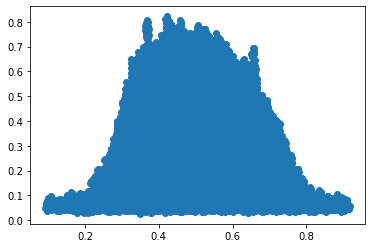

In [9]:
plt.plot(loss[:, 1], loss[:,2], 'o')

In [10]:
loss.shape

(100023, 3)